# Installation and Set Up

In [2]:
!java -version

openjdk version "17.0.13" 2024-10-15 LTS
OpenJDK Runtime Environment Microsoft-10376486 (build 17.0.13+11-LTS)
OpenJDK 64-Bit Server VM Microsoft-10376486 (build 17.0.13+11-LTS, mixed mode, sharing)


In [3]:
%pip show h2o

Name: h2o
Version: 3.46.0.6
Summary: H2O, Fast Scalable Machine Learning, for python 
Home-page: https://github.com/h2oai/h2o-3.git
Author: H2O.ai
Author-email: support@h2o.ai
License: Apache v2
Location: d:\OneDrive\Repos\employee-attrition-ibm\.venv\Lib\site-packages
Requires: requests, tabulate
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing relevant modules
import h2o
from h2o.automl import H2OAutoML
import time
import datetime

# Load Data

In [5]:
# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("../data/processed/train_set.csv")
test = h2o.import_file("../data/processed/test_set.csv")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Microsoft-10376486 (build 17.0.13+11-LTS, mixed mode, sharing)
  Starting server from D:\OneDrive\Repos\employee-attrition-ibm\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\user\AppData\Local\Temp\tmpk8gosj30
  JVM stdout: C:\Users\user\AppData\Local\Temp\tmpk8gosj30\h2o_user_started_from_python.out
  JVM stderr: C:\Users\user\AppData\Local\Temp\tmpk8gosj30\h2o_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Asia/Kuala_Lumpur
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.6
H2O_cluster_version_age:    4 months and 24 days
H2O_cluster_name:           H2O_from_python_user_ga8lhr
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.971 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.9 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
# Filter integer columns
int_columns = [col for col, dtype in test.types.items() if dtype == "int"]

# Convert all integer columns to factors in training and testing dataset
for col in int_columns:
    test[col] = test[col].asfactor()
    train[col] = train[col].asfactor()

In [7]:
# Identify predictors and response
x = train.columns
y = "Attrition"
x.remove(y)

# AutoML

In [8]:
# Start timing AutoML training
start = time.time()

print("AutoML started at:"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Run AutoML for 20 base models
aml = H2OAutoML(sort_metric="logloss",
                nfolds=5,
                seed=1,
                max_runtime_secs=0,
                max_models=70,
                balance_classes = True)
aml.train(x=x, y=y, training_frame=train)
# Documentation: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

print("AutoML completed at:"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
# print the time used to train AutoML
print('Time used (seconds): ',time.time()-start)

AutoML started at:2025-03-26_21-42-23
AutoML progress: |
21:42:24.742: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
AutoML completed at:2025-03-26_23-05-15
Time used (seconds):  4972.3910076618195


# CV performance

In [9]:
# View the AutoML Leaderboard based on CV performance
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id                                                   logloss       auc     aucpr    mean_per_class_error      rmse       mse
-------------------------------------------------------  ---------  --------  --------  ----------------------  --------  --------
GLM_1_AutoML_1_20250326_214224                            0.355827  0.815499  0.601259                0.237848  0.322771  0.104181
StackedEnsemble_AllModels_1_AutoML_1_20250326_214224      0.356202  0.806805  0.598944                0.269336  0.32514   0.105716
StackedEnsemble_BestOfFamily_1_AutoML_1_20250326_214224   0.361359  0.806413  0.588896                0.246525  0.325567  0.105994
GBM_grid_1_AutoML_1_20250326_214224_model_14              0.387729  0.776433  0.525809                0.277827  0.345124  0.11911
GBM_1_AutoML_1_20250326_214224                            0.387859  0.774751  0.518294                0.277326  0.343702  0.118131
GBM_grid_1_AutoML_1_20250326_214224_model_16              0.390751  0.767161  0.508166                0.312436  0.345197  0.119161
GBM_grid_1_AutoML_1_20250326_214224_model_19              0.393542  0.765391  0.491497                0.302326  0.347625  0.120843
GBM_grid_1_AutoML_1_20250326_214224_model_6               0.394175  0.763686  0.48926                 0.306194  0.348167  0.12122
GBM_grid_1_AutoML_1_20250326_214224_model_20              0.396522  0.775749  0.497499                0.286494  0.349131  0.121892
GBM_grid_1_AutoML_1_20250326_214224_model_11              0.397653  0.762799  0.502864                0.300471  0.34907   0.12185
GBM_grid_1_AutoML_1_20250326_214224_model_7               0.405385  0.742442  0.482787                0.310238  0.351836  0.123789
GBM_grid_1_AutoML_1_20250326_214224_model_25              0.405884  0.761608  0.477364                0.302572  0.351013  0.12321
GBM_grid_1_AutoML_1_20250326_214224_model_4               0.408539  0.760107  0.490479                0.316814  0.353102  0.124681
GBM_grid_1_AutoML_1_20250326_214224_model_17              0.410133  0.742809  0.478424                0.287829  0.352949  0.124573
GBM_grid_1_AutoML_1_20250326_214224_model_24              0.411012  0.740397  0.475137                0.306272  0.354269  0.125507
GBM_grid_1_AutoML_1_20250326_214224_model_2               0.411883  0.741182  0.467155                0.296084  0.353547  0.124995
GBM_grid_1_AutoML_1_20250326_214224_model_9               0.413776  0.745635  0.488126                0.309236  0.353487  0.124953
DeepLearning_1_AutoML_1_20250326_214224                   0.416989  0.763104  0.442845                0.27605   0.356336  0.126975
DeepLearning_grid_1_AutoML_1_20250326_214224_model_6      0.417742  0.771663  0.520019                0.298125  0.337541  0.113934
DeepLearning_grid_3_AutoML_1_20250326_214224_model_9      0.417818  0.771499  0.530644                0.305526  0.345942  0.119676
GBM_grid_1_AutoML_1_20250326_214224_model_3               0.423932  0.746669  0.435382                0.310915  0.3584    0.128451
DeepLearning_grid_2_AutoML_1_20250326_214224_model_9      0.42446   0.775847  0.526359                0.279761  0.345173  0.119144
GBM_grid_1_AutoML_1_20250326_214224_model_22              0.426798  0.736965  0.460408                0.315881  0.359374  0.12915
GBM_grid_1_AutoML_1_20250326_214224_model_1               0.429064  0.759809  0.467079                0.290185  0.36191   0.130979
DeepLearning_grid_3_AutoML_1_20250326_214224_model_6      0.430884  0.752529  0.503112                0.29627   0.349032  0.121824
GBM_grid_1_AutoML_1_20250326_214224_model_10              0.436283  0.736177  0.458329                0.330202  0.361385  0.130599
GBM_4_AutoML_1_20250326_214224                            0.436516  0.763143  0.473801                0.291127  0.359589  0.129304
GBM_3_AutoML_1_20250326_214224                            0.438423  0.749319  0.470845                0.294395  0.360079  0.129657
GBM_2_AutoML_1_20250326_214224                            0.44021   0.73423

In [10]:
# Get the best model based on CV performance
cv_best_model = aml.leader
# Display training and CV performance
cv_best_model

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20250326_214224


GLM Model: summary
    family    link    regularization               lambda_search                                                                  number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  -----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------
    binomial  logit   Ridge ( lambda = 0.008116 )  nlambda = 30, lambda.max = 6.396, lambda.min = 0.008116, lambda.1se = 0.03972  108                           108                            44                      AutoML_1_20250326_214224_training_py_36_sid_b856

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.08639428542853028
RMSE: 0.29392904828977057
LogLoss: 0.298375008499771
AUC: 0.8808107577542206
AUCPR: 0.7441353816430818
Gini: 0.7616215155084411
Null degrees of freedom: 1028
Residual degrees of freedom: 920
Null deviance: 954.1163856693311
Residual deviance: 614.0557674925287
AIC: 832.0557674925287

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3455793620691529
       0    1    Error    Rate
-----  ---  ---  -------  --------------
0      799  50   0.0589   (50.0/849.0)
1      61   119  0.3389   (61.0/180.0)
Total  860  169  0.1079   (111.0/1029.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345579     0.681948  121
max f2                       0.192744     0.713602  203
max f0point5                 0.488783     0.748175  71
max accuracy                 0.406208     0.901846  97
max precision                0.964802     1         0
max recall                   0.0101605    1         386
max specificity              0.964802     1         0
max absolute_mcc             0.406208     0.63086   97
max min_per_class_accuracy   0.203633     0.811111  194
max mean_per_class_accuracy  0.203633     0.811916  194
max tns                      0.964802     849       0
max fns                      0.964802     179       0
max fps                      0.000966801  849       399
max tps                      0.0101605    180       386
max tnr                      0.964802     1         0
max fnr                      0.964802     0.994444  0
max fpr                      0.000966801  1         399
max tpr                      0.0101605    1         386

Gains/Lift Table: Avg response rate: 17.49 %, avg score: 17.49 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01069                     0.825994           5.71667   5.71667            1                0.887225    1                           0.887225            0.0611111       0.0611111                  471.667   471.667            0.0611111
2        0.0204082                   0.74668            5.71667   5.71667            1                0.787228    1                           0.839607            0.0555556       0.116667                   471.667   471.667            0.116667
3        0.0301263                   0.693464           5.145     5.53226            0.9              0.71927     0.967742                    0.800789            0.05            0.166667                   414.5     453.226  

# Test Performance of Best Model from CV

In [11]:
# Get threshold at max f1 in CV
max_f1_threshold = cv_best_model.find_threshold_by_max_metric(xval=True, metric="f1")

# Check model performance on test data at threshold
perf = cv_best_model.model_performance(test_data=test)

# Print confusion matrix
perf.confusion_matrix(thresholds=max_f1_threshold)

Could not find exact threshold 0.29094148384395147; using closest threshold found 0.2920390160887809.


Confusion Matrix (Act/Pred) @ threshold = 0.2920390160887809
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      344  40   0.1042   (40.0/384.0)
1      14   43   0.2456   (14.0/57.0)
Total  358  83   0.1224   (54.0/441.0)

In [12]:
predictions = cv_best_model.predict(test)

# Apply your desired threshold
threshold = max_f1_threshold
predictions["custom_pred"] = (predictions["p1"] >= threshold).ifelse(1, 0)

predictions

glm prediction progress: |

███████████████████████████████████████████████████████| (done) 100%


predict        p0          p1    custom_pred
---------  --------  ----------  -------------
        1  0.289832  0.710168                1
        0  0.90852   0.0914802               0
        0  0.918528  0.0814724               0
        0  0.863246  0.136754                0
        0  0.944355  0.0556452               0
        0  0.951784  0.048216                0
        1  0.535325  0.464675                1
        0  0.993411  0.00658926              0
        0  0.964848  0.0351525               0
        0  0.763375  0.236625                0
[441 rows x 4 columns]

In [13]:
# Print performance on test data
perf

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.06619067152299168
RMSE: 0.25727547788895794
LogLoss: 0.2405861329489442
AUC: 0.9017498172514621
AUCPR: 0.7456766594378845
Gini: 0.8034996345029242
Null degrees of freedom: 440
Residual degrees of freedom: 332
Null deviance: 346.41975691703306
Residual deviance: 212.19696926096879
AIC: 430.1969692609688

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3566176385631843
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      364  20   0.0521   (20.0/384.0)
1      16   41   0.2807   (16.0/57.0)
Total  380  61   0.0816   (36.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356618     0.694915  60
max f2                       0.32273      0.719064  70
max f0point5                 0.464675     0.774648  38
max accuracy                 0.464675     0.931973  38
max precision                0.943575     1         0
max recall                   0.0277939    1         319
max specificity              0.943575     1         0
max absolute_mcc             0.451319     0.668045  40
max min_per_class_accuracy   0.234374     0.824561  106
max mean_per_class_accuracy  0.32273      0.840735  70
max tns                      0.943575     384       0
max fns                      0.943575     56        0
max fps                      0.000832914  384       399
max tps                      0.0277939    57        319
max tnr                      0.943575     1         0
max fnr                      0.943575     0.982456  0
max fpr                      0.000832914  1         399
max tpr                      0.0277939    1         319

Gains/Lift Table: Avg response rate: 12.93 %, avg score: 16.53 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0113379                   0.846082           7.73684   7.73684            1                0.891866    1                           0.891866            0.0877193       0.0877193                  673.684   673.684            0.0877193
2        0.0204082                   0.805937           7.73684   7.73684            1                0.812206    1                           0.856462            0.0701754       0.157895                   673.684   673.684            0.157895
3        0.031746                    0.695994           7.73684   7.73684            1                0.751941    1                           0.819133            0.0877193       0.245614                   673.684   673.684            0.245614
4        0.0408163                   0.638205           5.80263   7.30702            0.75             0.655501    0.944444                    0.78277             0.0526316       0.298246                   480.263   630.702            0.295641
5        0.0521542                   0.601561           6.18947   7.06407            0.8              0.616988    0.913043                    0.746731            0.0701754       0.368421                   518.947   606.407            0.363213
6        0.102041                    0.436219           4.57177   5.84561            0.590909         0.499325    0.755556                    0.625777            0.22807         0.596491                   357.177   484.561            0.567845
7        0.151927                    0.339961           2.8134    4.84996            0.363636         0.375022    0.626866                    0.54344             0.14035

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_1_AutoML_1_20250326_214224

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3566176385631843
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      364  20   0.0521   (20.0/384.0)
1      16   41   0.2807   (16.0/57.0)
Total  380  61   0.0816   (36.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

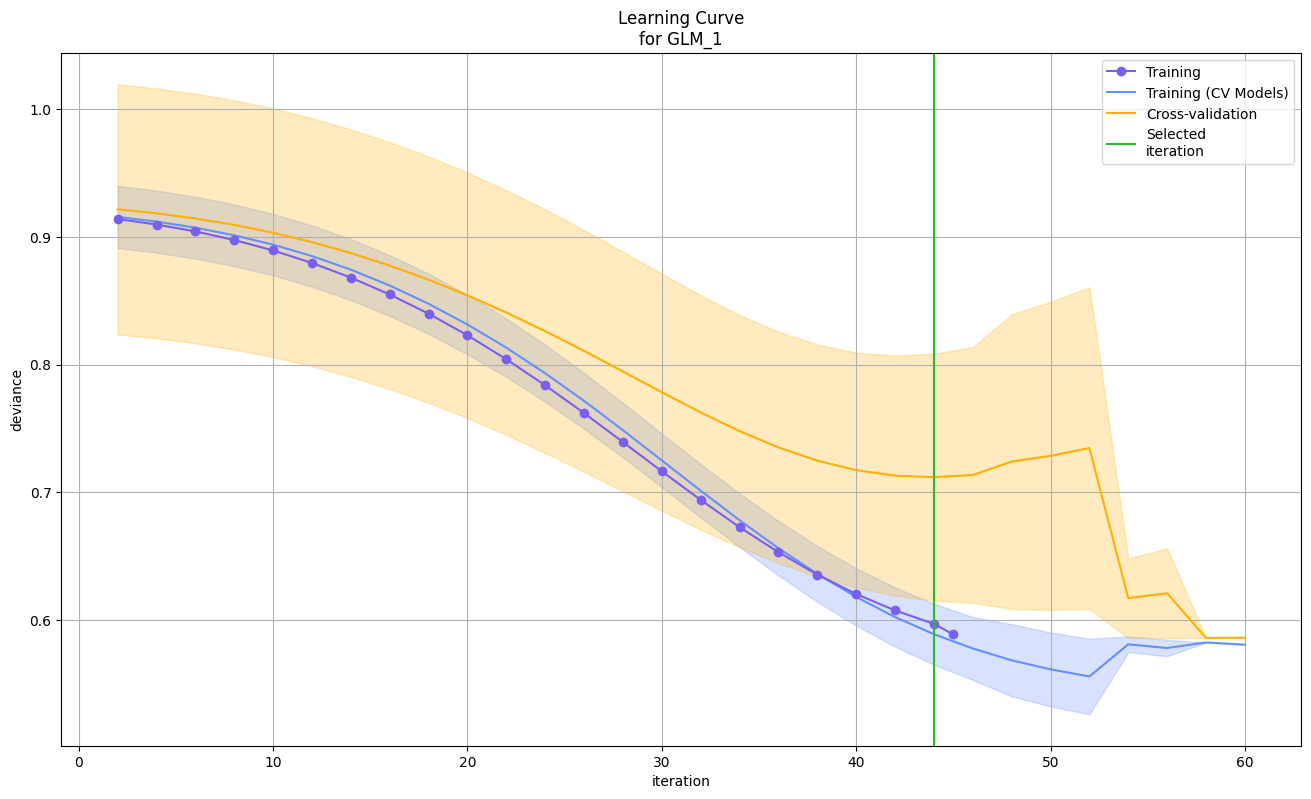

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

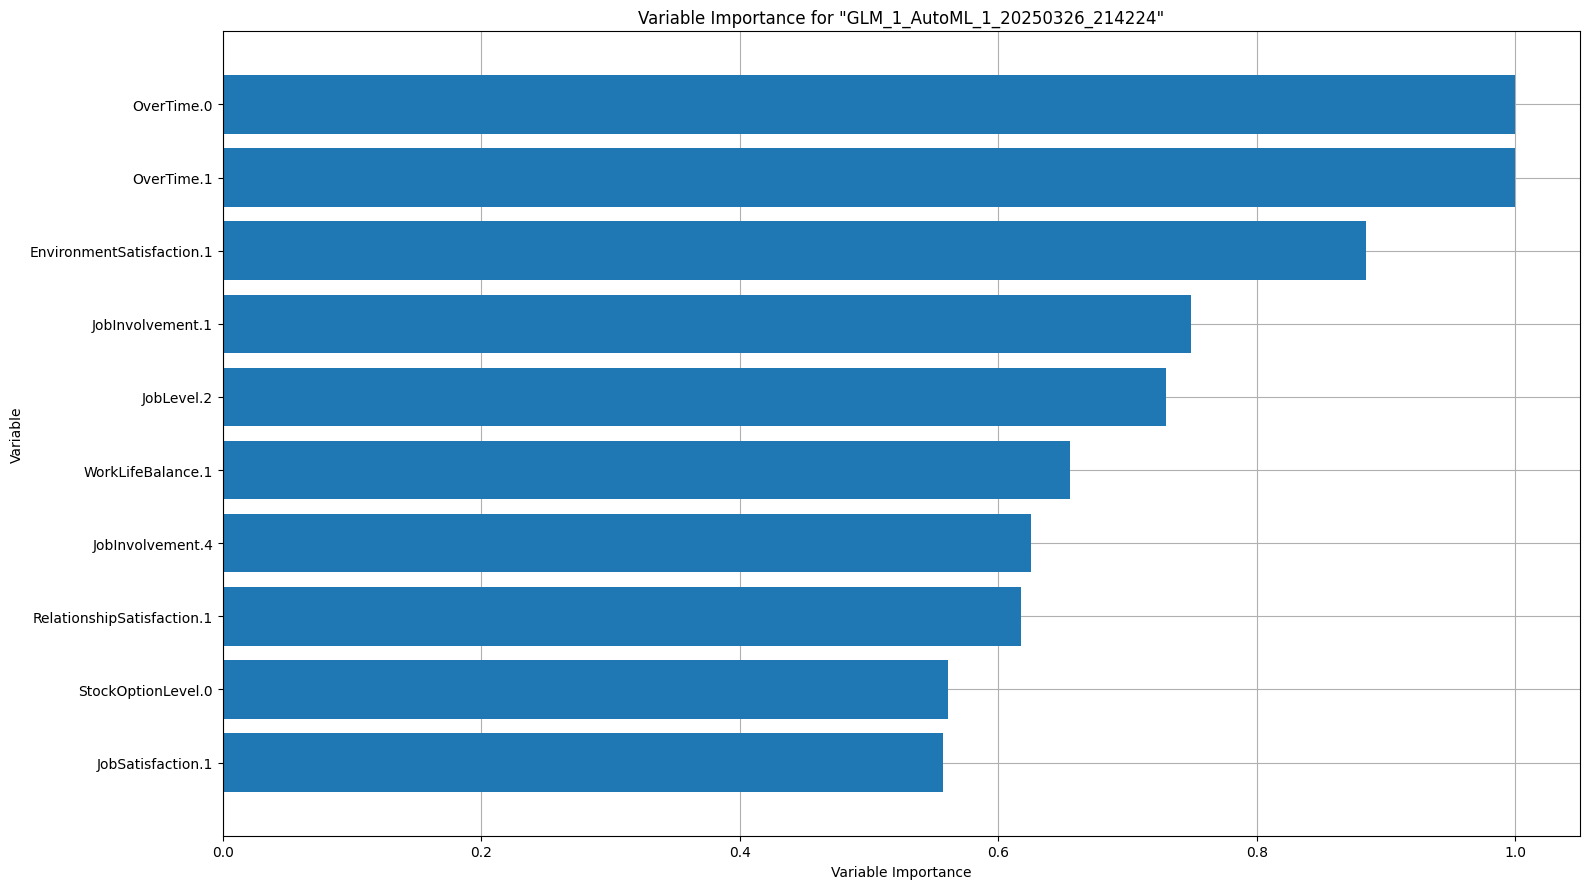

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

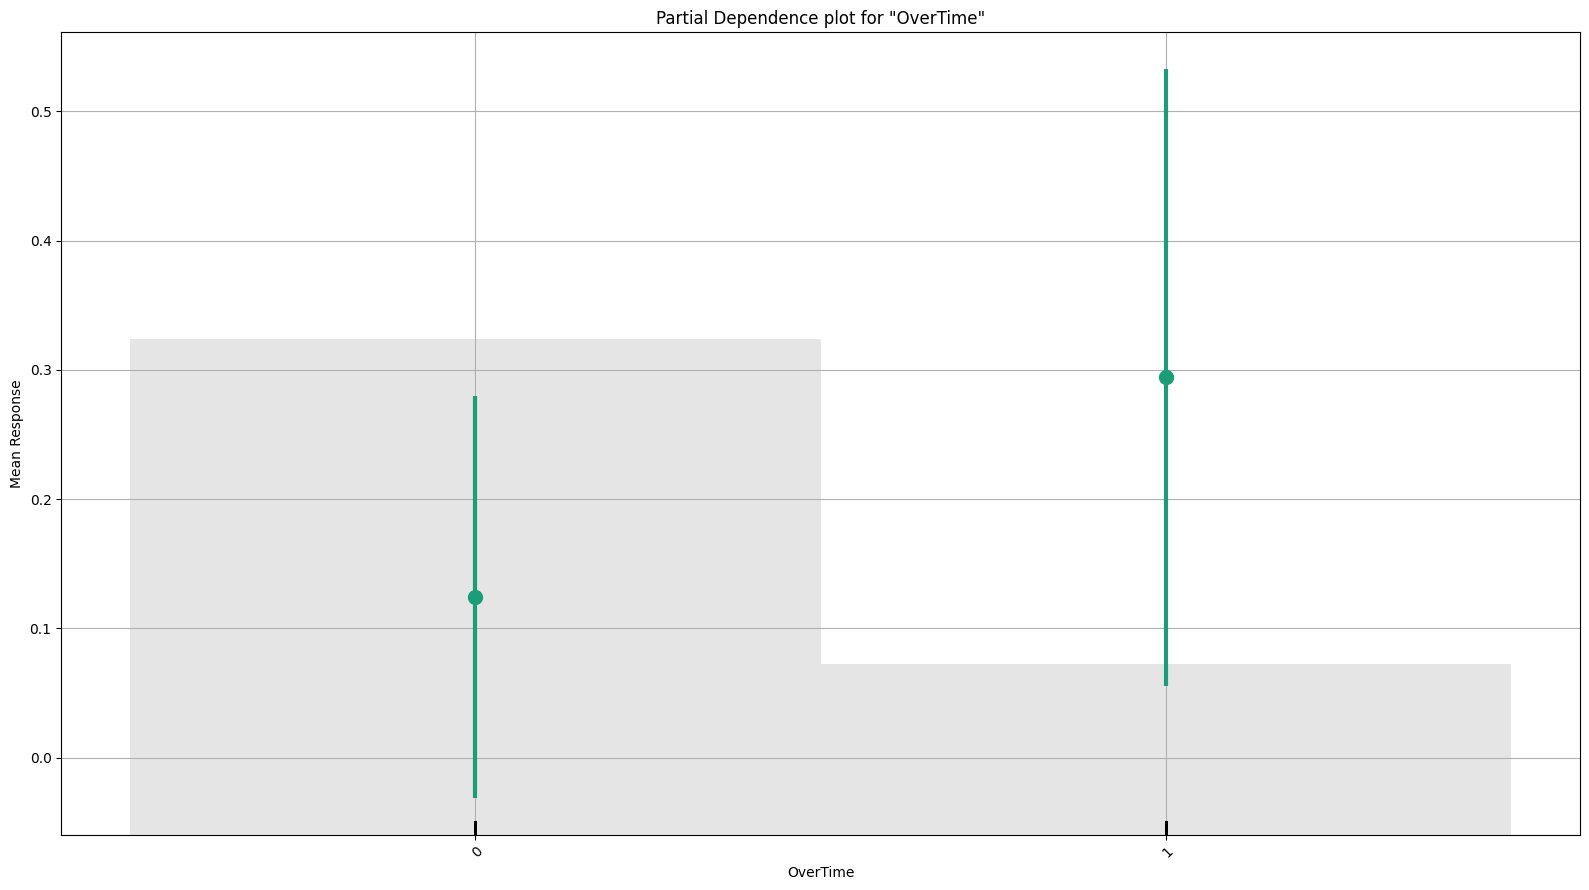

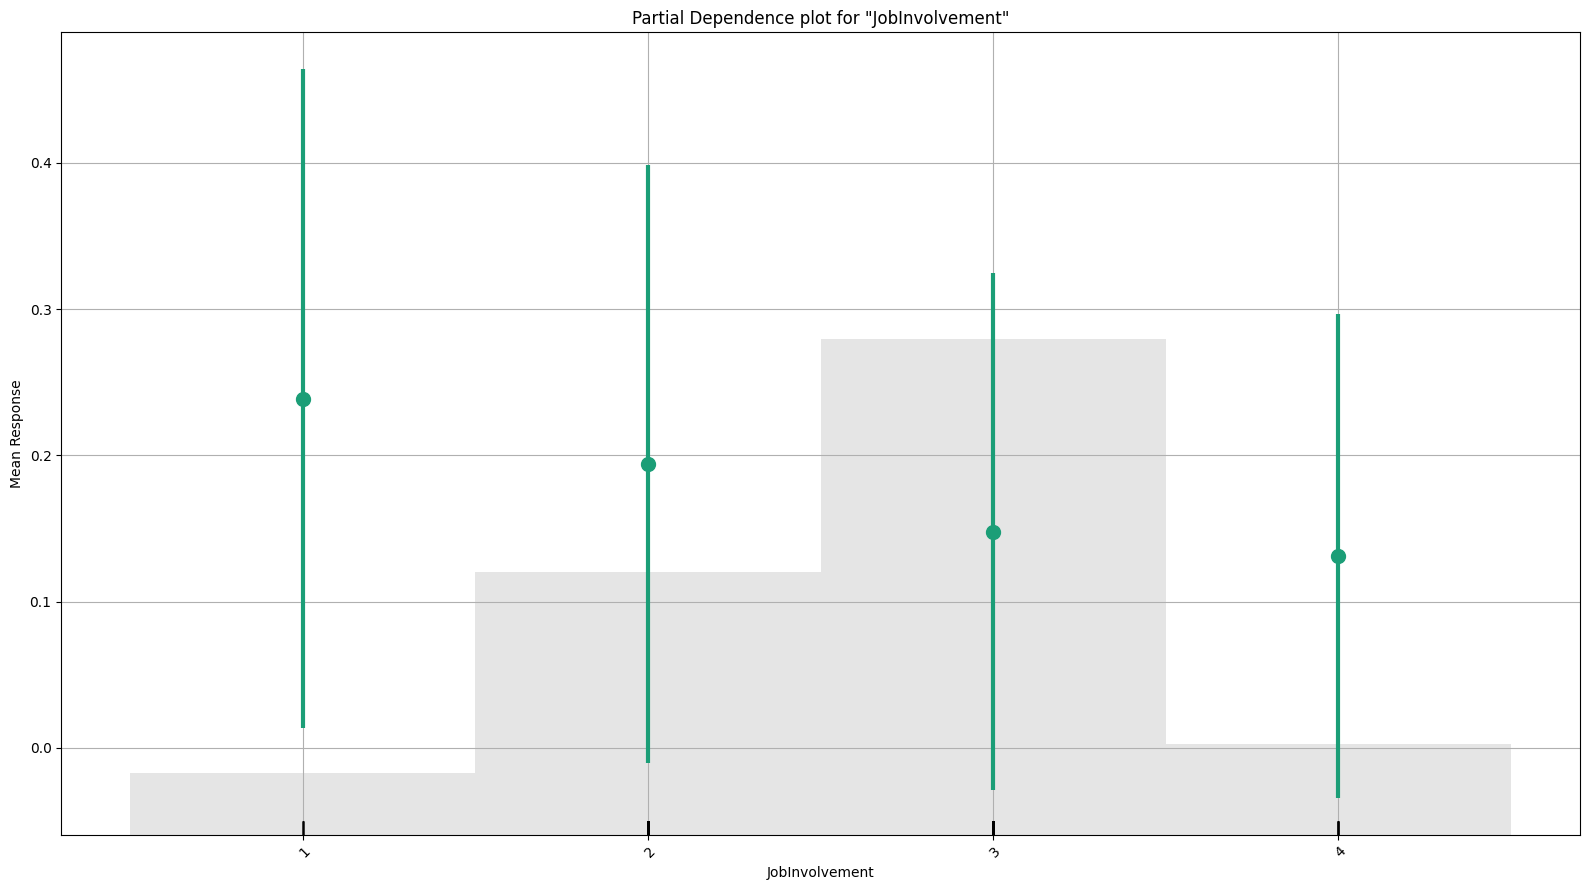

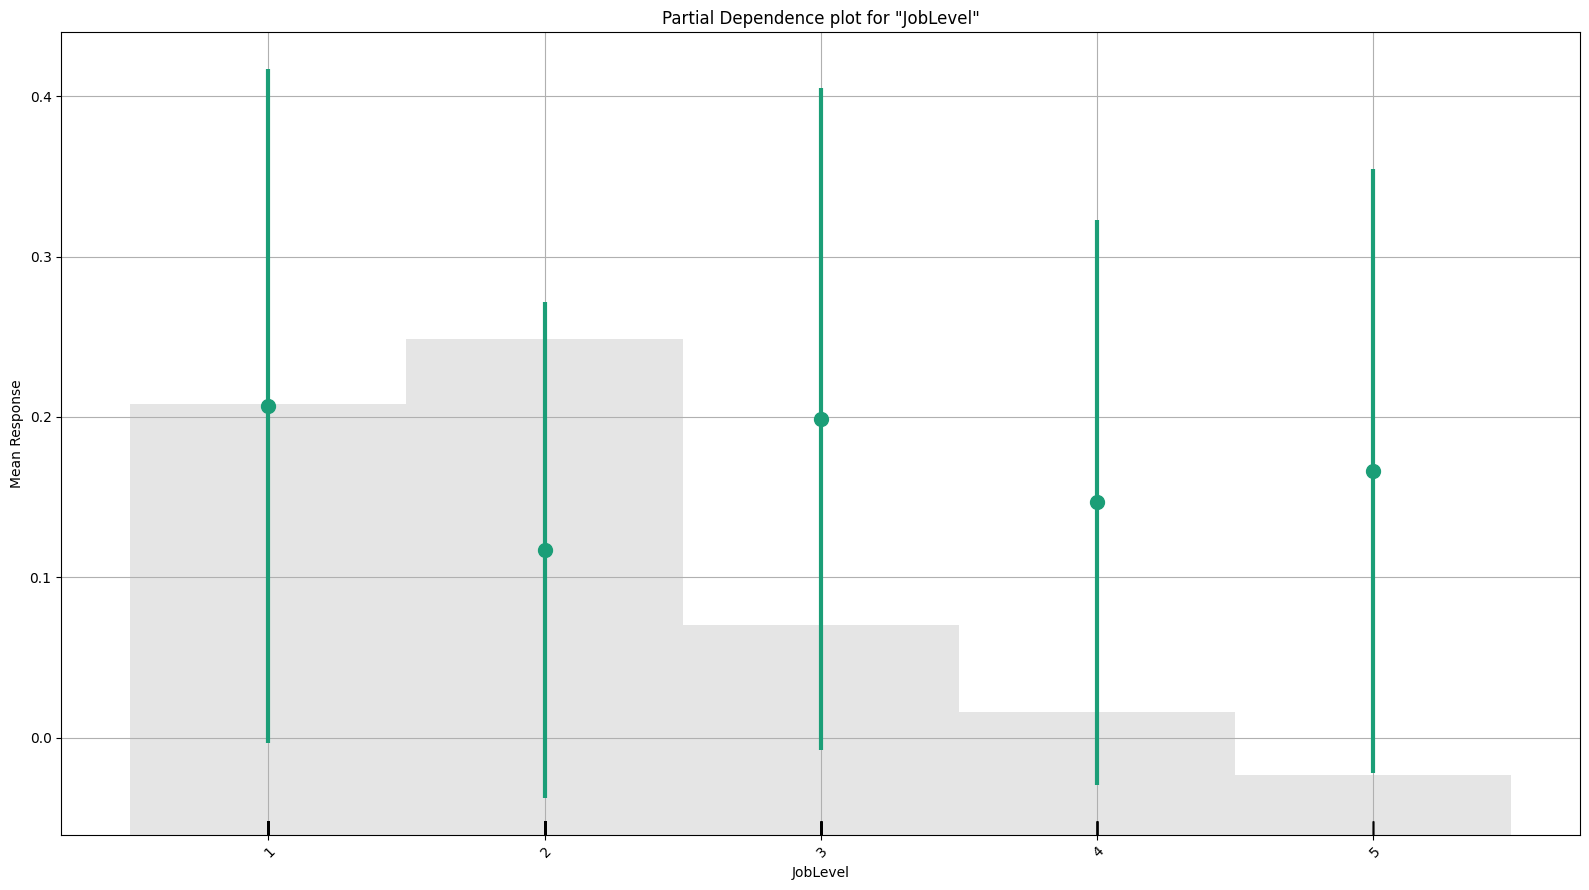

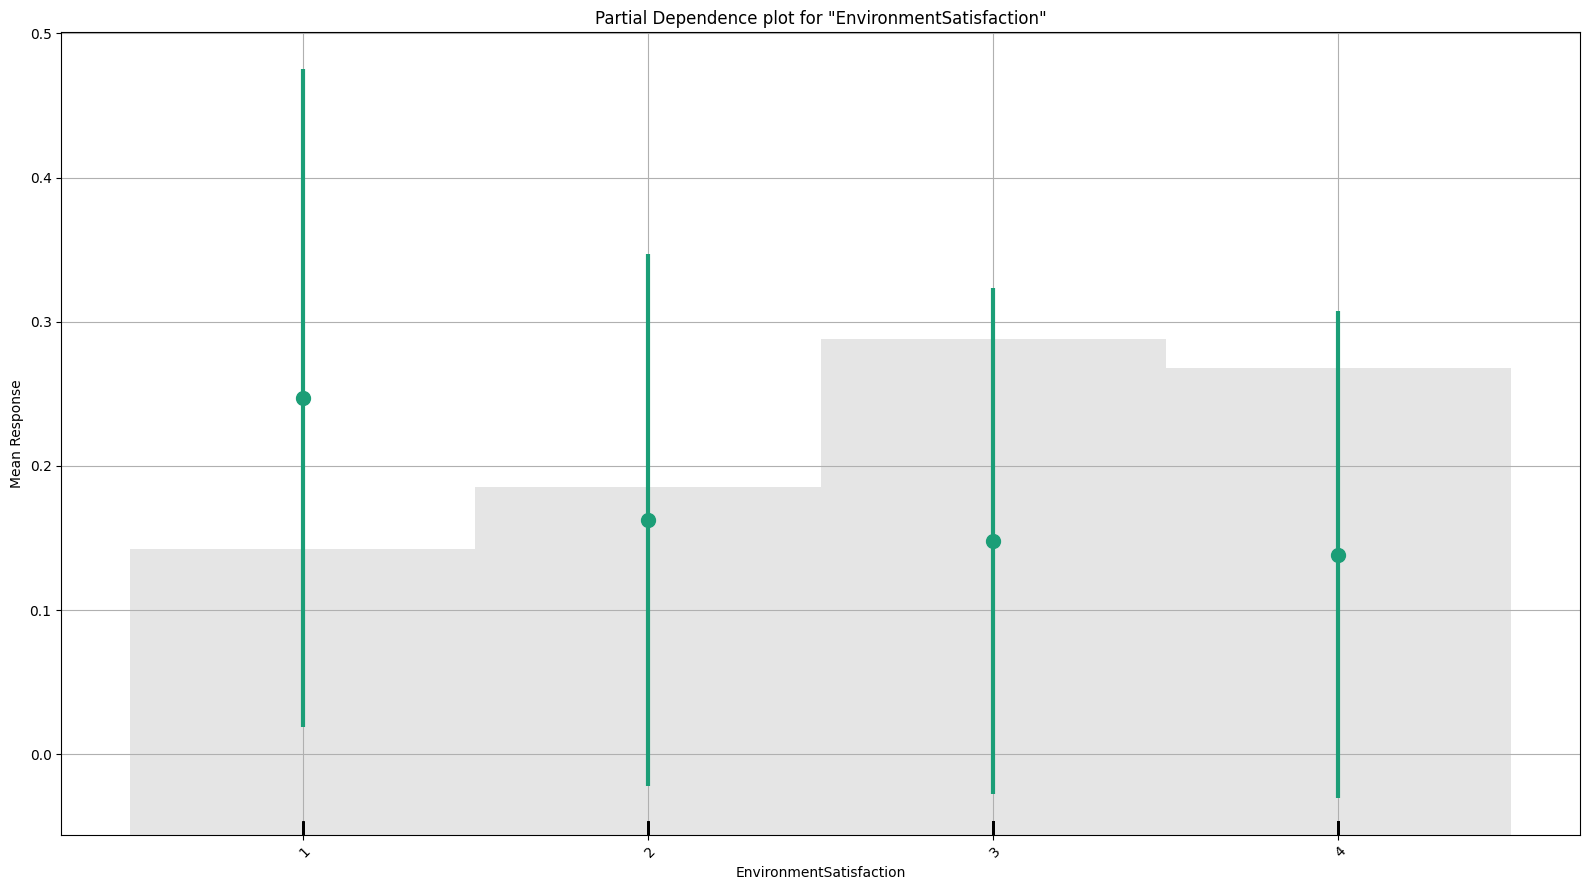

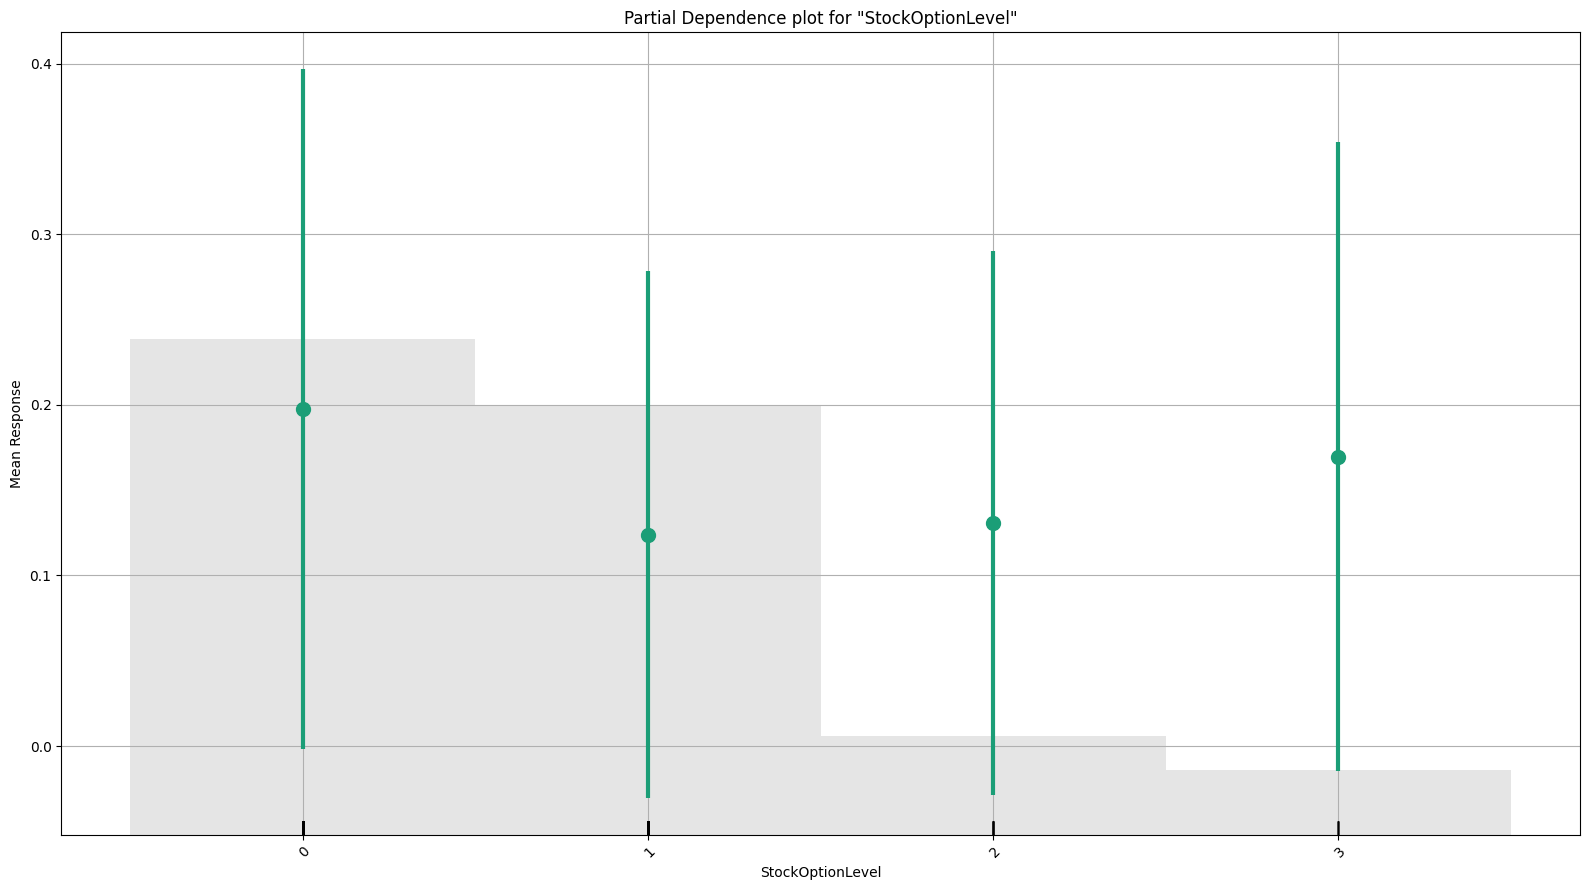

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_1_AutoML_1_20250326_214224

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3566176385631843
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      364  20   0.0521   (20.0/384.0)
1      16   41   0.2807   (16.0/57.0)
Total  380  61   0.0816   (36.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

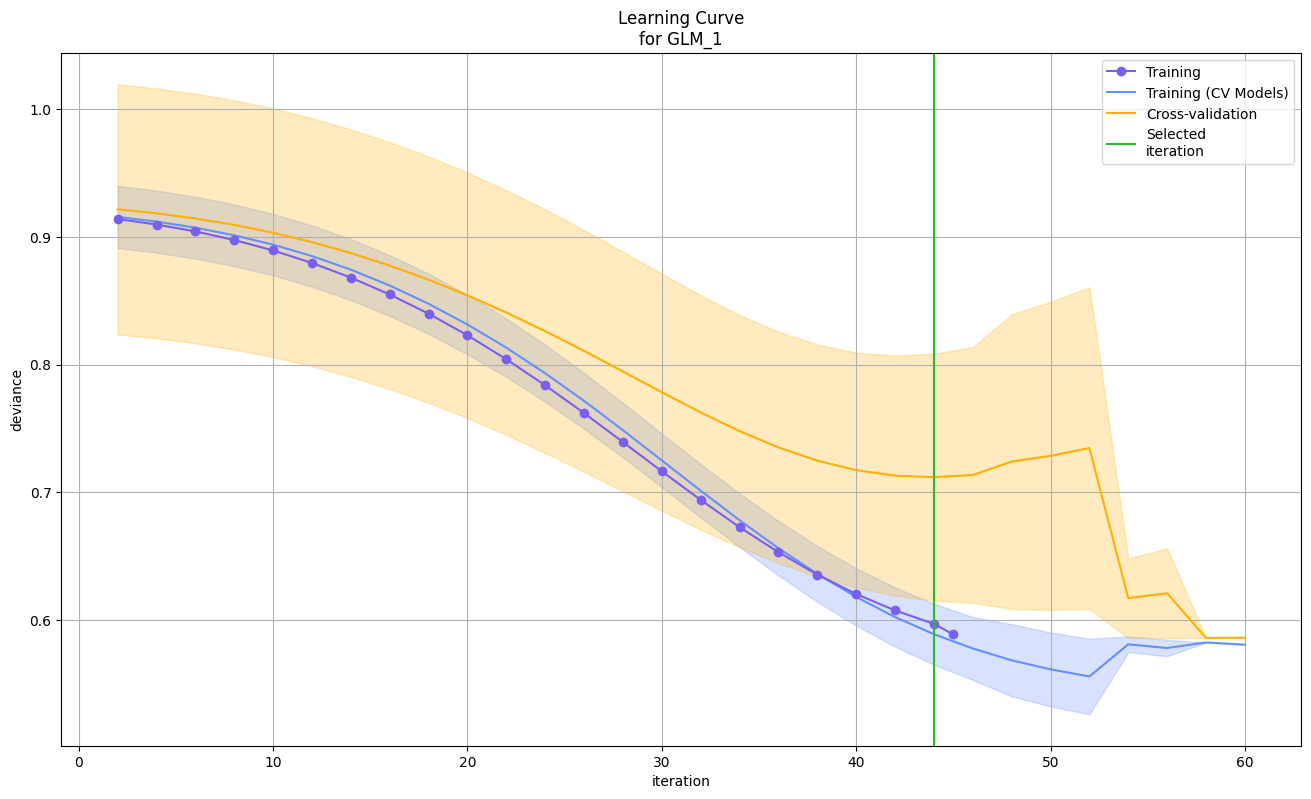

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

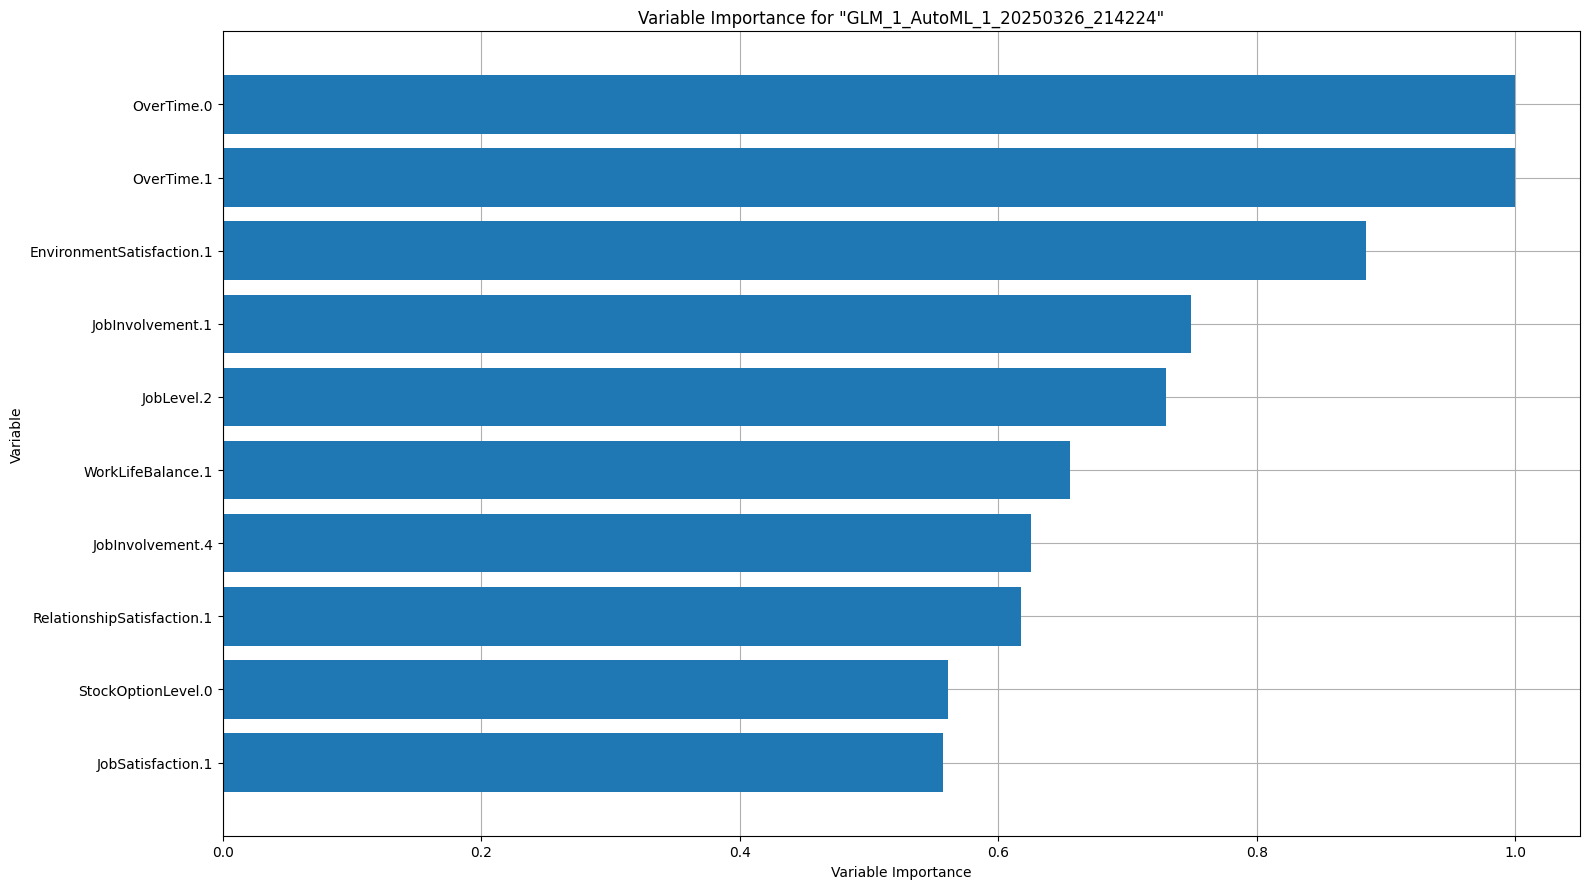

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

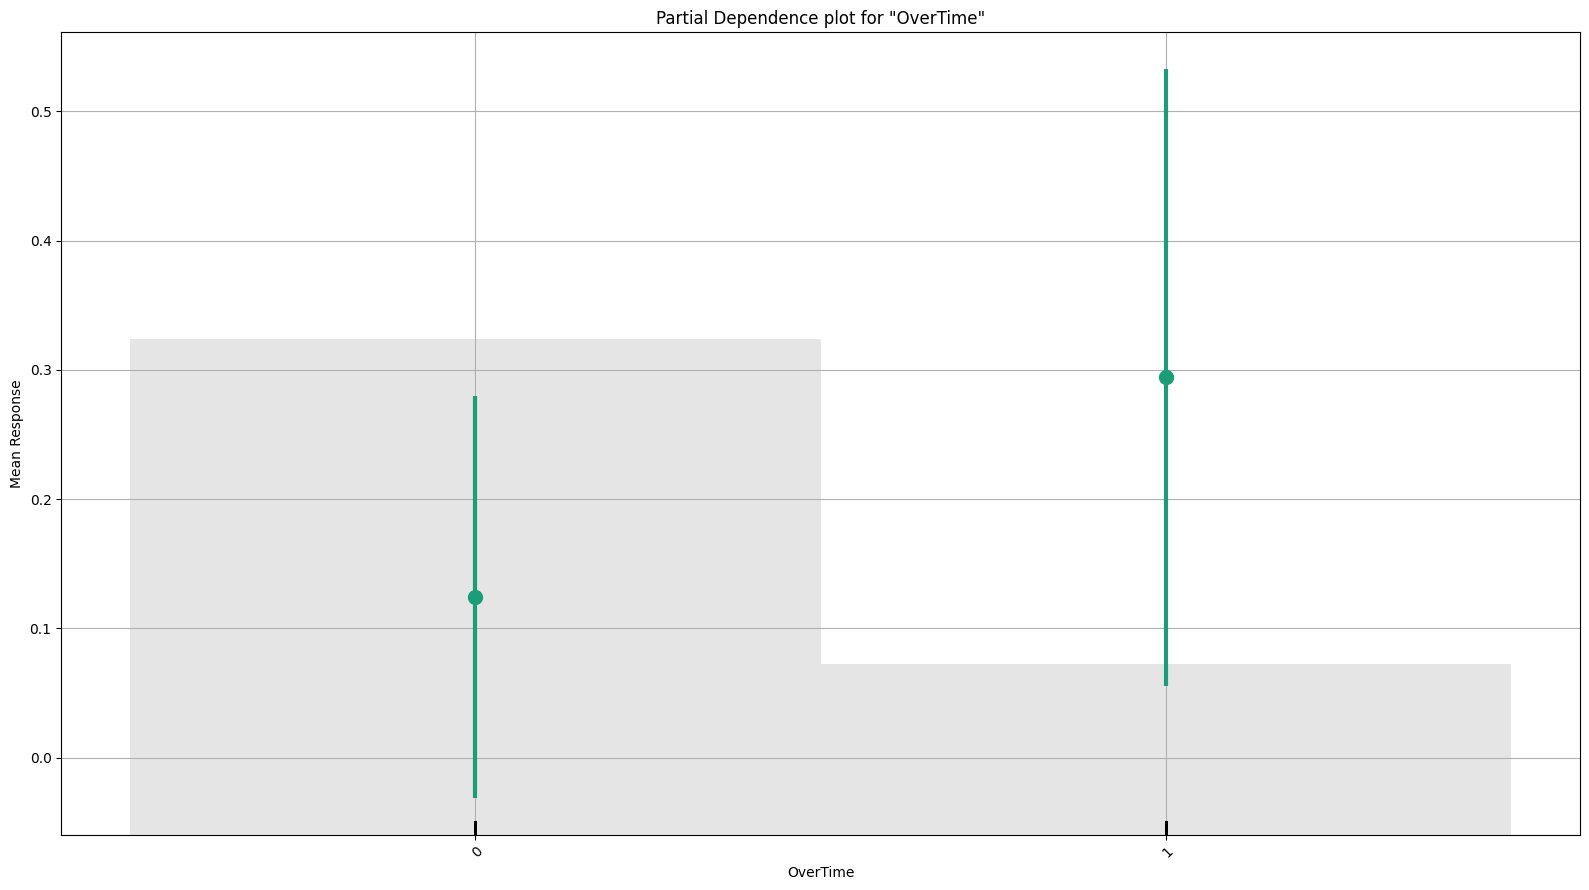

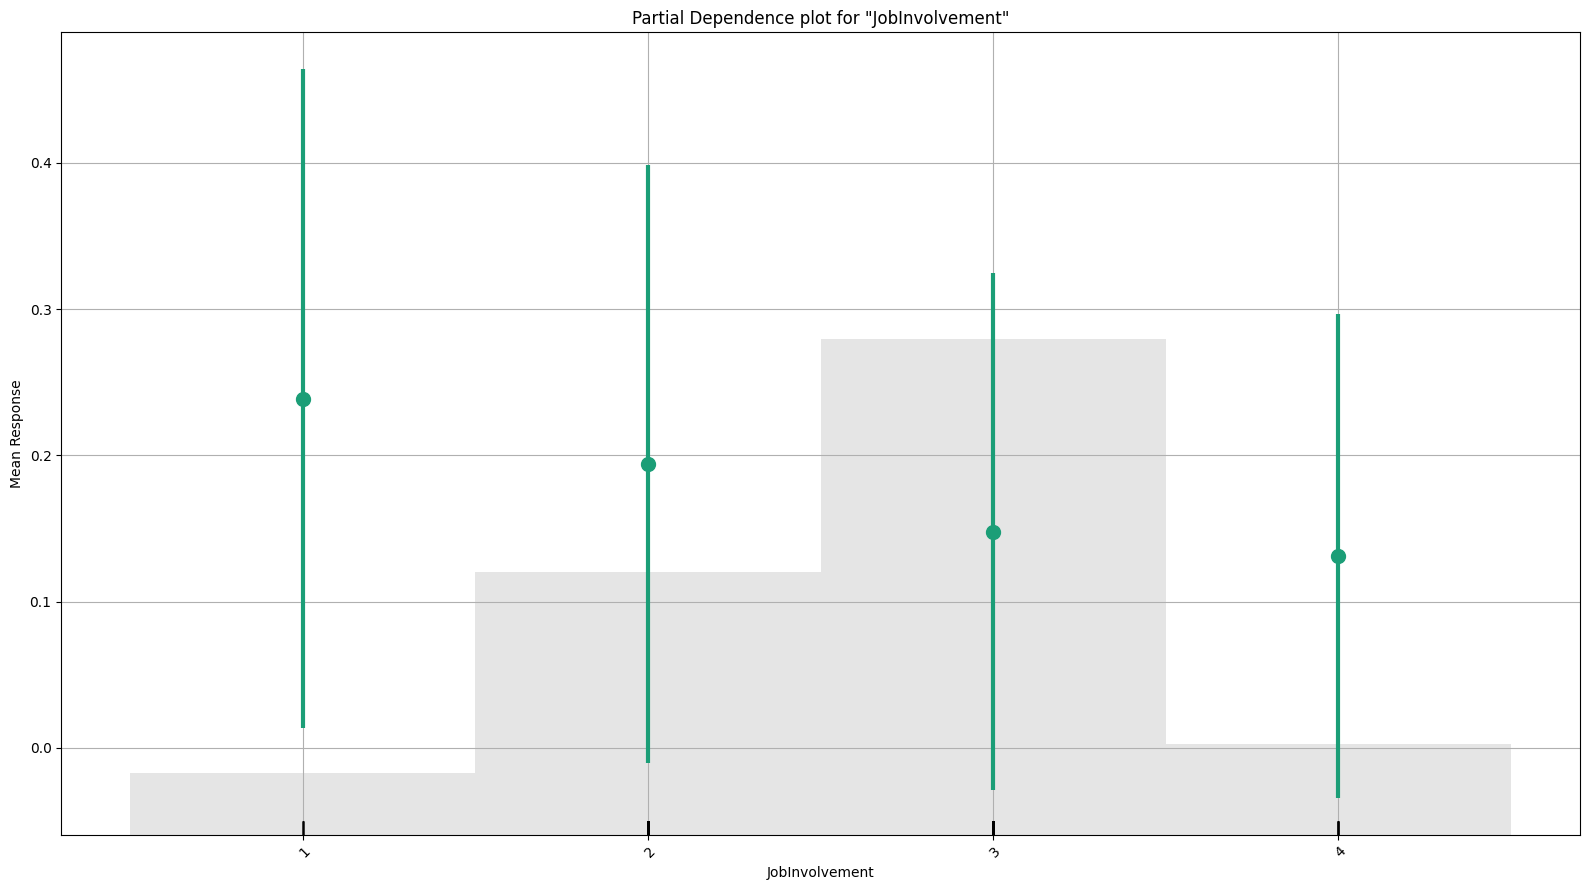

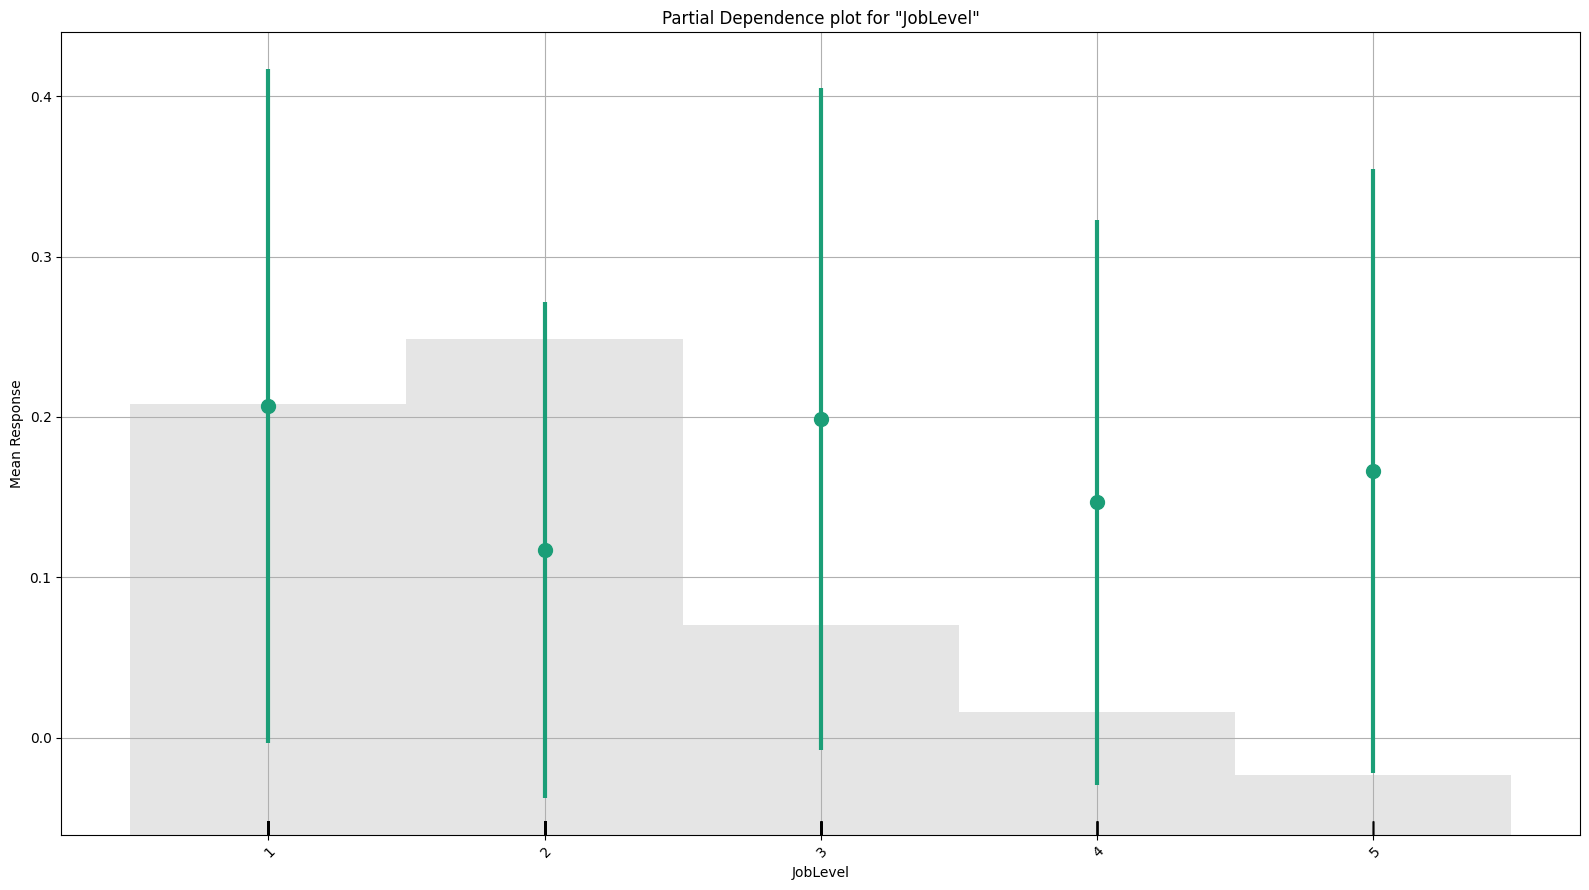

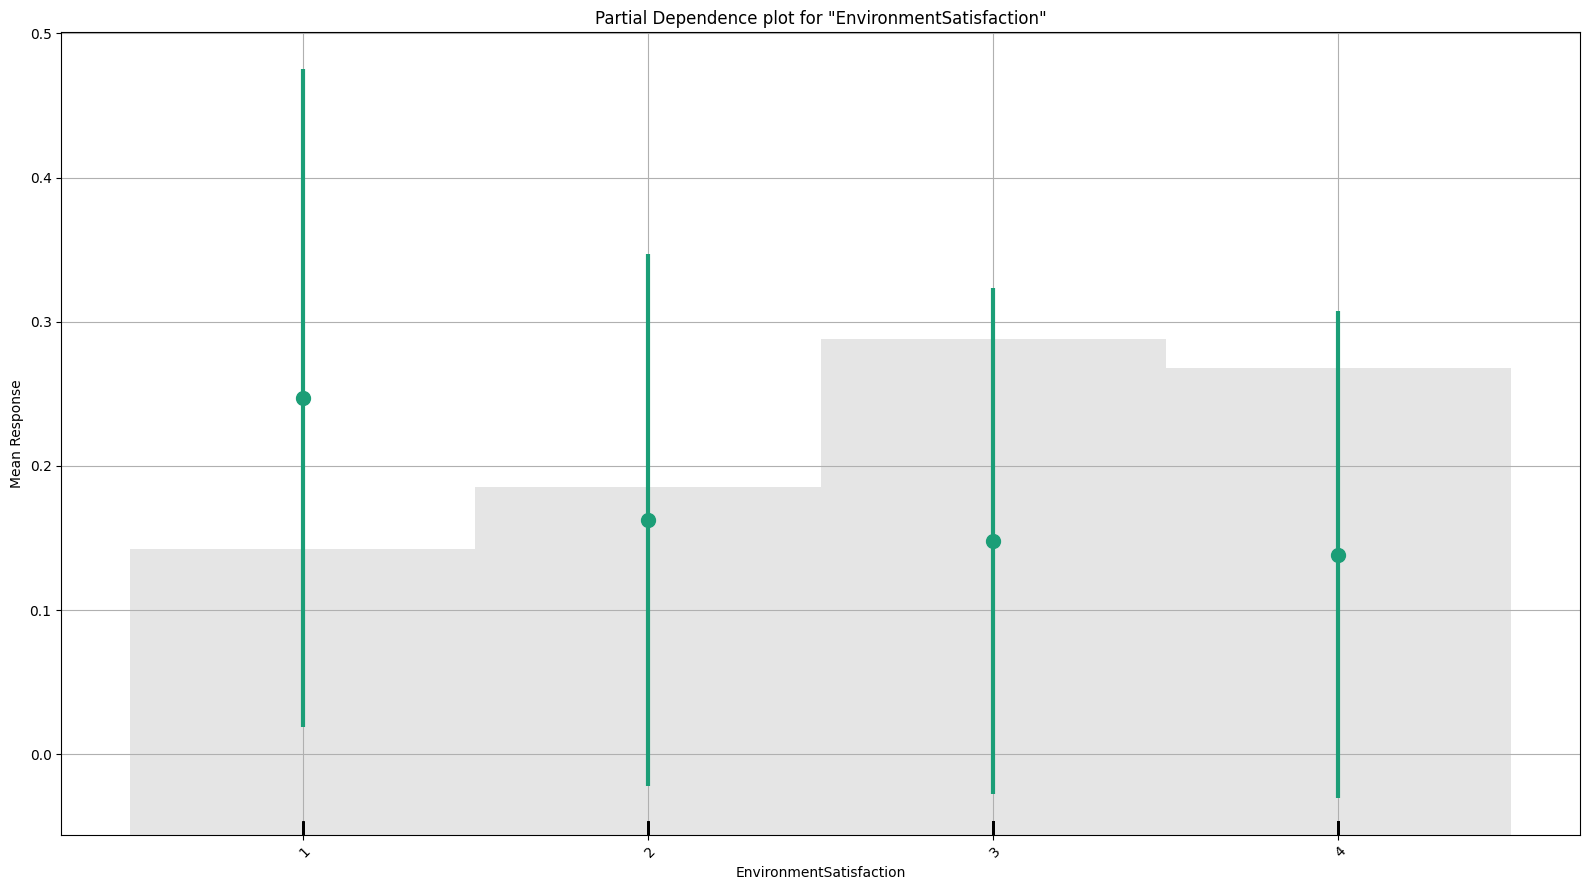

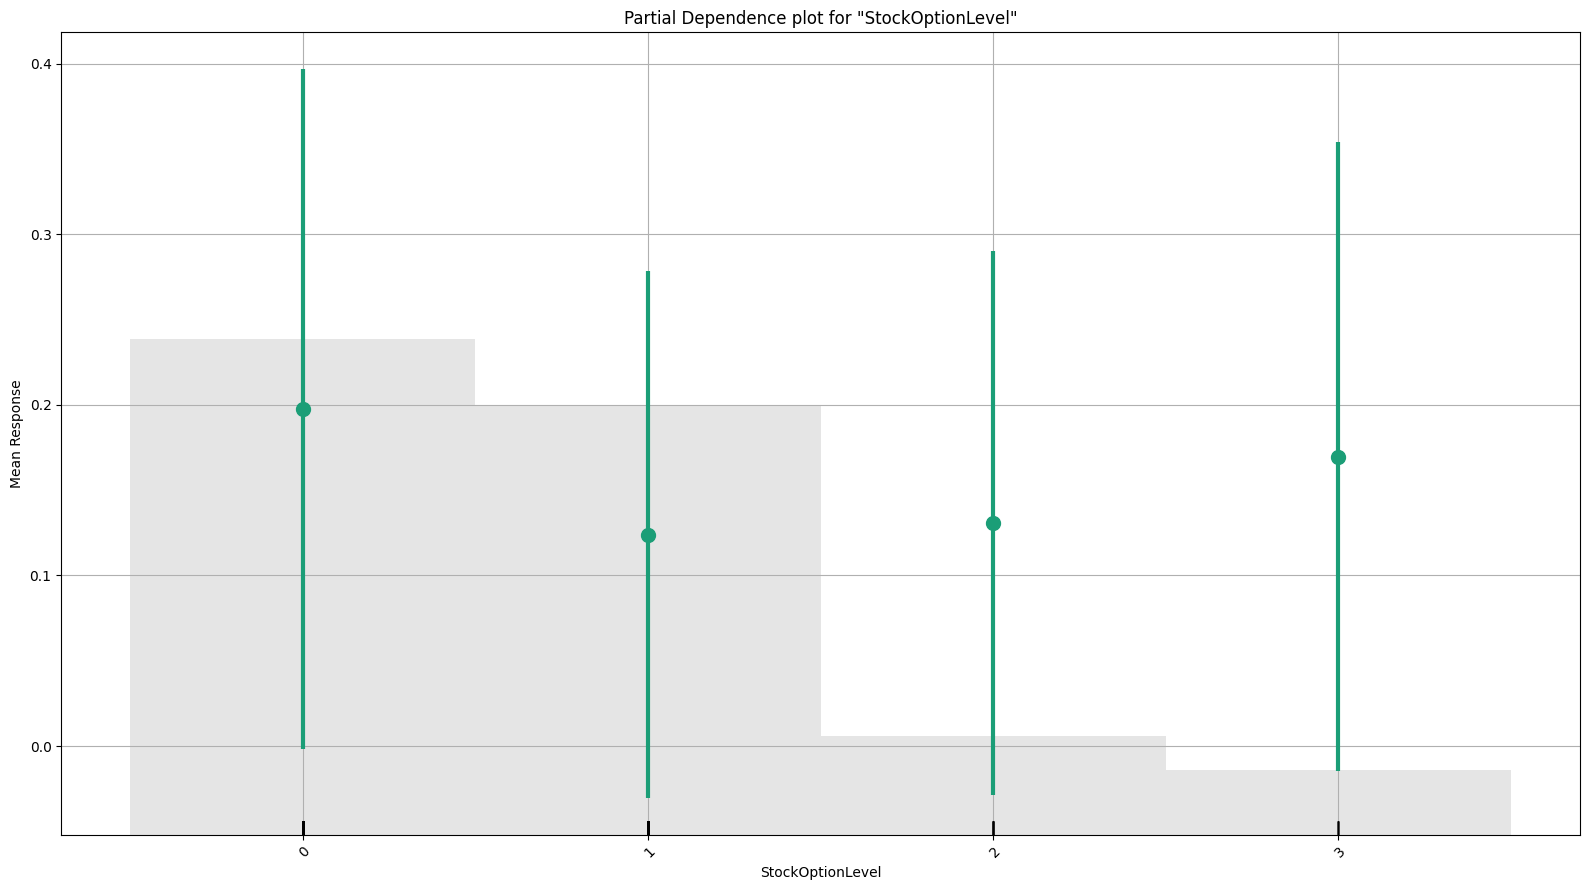

In [14]:
# Display test performance
cv_best_model.explain(test)

# Test Performance of other Models

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  ---------  ------------------  -------------------------  ---------------
GLM_1_AutoML_1_20250326_214224                           0.90175    0.240586  0.745677                0.166393  0.257275  0.0661907                 442                   0.014729  GLM
StackedEnsemble_BestOfFamily_1_AutoML_1_20250326_214224  0.898483   0.23849   0.743845                0.193325  0.255765  0.0654159                1935                   0.021608  StackedEnsemble
GBM_grid_1_AutoML_1_20250326_214224_model_6              0.886422   0.277739  0.668154                0.215461  0.283231  0.0802198                 369                   0.009878  GBM
GBM_grid_1_AutoML_1_20250326_214224_model_14             0.874109   0.27928   0.639625                0.221628  0.284002  0.0806571                 274                   0.015233  GBM
GBM_grid_1_AutoML_1_20250326_214224_model_16             0.873698   0.272318  0.644445                0.232662  0.281155  0.0790483                 451                   0.016777  GBM
GBM_grid_1_AutoML_1_20250326_214224_model_4              0.871139   0.278205  0.590328                0.229441  0.288245  0.083085                  396                   0.01672   GBM
StackedEnsemble_AllModels_1_AutoML_1_20250326_214224     0.86849    0.325554  0.645233                0.219367  0.28153   0.079259                 4391                   0.106391  StackedEnsemble
DeepLearning_grid_2_AutoML_1_20250326_214224_model_10    0.862048   1.05641   0.648384                0.205387  0.300136  0.0900818               18604                   0.040992  DeepLearning
DeepLearning_grid_3_AutoML_1_20250326_214224_model_2     0.862025   0.686006  0.607894                0.240817  0.306075  0.0936816                9148                   0.025255  DeepLearning
GBM_grid_1_AutoML_1_20250326_214224_model_11             0.861842   0.283633  0.614755                0.239515  0.287717  0.0827813                 247                   0.01331   GBM
DeepLearning_grid_1_AutoML_1_20250326_214224_model_9     0.861819   0.840302  0.637316                0.184279  0.301173  0.0907053                4313                   0.020816  DeepLearning
GBM_1_AutoML_1_20250326_214224                           0.861705   0.275035  0.616579                0.263843  0.283403  0.0803174                1077                   0.012919  GBM
GBM_grid_1_AutoML_1_20250326_214224_model_19             0.857456   0.285961  0.589114                0.208333  0.288105  0.0830043                 308                   0.011051  GBM
DeepLearning_grid_3_AutoML_1_20250326_214224_model_3     0.85604    1.04051   0.58374                 0.243078  0.317737  0.100957                 5448                   0.028006  DeepLearning
GBM_grid_1_AutoML_1_20250326_214224_model_3              0.856017   0.283192  0.603773                0.228139  0.289368  0.0837339                 365                   0.012438  GBM
DeepLearning_1_AutoML_1_20250326_214224                  0.854921   0.328465  0.654363                0.239789  0.314399  0.0988464                 343                   0.012534  DeepLearning
DeepLearning_grid_2_AutoML_1_20250326_214224_model_9     0.854761   1.12092   0.630096                0.23787   0.312009  0.0973499                4256                   0.027961  DeepLearning
DeepLearning_grid_3_AutoML_1_20250326_214224_model_4     0.854486   0.992601  0.57226                 0.190241  0.316867  0.100405                18721                   0.024377  DeepLearning
DeepLearning_grid_3_AutoML_1_20250326_214224_model_5     0.853915   0.481347  0.602846                0.297286  0.305815  0.0935229                6055                   0.03231   DeepLearning
GBM_grid_1_AutoML_1_2025032

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_1_AutoML_1_20250326_214224

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3566176385631843
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      364  20   0.0521   (20.0/384.0)
1      16   41   0.2807   (16.0/57.0)
Total  380  61   0.0816   (36.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

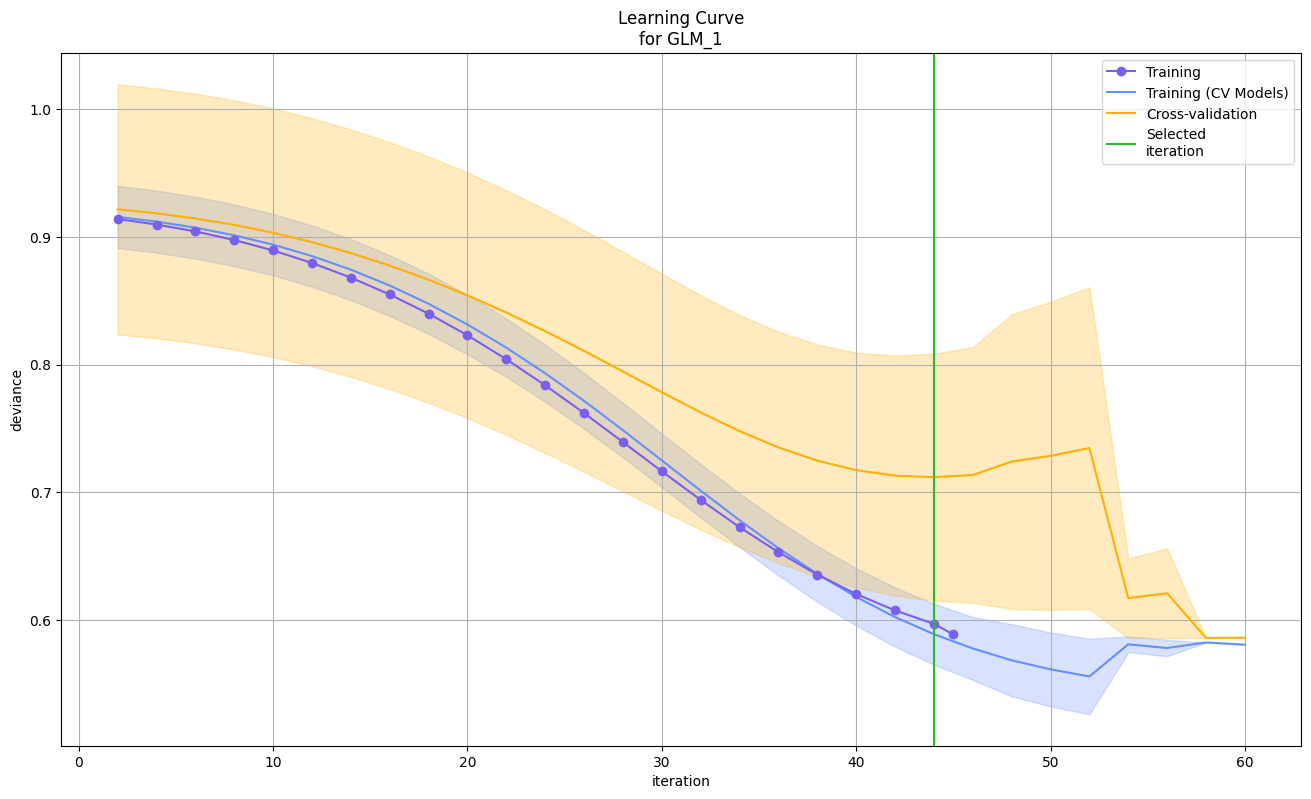

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

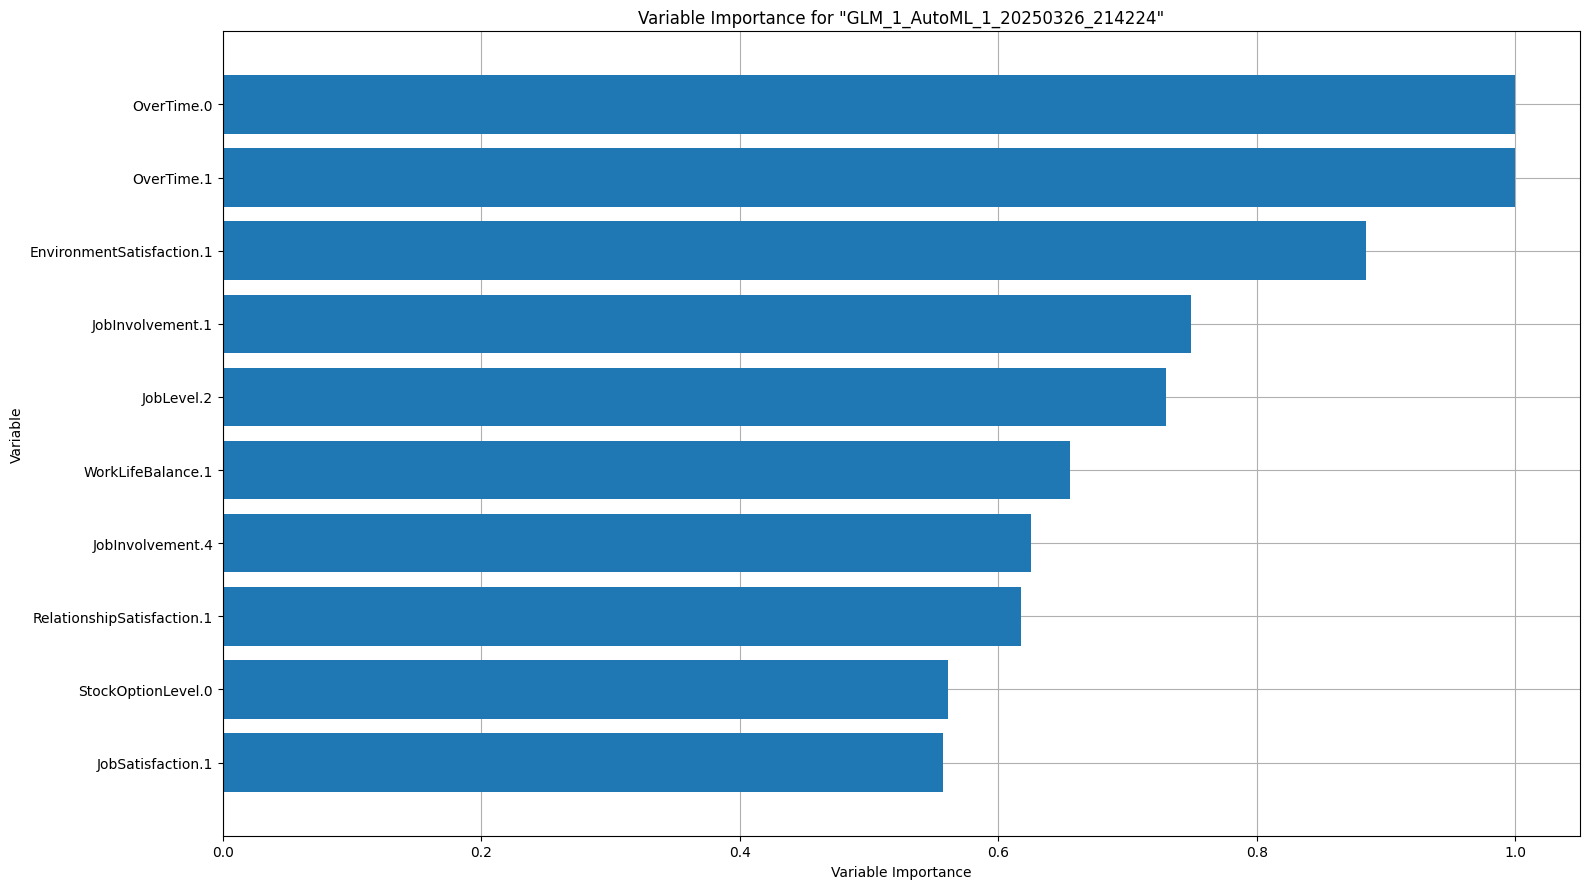

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

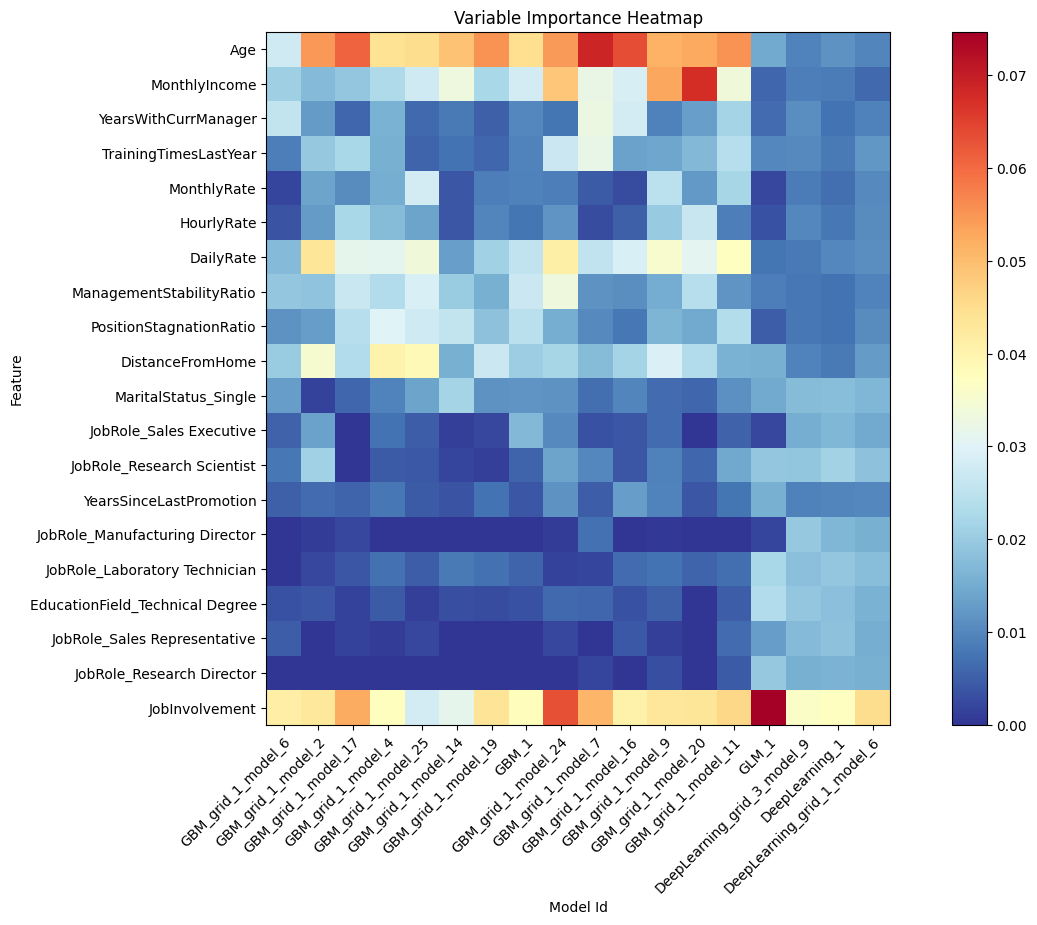

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

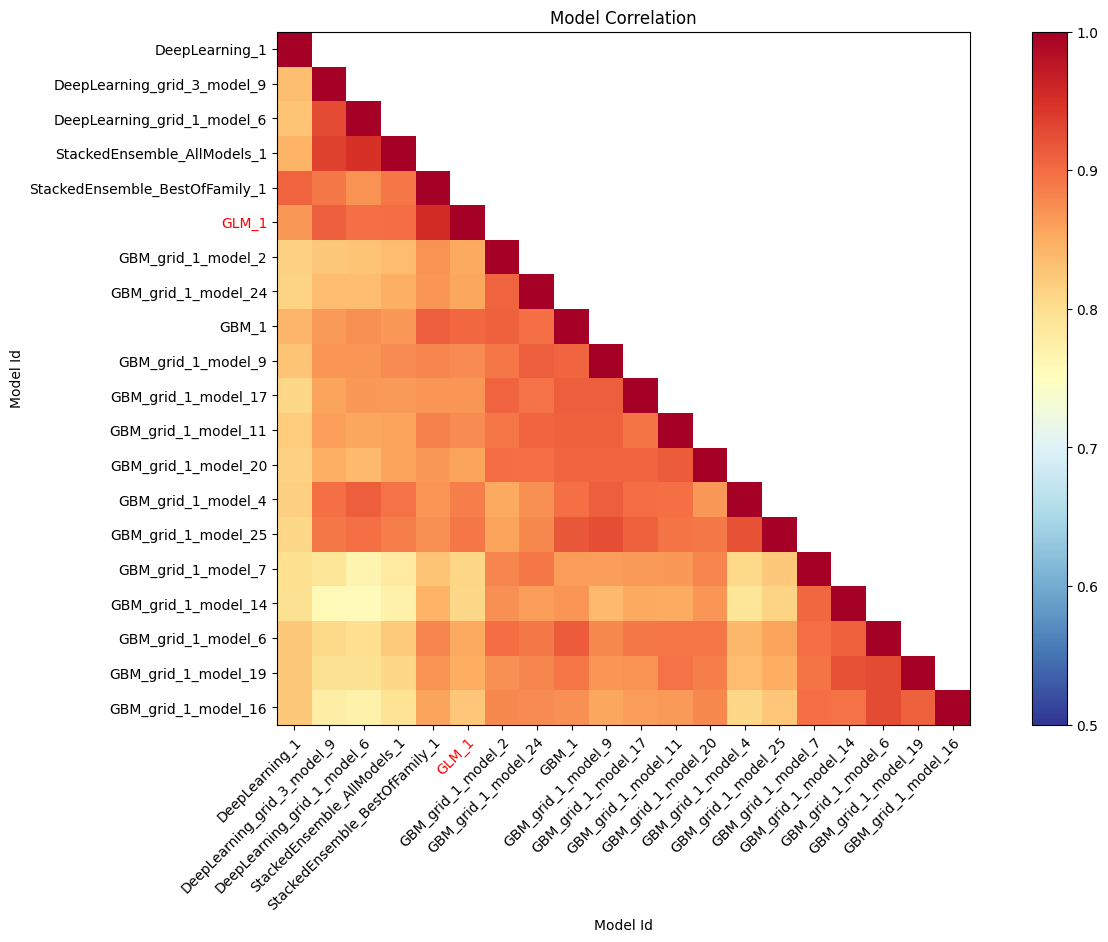

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

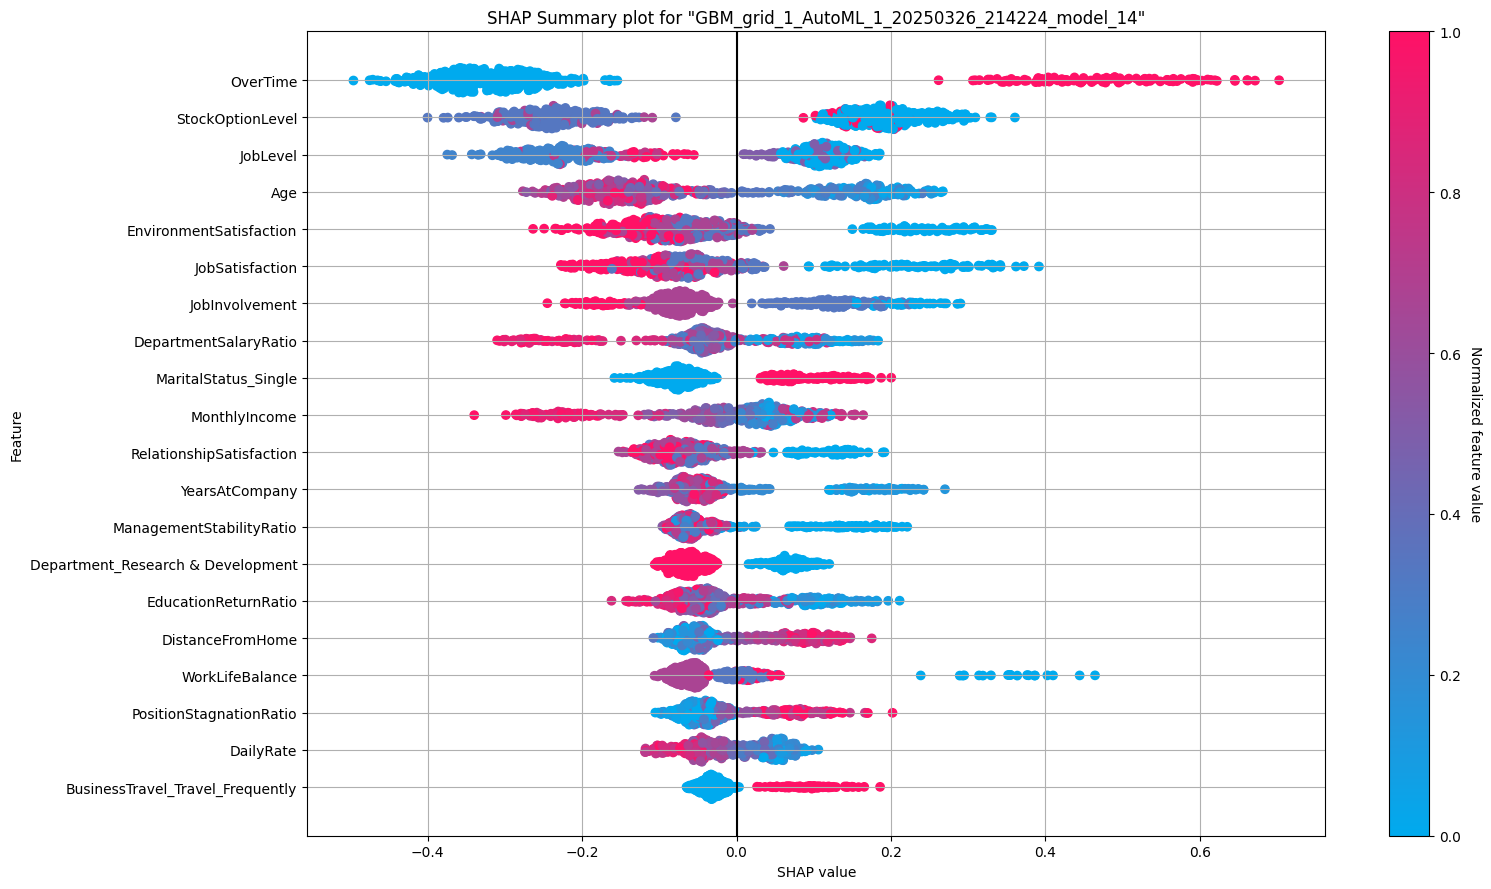

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

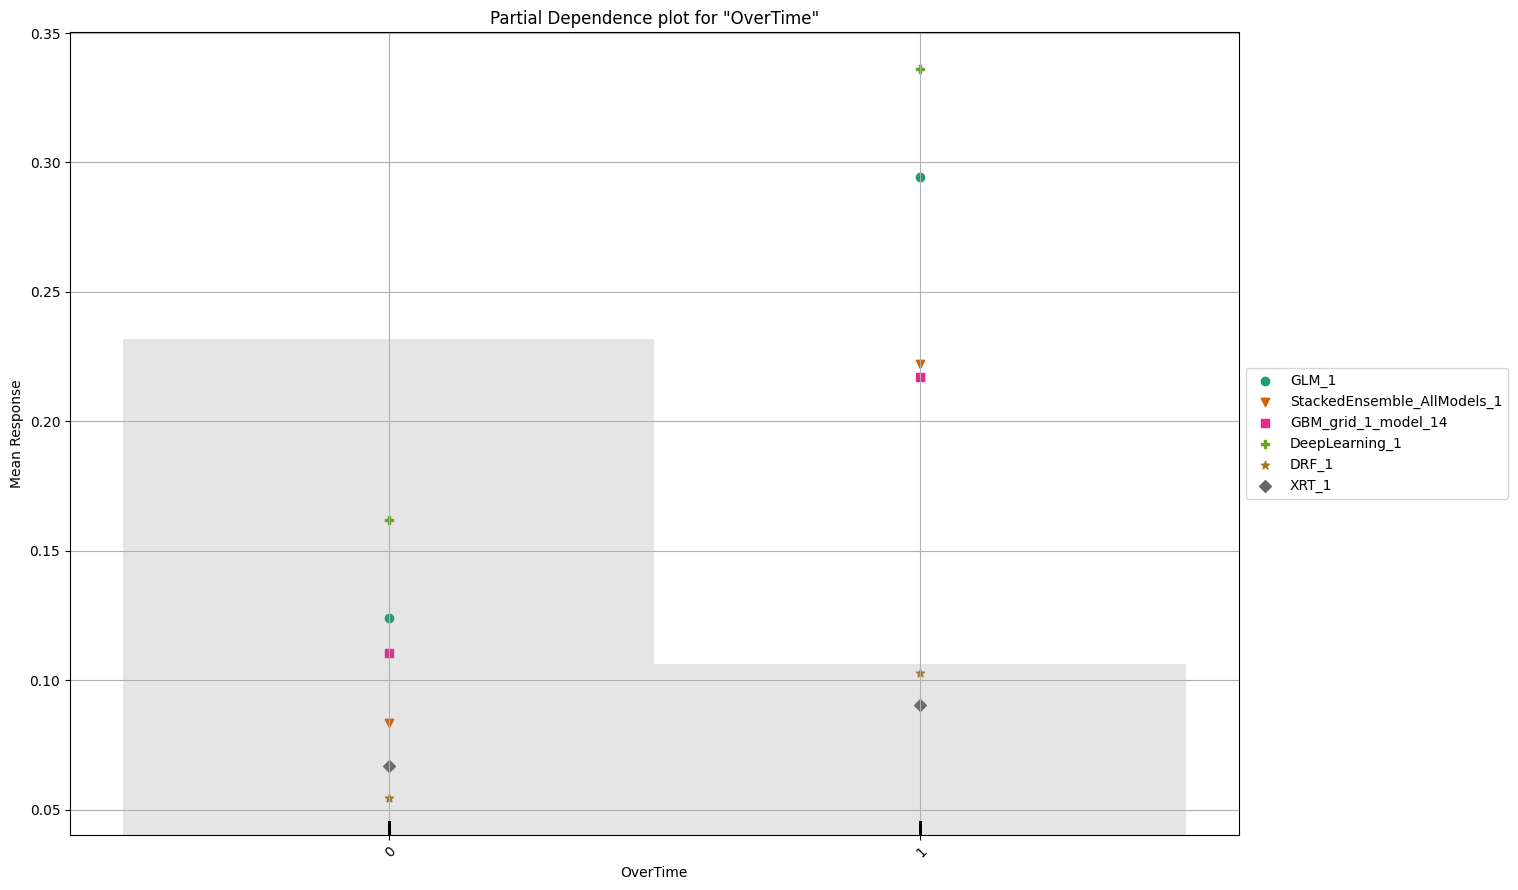

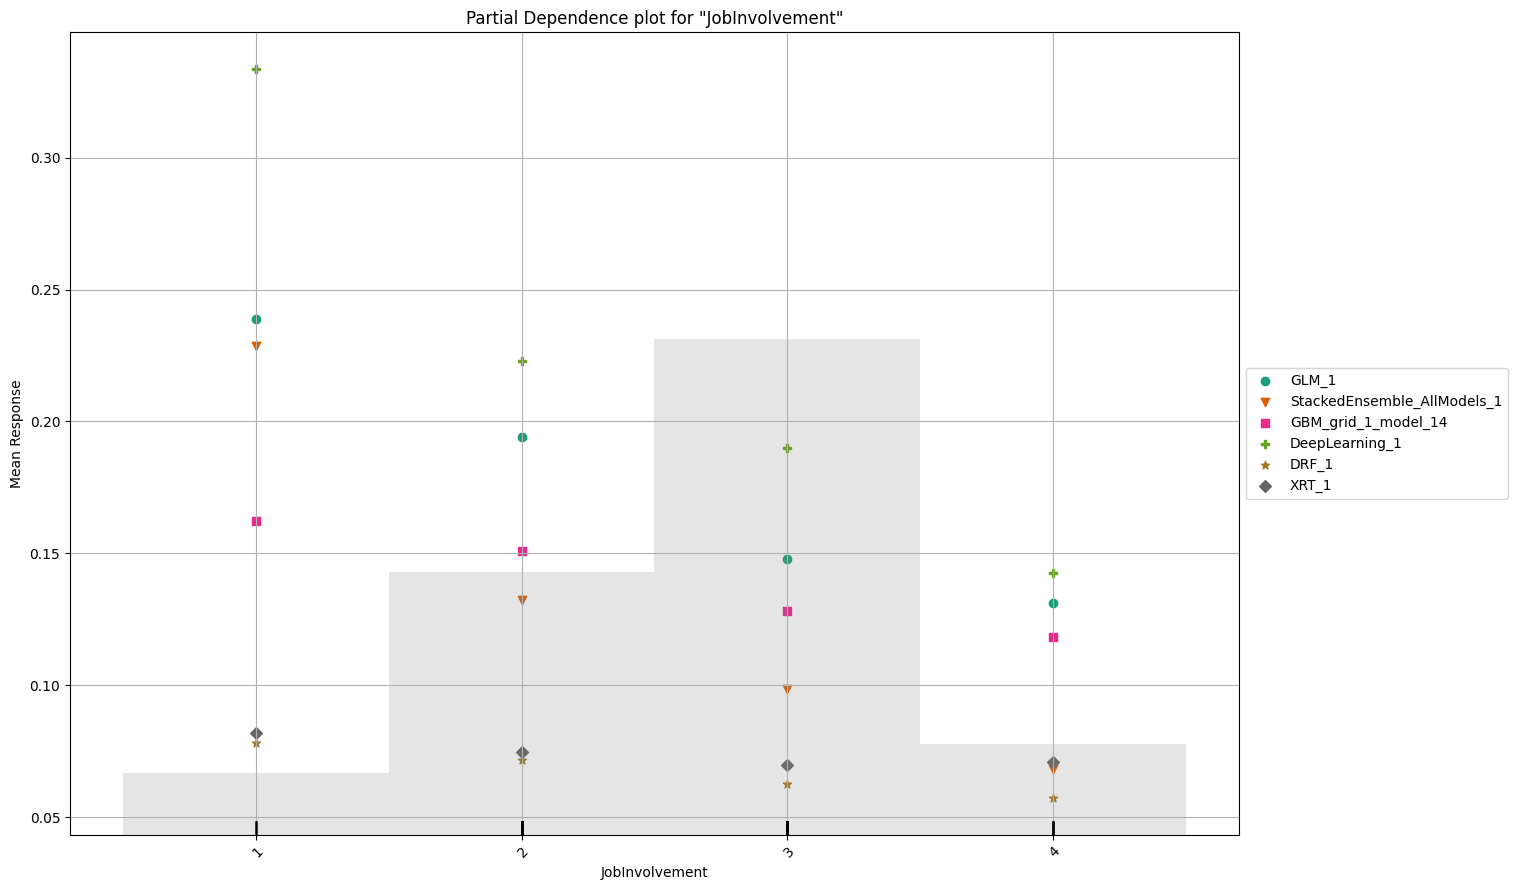

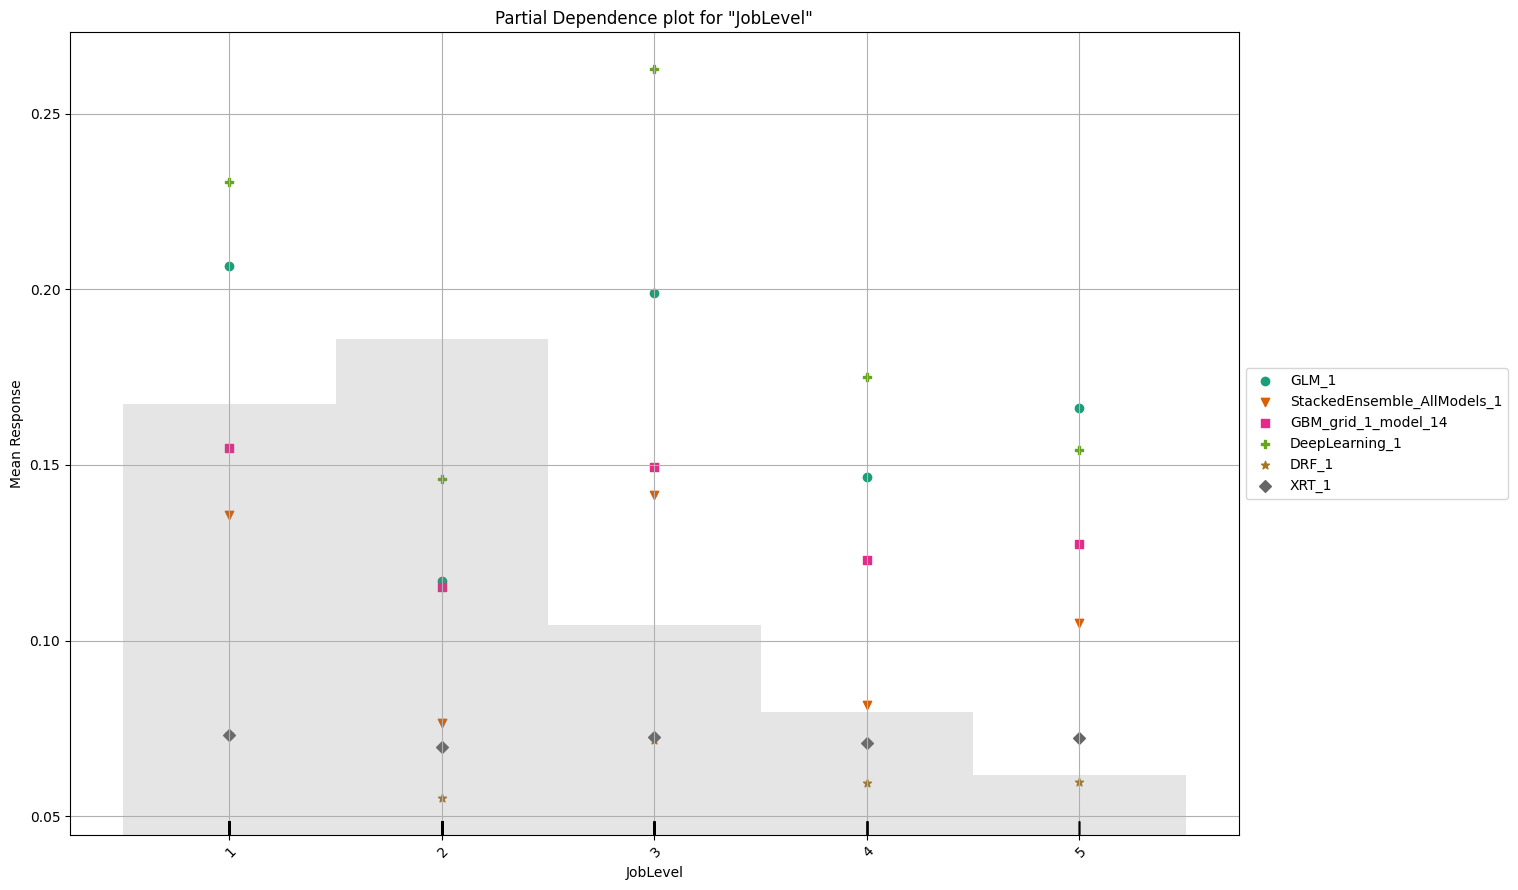

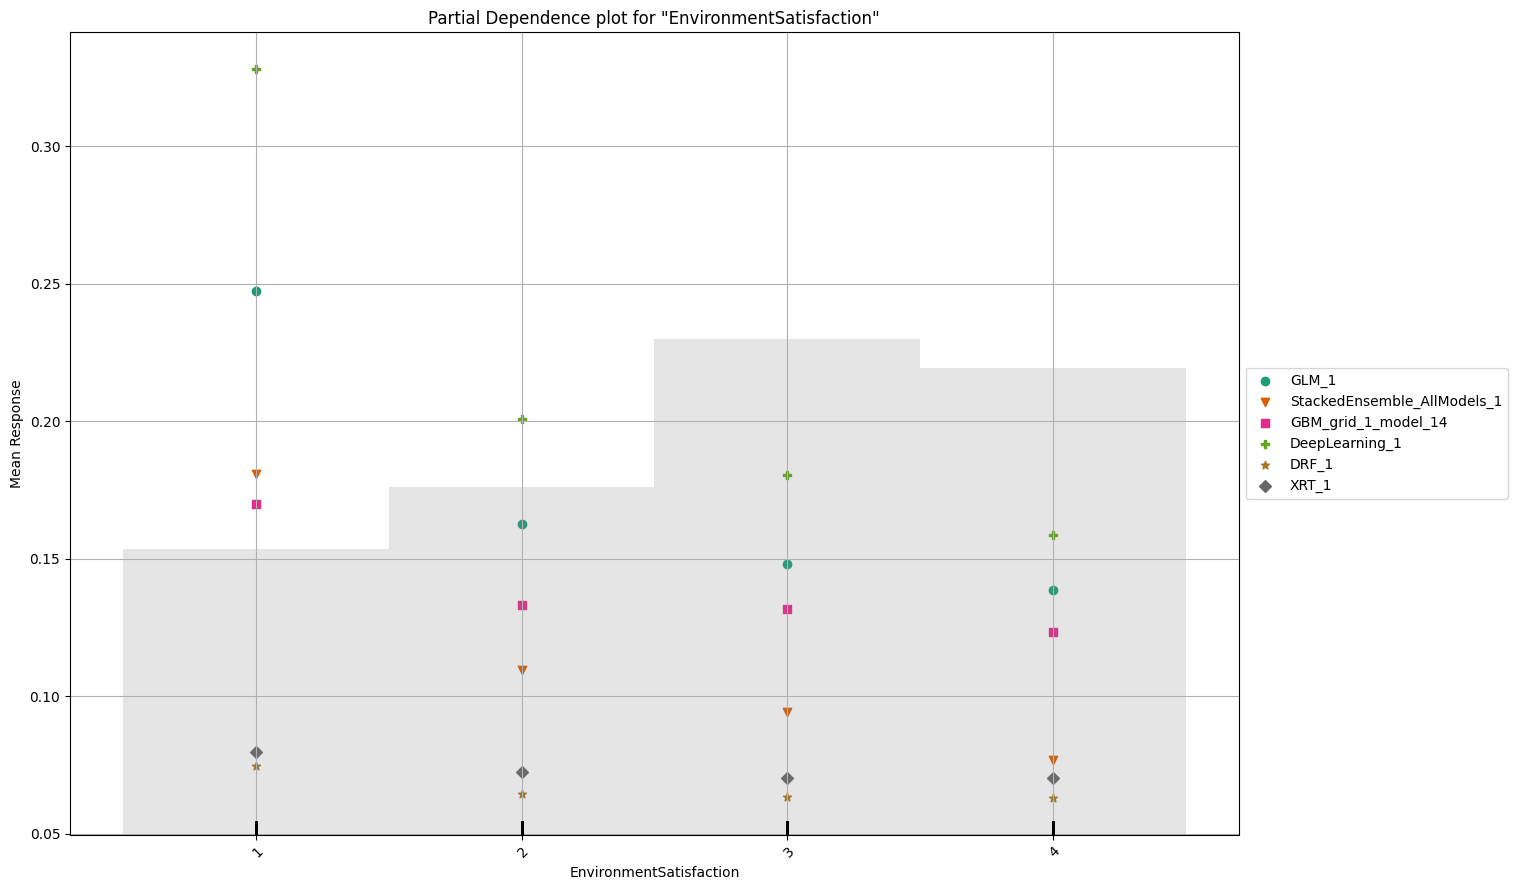

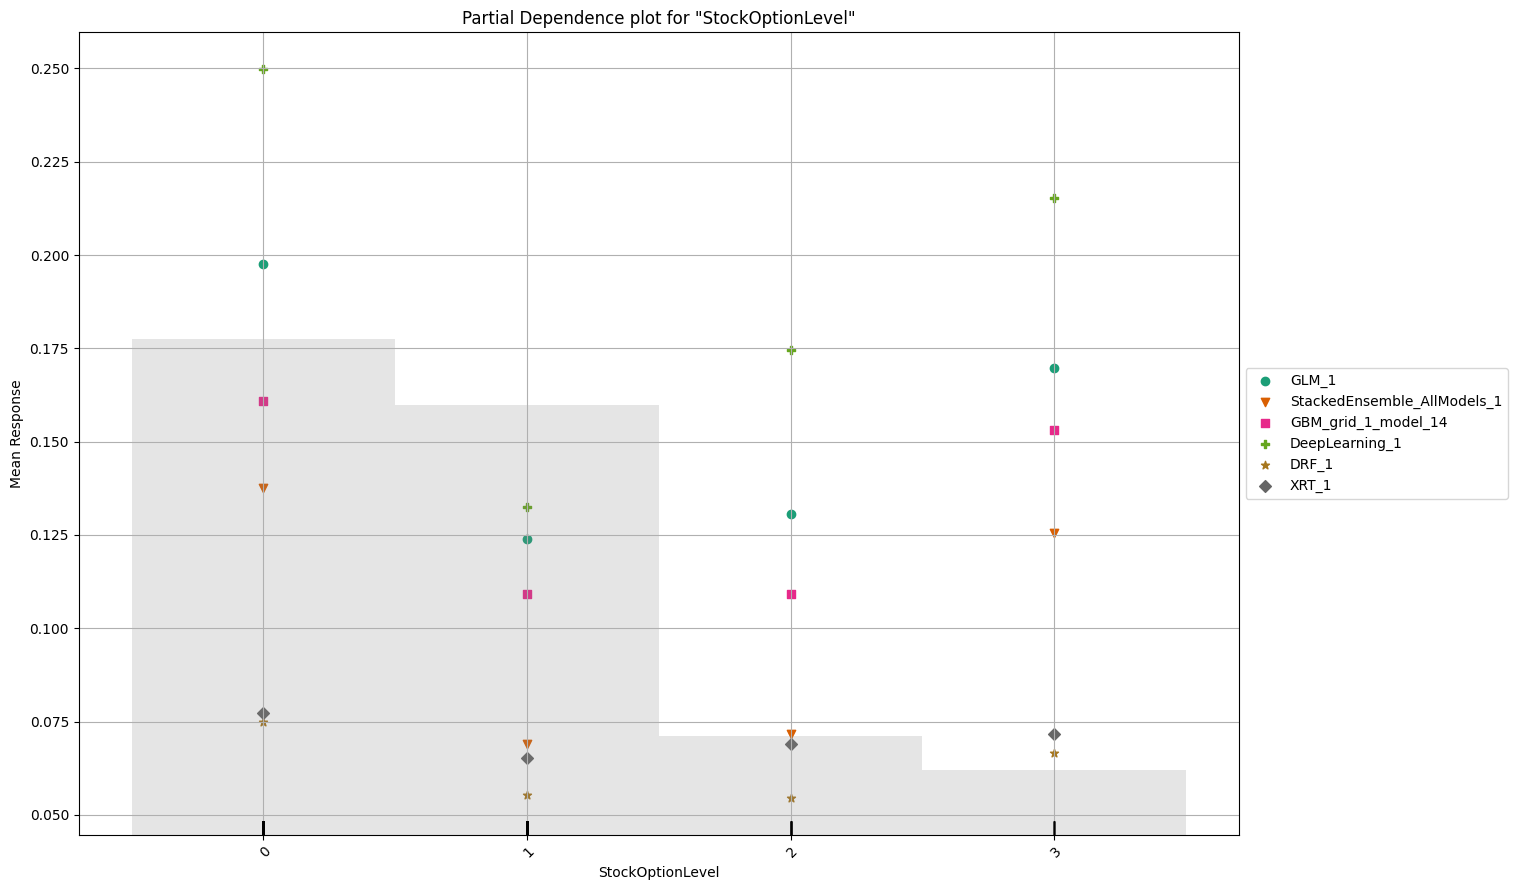

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  ---------  ------------------  -------------------------  ---------------
GLM_1_AutoML_1_20250326_214224                           0.90175    0.240586  0.745677                0.166393  0.257275  0.0661907                 442                   0.014729  GLM
StackedEnsemble_BestOfFamily_1_AutoML_1_20250326_214224  0.898483   0.23849   0.743845                0.193325  0.255765  0.0654159                1935                   0.021608  StackedEnsemble
GBM_grid_1_AutoML_1_20250326_214224_model_6              0.886422   0.277739  0.668154                0.215461  0.283231  0.0802198                 369                   0.009878  GBM
GBM_grid_1_AutoML_1_20250326_214224_model_14             0.874109   0.27928   0.639625                0.221628  0.284002  0.0806571                 274                   0.015233  GBM
GBM_grid_1_AutoML_1_20250326_214224_model_16             0.873698   0.272318  0.644445                0.232662  0.281155  0.0790483                 451                   0.016777  GBM
GBM_grid_1_AutoML_1_20250326_214224_model_4              0.871139   0.278205  0.590328                0.229441  0.288245  0.083085                  396                   0.01672   GBM
StackedEnsemble_AllModels_1_AutoML_1_20250326_214224     0.86849    0.325554  0.645233                0.219367  0.28153   0.079259                 4391                   0.106391  StackedEnsemble
DeepLearning_grid_2_AutoML_1_20250326_214224_model_10    0.862048   1.05641   0.648384                0.205387  0.300136  0.0900818               18604                   0.040992  DeepLearning
DeepLearning_grid_3_AutoML_1_20250326_214224_model_2     0.862025   0.686006  0.607894                0.240817  0.306075  0.0936816                9148                   0.025255  DeepLearning
GBM_grid_1_AutoML_1_20250326_214224_model_11             0.861842   0.283633  0.614755                0.239515  0.287717  0.0827813                 247                   0.01331   GBM
DeepLearning_grid_1_AutoML_1_20250326_214224_model_9     0.861819   0.840302  0.637316                0.184279  0.301173  0.0907053                4313                   0.020816  DeepLearning
GBM_1_AutoML_1_20250326_214224                           0.861705   0.275035  0.616579                0.263843  0.283403  0.0803174                1077                   0.012919  GBM
GBM_grid_1_AutoML_1_20250326_214224_model_19             0.857456   0.285961  0.589114                0.208333  0.288105  0.0830043                 308                   0.011051  GBM
DeepLearning_grid_3_AutoML_1_20250326_214224_model_3     0.85604    1.04051   0.58374                 0.243078  0.317737  0.100957                 5448                   0.028006  DeepLearning
GBM_grid_1_AutoML_1_20250326_214224_model_3              0.856017   0.283192  0.603773                0.228139  0.289368  0.0837339                 365                   0.012438  GBM
DeepLearning_1_AutoML_1_20250326_214224                  0.854921   0.328465  0.654363                0.239789  0.314399  0.0988464                 343                   0.012534  DeepLearning
DeepLearning_grid_2_AutoML_1_20250326_214224_model_9     0.854761   1.12092   0.630096                0.23787   0.312009  0.0973499                4256                   0.027961  DeepLearning
DeepLearning_grid_3_AutoML_1_20250326_214224_model_4     0.854486   0.992601  0.57226                 0.190241  0.316867  0.100405                18721                   0.024377  DeepLearning
DeepLearning_grid_3_AutoML_1_20250326_214224_model_5     0.853915   0.481347  0.602846                0.297286  0.305815  0.0935229                6055                   0.03231   DeepLearning
GBM_grid_1_AutoML_1_2025032

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_1_AutoML_1_20250326_214224

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3566176385631843
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      364  20   0.0521   (20.0/384.0)
1      16   41   0.2807   (16.0/57.0)
Total  380  61   0.0816   (36.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

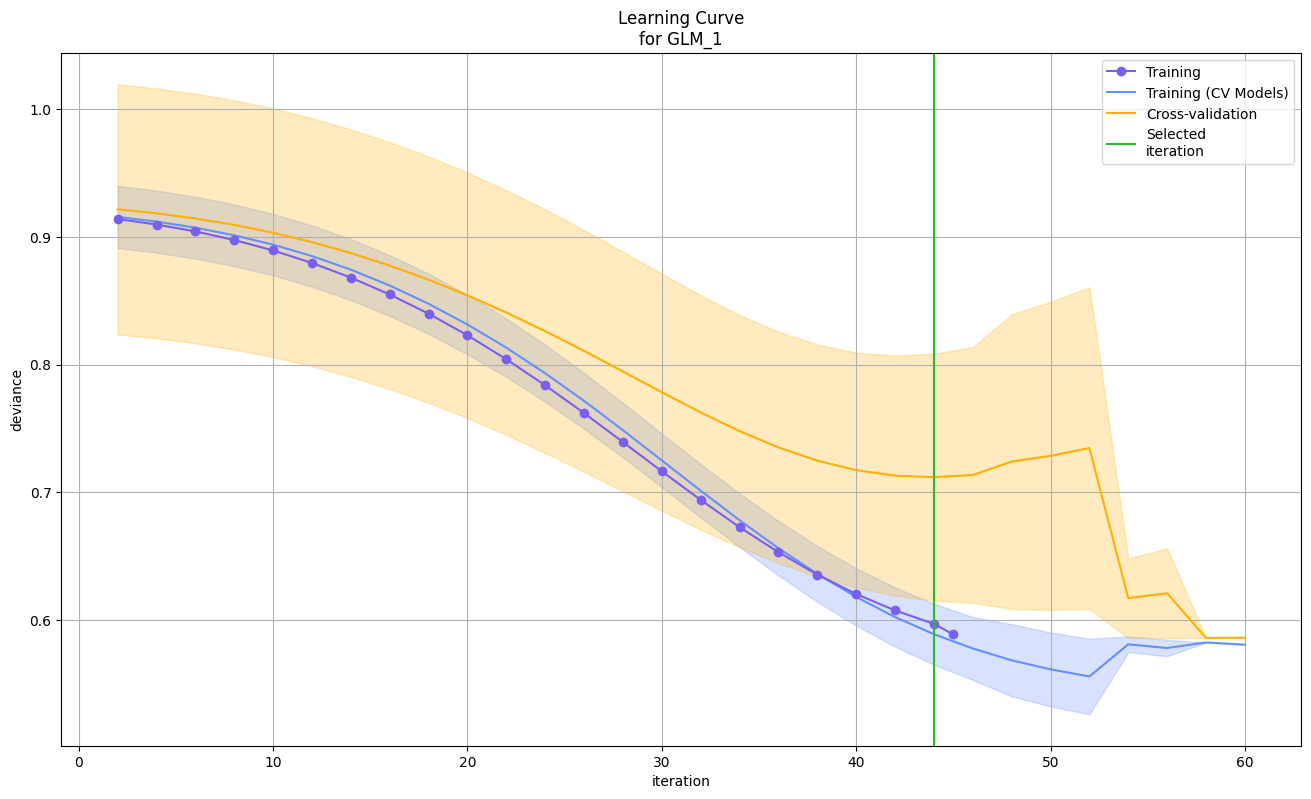

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

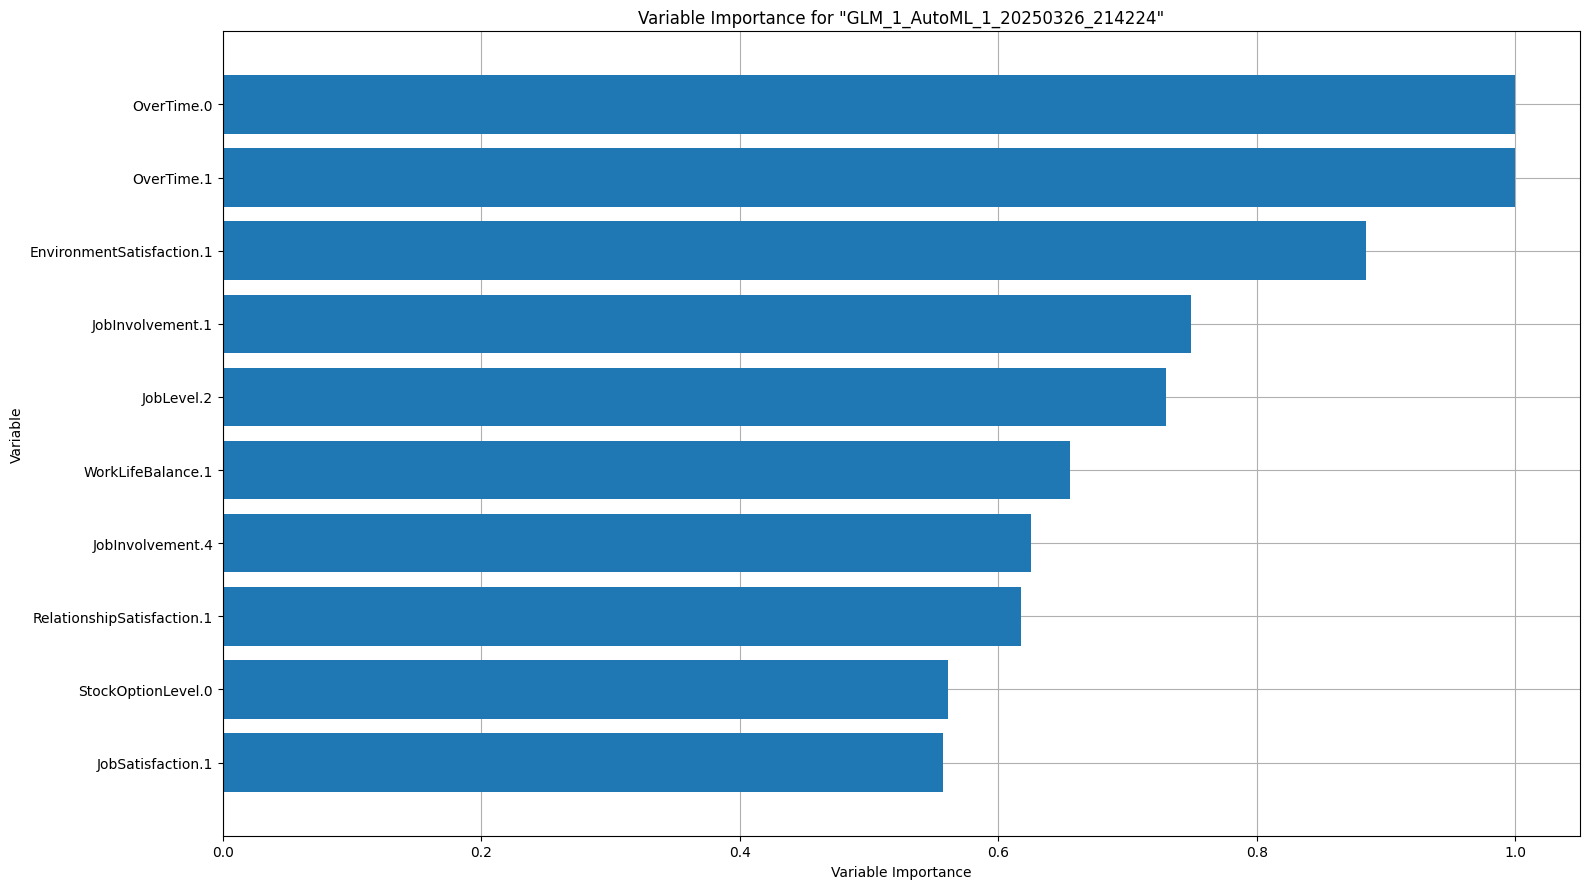

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

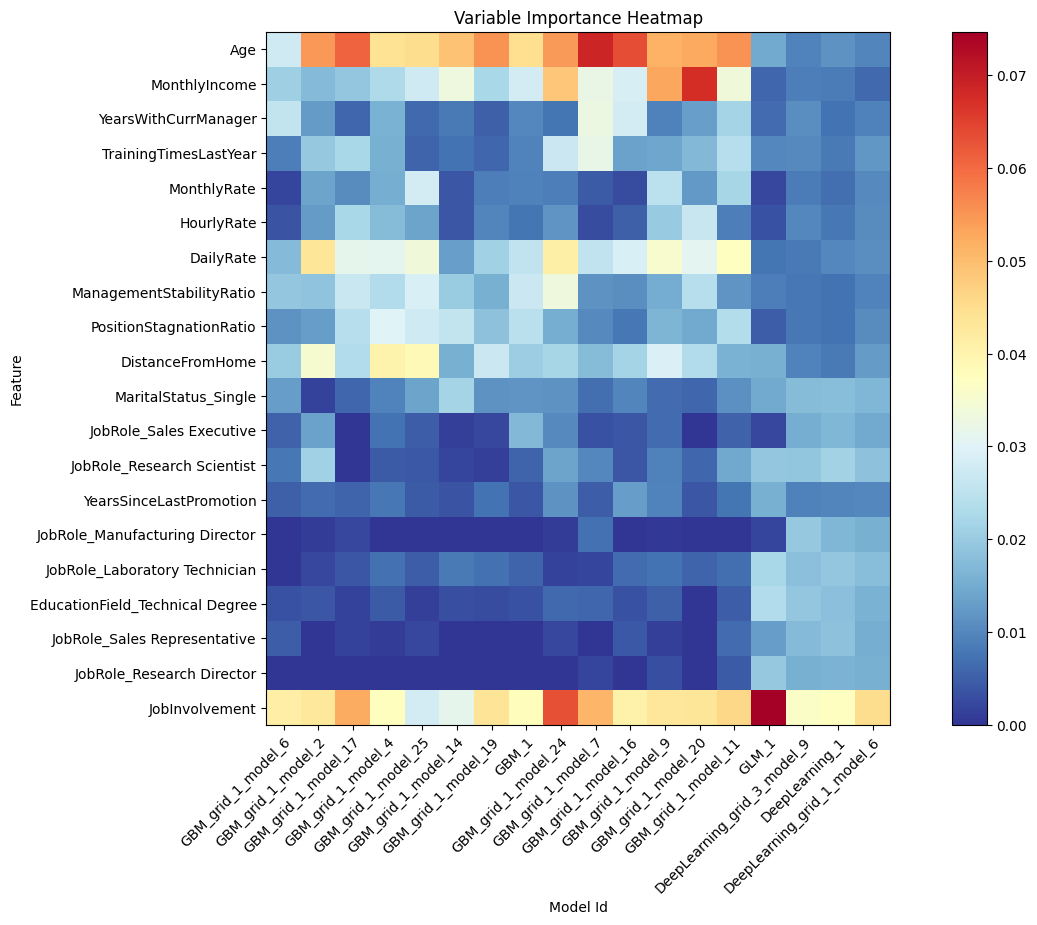

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

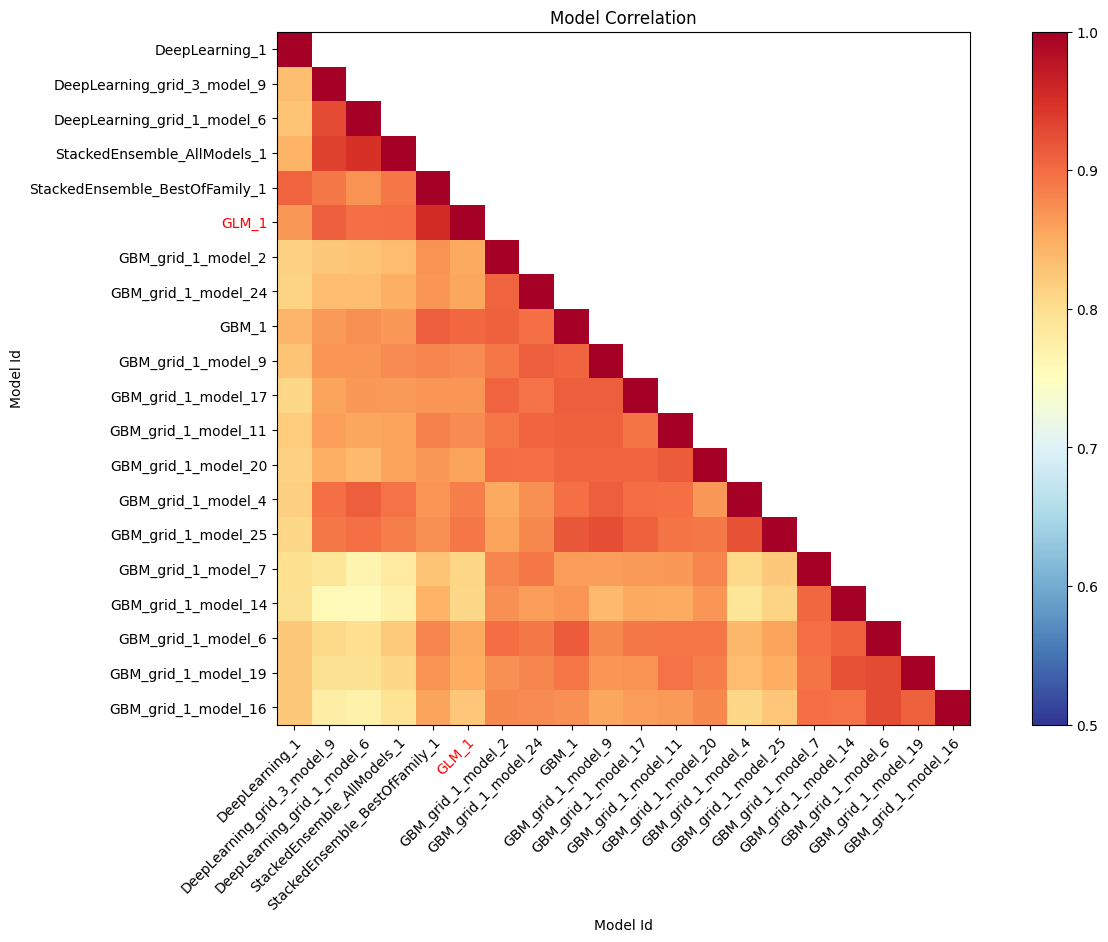

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

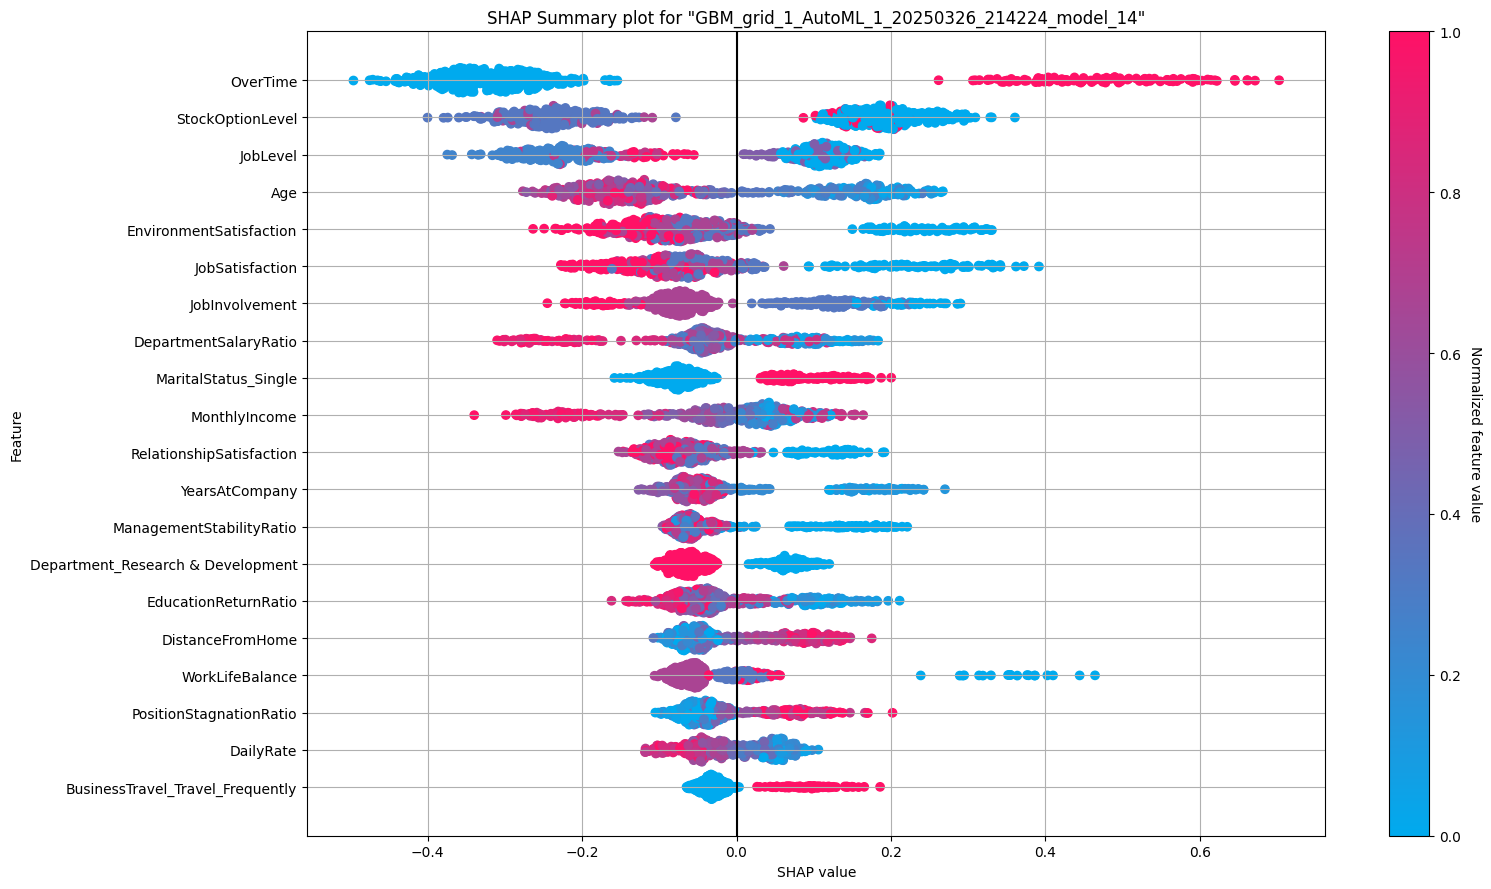

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

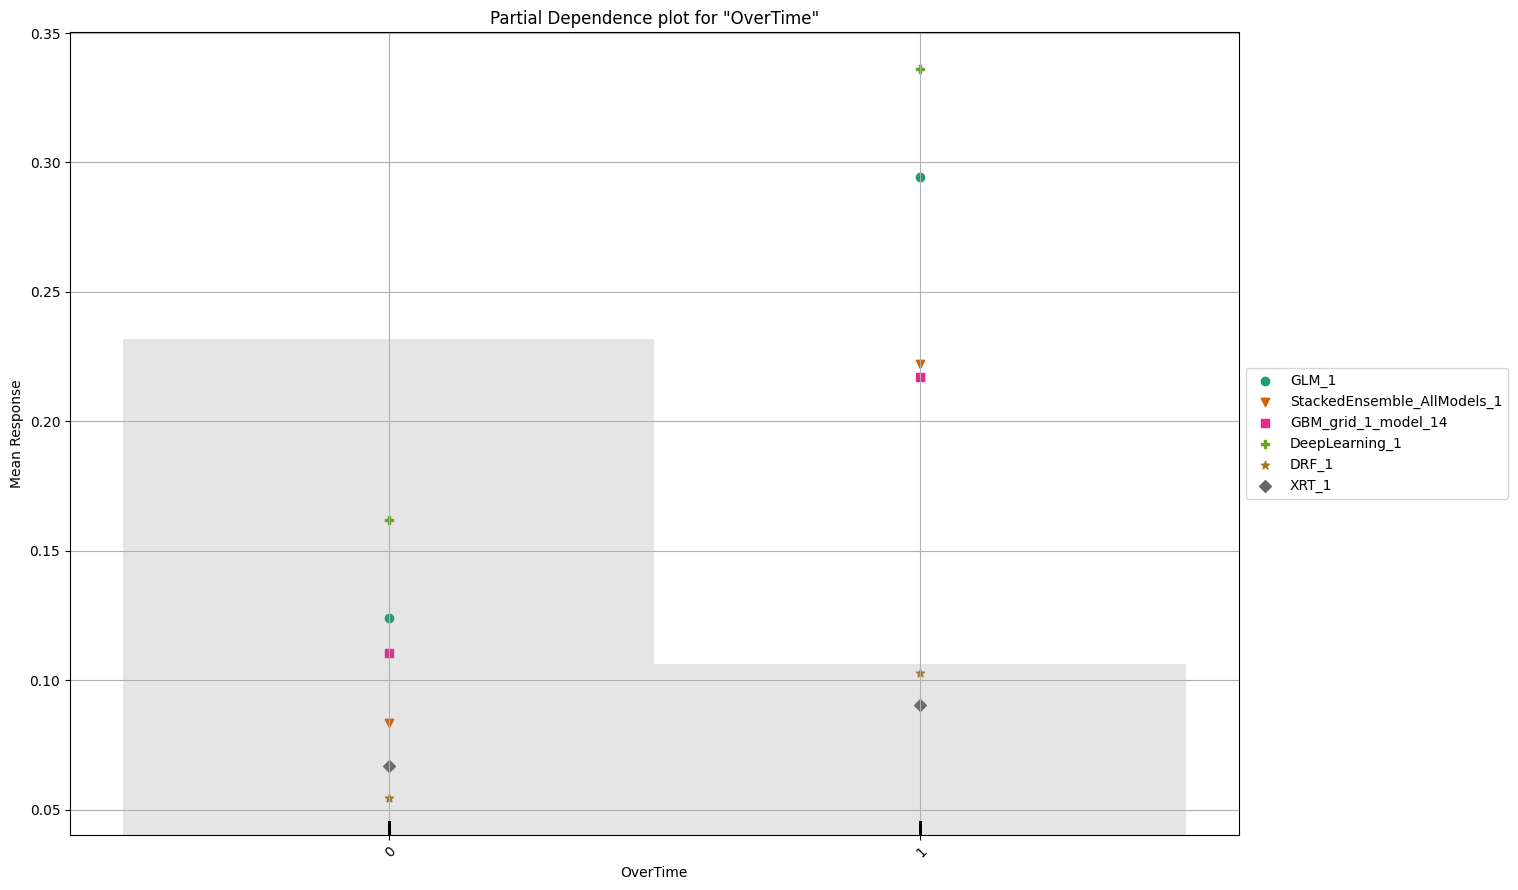

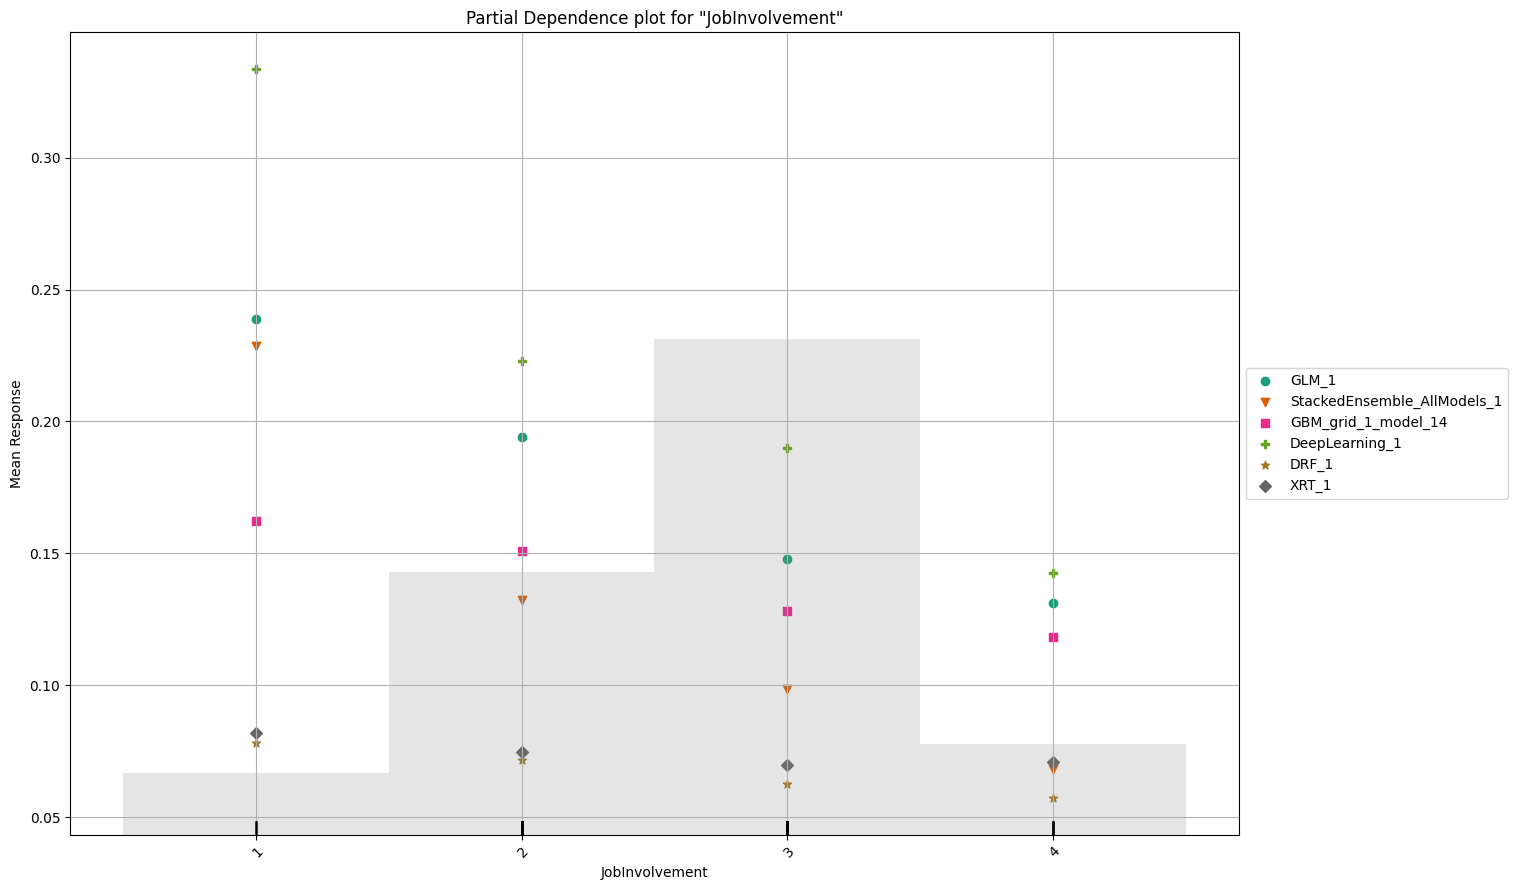

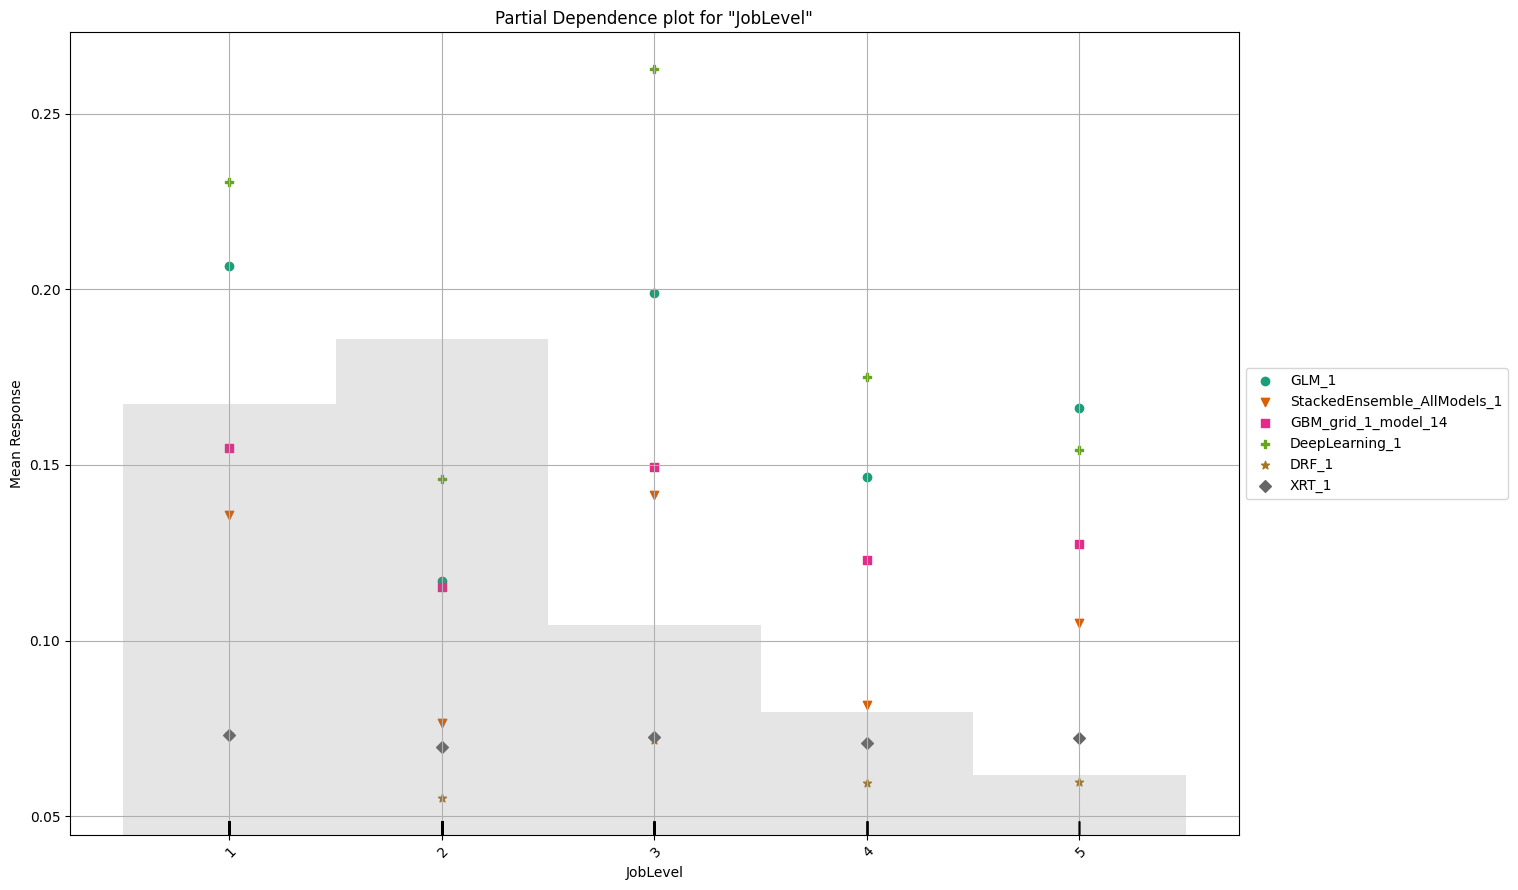

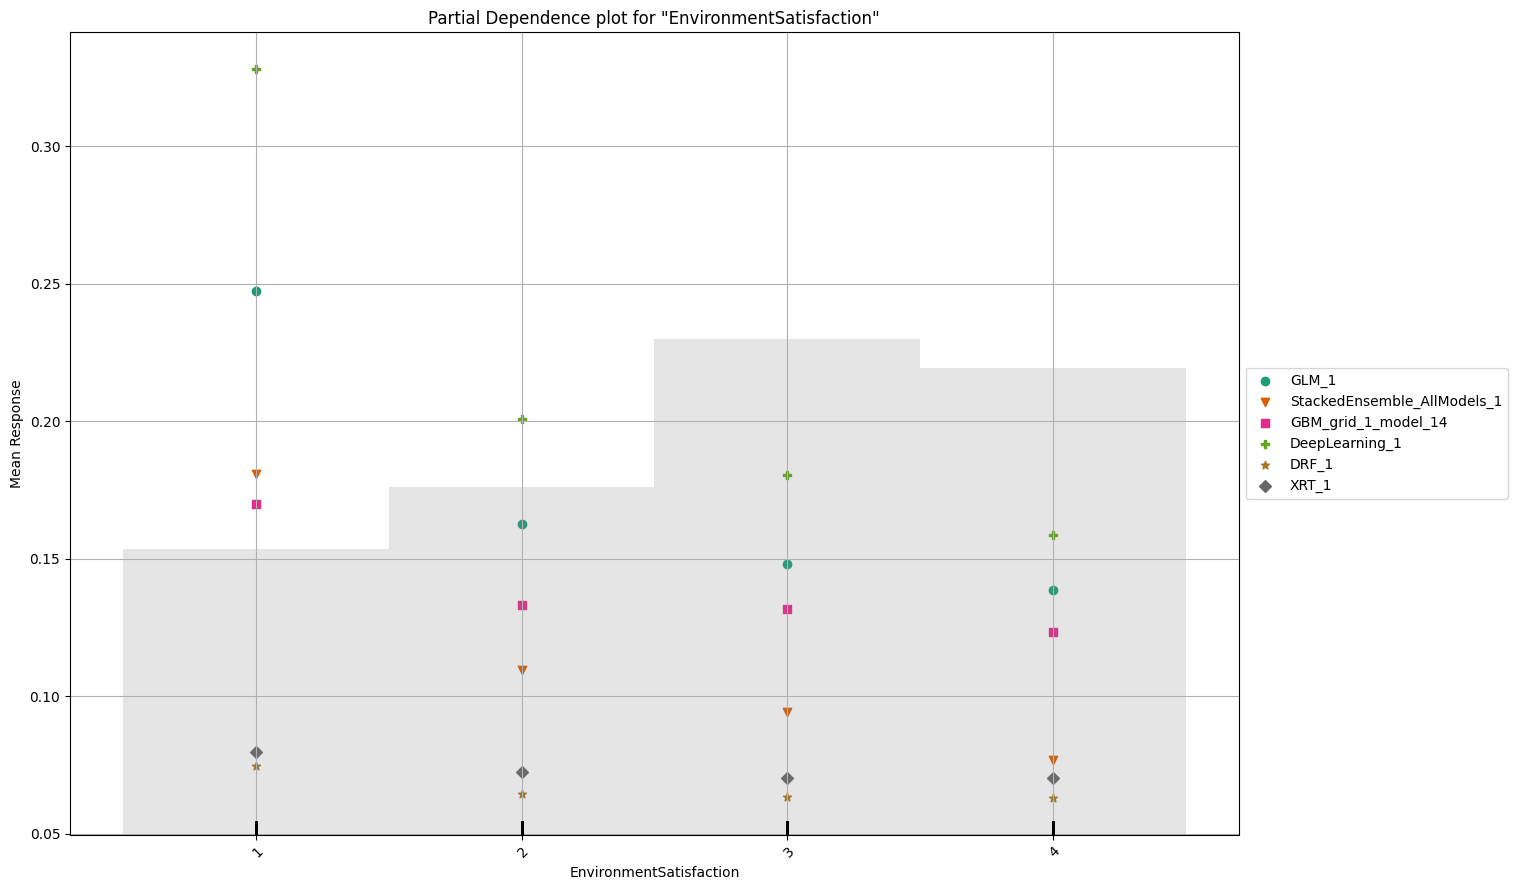

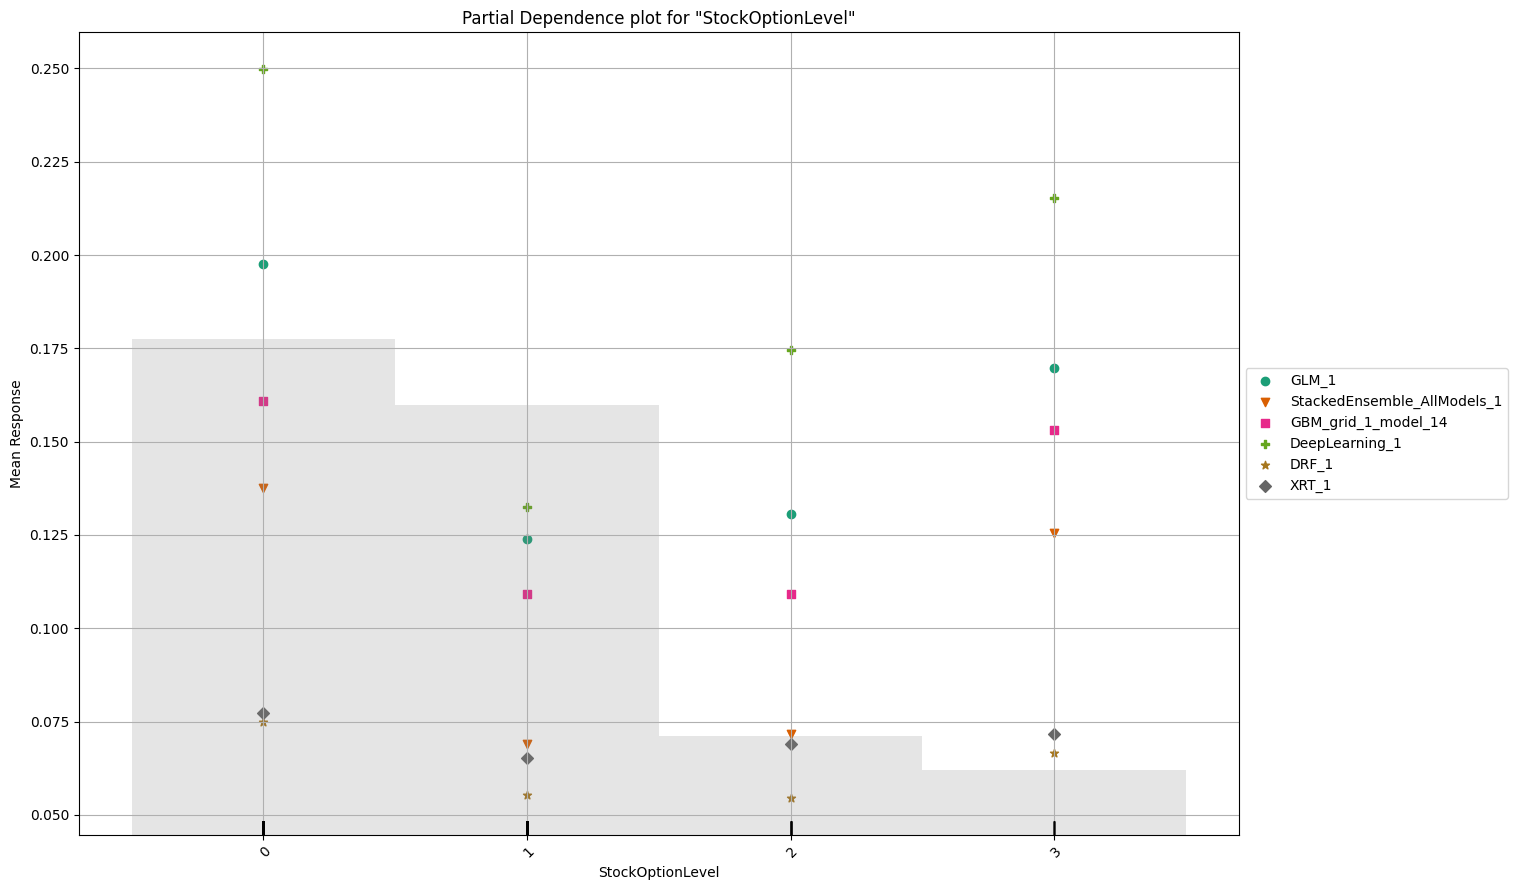

In [15]:
# Leaderboard based on Test results & comparison of models
aml.explain(test)

In [16]:
# Leaderboard for test performance
test_lb = h2o.make_leaderboard(aml, test, sort_metric="logloss")
test_lb.head(rows=test_lb.nrows)  # Print all rows instead of default (10 rows)

model_id                                                   logloss       auc     aucpr    mean_per_class_error      rmse        mse
-------------------------------------------------------  ---------  --------  --------  ----------------------  --------  ---------
StackedEnsemble_BestOfFamily_1_AutoML_1_20250326_214224   0.23849   0.898483  0.743845                0.193325  0.255765  0.0654159
GLM_1_AutoML_1_20250326_214224                            0.240586  0.90175   0.745677                0.166393  0.257275  0.0661907
GBM_grid_1_AutoML_1_20250326_214224_model_16              0.272318  0.873698  0.644445                0.232662  0.281155  0.0790483
GBM_1_AutoML_1_20250326_214224                            0.275035  0.861705  0.616579                0.263843  0.283403  0.0803174
GBM_grid_1_AutoML_1_20250326_214224_model_6               0.277739  0.886422  0.668154                0.215461  0.283231  0.0802198
GBM_grid_1_AutoML_1_20250326_214224_model_4               0.278205  0.871139  0.590328                0.229441  0.288245  0.083085
GBM_grid_1_AutoML_1_20250326_214224_model_14              0.27928   0.874109  0.639625                0.221628  0.284002  0.0806571
GBM_grid_1_AutoML_1_20250326_214224_model_3               0.283192  0.856017  0.603773                0.228139  0.289368  0.0837339
GBM_grid_1_AutoML_1_20250326_214224_model_11              0.283633  0.861842  0.614755                0.239515  0.287717  0.0827813
GBM_grid_1_AutoML_1_20250326_214224_model_19              0.285961  0.857456  0.589114                0.208333  0.288105  0.0830043
GBM_grid_1_AutoML_1_20250326_214224_model_25              0.288991  0.850055  0.542477                0.251234  0.2933    0.0860251
GBM_grid_1_AutoML_1_20250326_214224_model_20              0.288997  0.842928  0.577368                0.271313  0.290892  0.0846182
GBM_grid_1_AutoML_1_20250326_214224_model_2               0.28977   0.853733  0.577148                0.261582  0.292448  0.085526
GBM_grid_1_AutoML_1_20250326_214224_model_9               0.292732  0.846103  0.582135                0.277481  0.294529  0.0867474
GBM_grid_1_AutoML_1_20250326_214224_model_7               0.294997  0.84592   0.570092                0.26679   0.293638  0.0862232
GBM_grid_1_AutoML_1_20250326_214224_model_24              0.296348  0.846012  0.550817                0.275905  0.295265  0.0871814
GBM_grid_1_AutoML_1_20250326_214224_model_17              0.297281  0.842448  0.516844                0.272958  0.297111  0.0882747
GBM_grid_1_AutoML_1_20250326_214224_model_22              0.298779  0.843385  0.564823                0.2071    0.298578  0.0891488
GBM_3_AutoML_1_20250326_214224                            0.299738  0.835755  0.590531                0.268709  0.296908  0.0881545
GBM_grid_1_AutoML_1_20250326_214224_model_10              0.300703  0.850055  0.557958                0.283032  0.300258  0.0901549
GBM_2_AutoML_1_20250326_214224                            0.306683  0.815904  0.55773                 0.249589  0.299844  0.0899067
GBM_grid_1_AutoML_1_20250326_214224_model_23              0.306714  0.829747  0.531027                0.23273   0.301223  0.0907353
GBM_5_AutoML_1_20250326_214224                            0.310265  0.826435  0.485976                0.242188  0.304597  0.0927794
GBM_grid_1_AutoML_1_20250326_214224_model_5               0.311783  0.818622  0.503039                0.290844  0.302067  0.0912442
GBM_4_AutoML_1_20250326_214224                            0.318039  0.806698  0.516744                0.309348  0.302867  0.0917285
GBM_grid_1_AutoML_1_20250326_214224_model_18              0.320387  0.84921   0.485129                0.254797  0.312757  0.0978172
GBM_grid_1_AutoML_1_20250326_214224_model_1               0.321474  0.795938  0.464064                0.287281  0.307905  0.0948058
GBM_grid_1_AutoML_1_20250326_214224_model_12              0.324055  0.799982  0.50118                 0.327851  0.305502  0.0933316
StackedEnsemble_AllModels_1_AutoML_1_20250

In [17]:
# Getting best model for test
test_best_model_ID = test_lb[0, 0]
test_best_model = h2o.get_model(test_best_model_ID)

# Display Training and CV performance
test_best_model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_1_20250326_214224


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       3/5
# GBM base models (used / total)           1/1
# GLM base models (used / total)           1/1
# DeepLearning base models (used / total)  1/1
# DRF base models (used / total)           0/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07482419906954232
RMSE: 0.2735401233266197
LogLoss: 0.26102491005841916
AUC: 0.9187868080094228
AUCPR: 0.8029019565581137
Gini: 0.8375736160188456
Null degrees of freedom: 1028
Residual degrees of freedom: 1025
Null deviance: 954.1163856693311
Residual deviance: 537.1892649002266
AIC: 545.1892649002266

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.370920977082323
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      812  37   0.0436   (37.0/849.0)
1      53   127  0.2944   (53.0/180.0)
Total  865  164  0.0875   (90.0/1029.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370921     0.738372  133
max f2                       0.219661     0.769231  201
max f0point5                 0.491592     0.800654  94
max accuracy                 0.434703     0.913508  111
max precision                0.984073     1         0
max recall                   0.0191937    1         375
max specificity              0.984073     1         0
max absolute_mcc             0.370921     0.687071  133
max min_per_class_accuracy   0.219661     0.850412  201
max mean_per_class_accuracy  0.219661     0.852984  201
max tns                      0.984073     849       0
max fns                      0.984073     179       0
max fps                      0.00133694   849       399
max tps                      0.0191937    180       375
max tnr                      0.984073     1         0
max fnr                      0.984073     0.994444  0
max fpr                      0.00133694   1         399
max tpr                      0.0191937    1         375

Gains/Lift Table: Avg response rate: 17.49 %, avg score: 18.30 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01069                     0.904243           5.71667    5.71667            1                0.944544    1                           0.944544            0.0611111       0.0611111                  471.667   471.667            0.0611111
2        0.0204082                   0.834996           5.71667    5.71667            1                0.858369    1                           0.903508            0.0555556       0.116667                   471.667   471.667            0.116667
3        0.0301263                   0.762115           5.145      5.53226            0.9              0.797094    0.967742                    0.869181            0.05            0.166667                   414.5     453.226            0.165489
4        0.0408163                   0.742707           5.71667    5.5805

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_1_AutoML_1_20250326_214224

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4769020202393899
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      377  7    0.0182   (7.0/384.0)
1      21   36   0.3684   (21.0/57.0)
Total  398  43   0.0635   (28.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

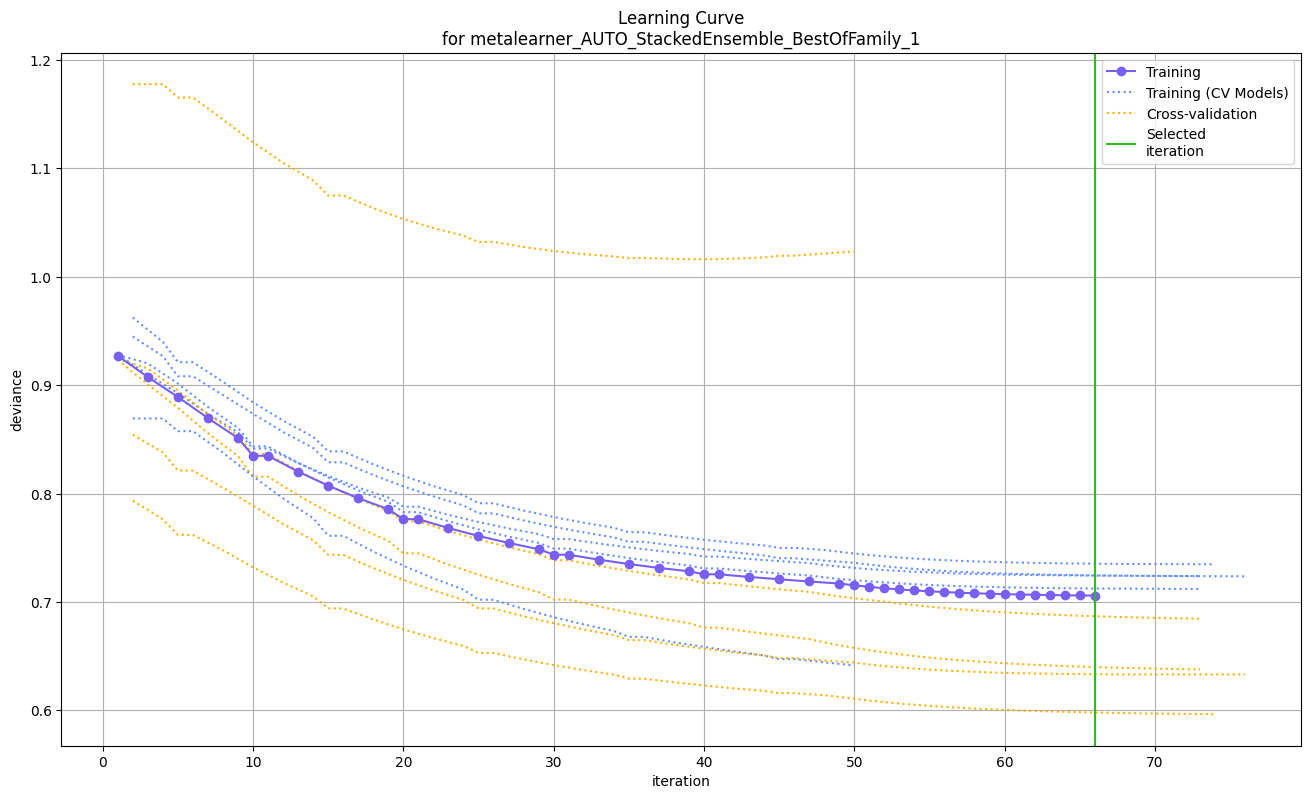

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

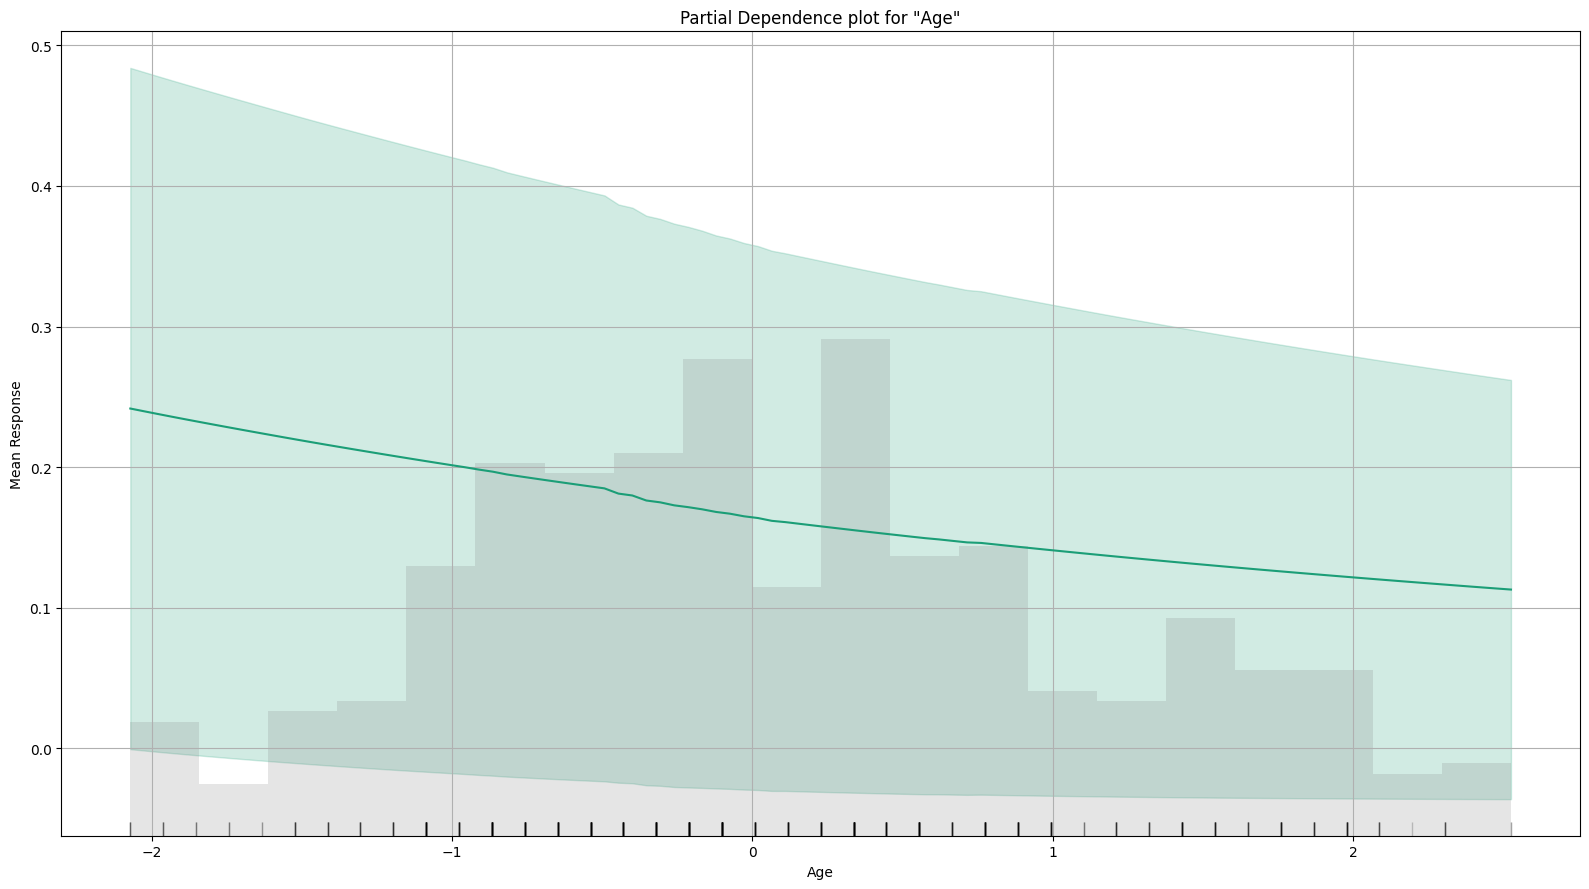

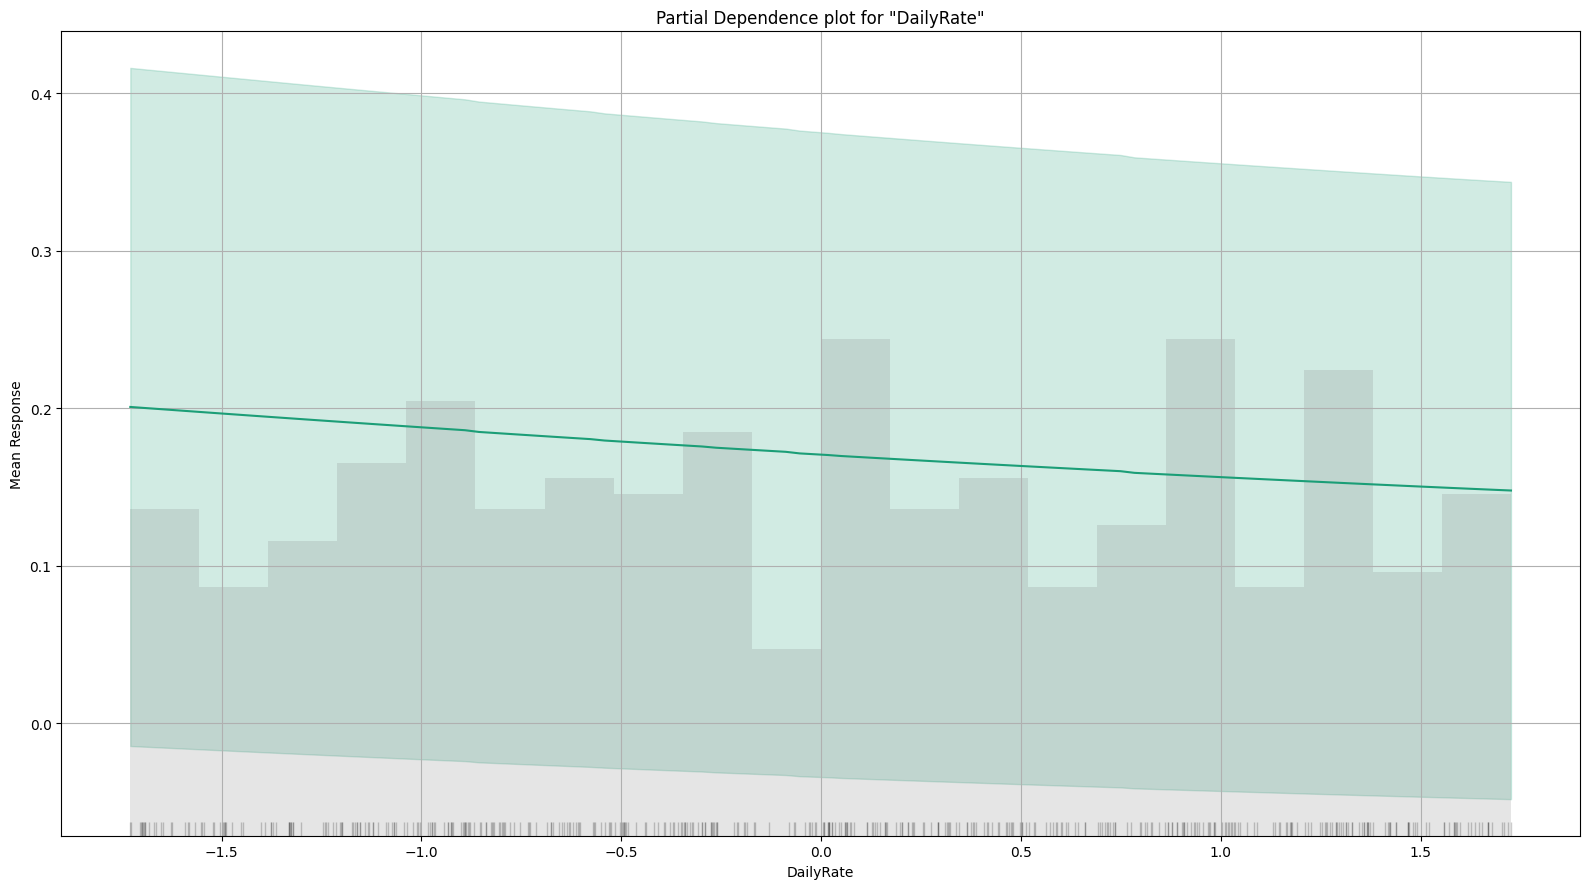

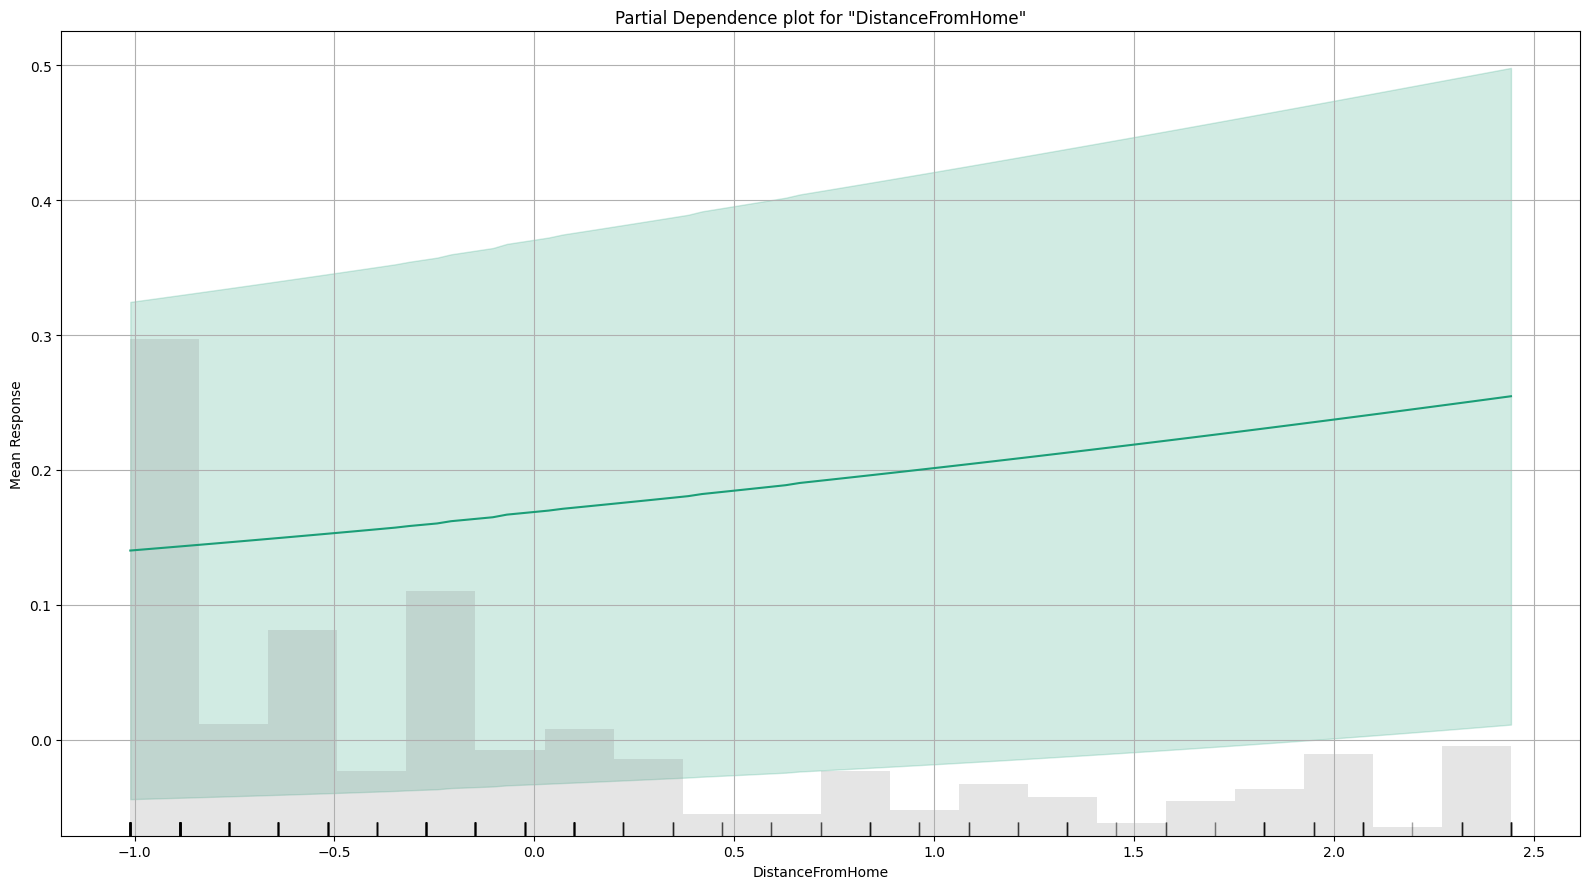

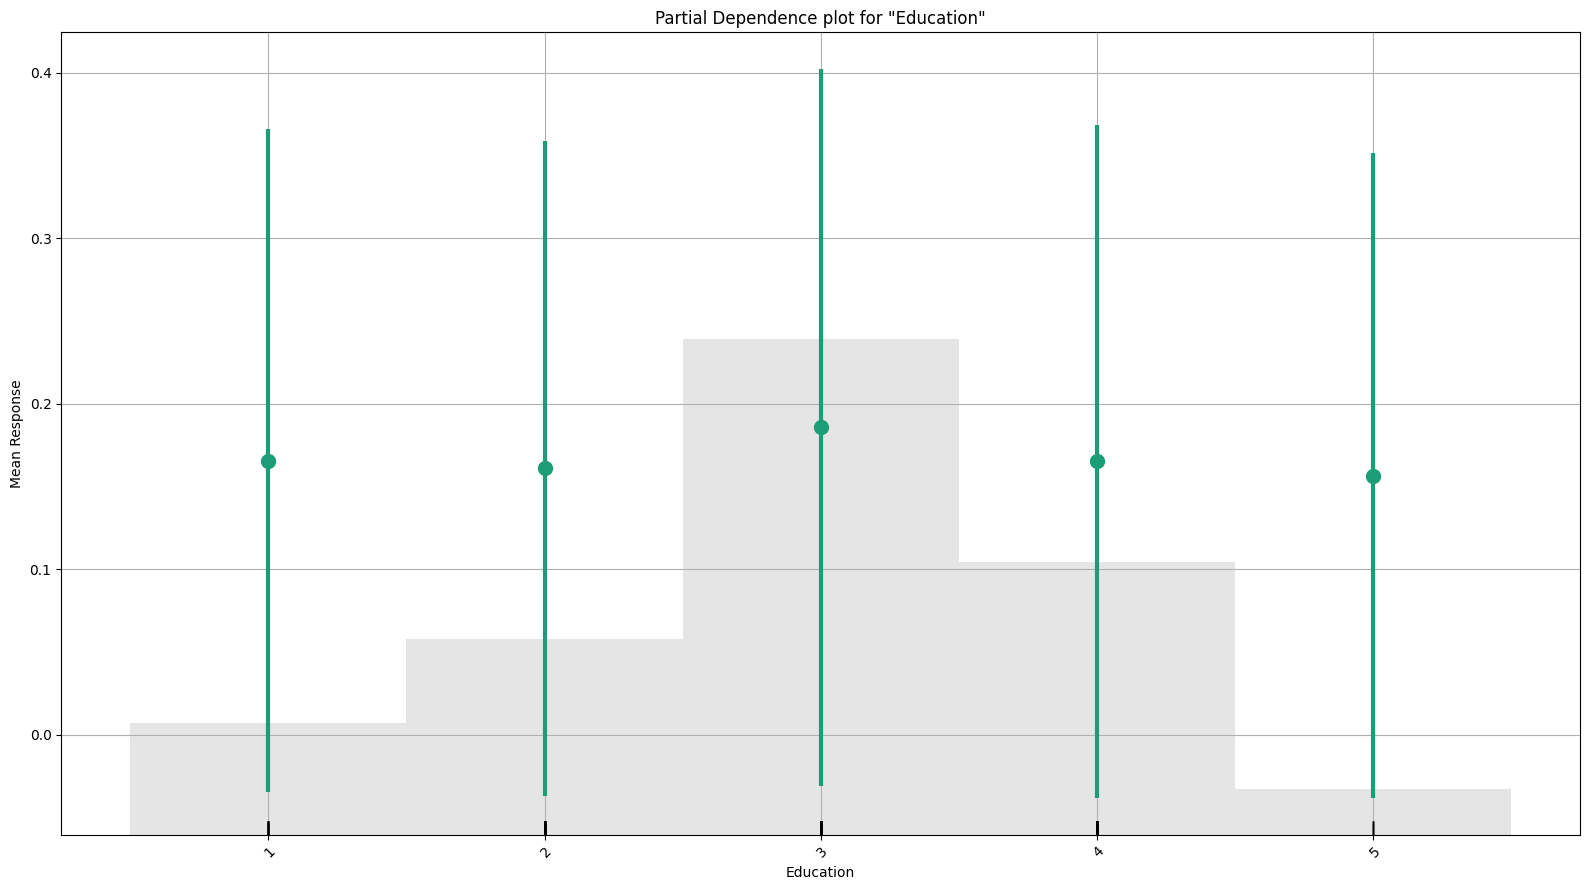

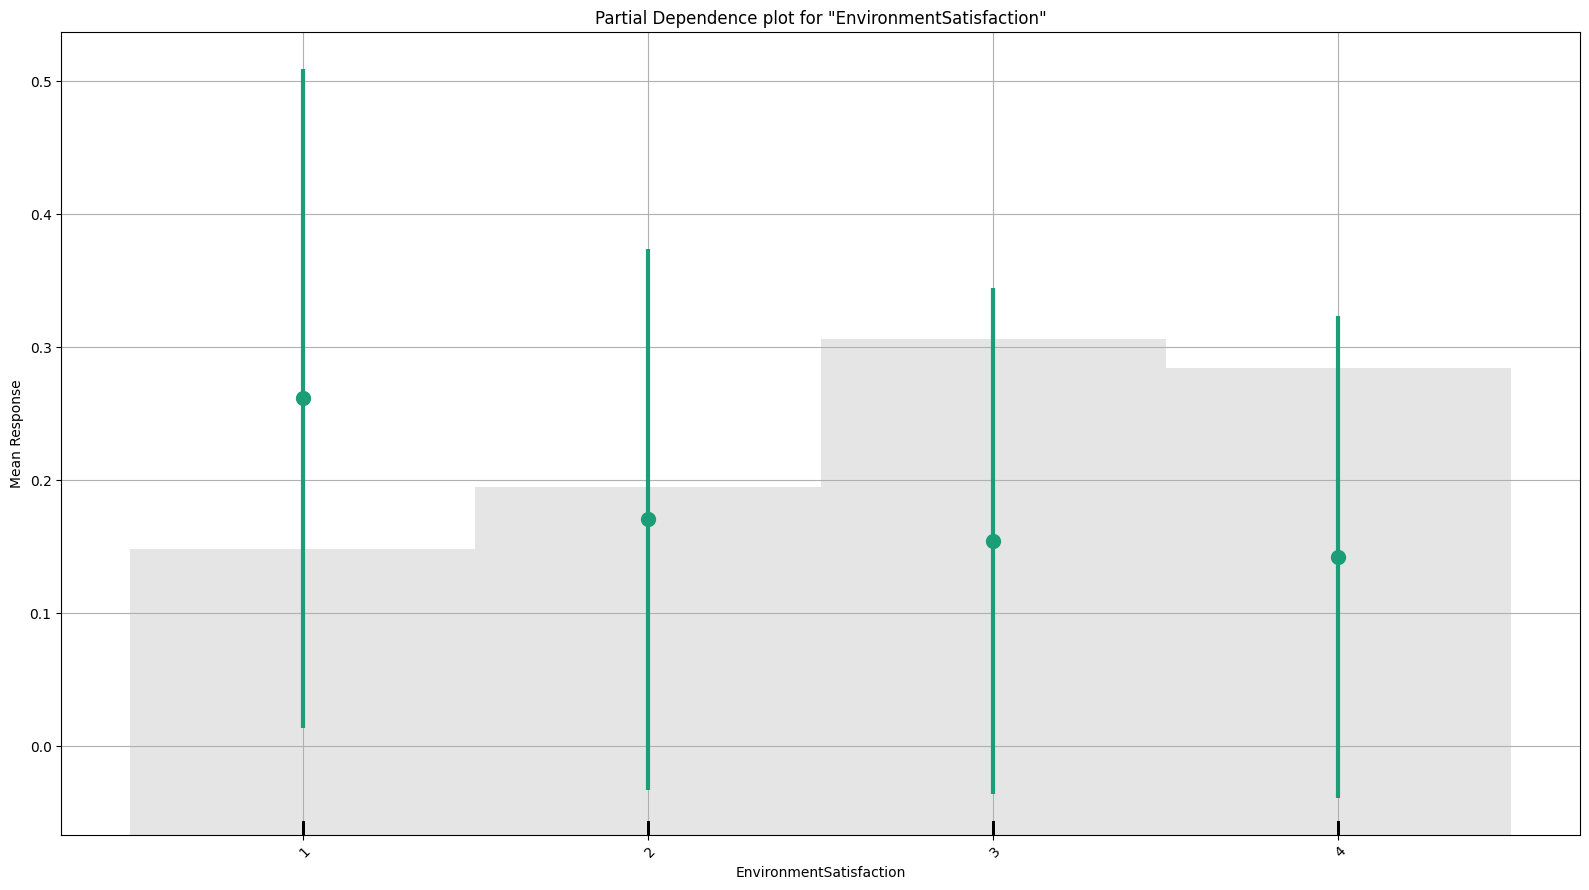

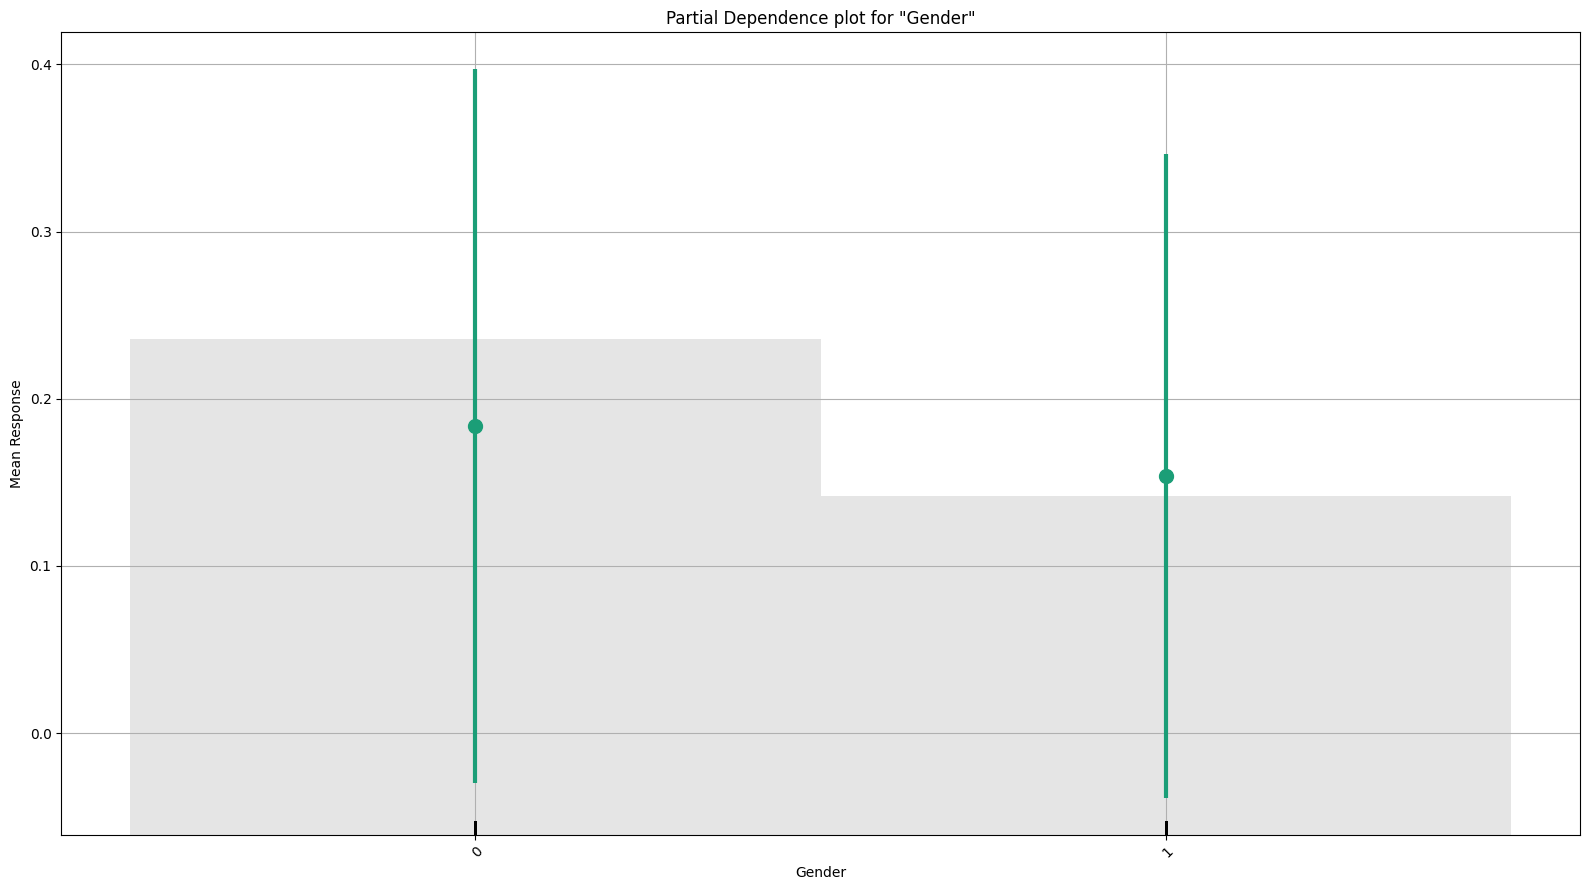

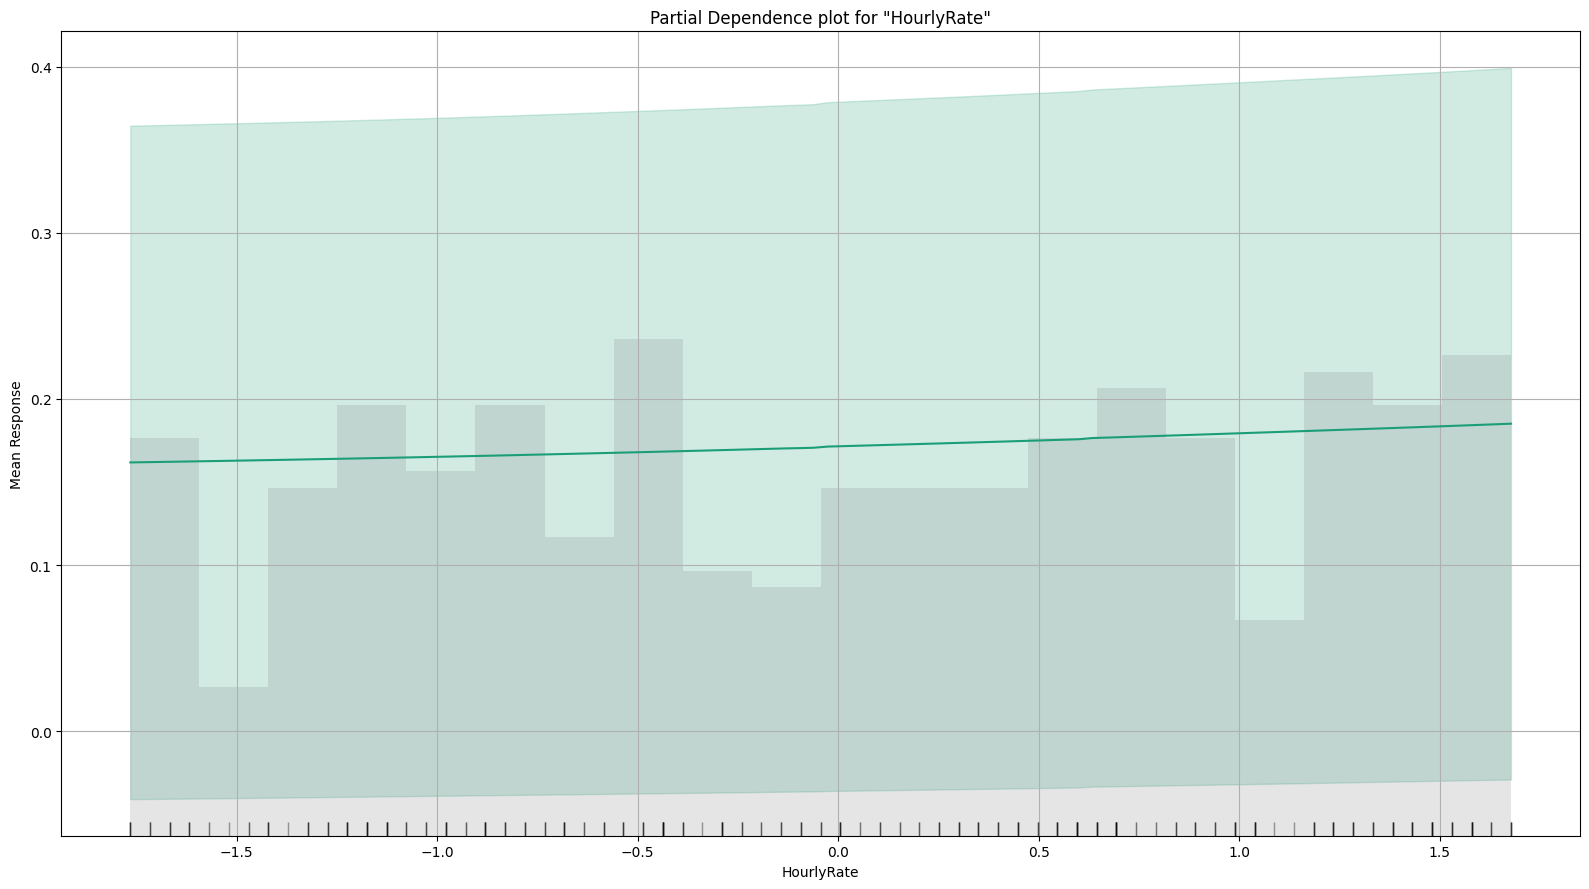

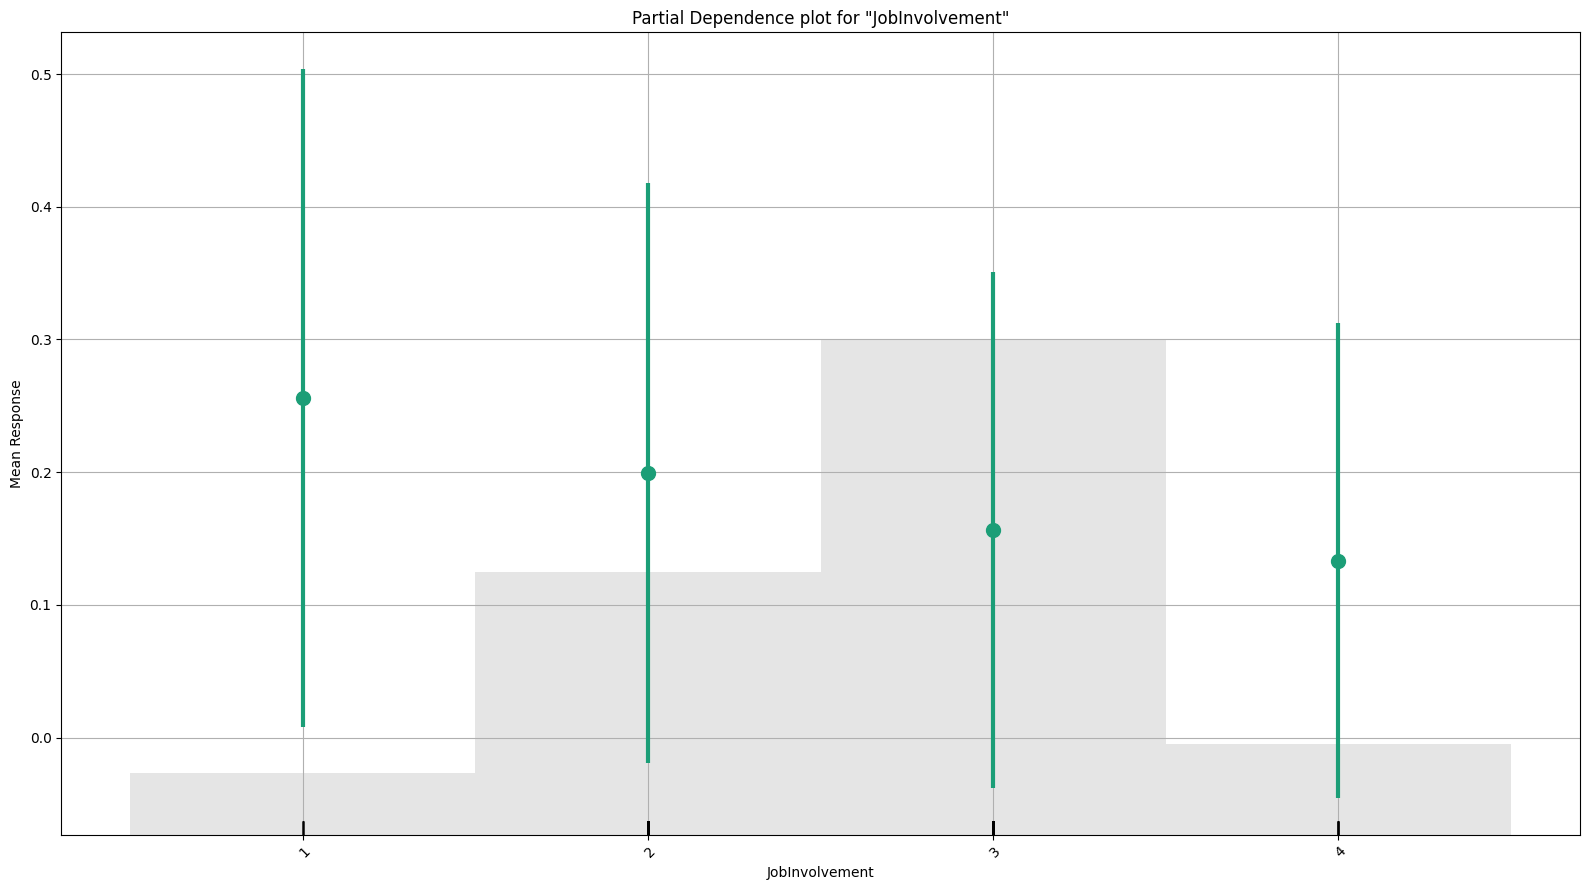

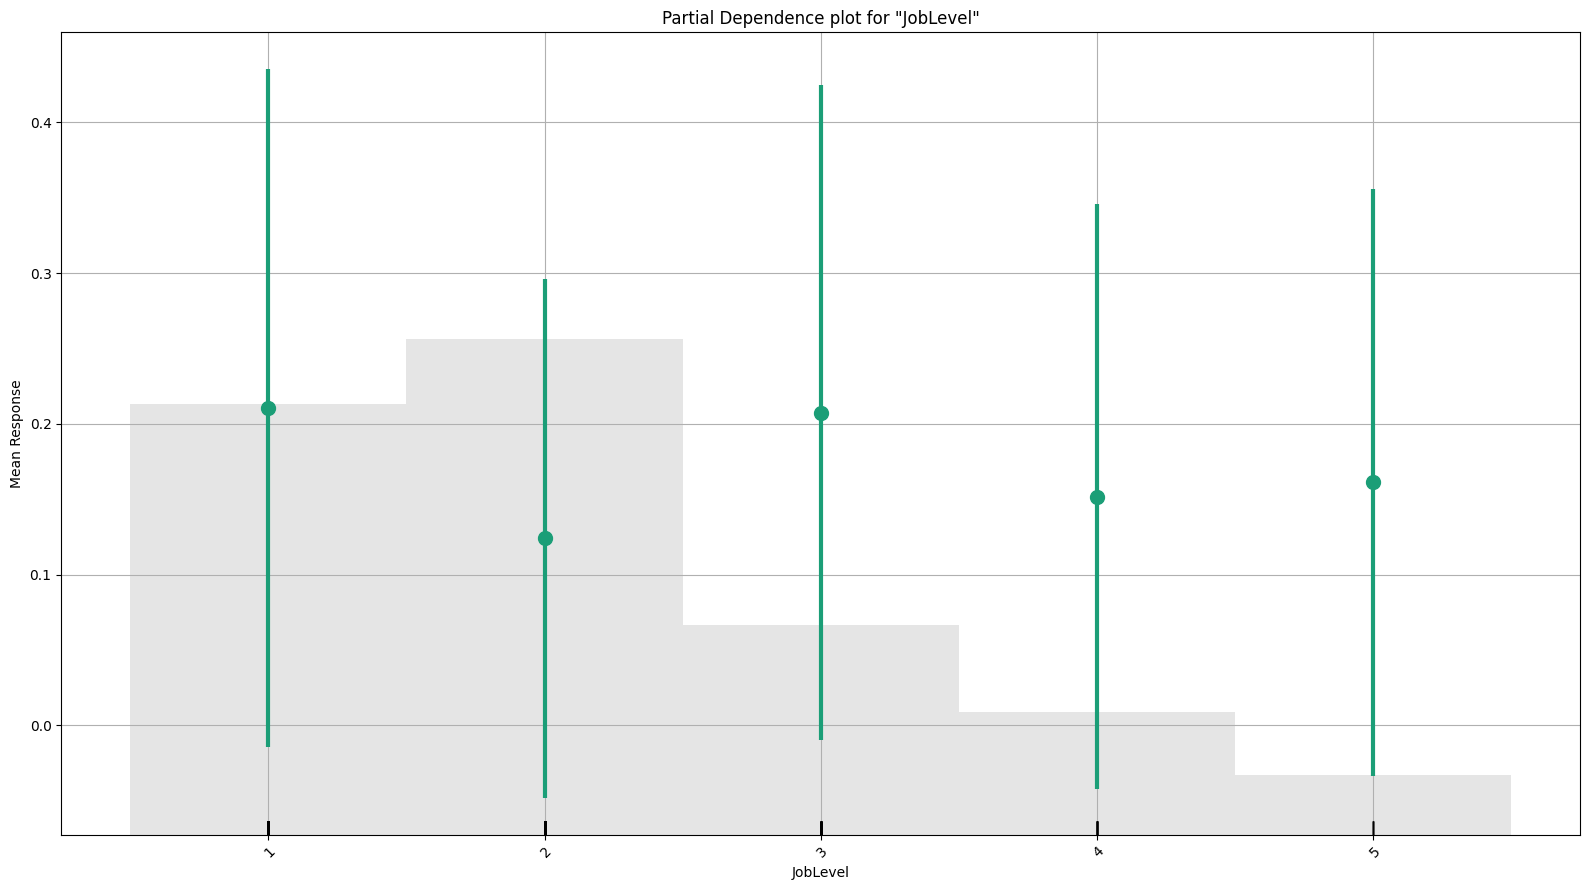

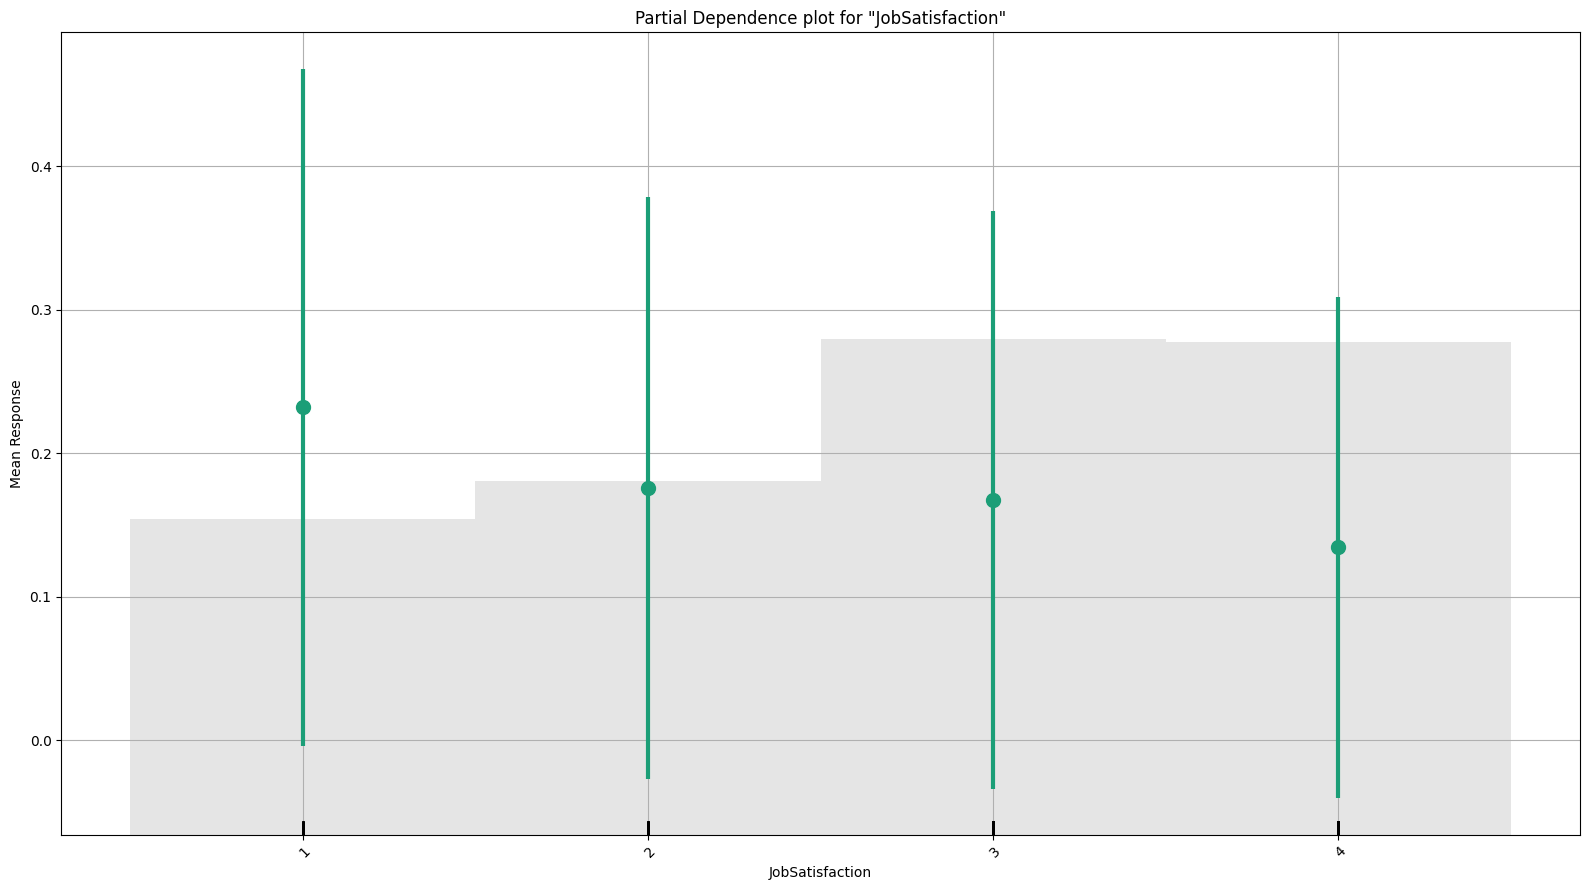

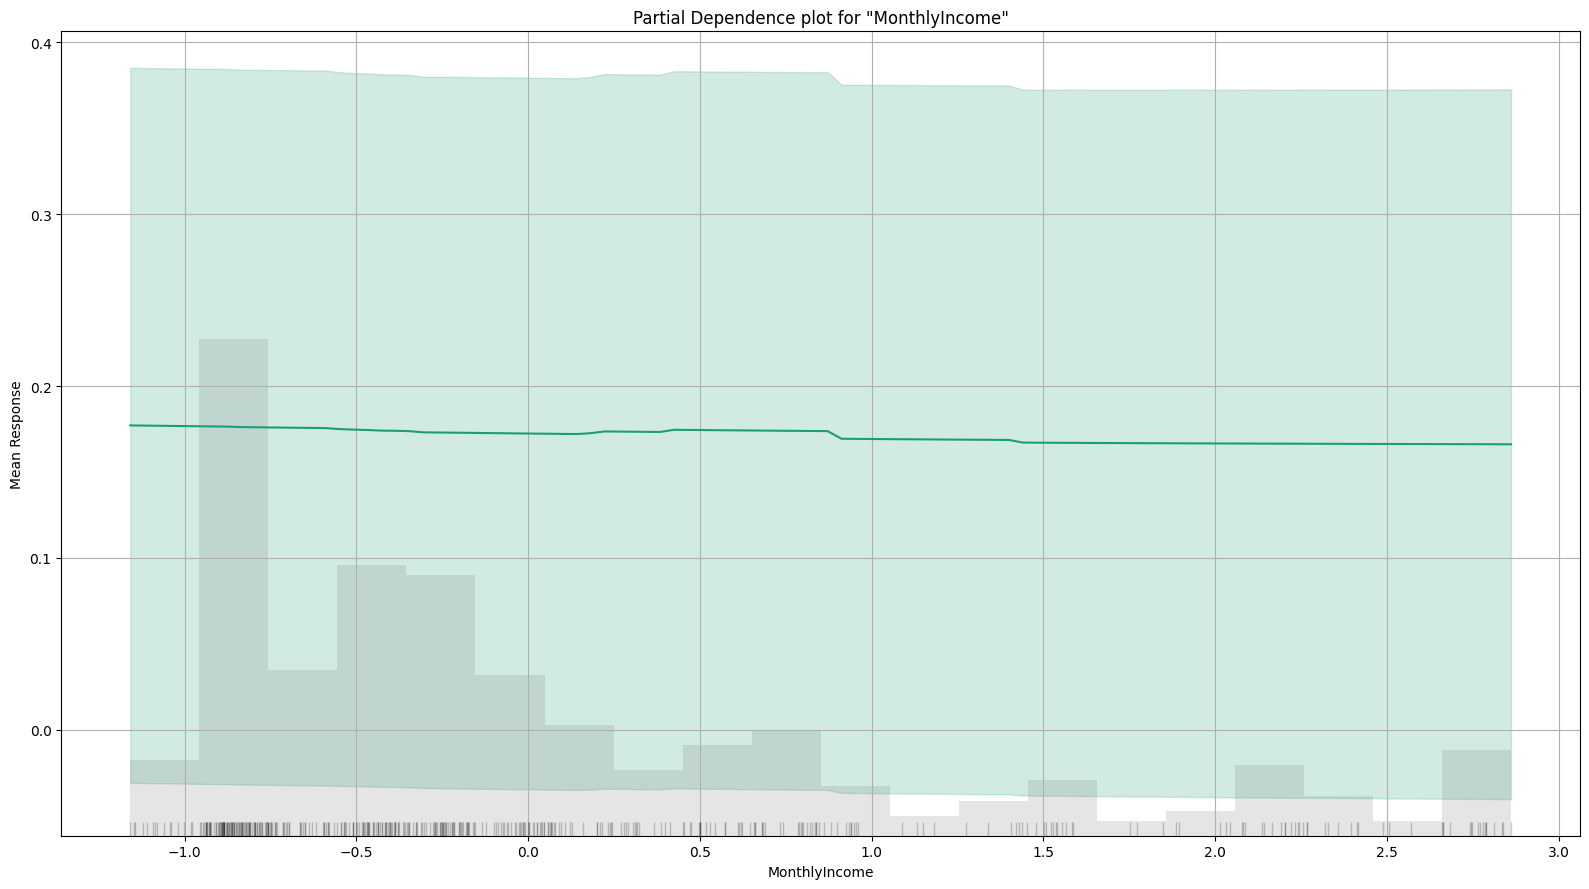

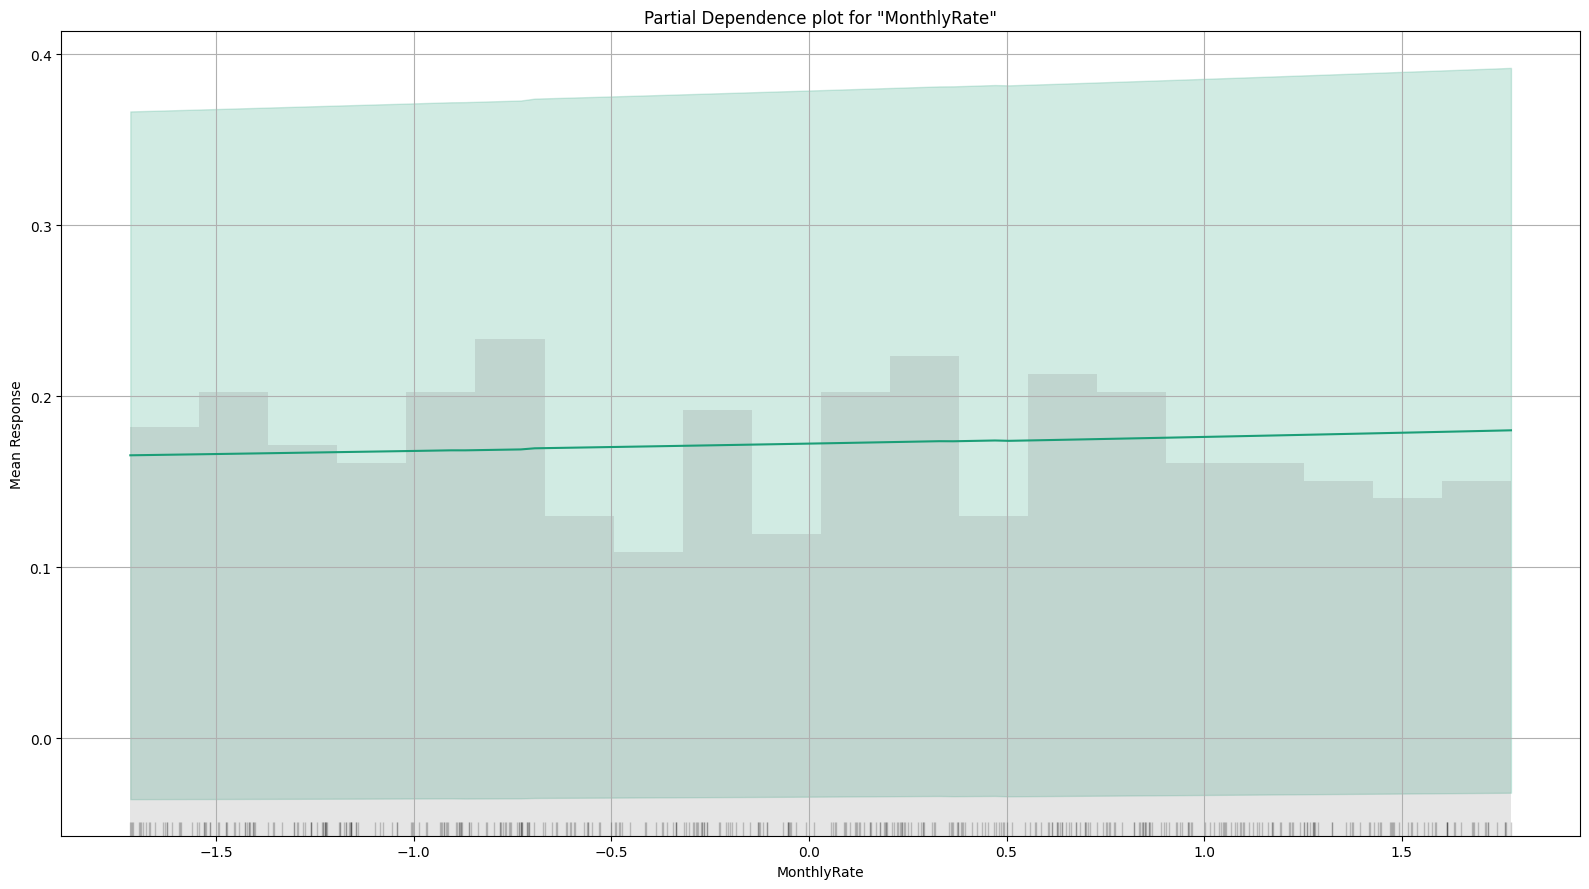

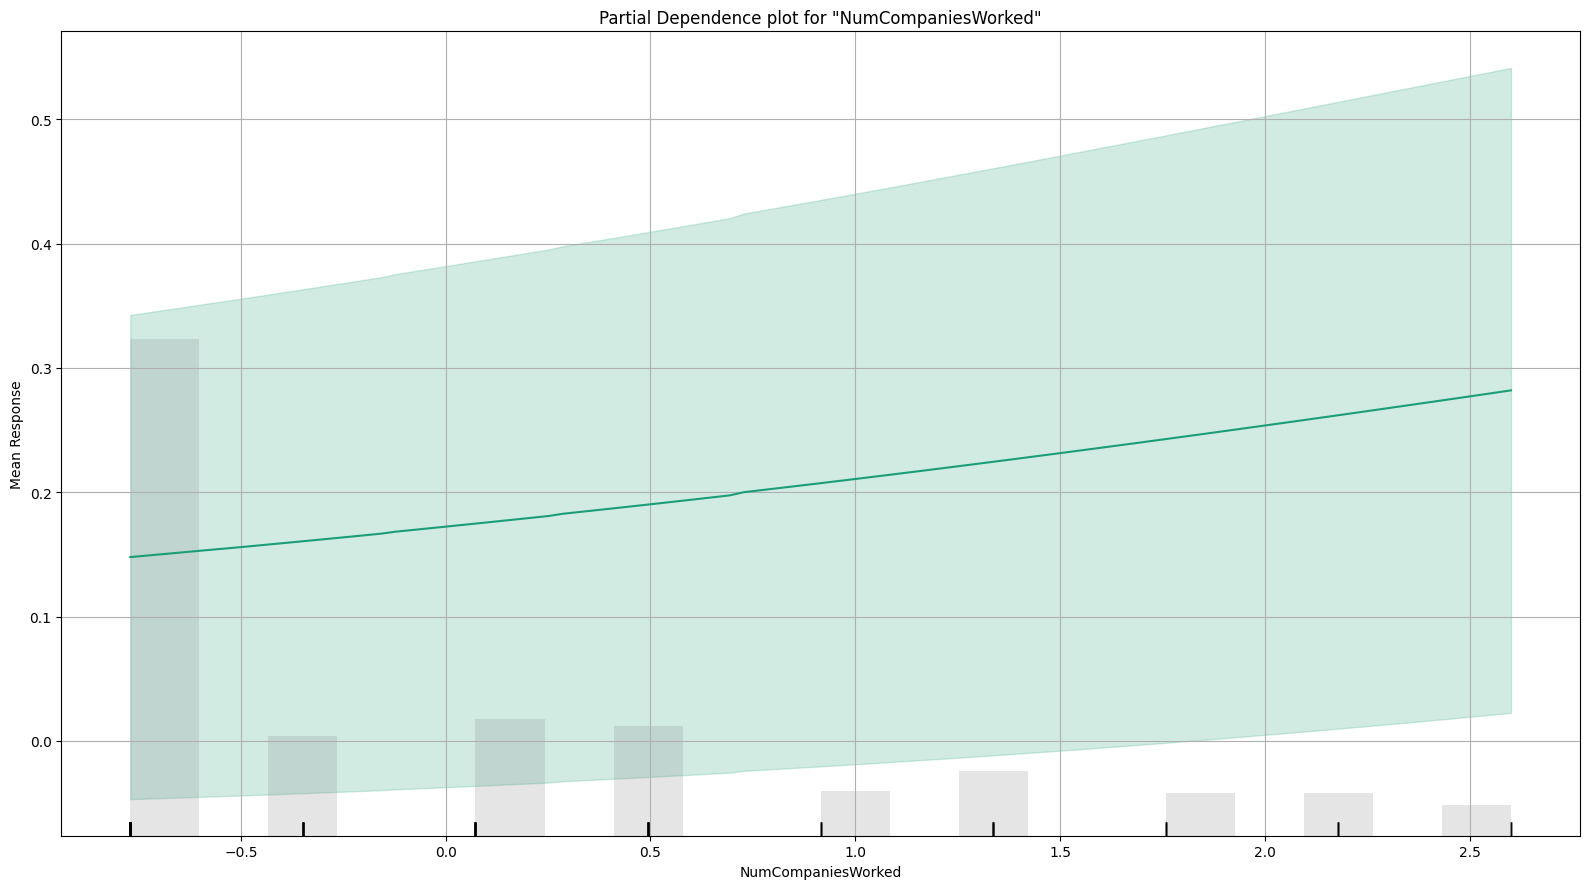

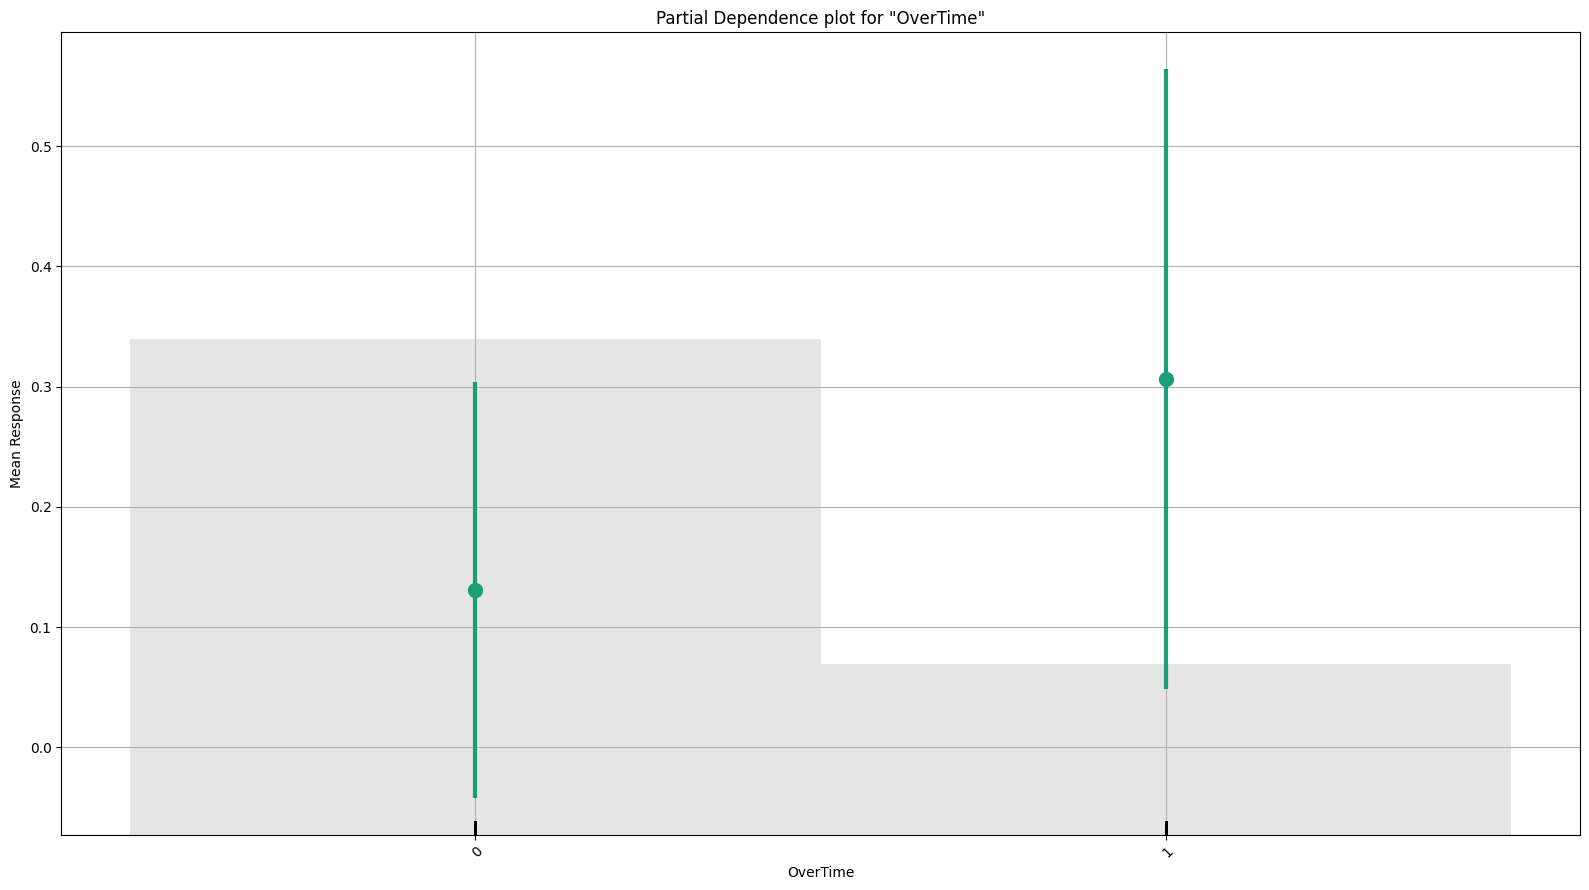

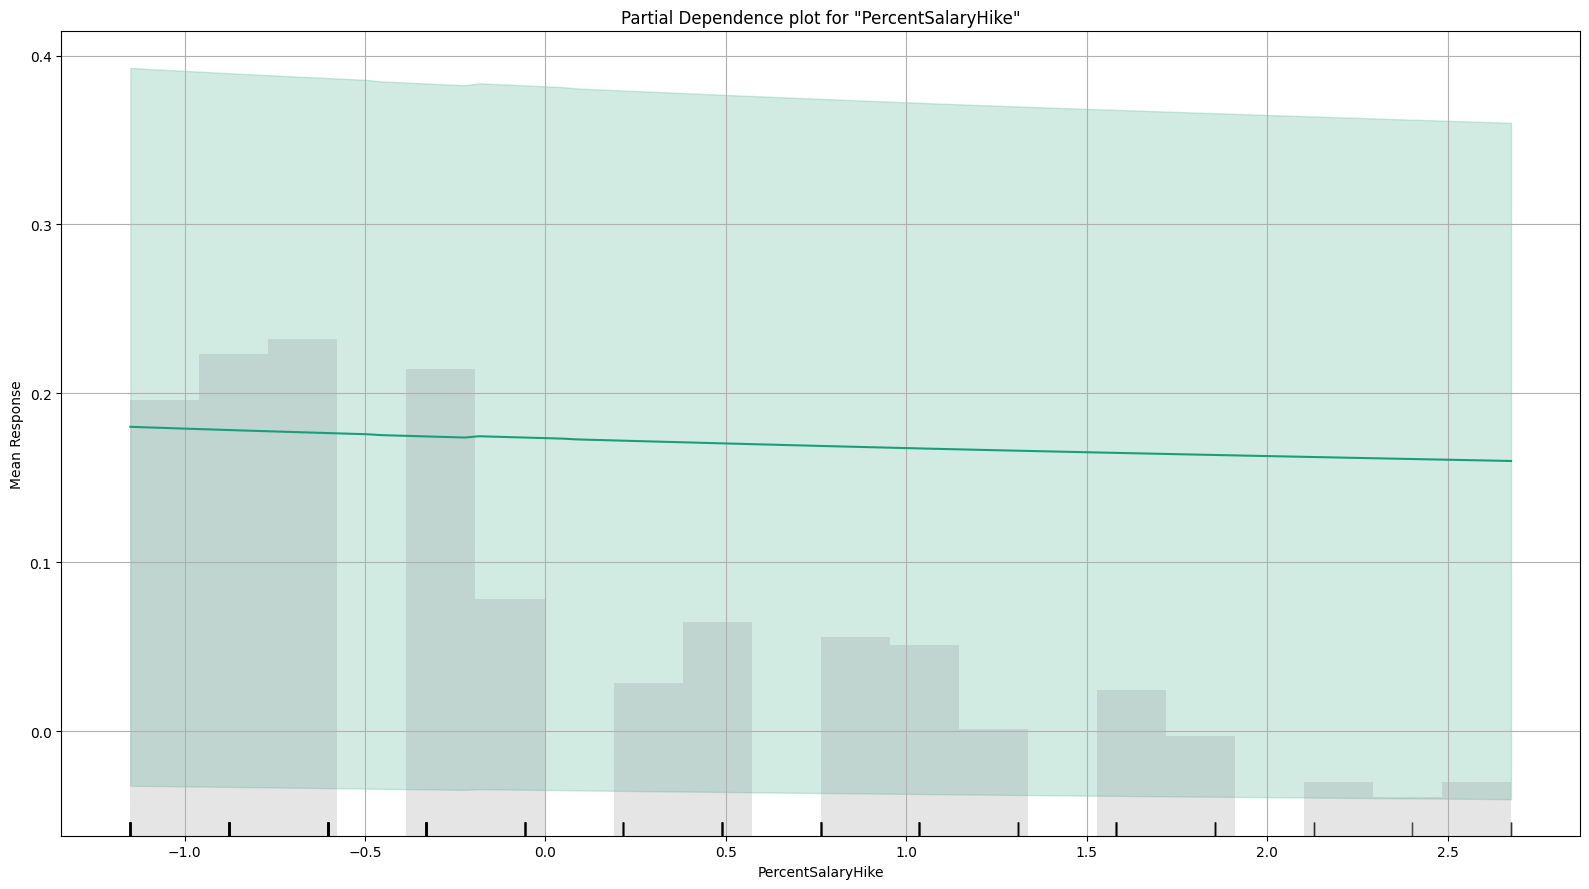

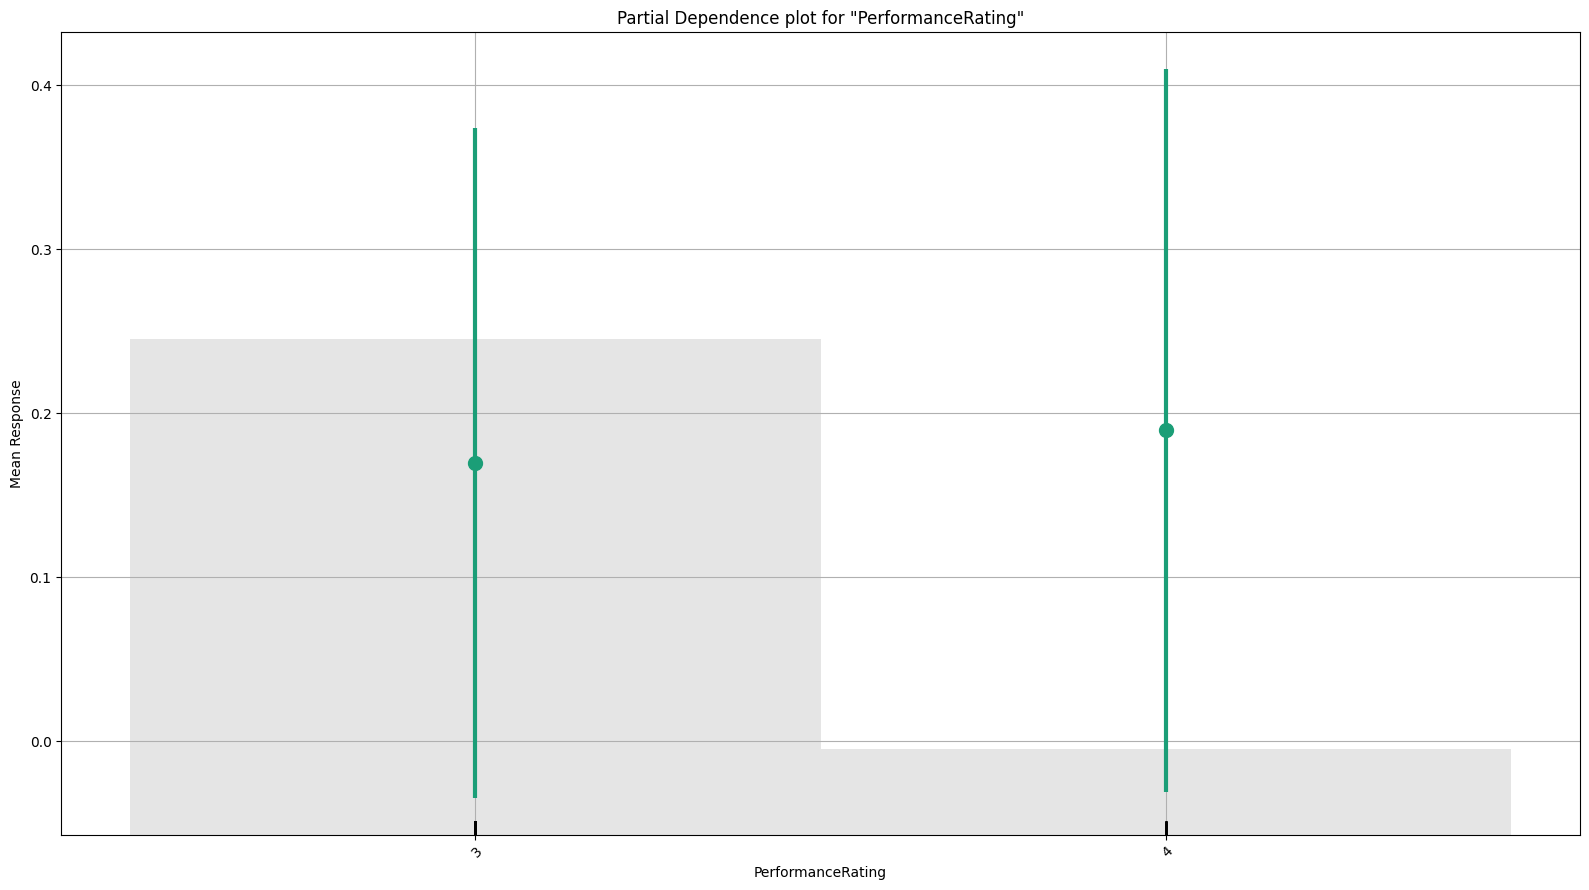

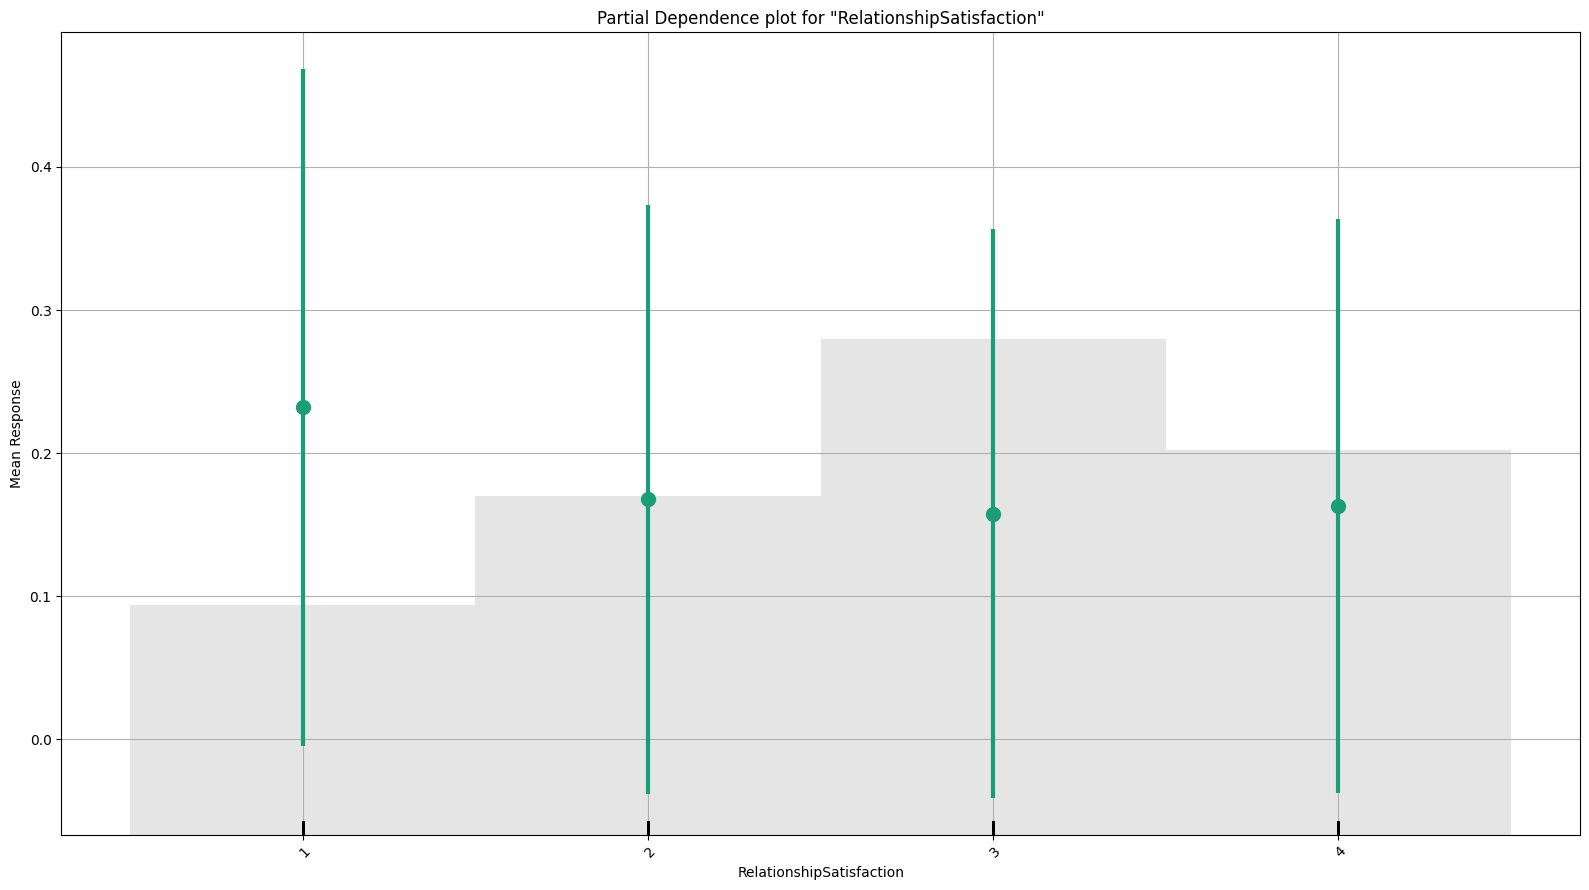

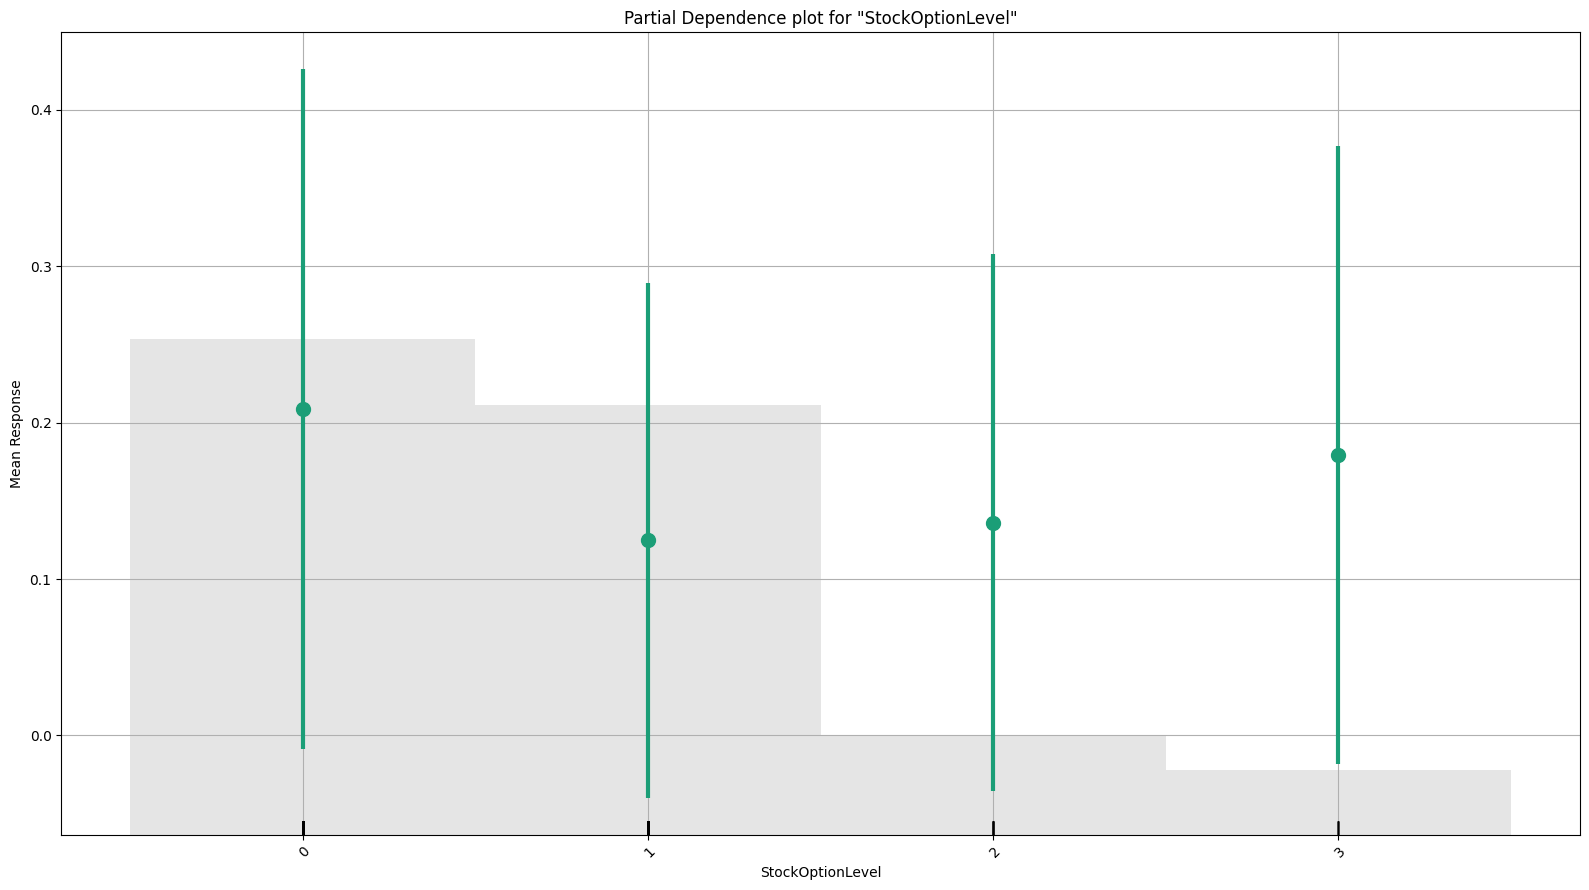

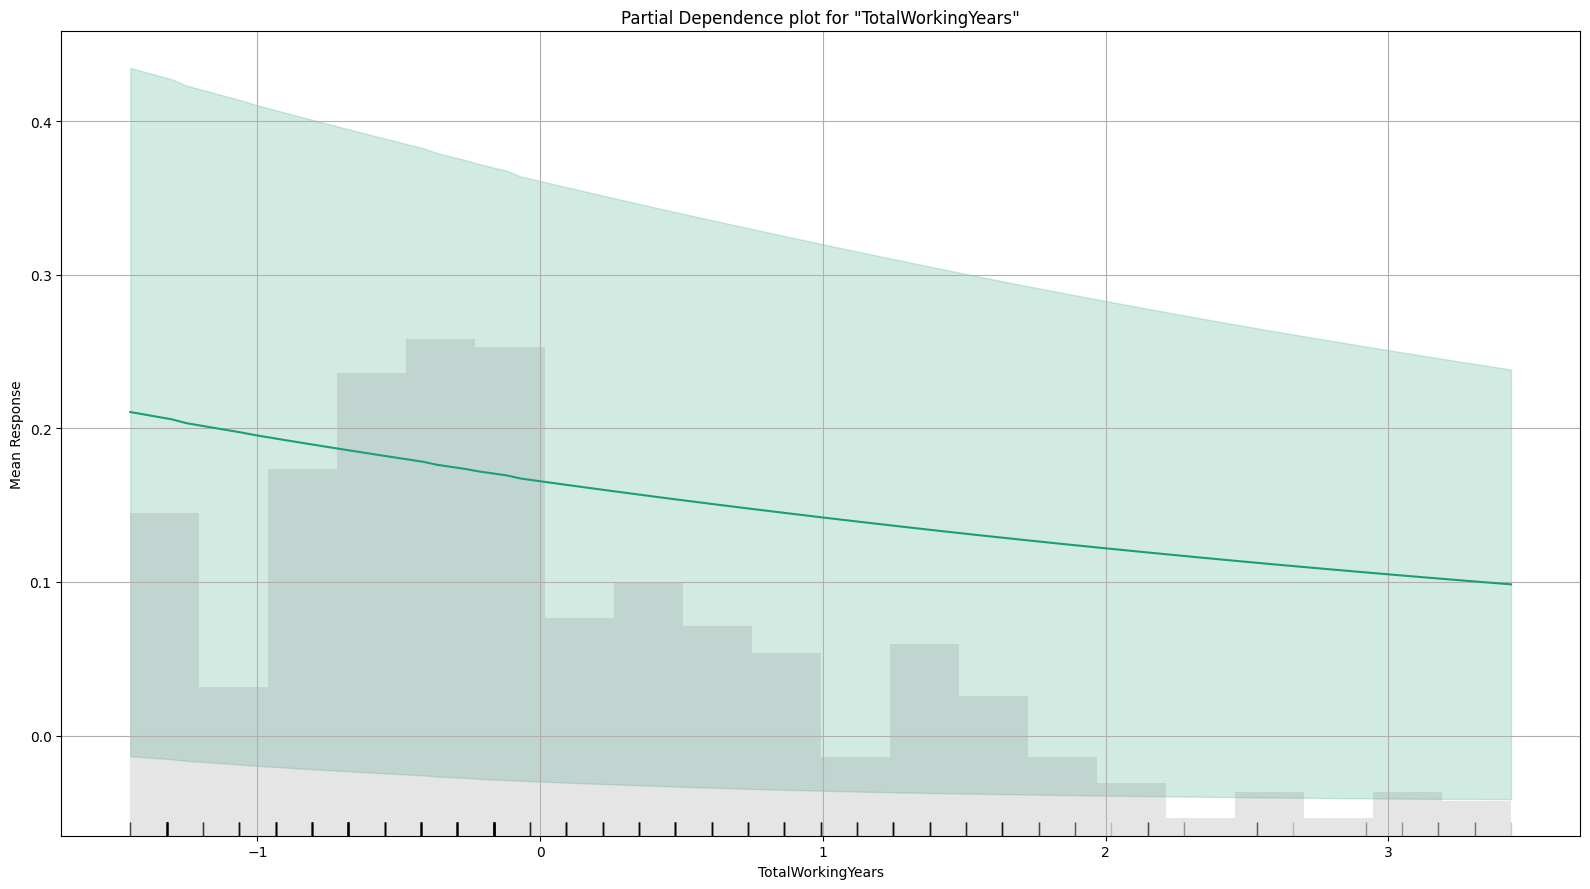

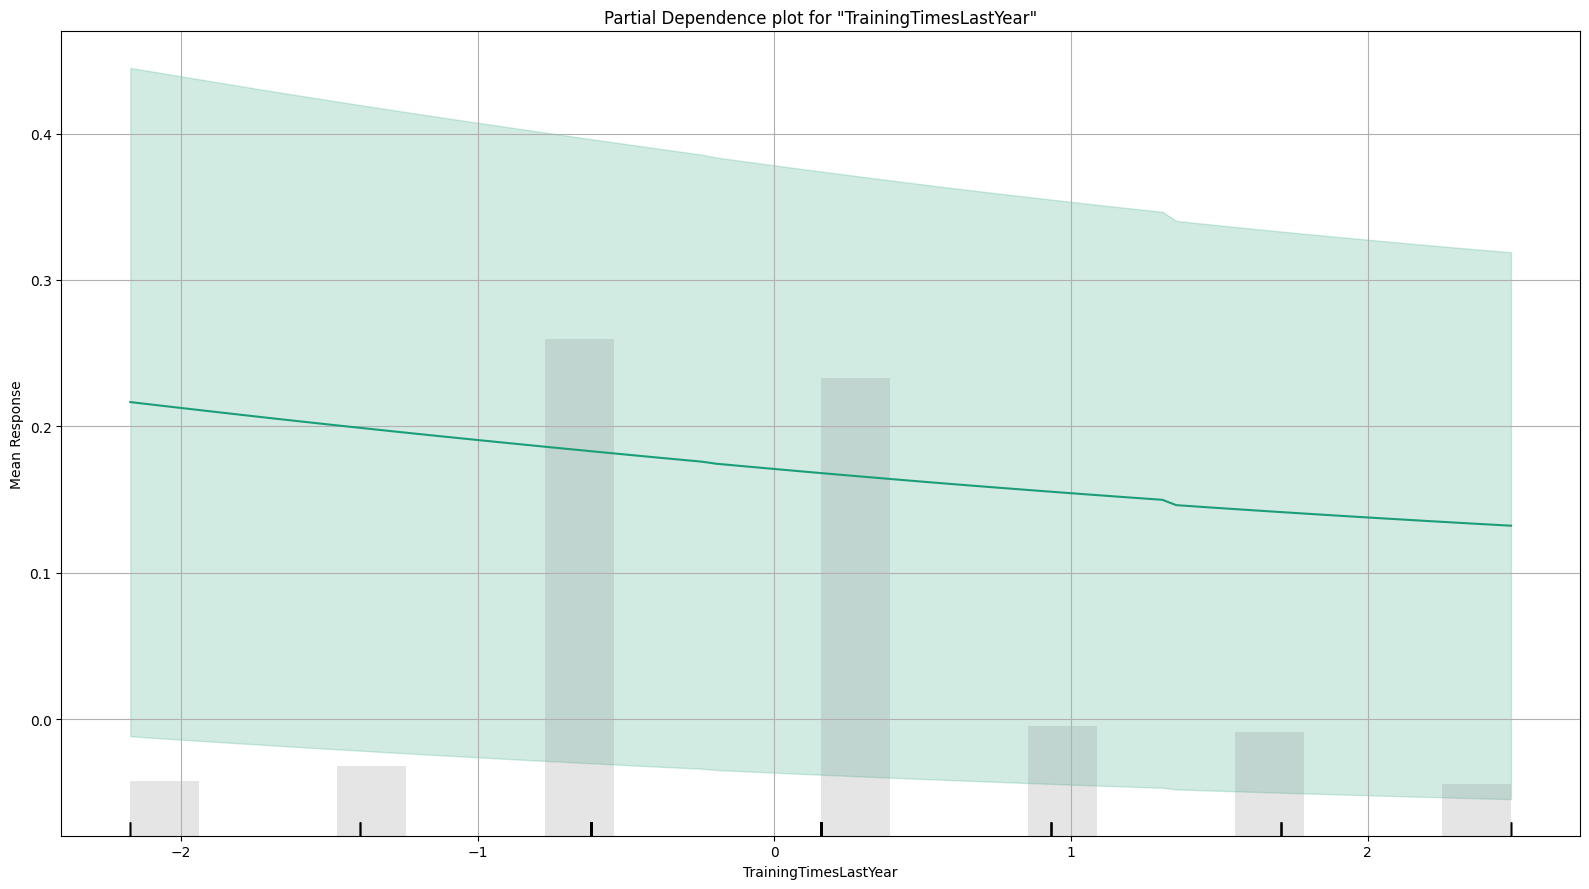

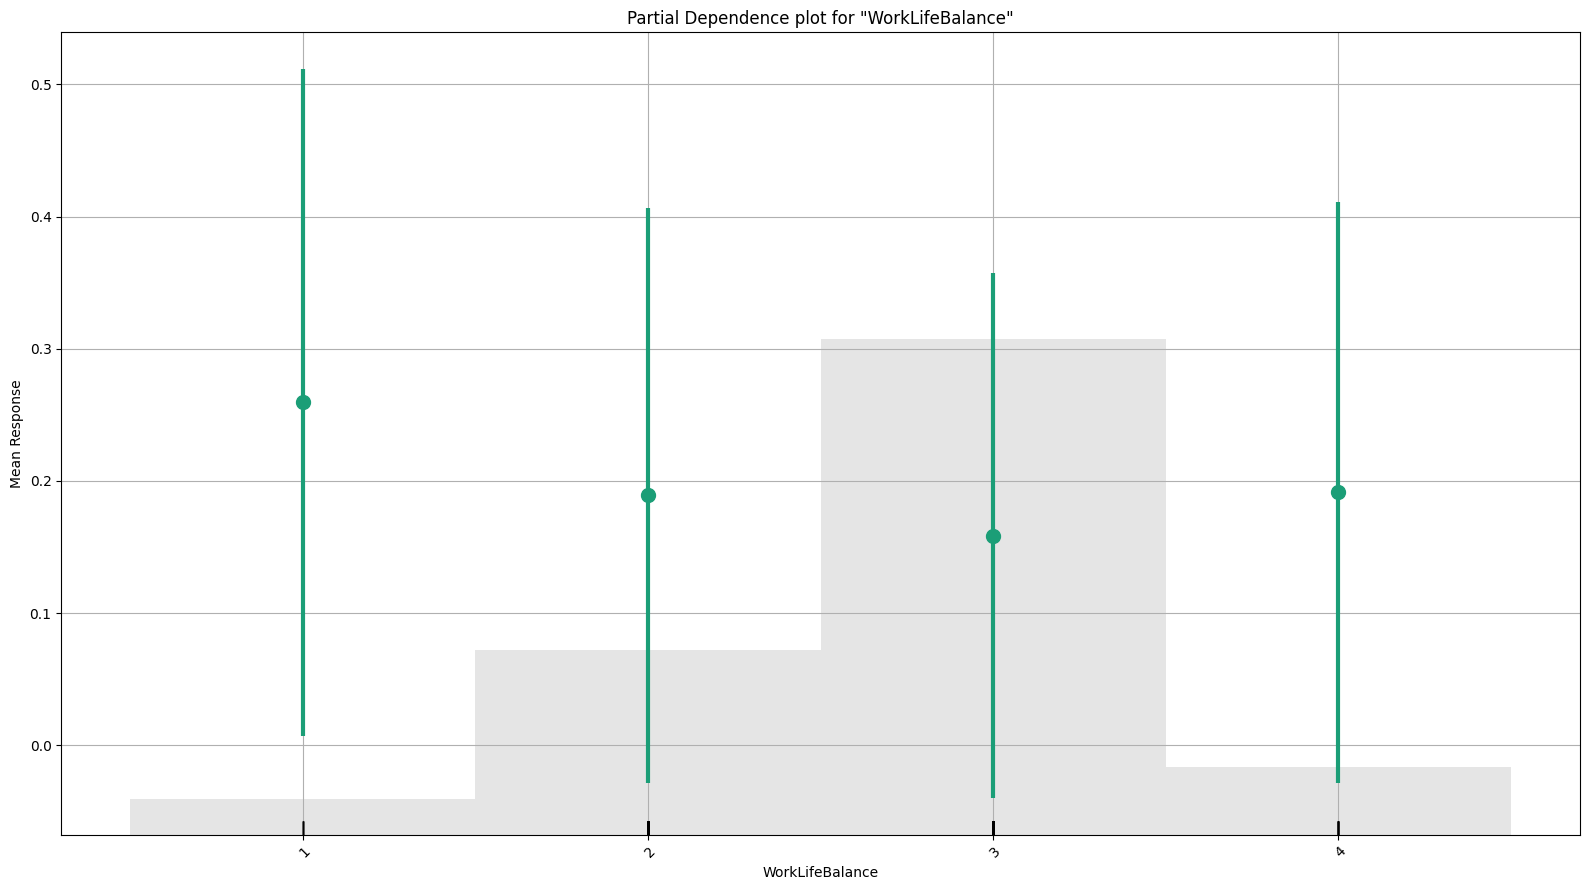

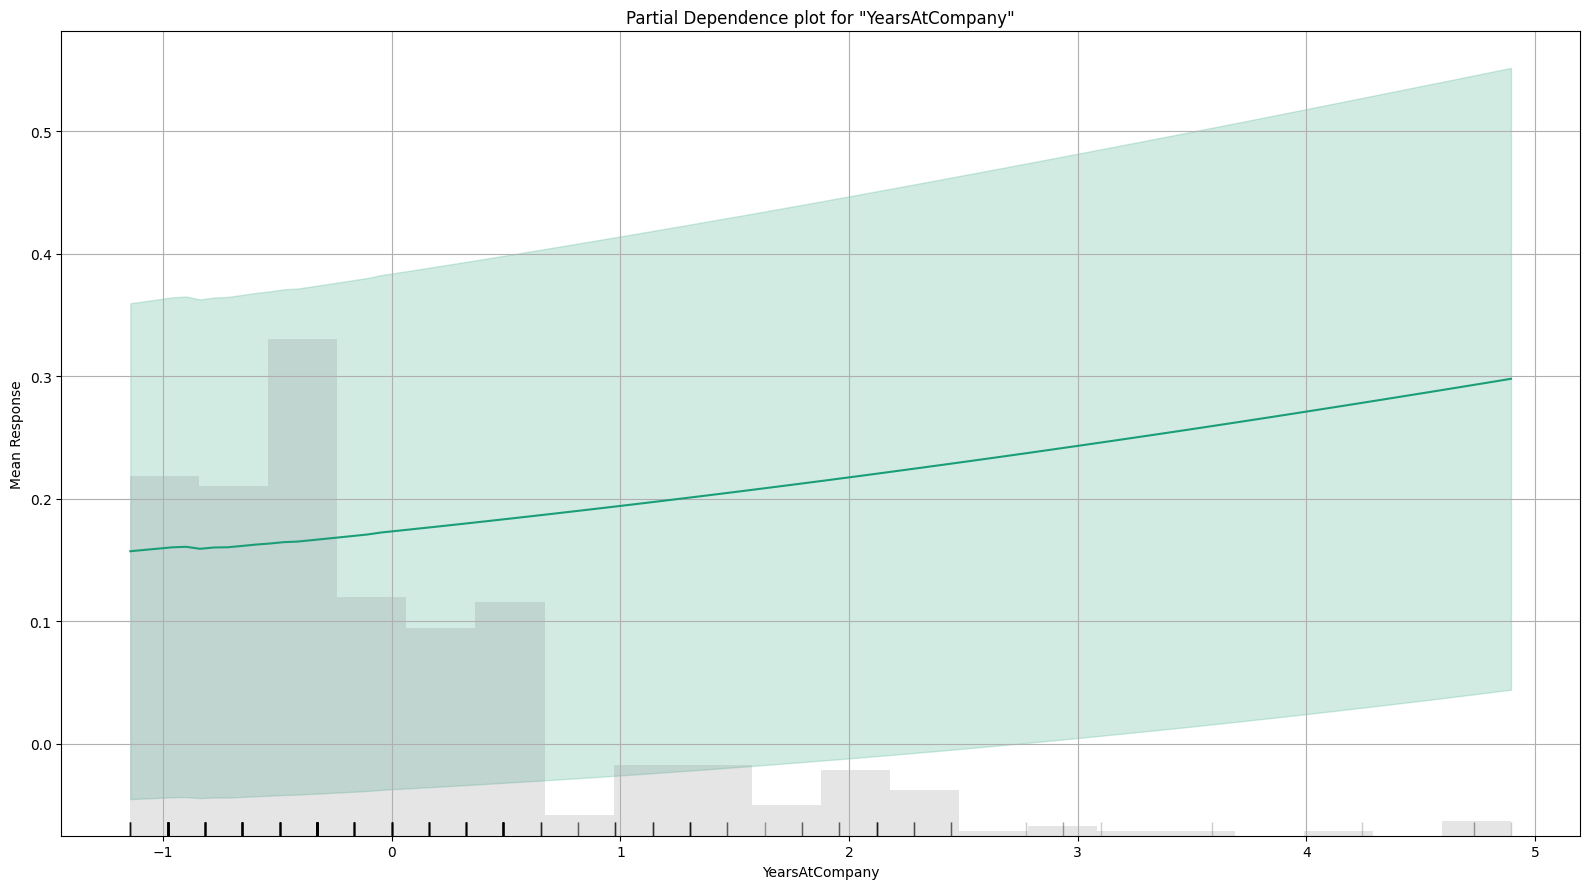

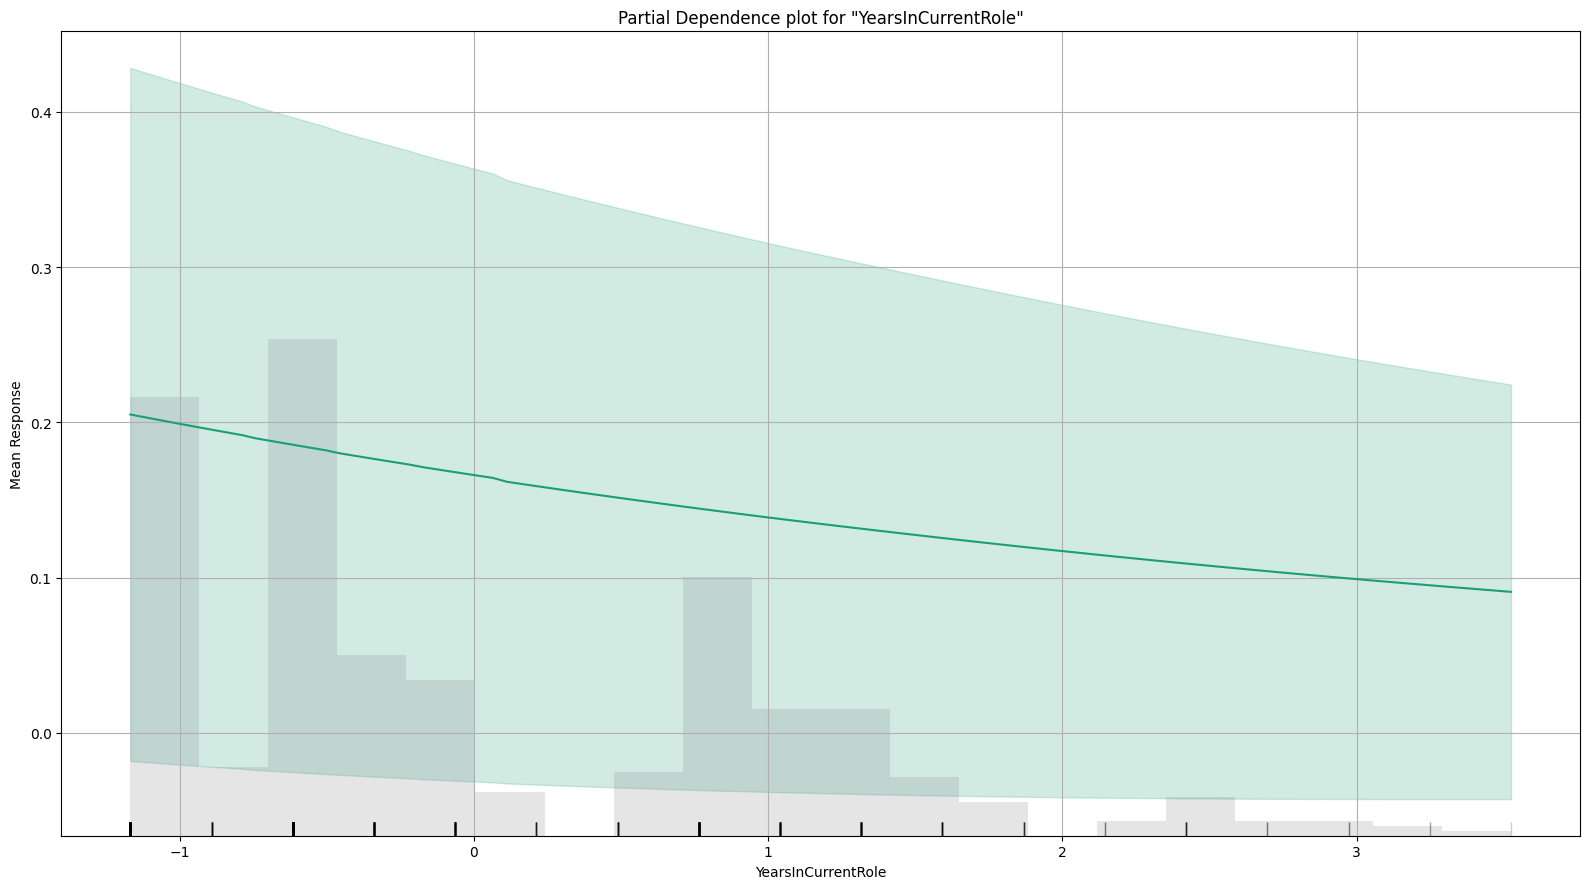

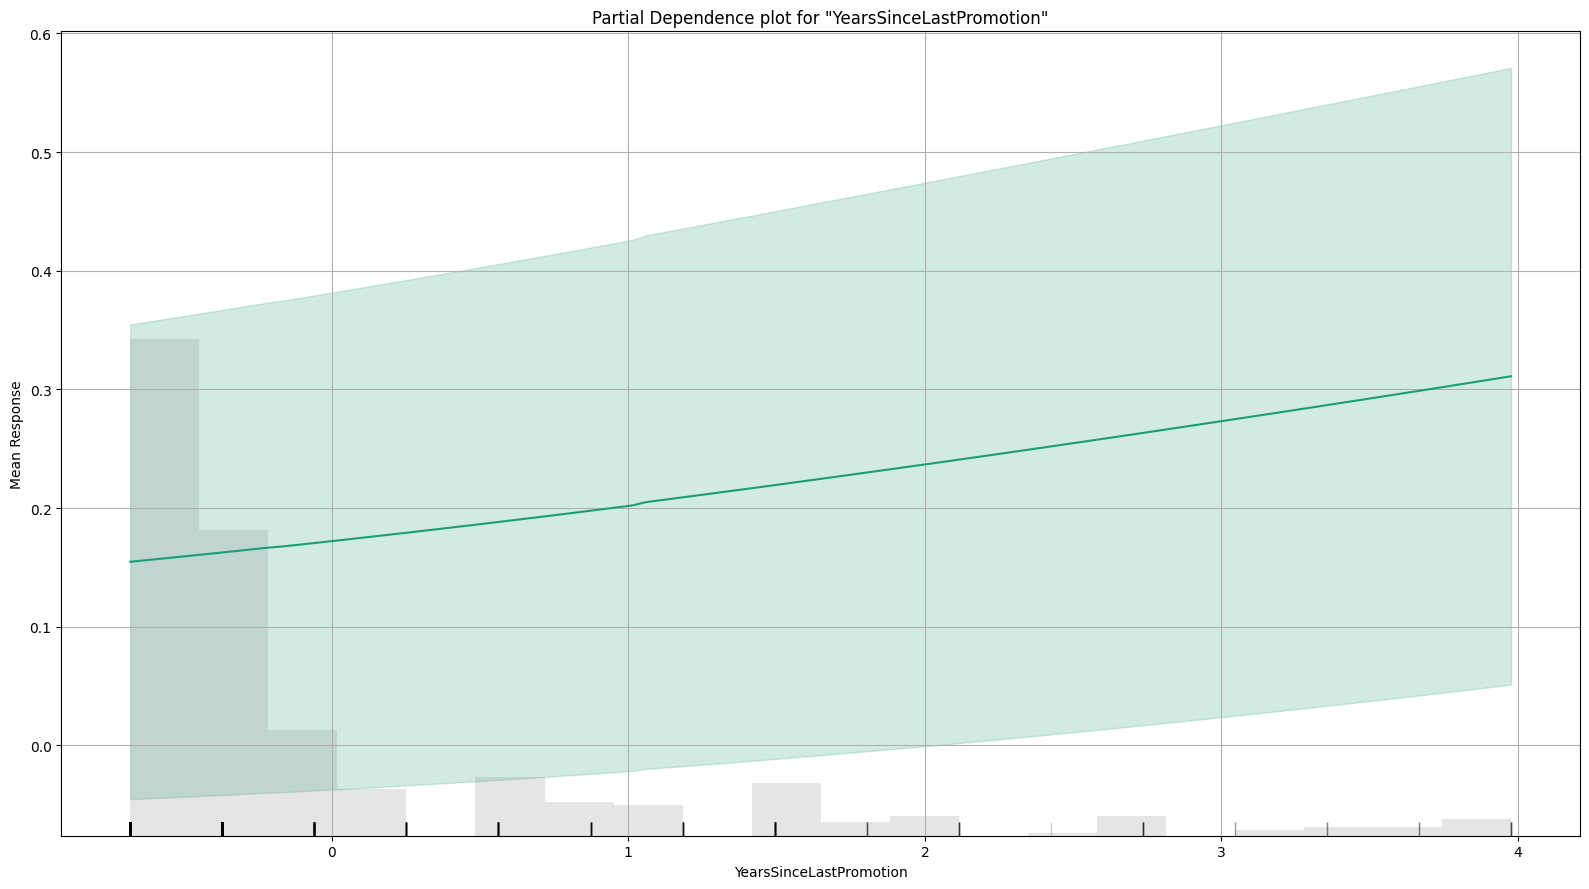

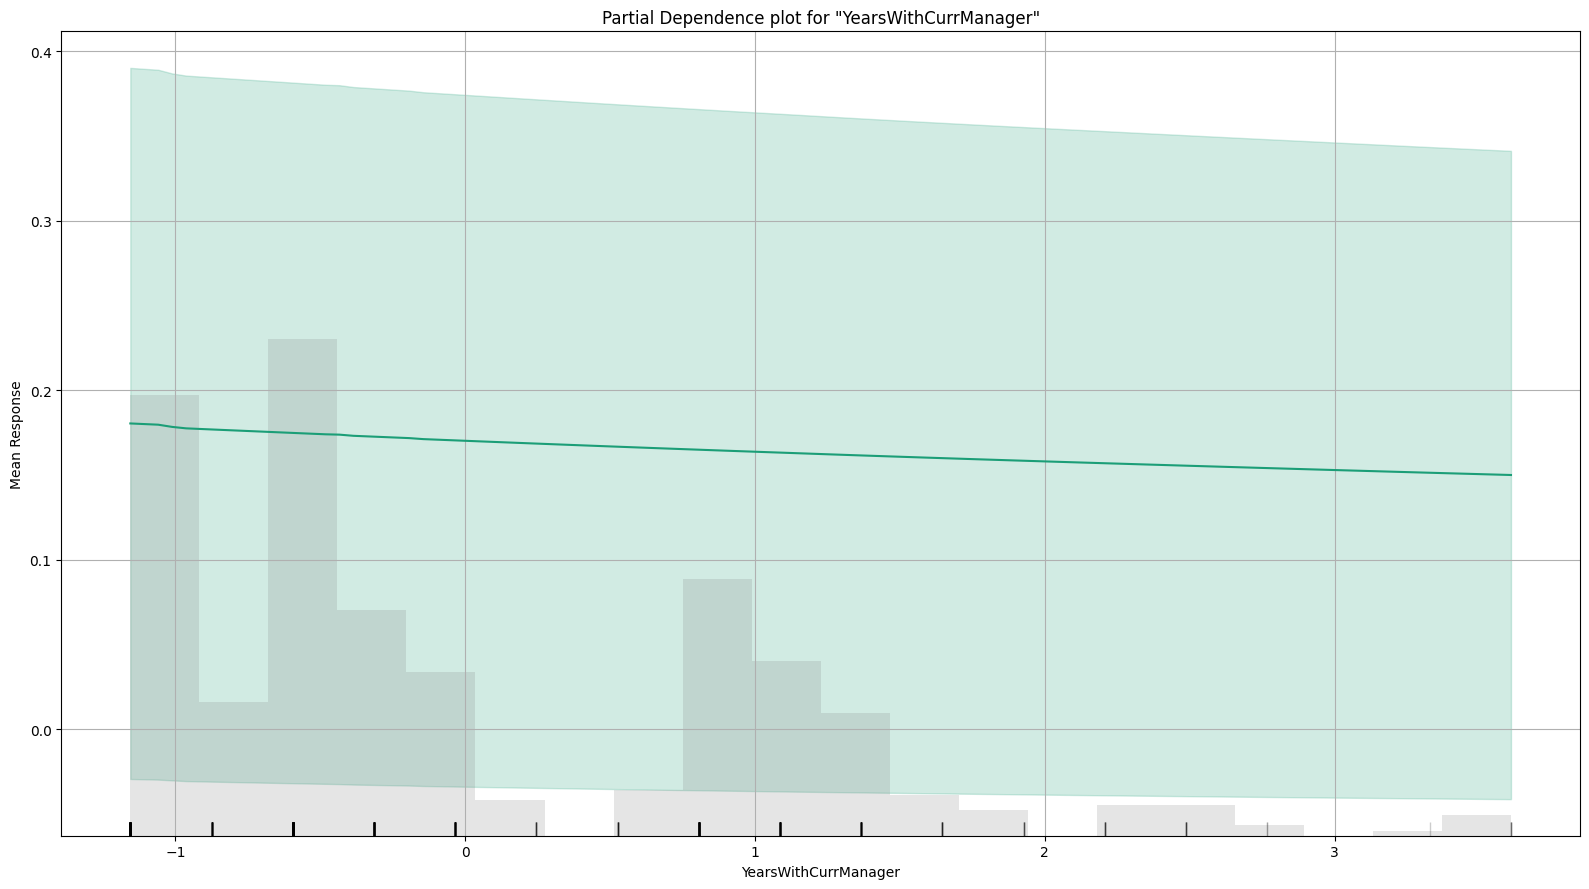

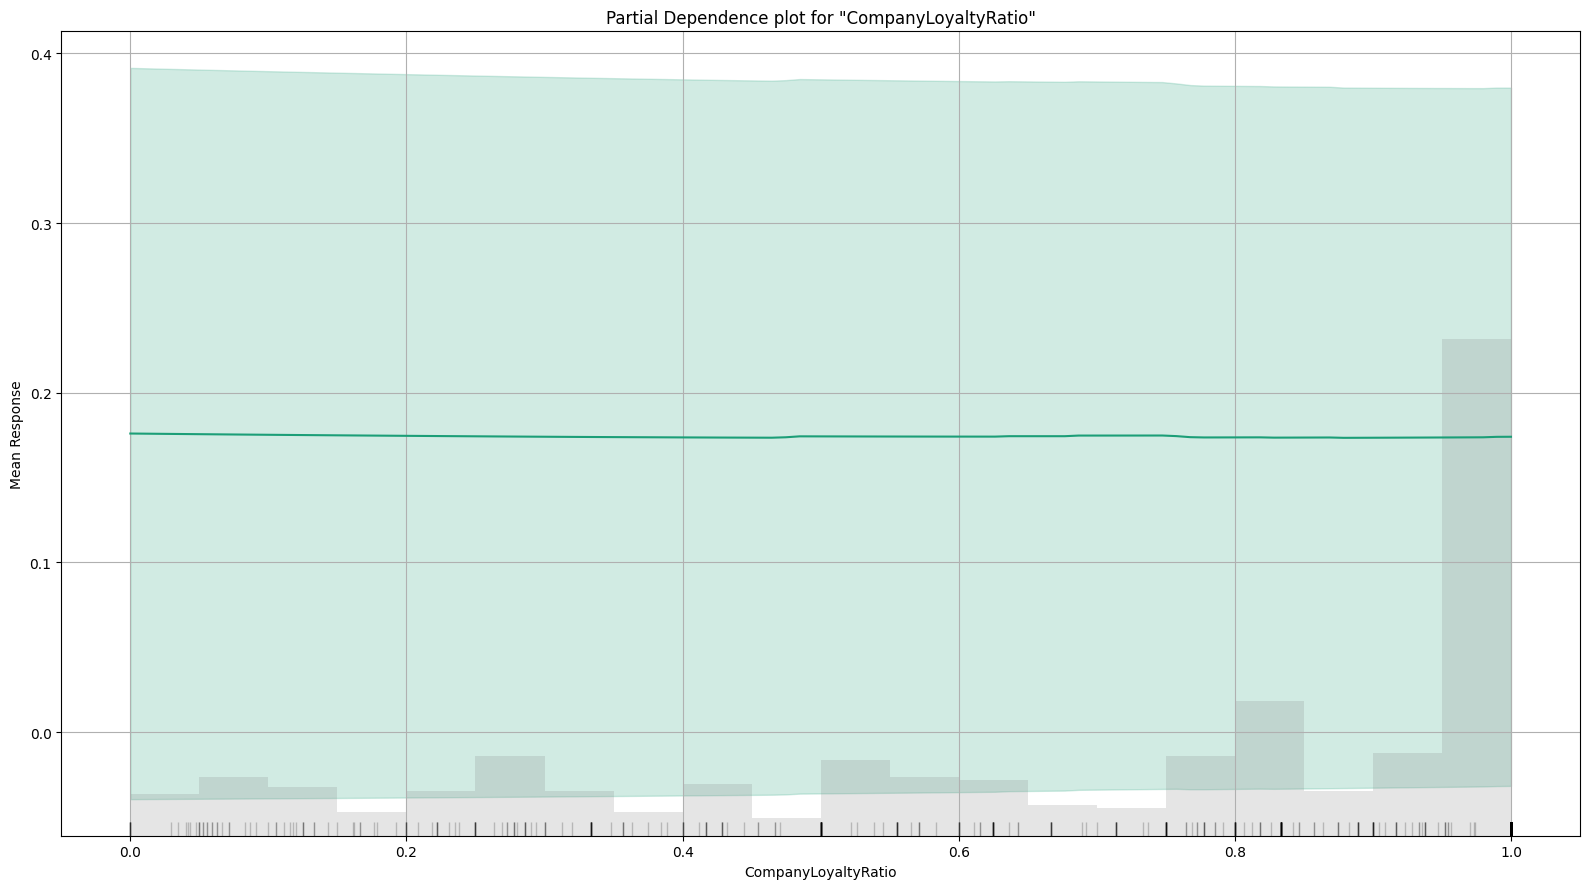

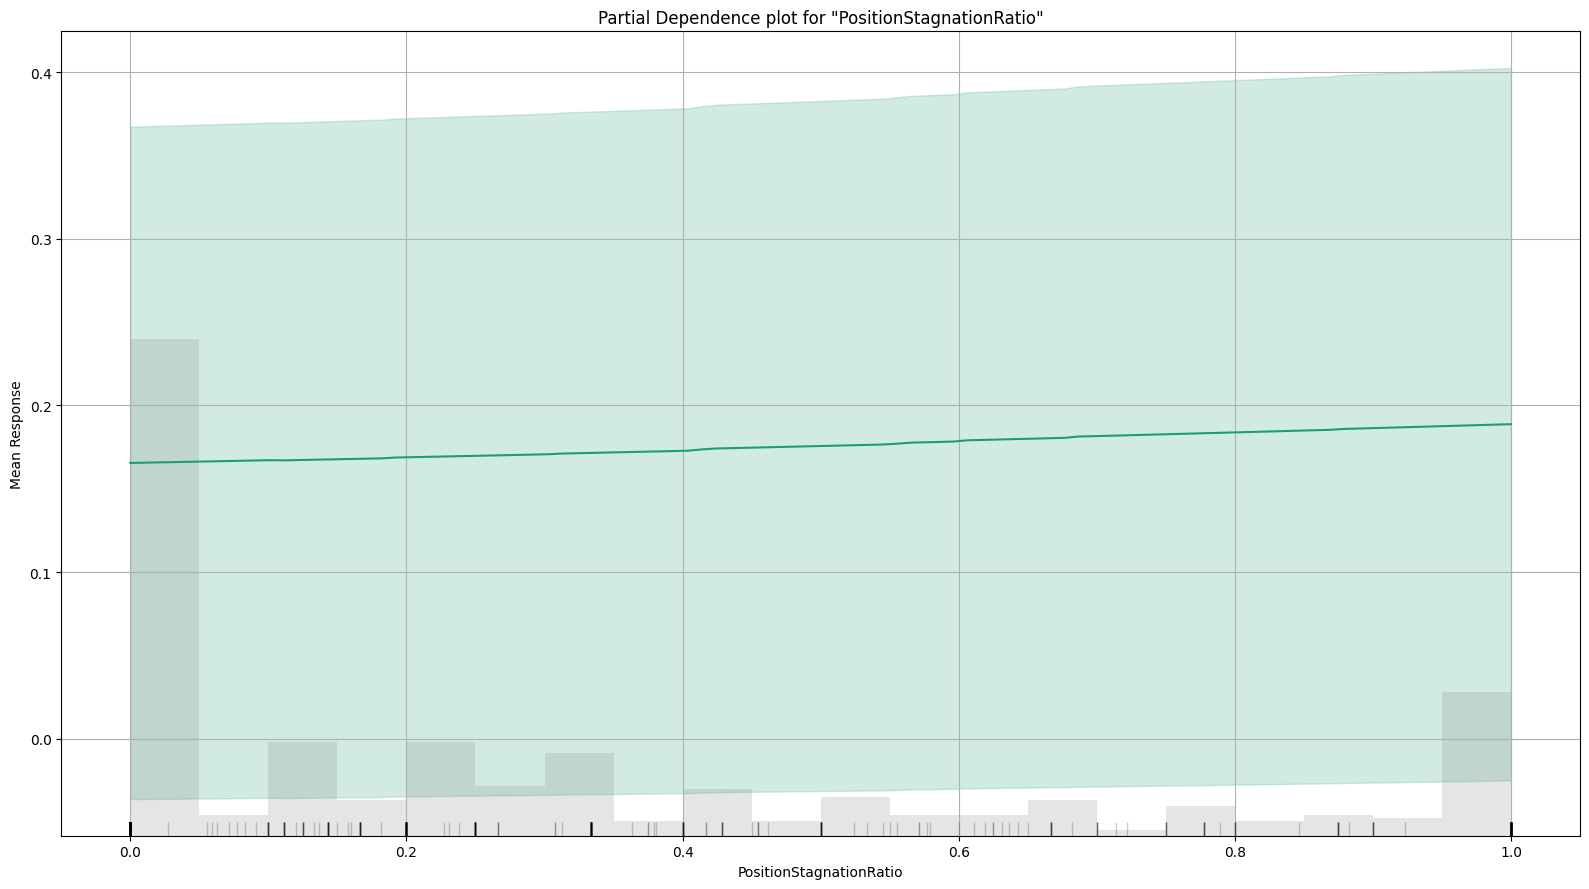

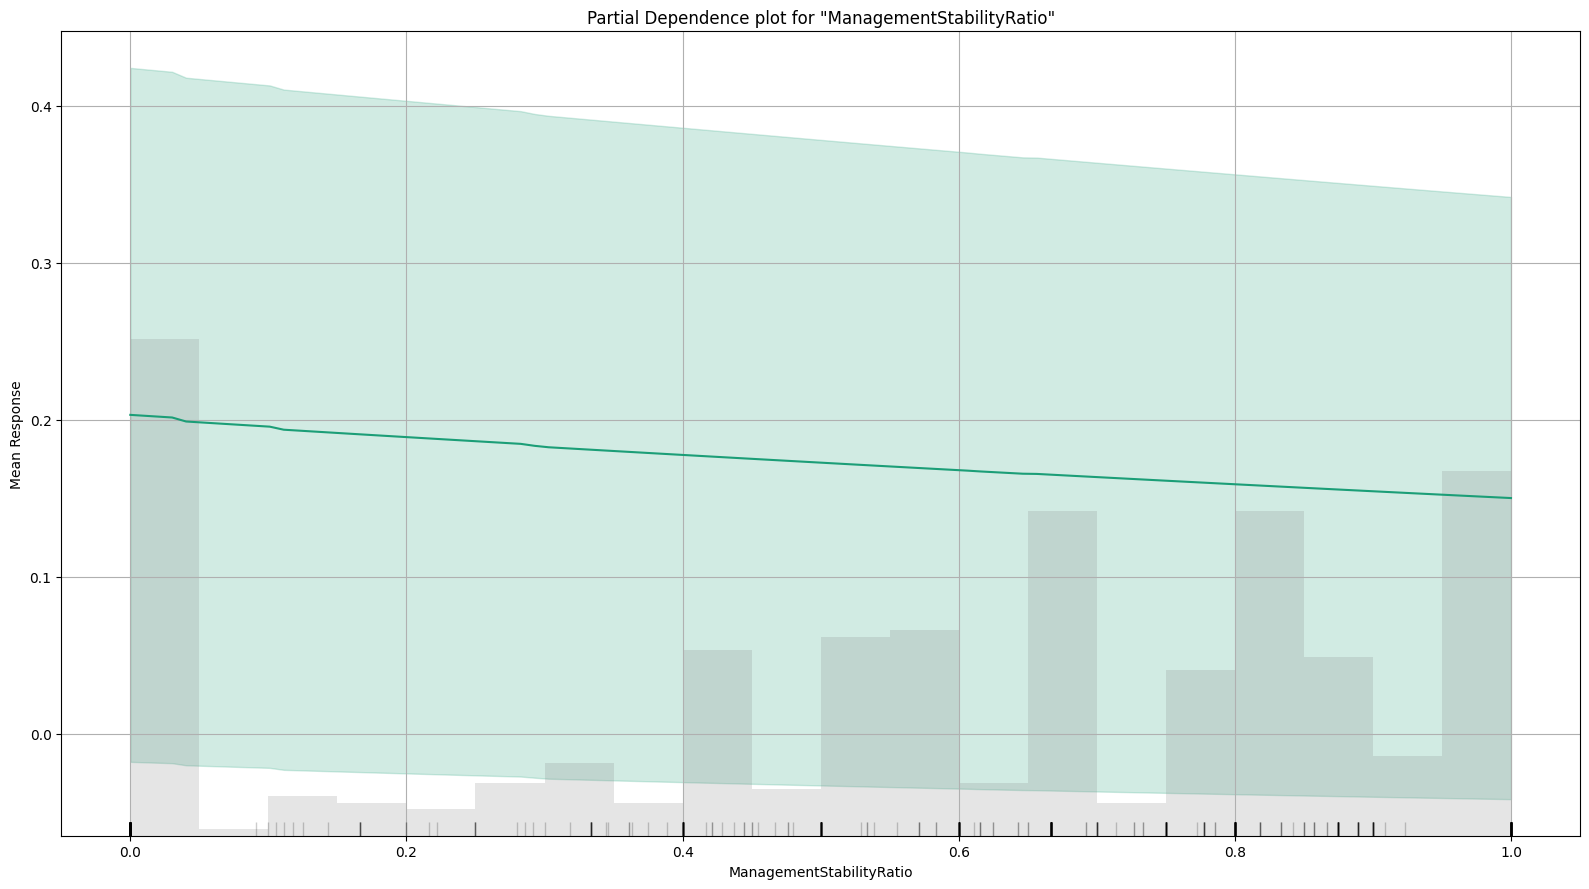

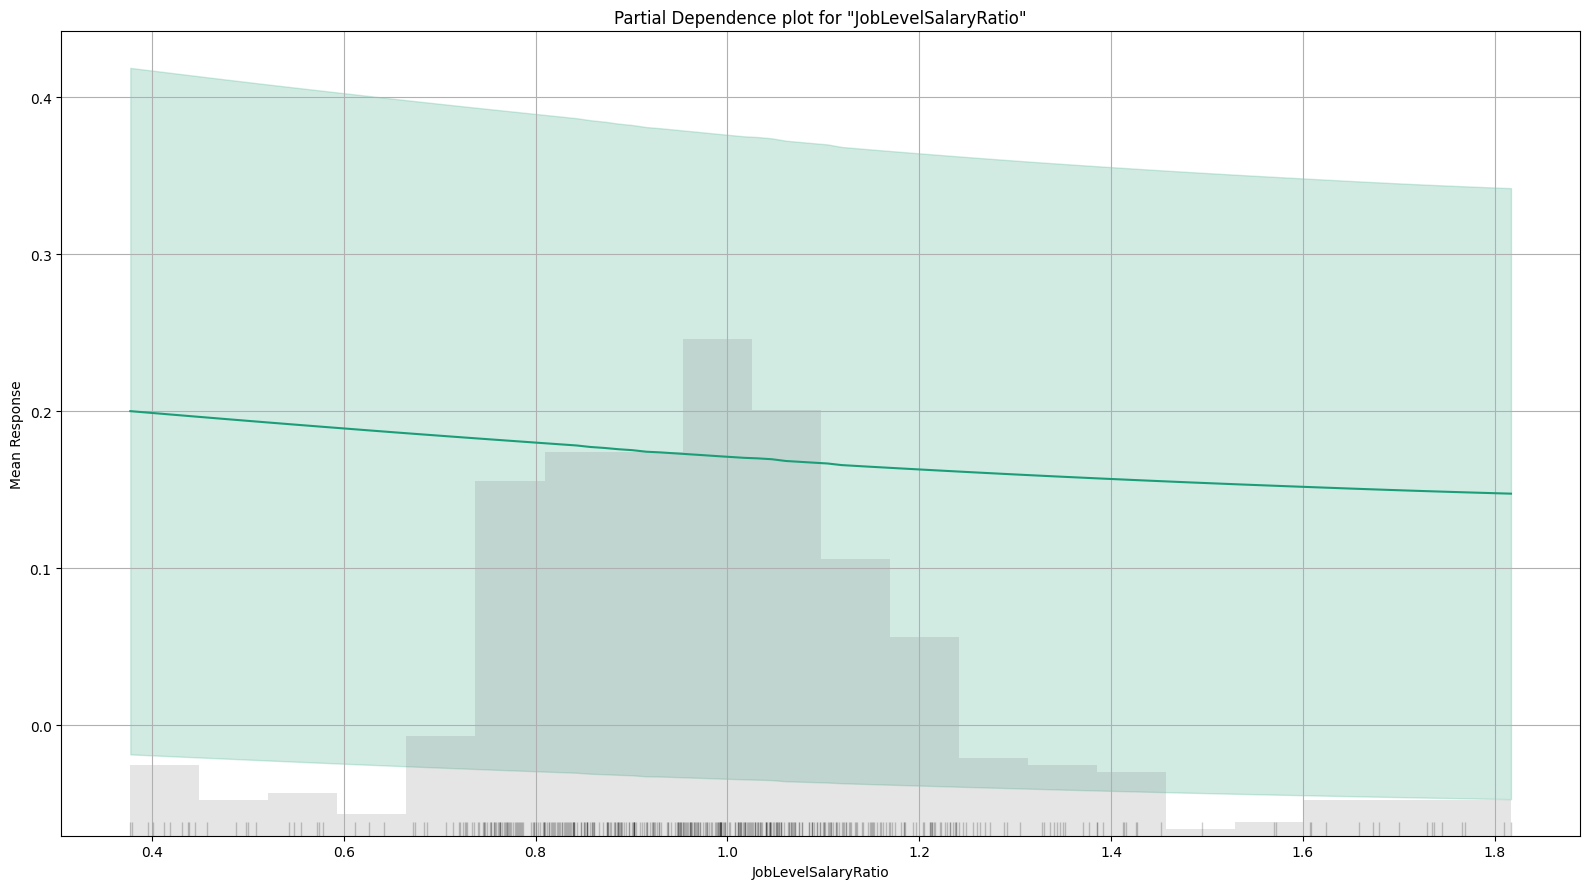

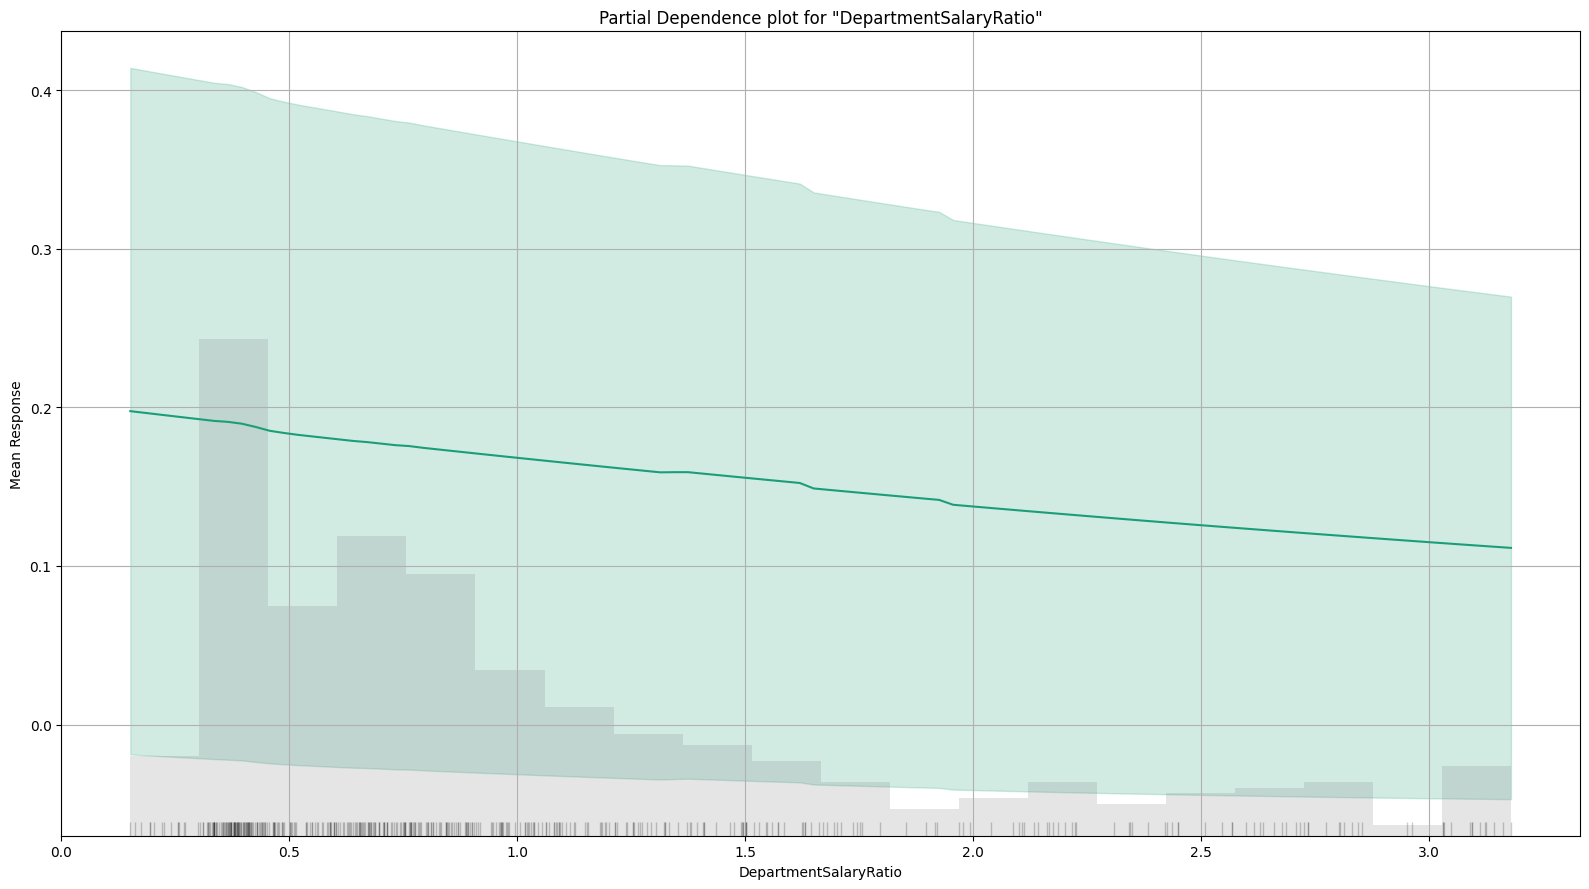

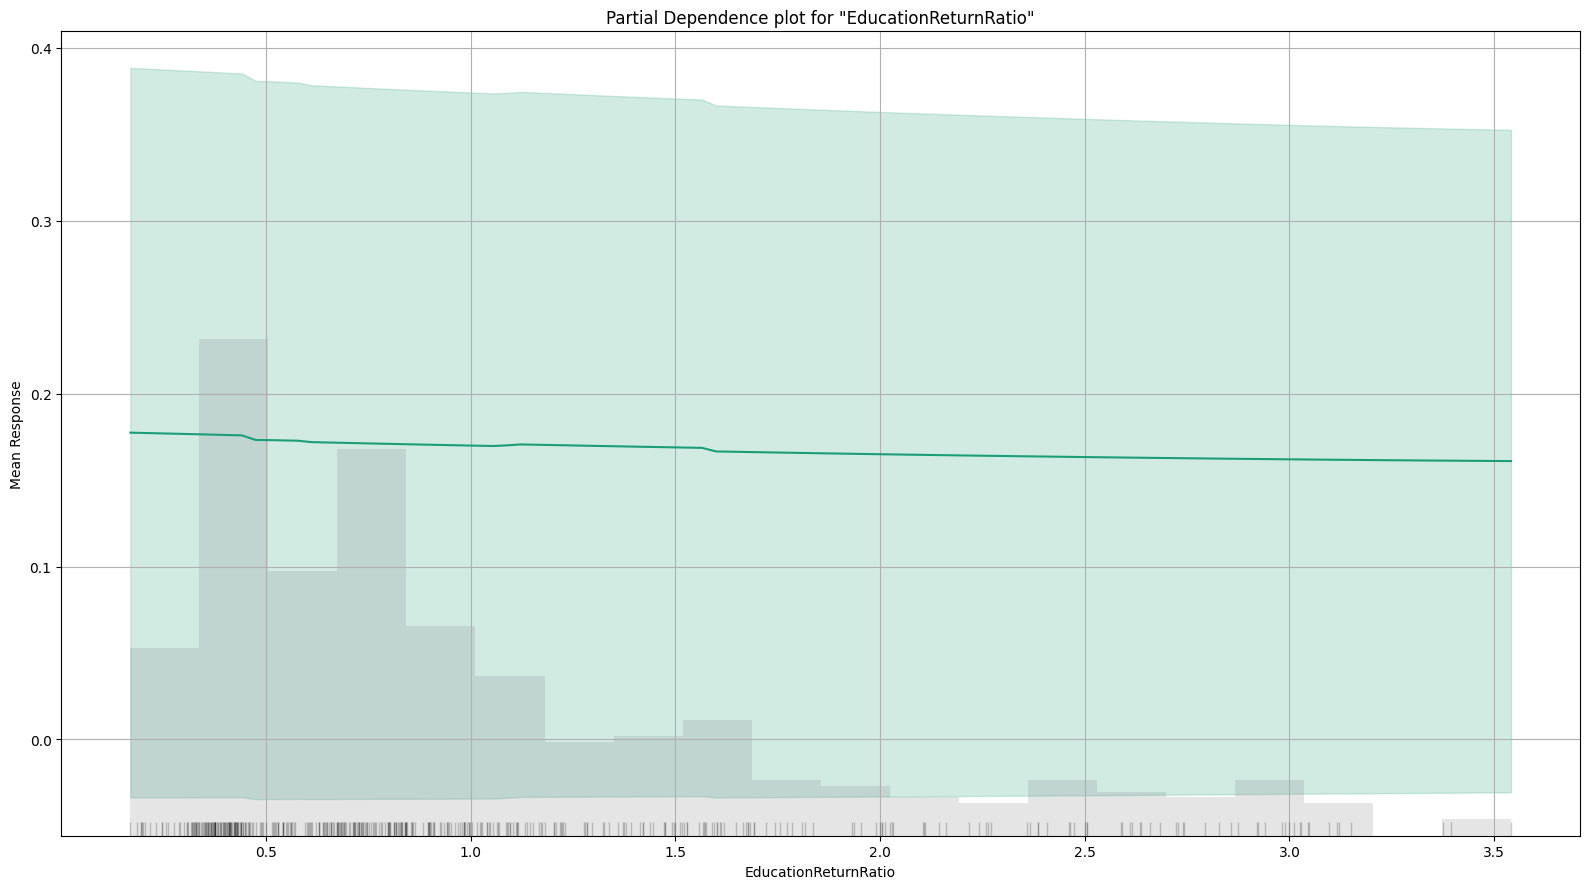

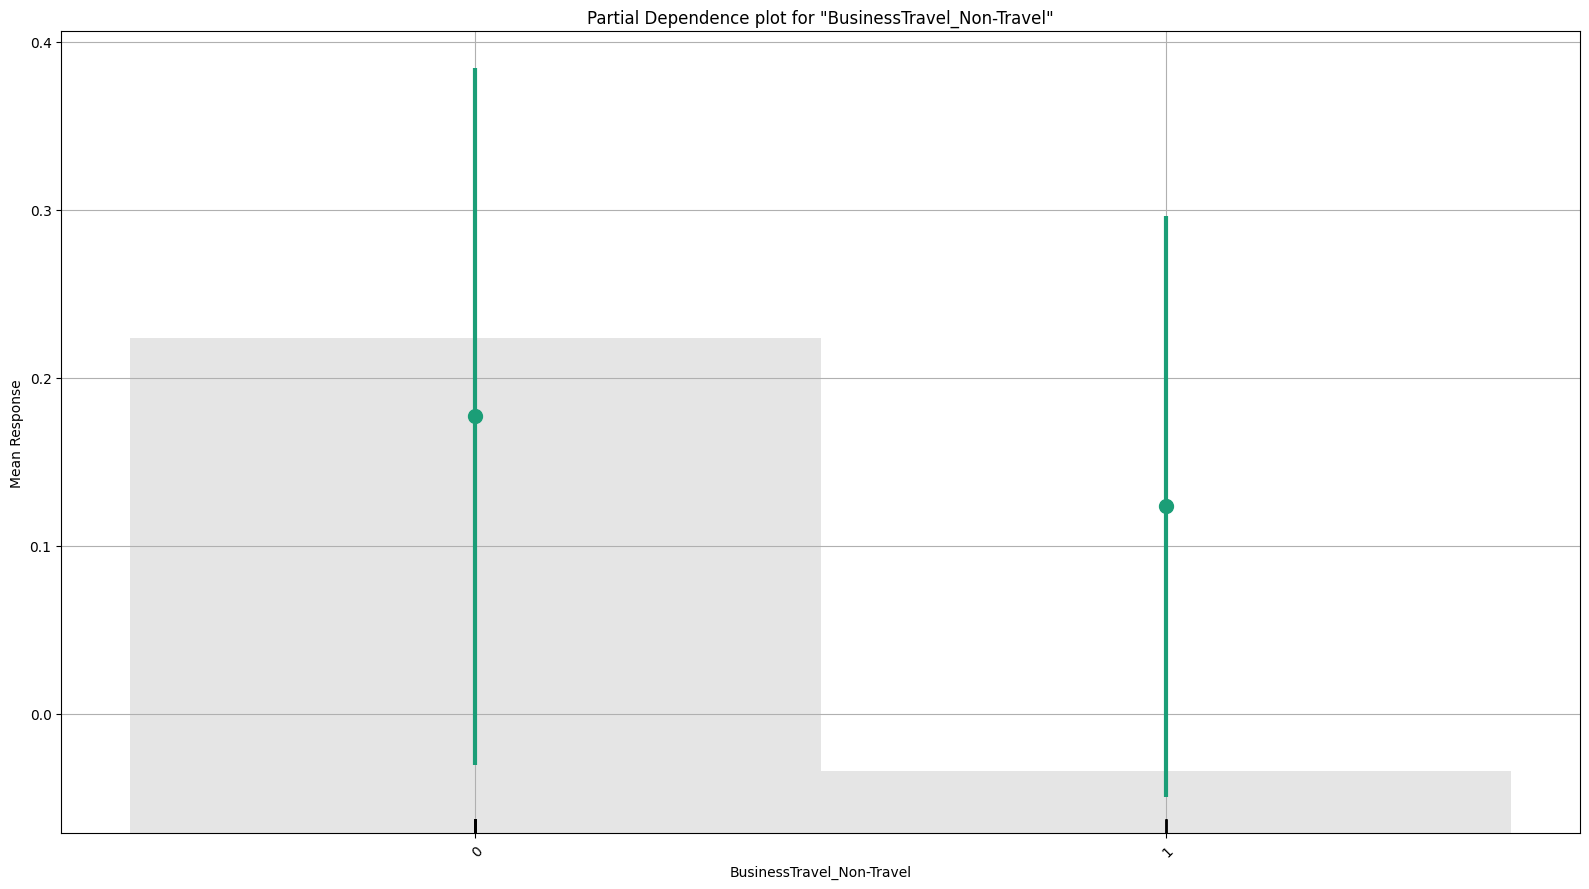

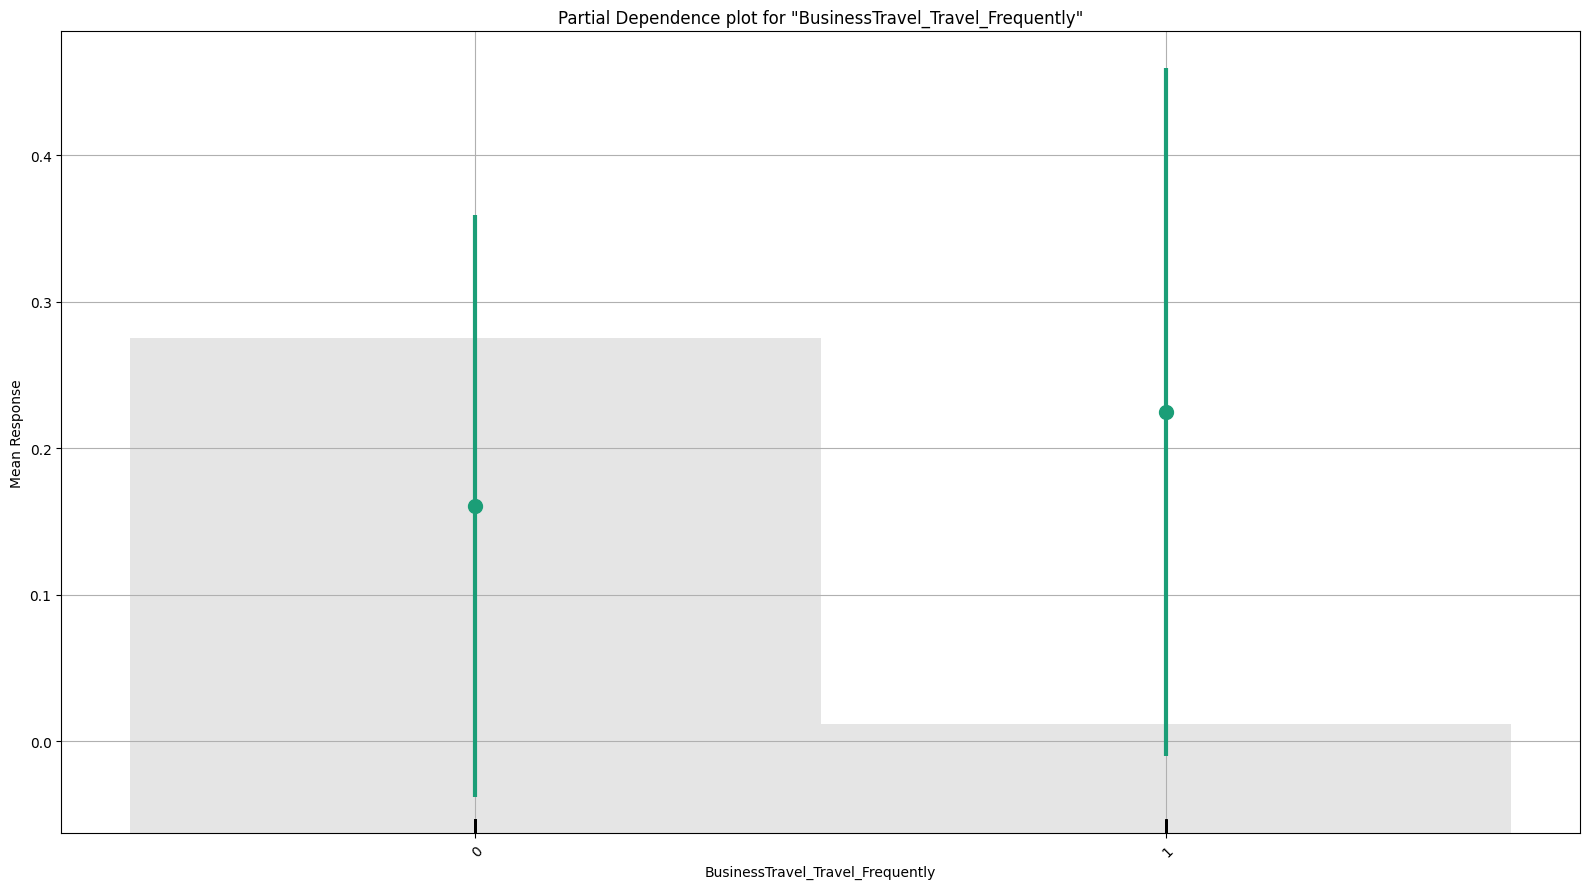

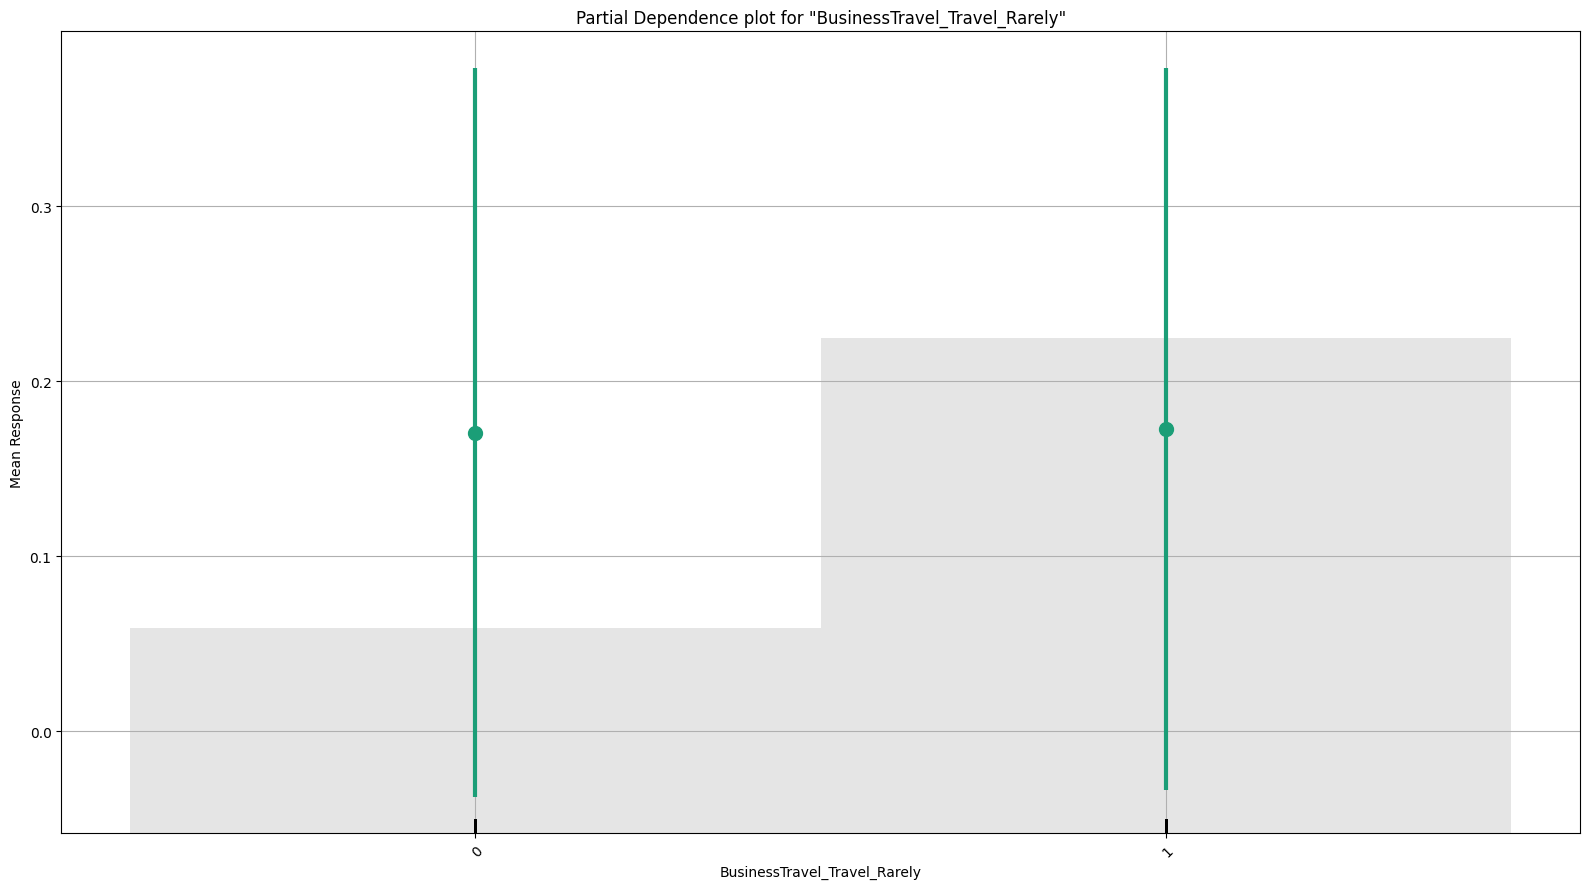

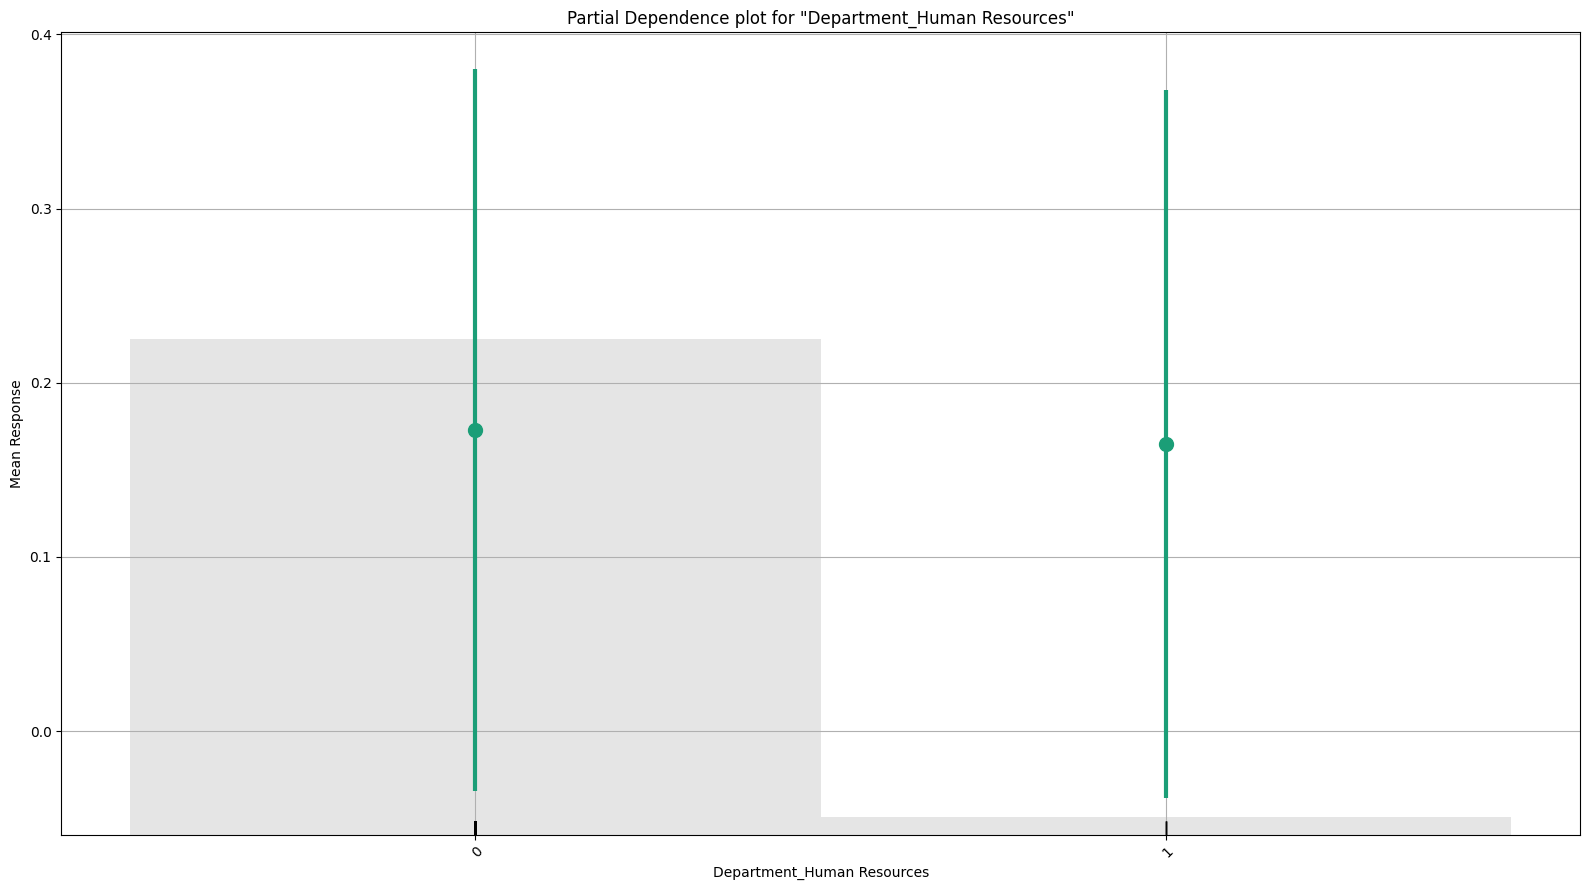

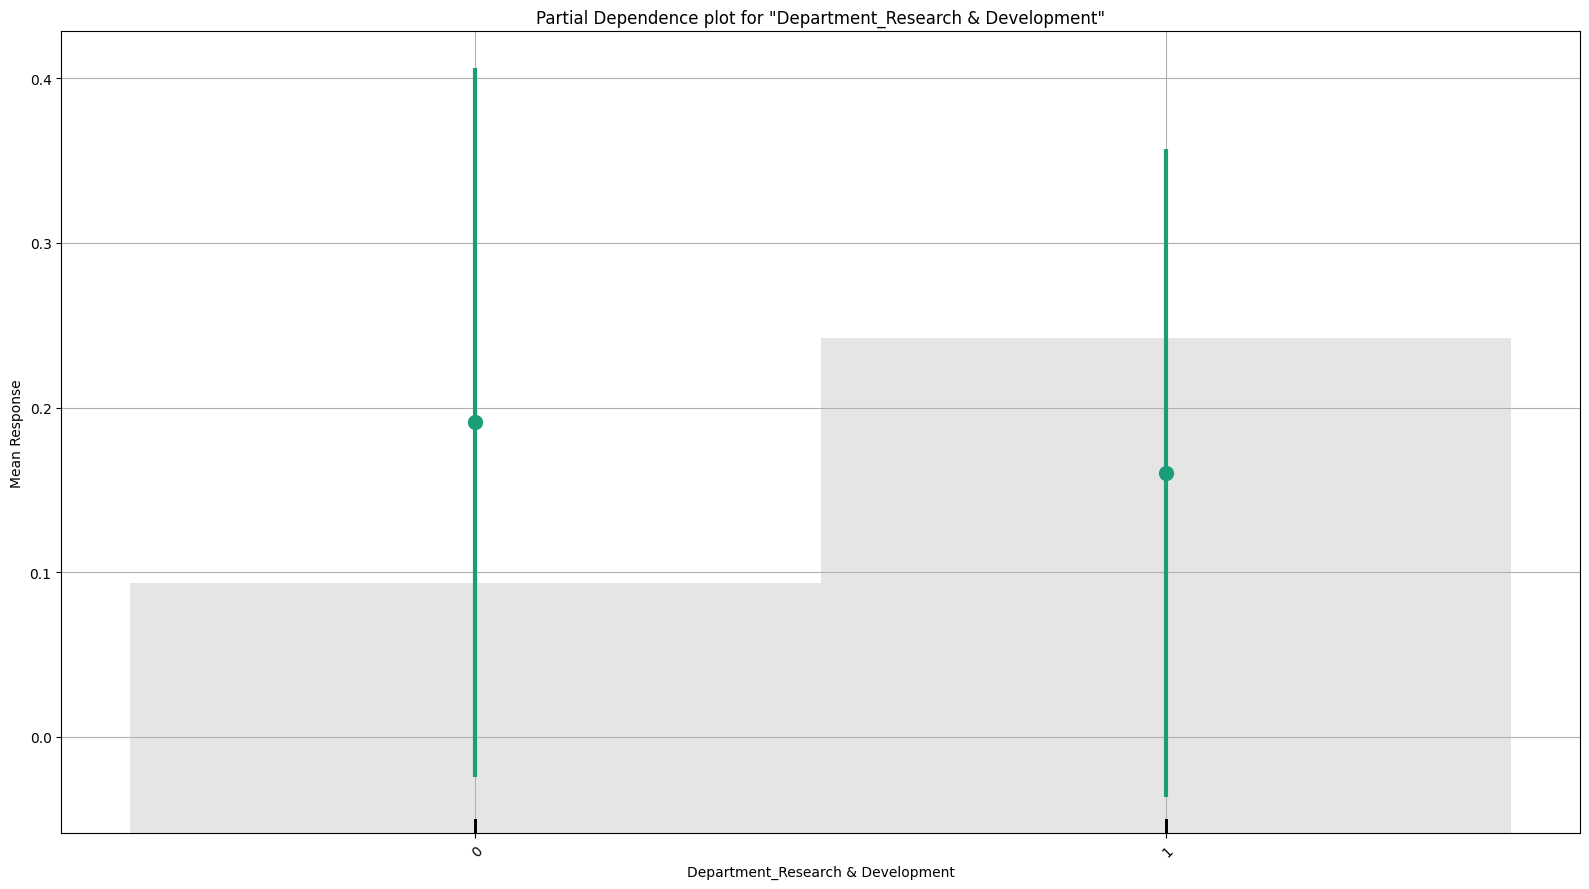

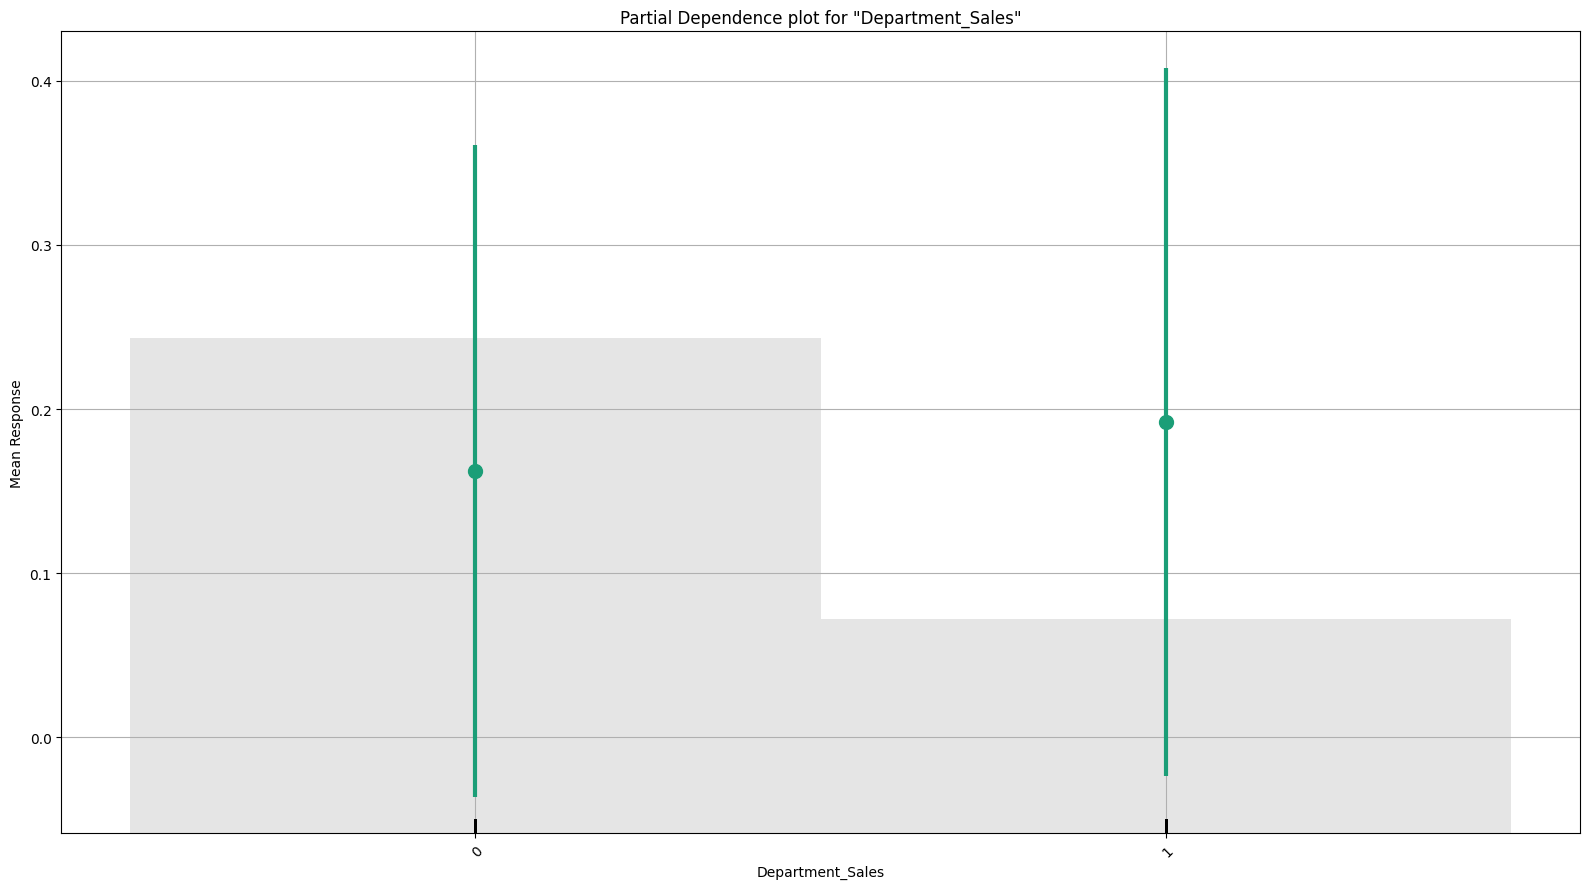

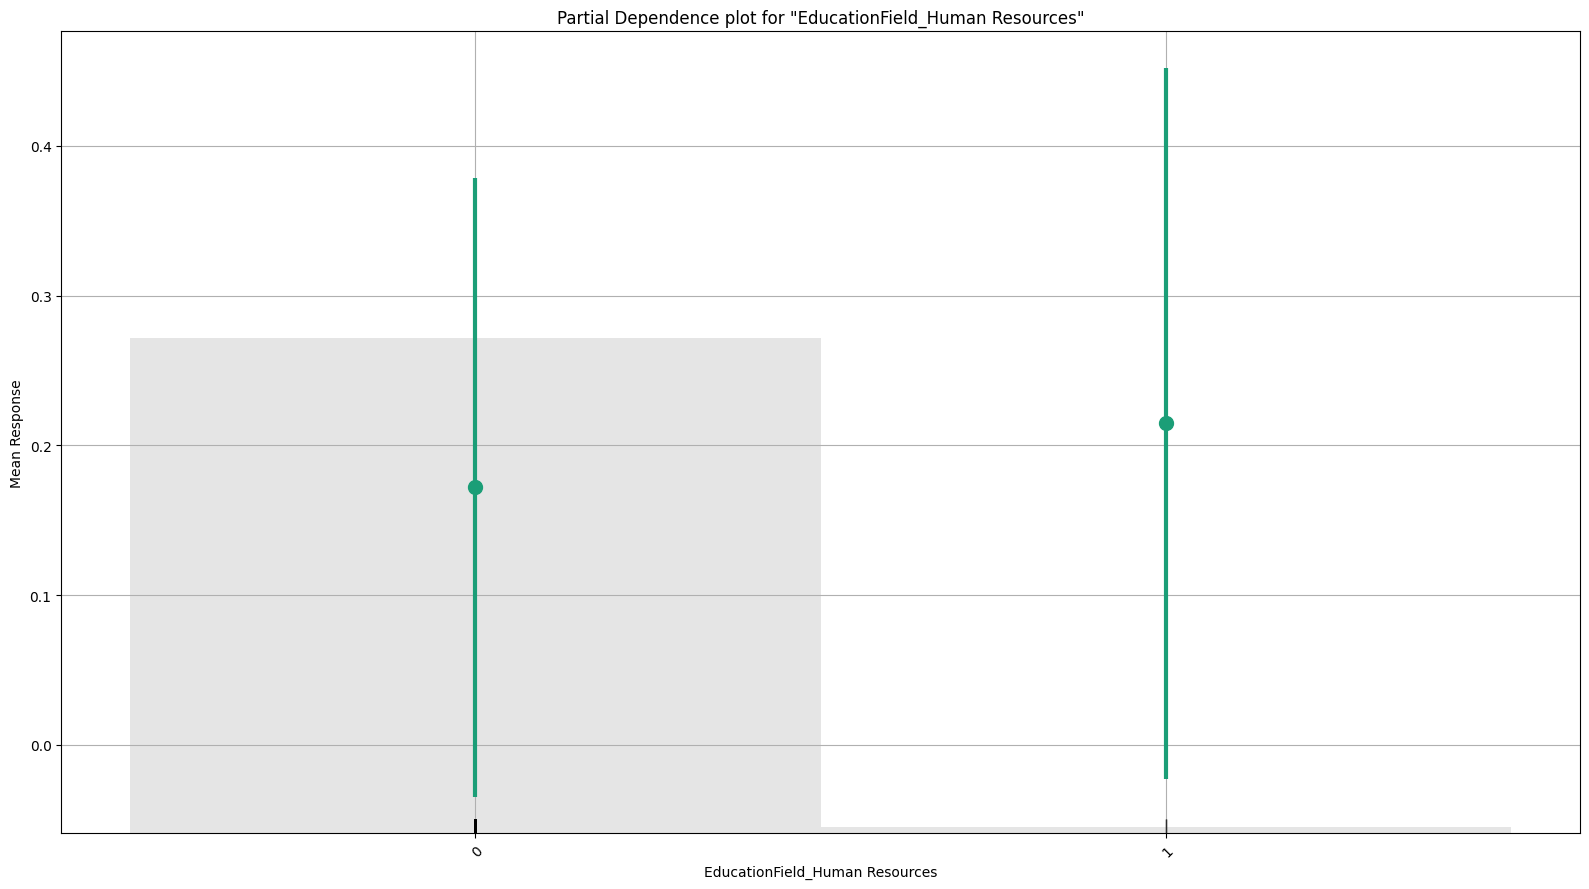

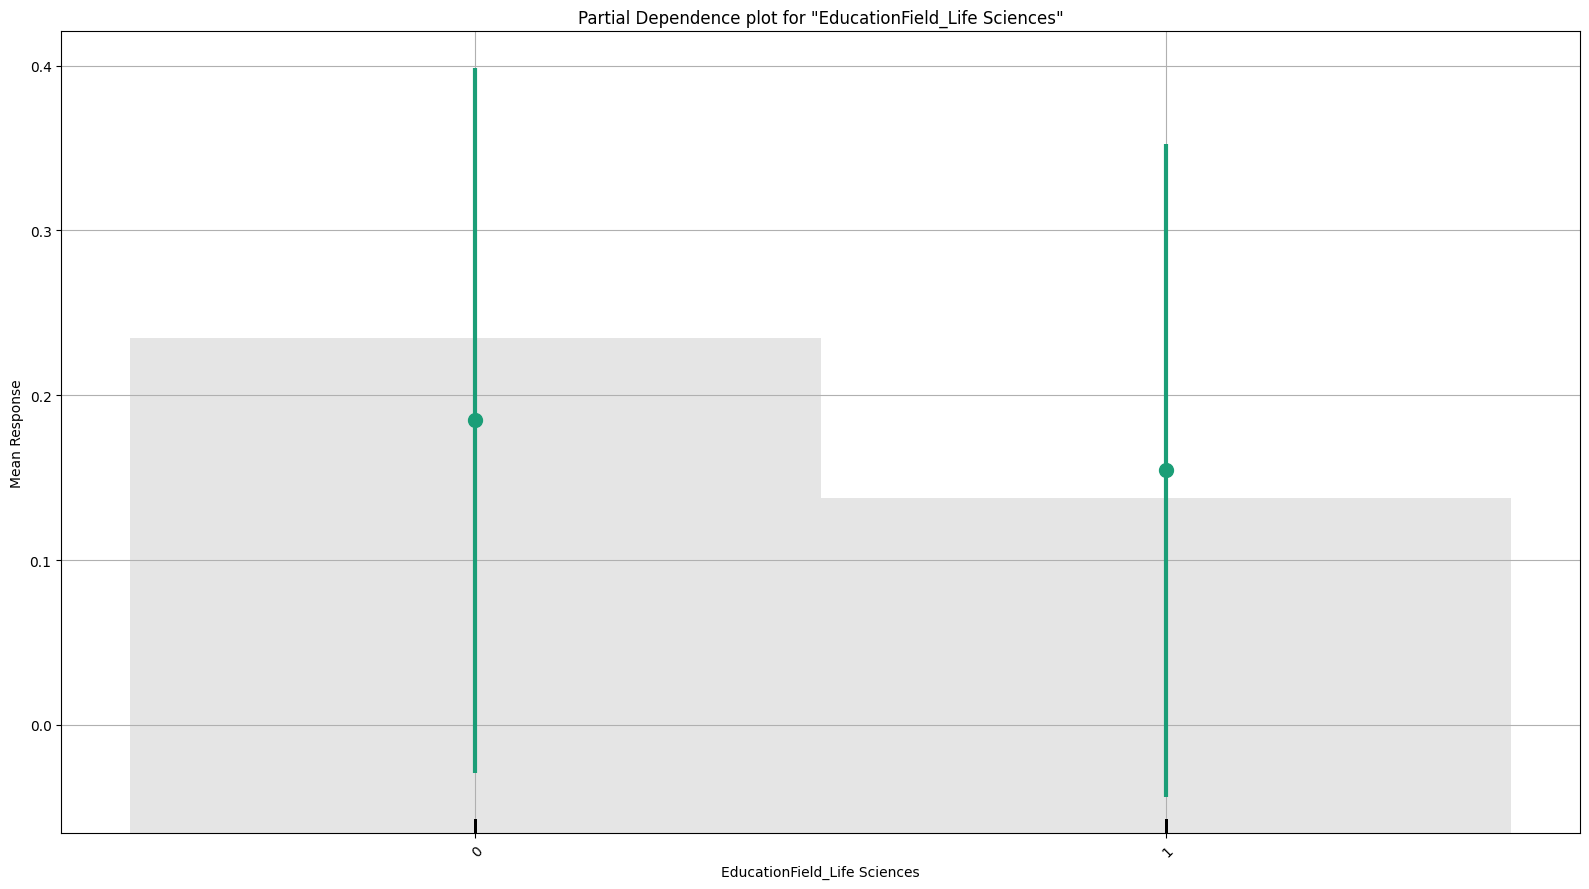

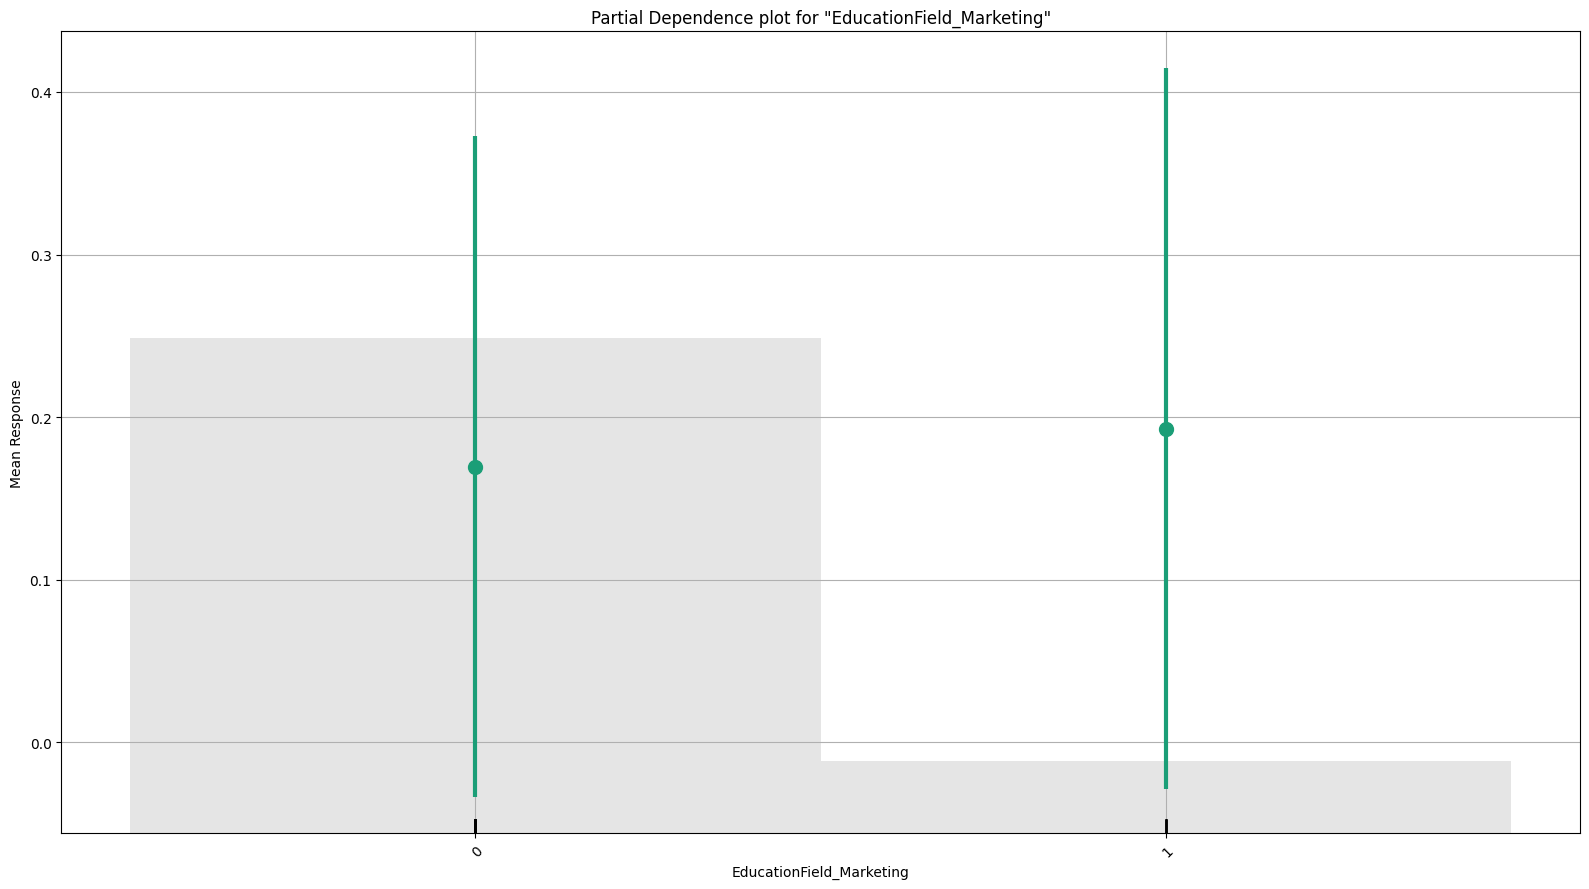

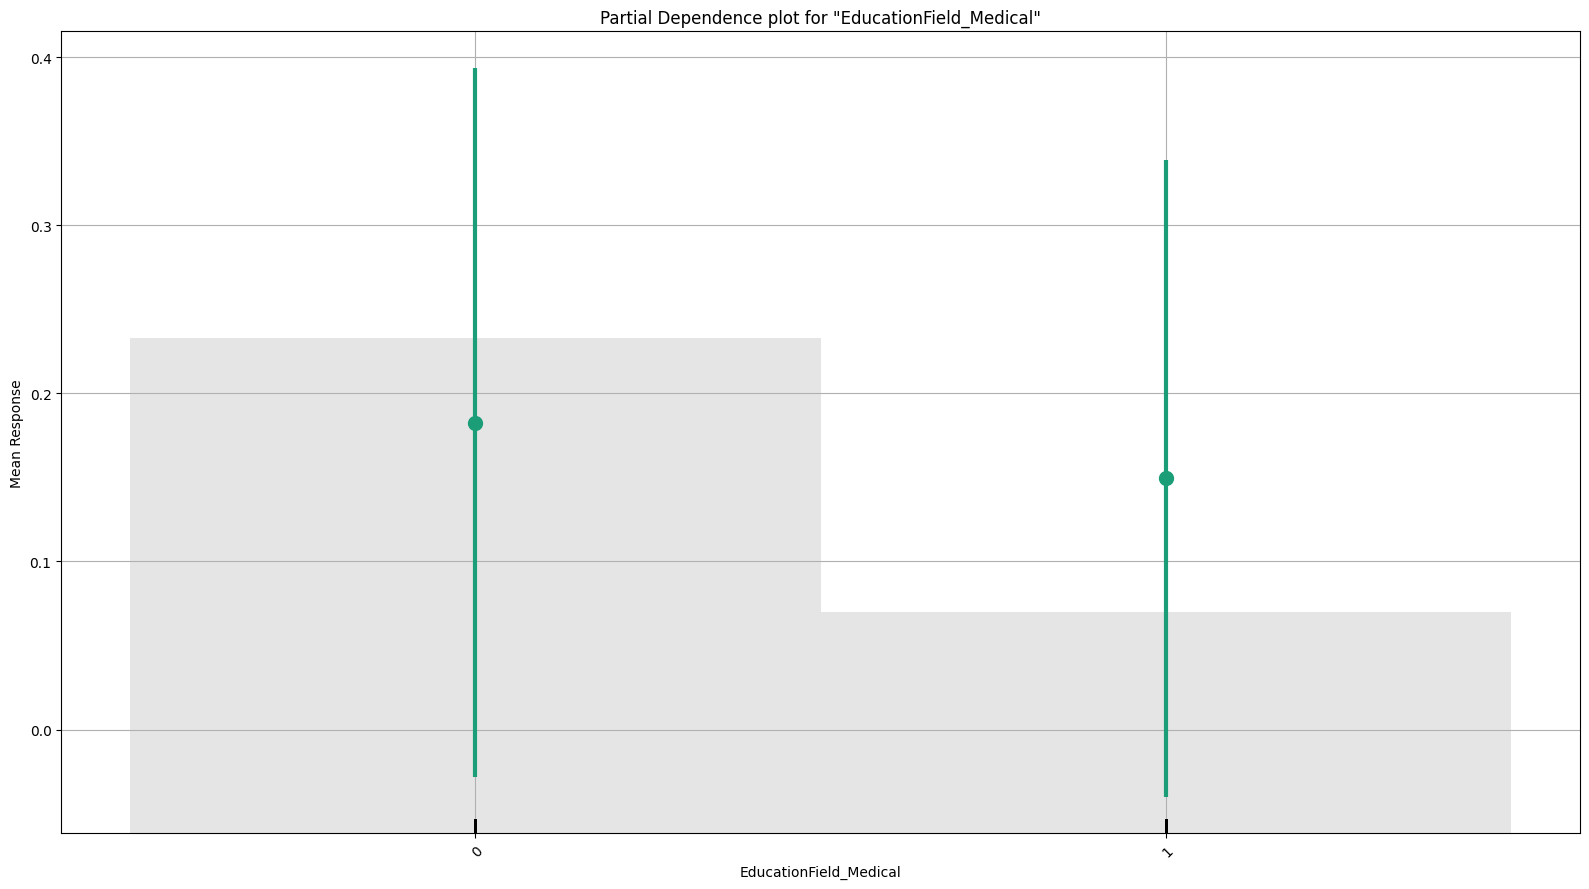

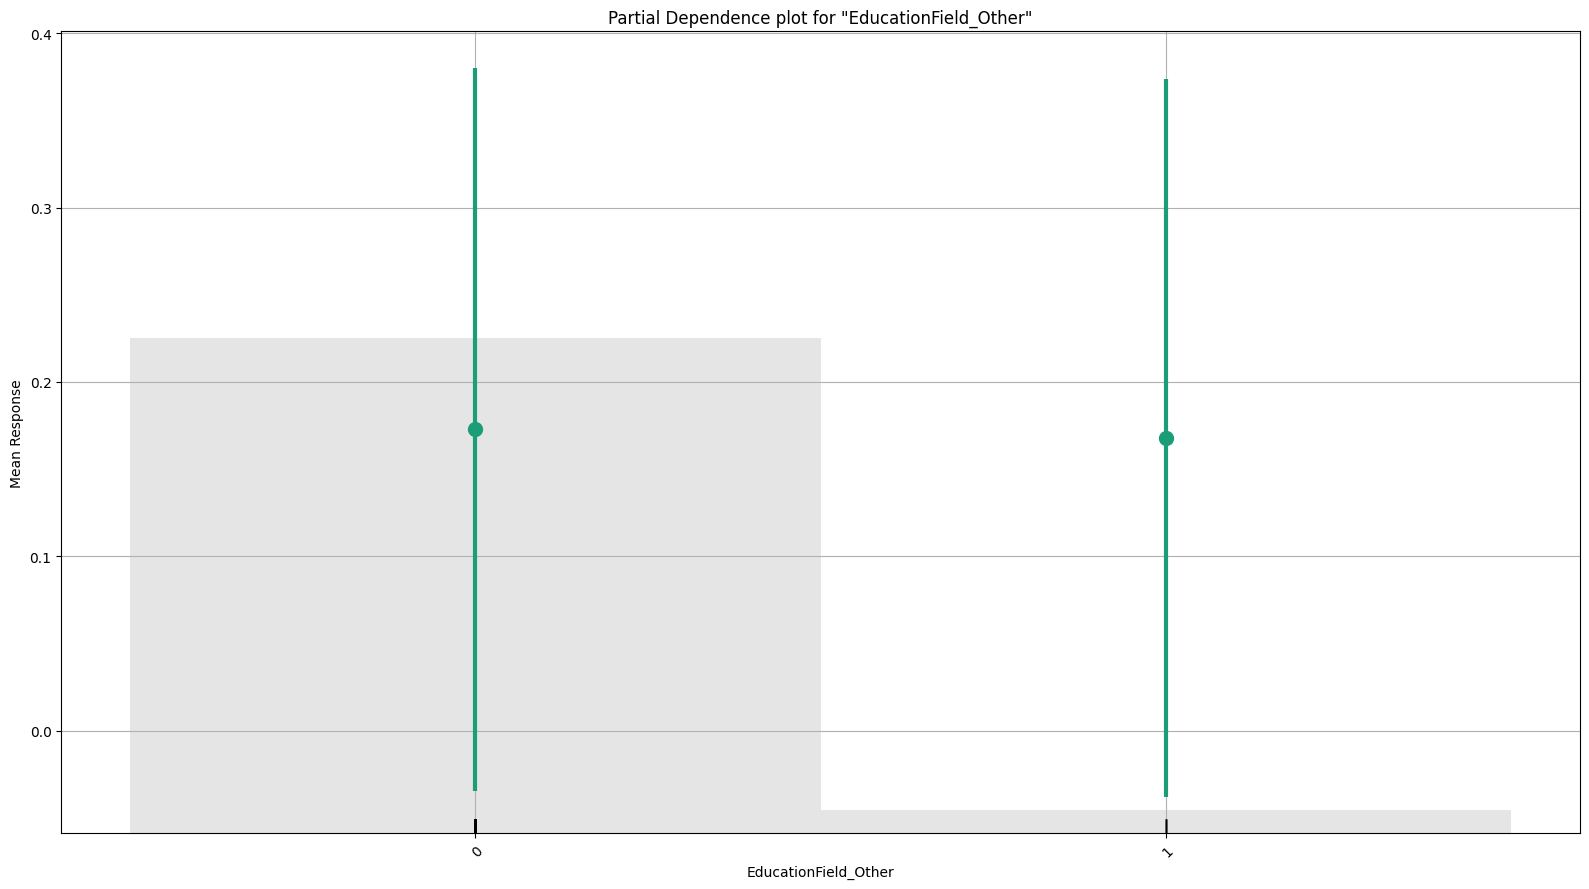

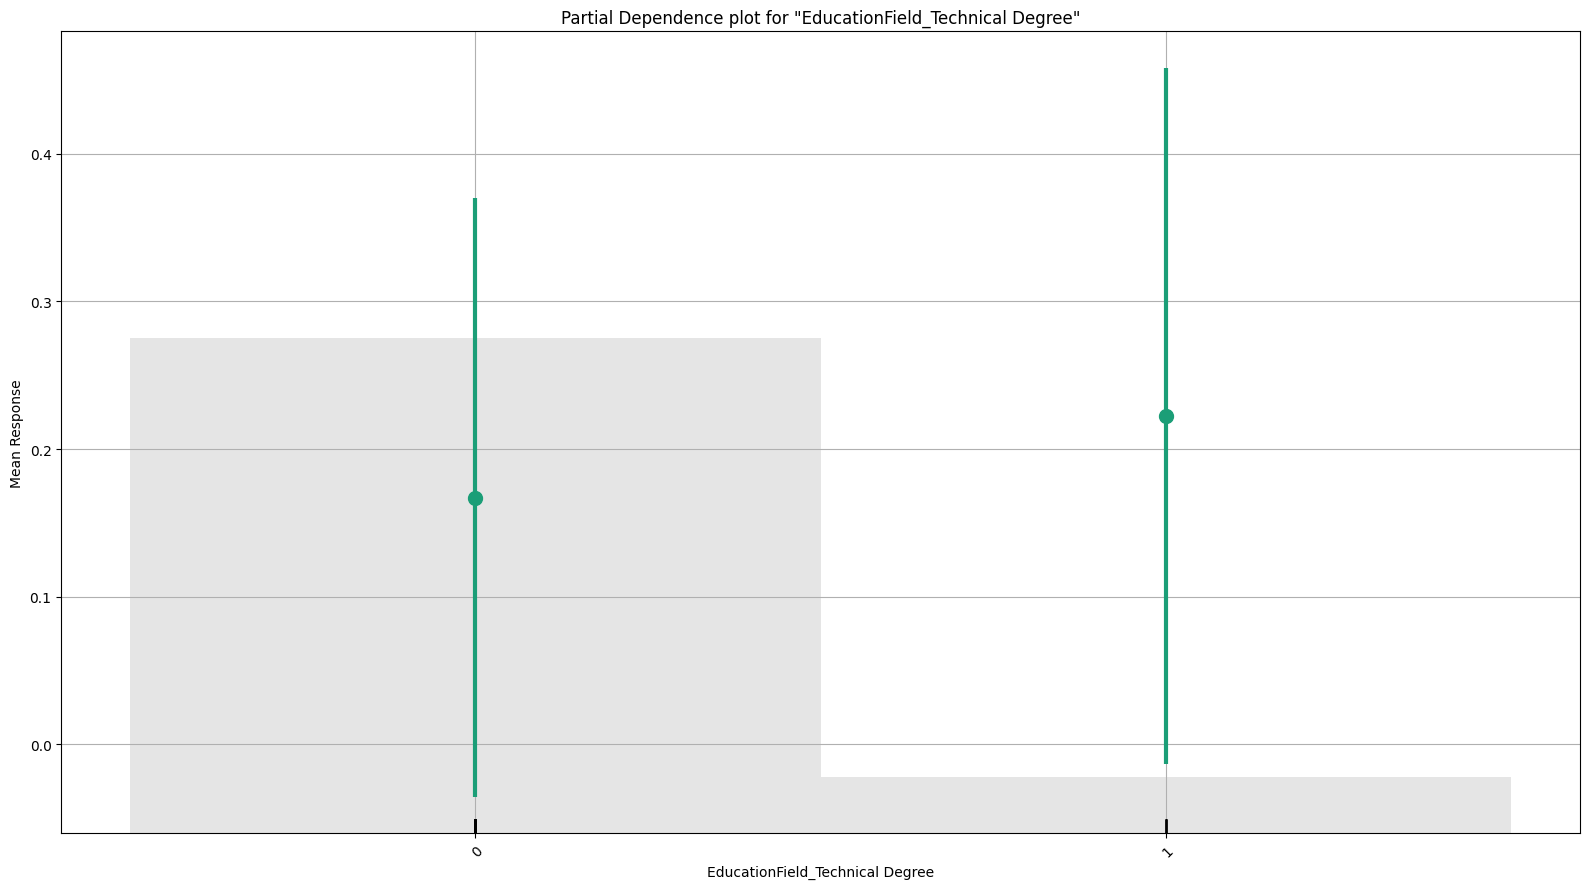

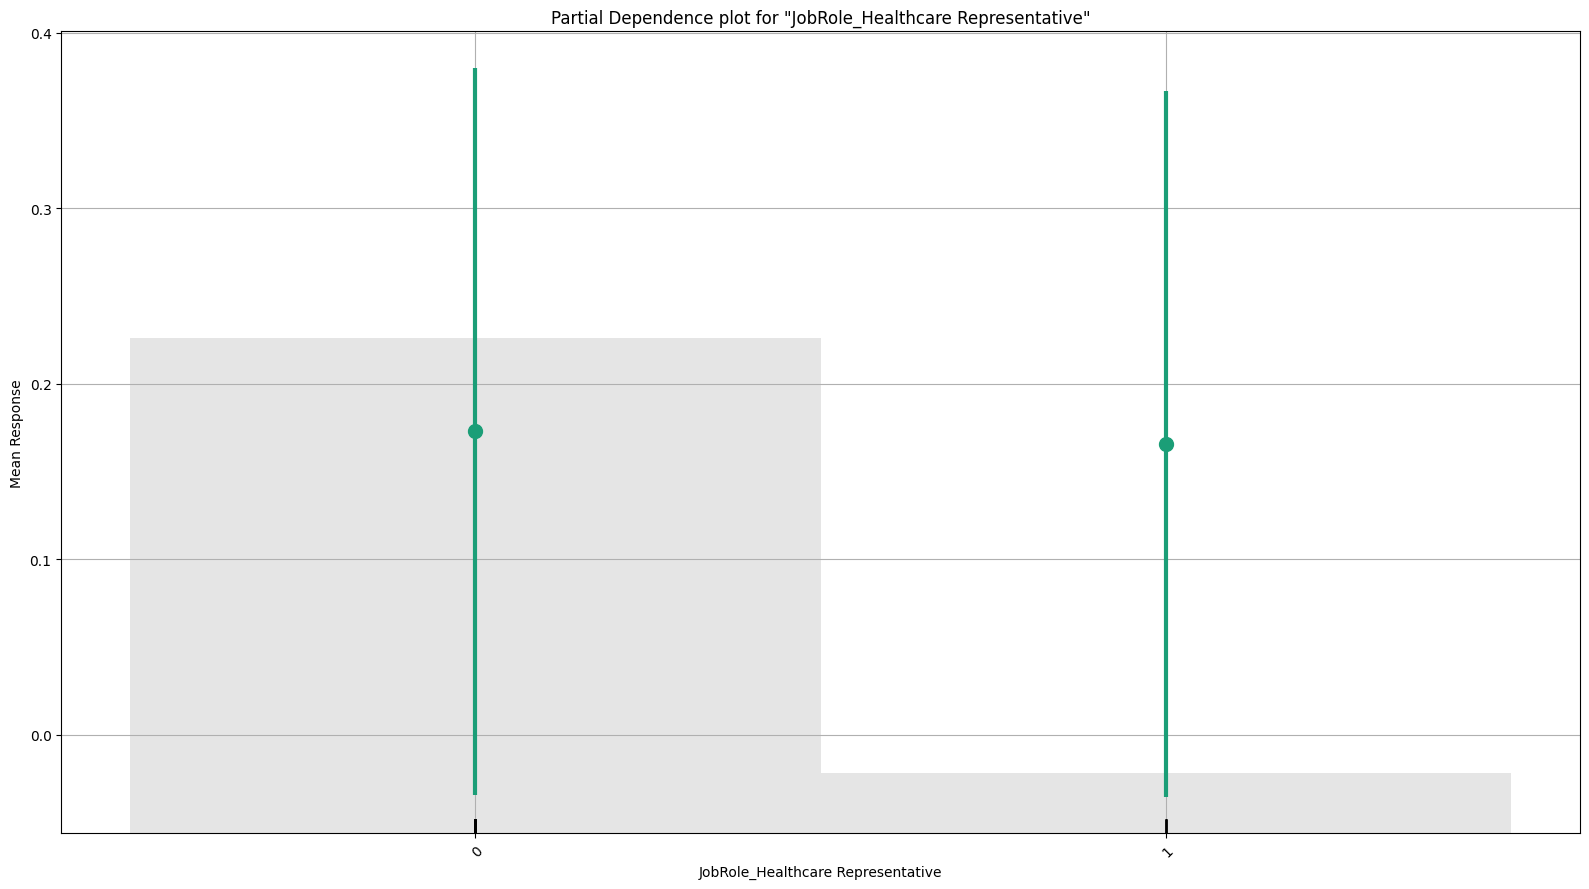

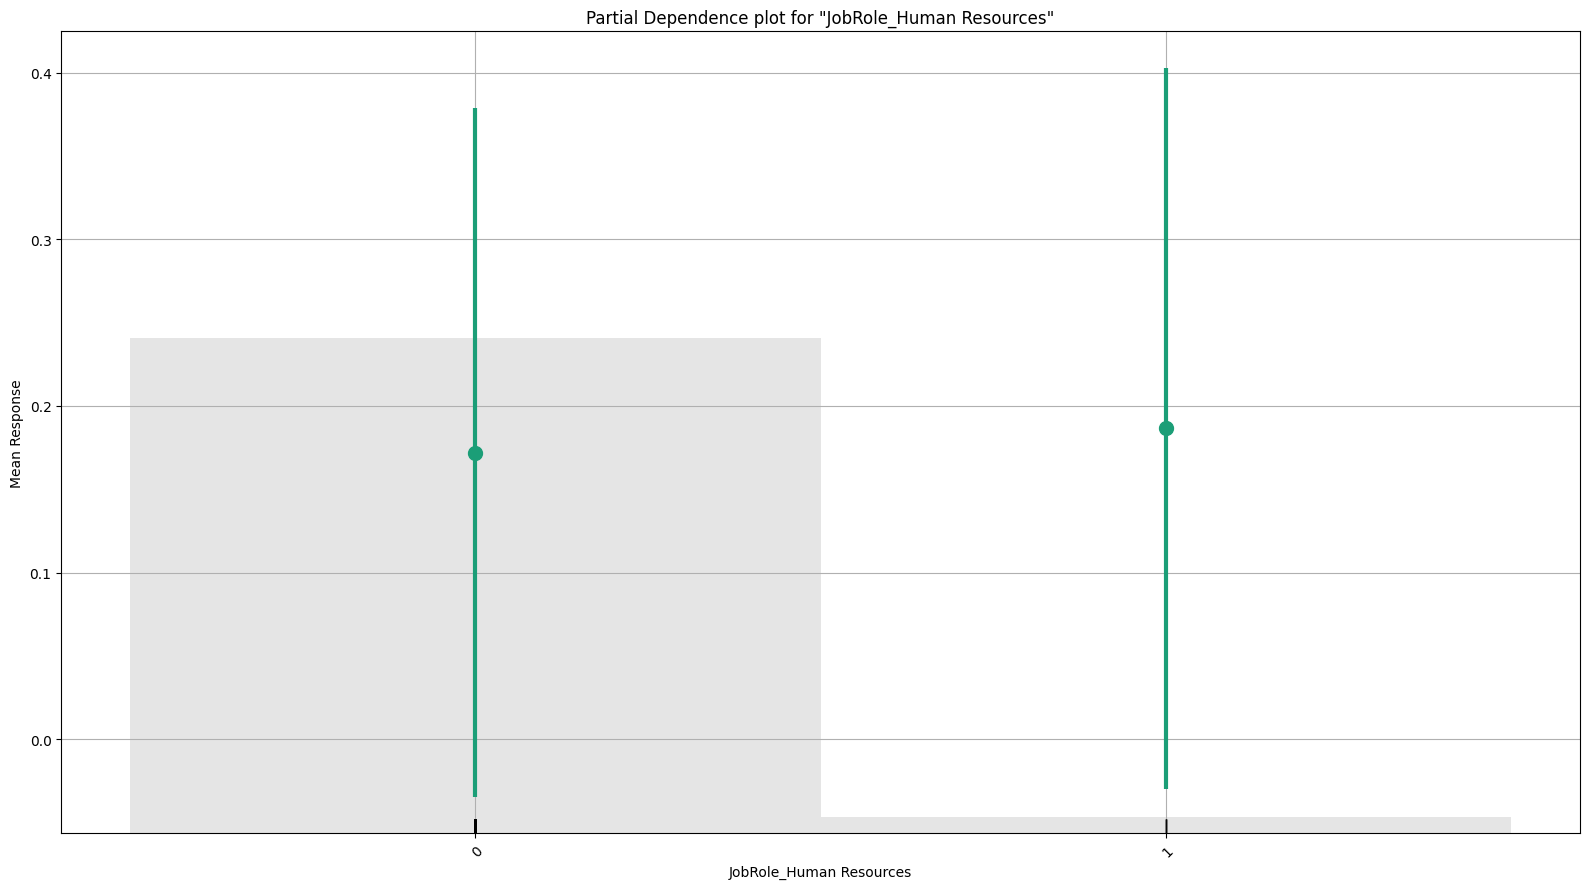

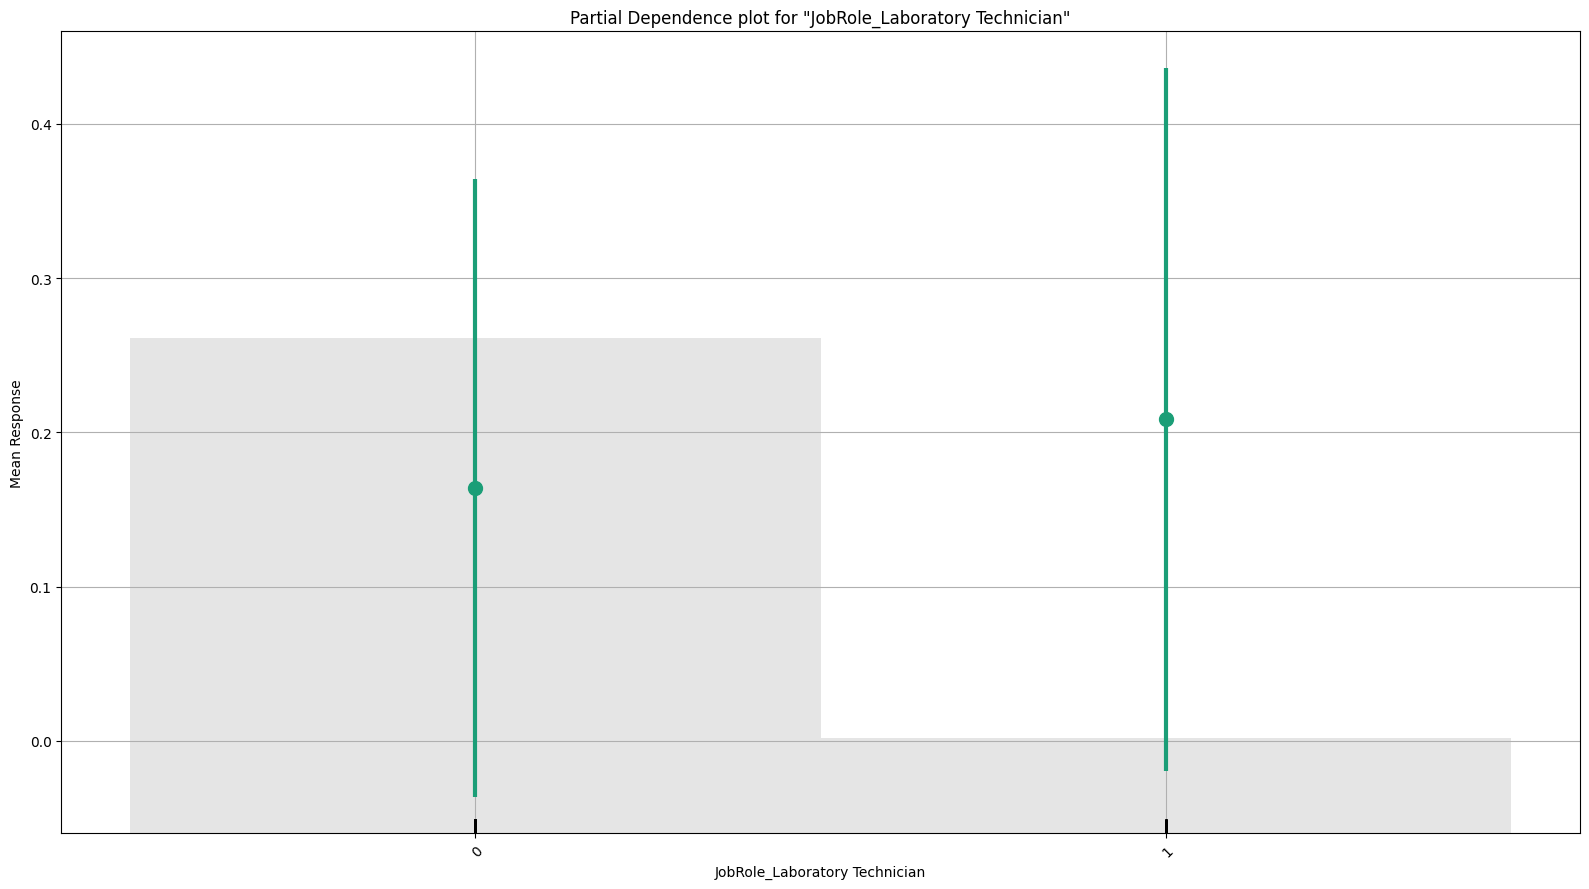

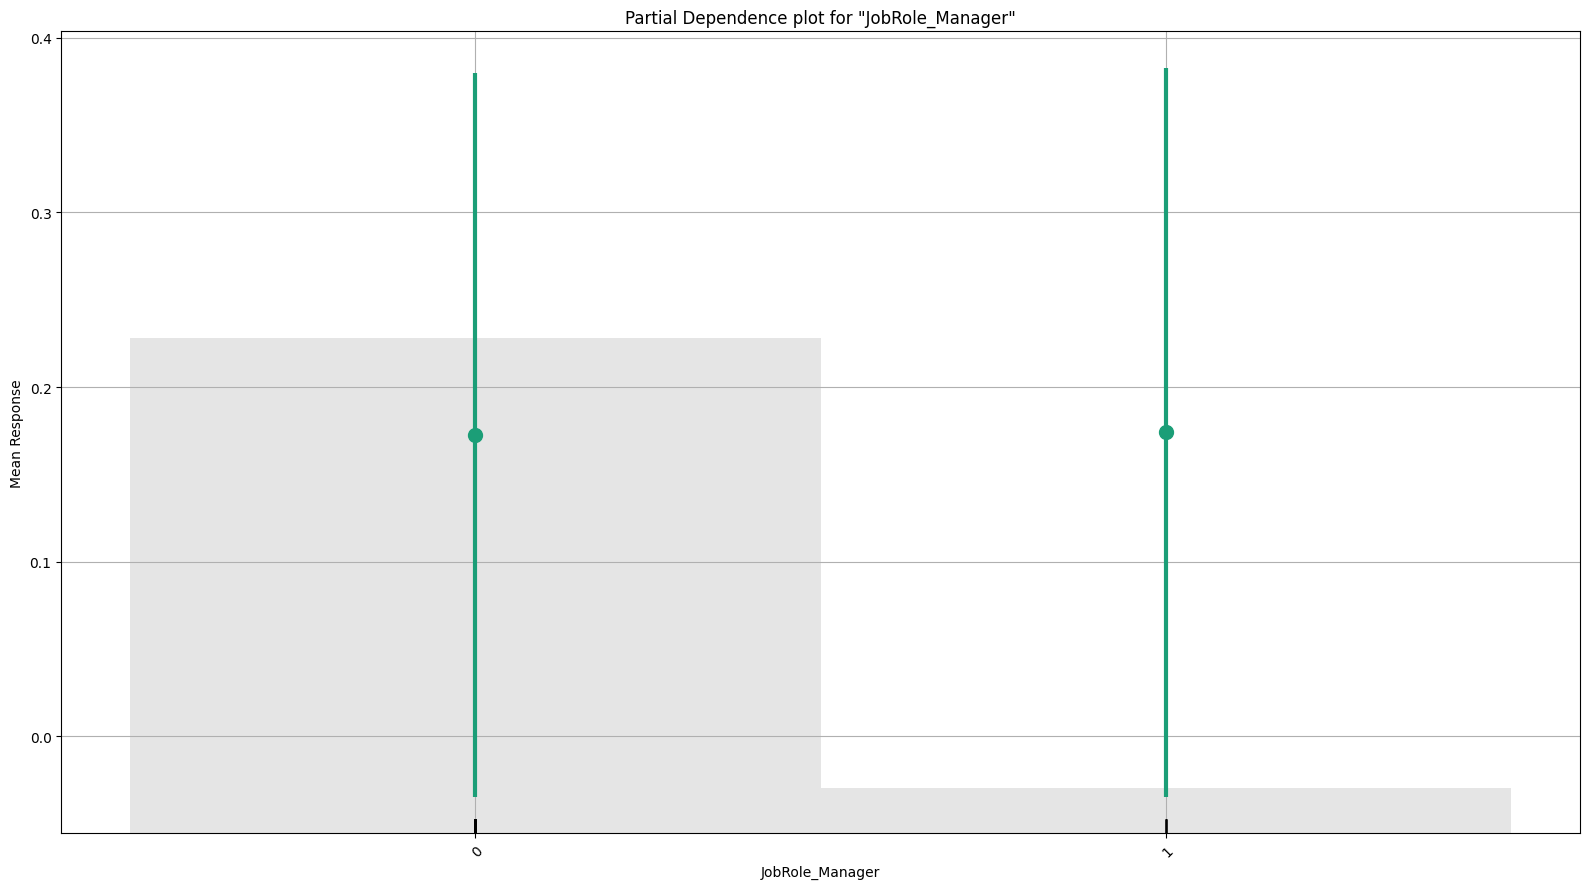

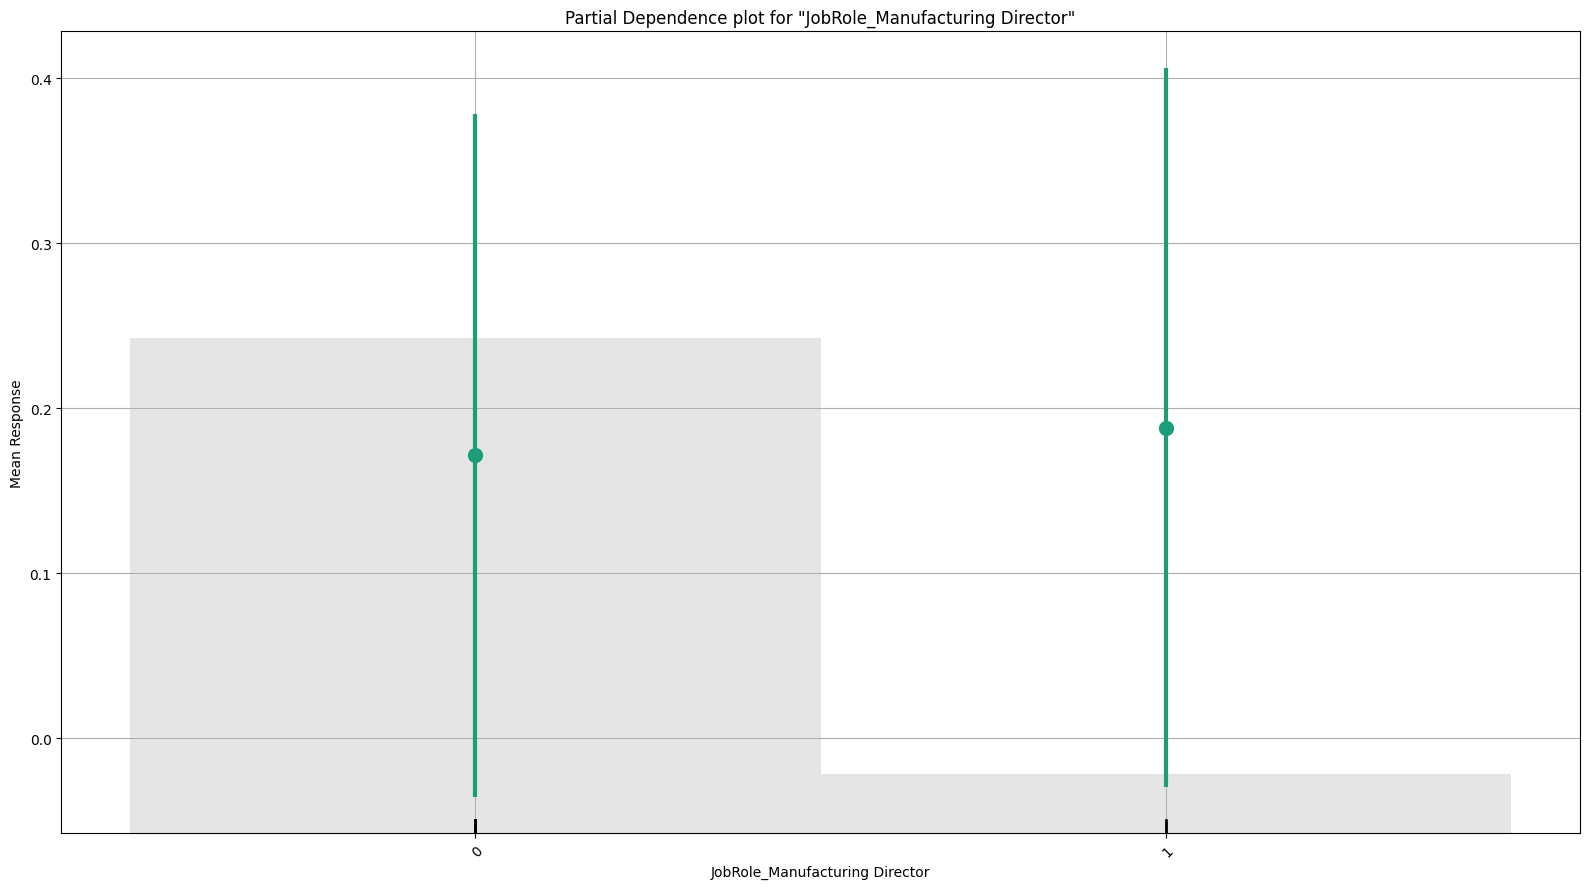

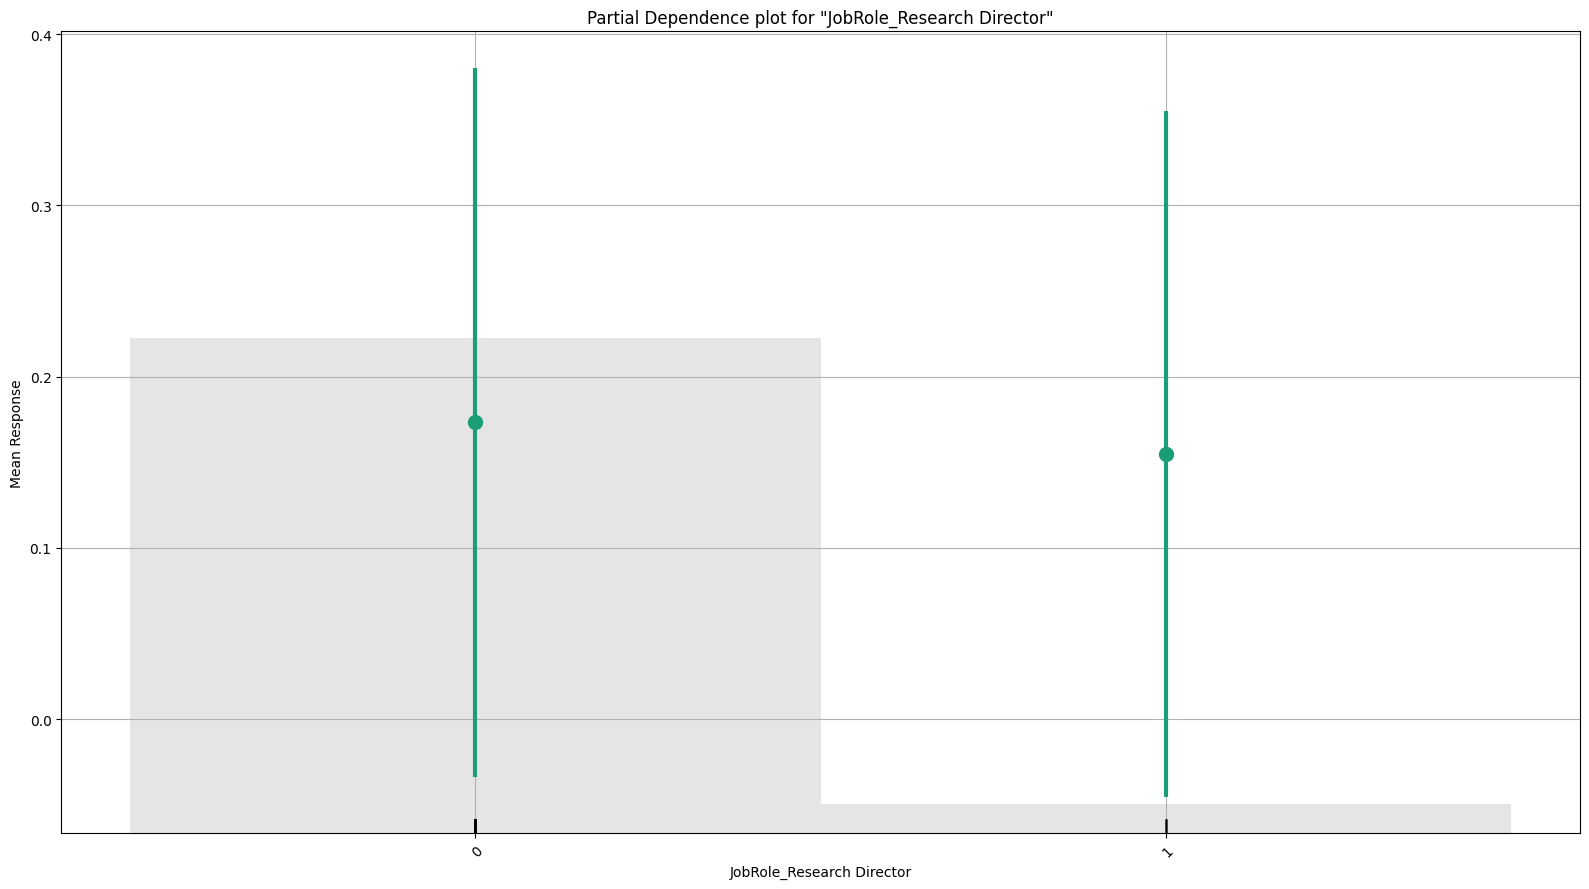

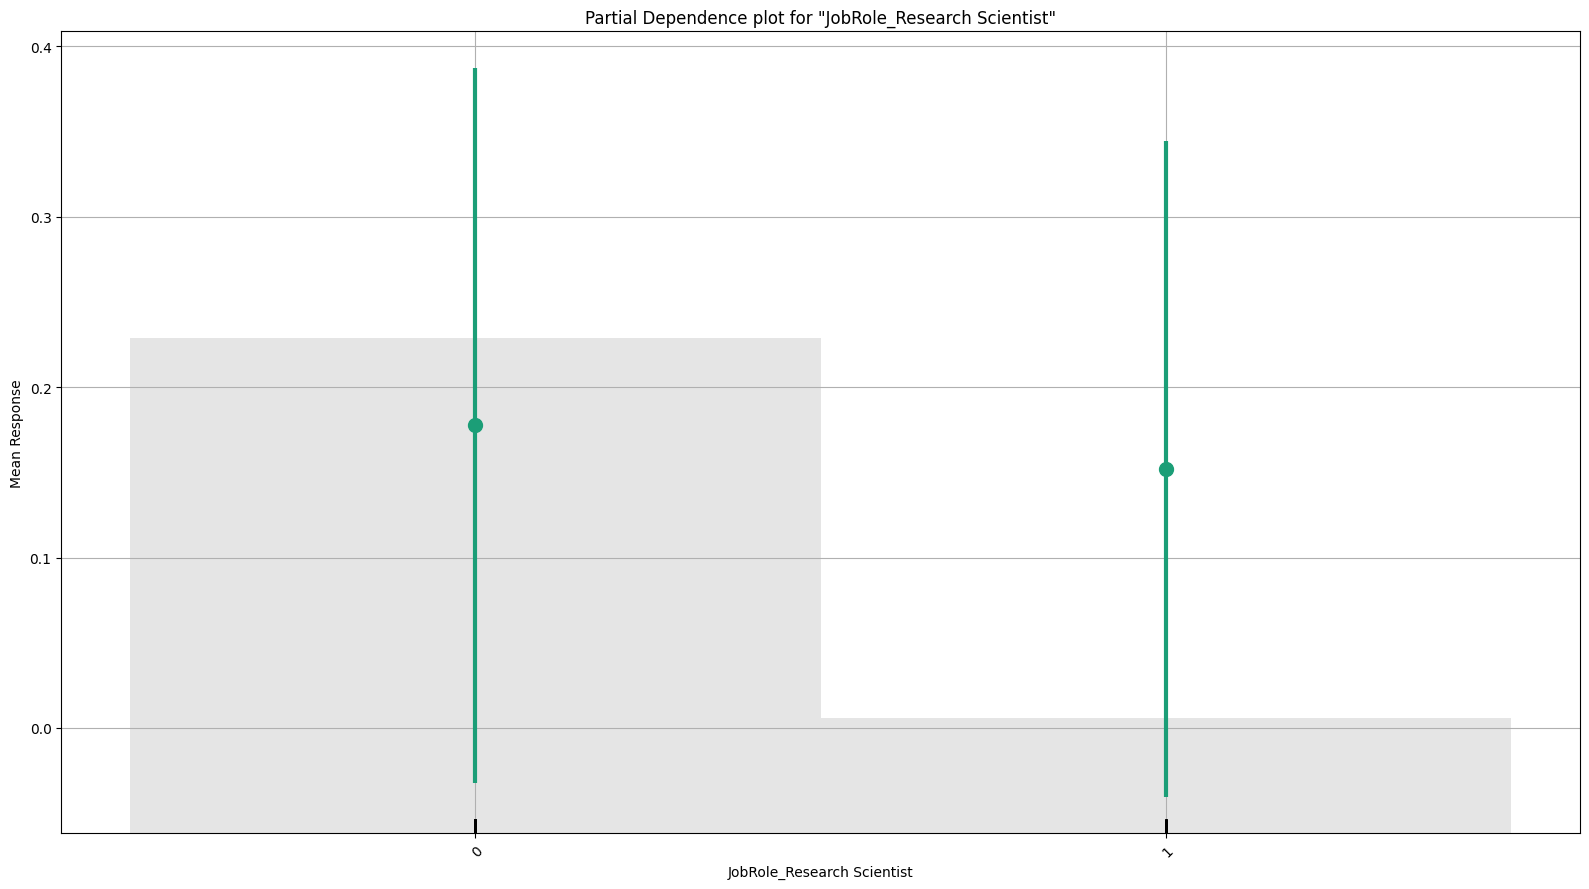

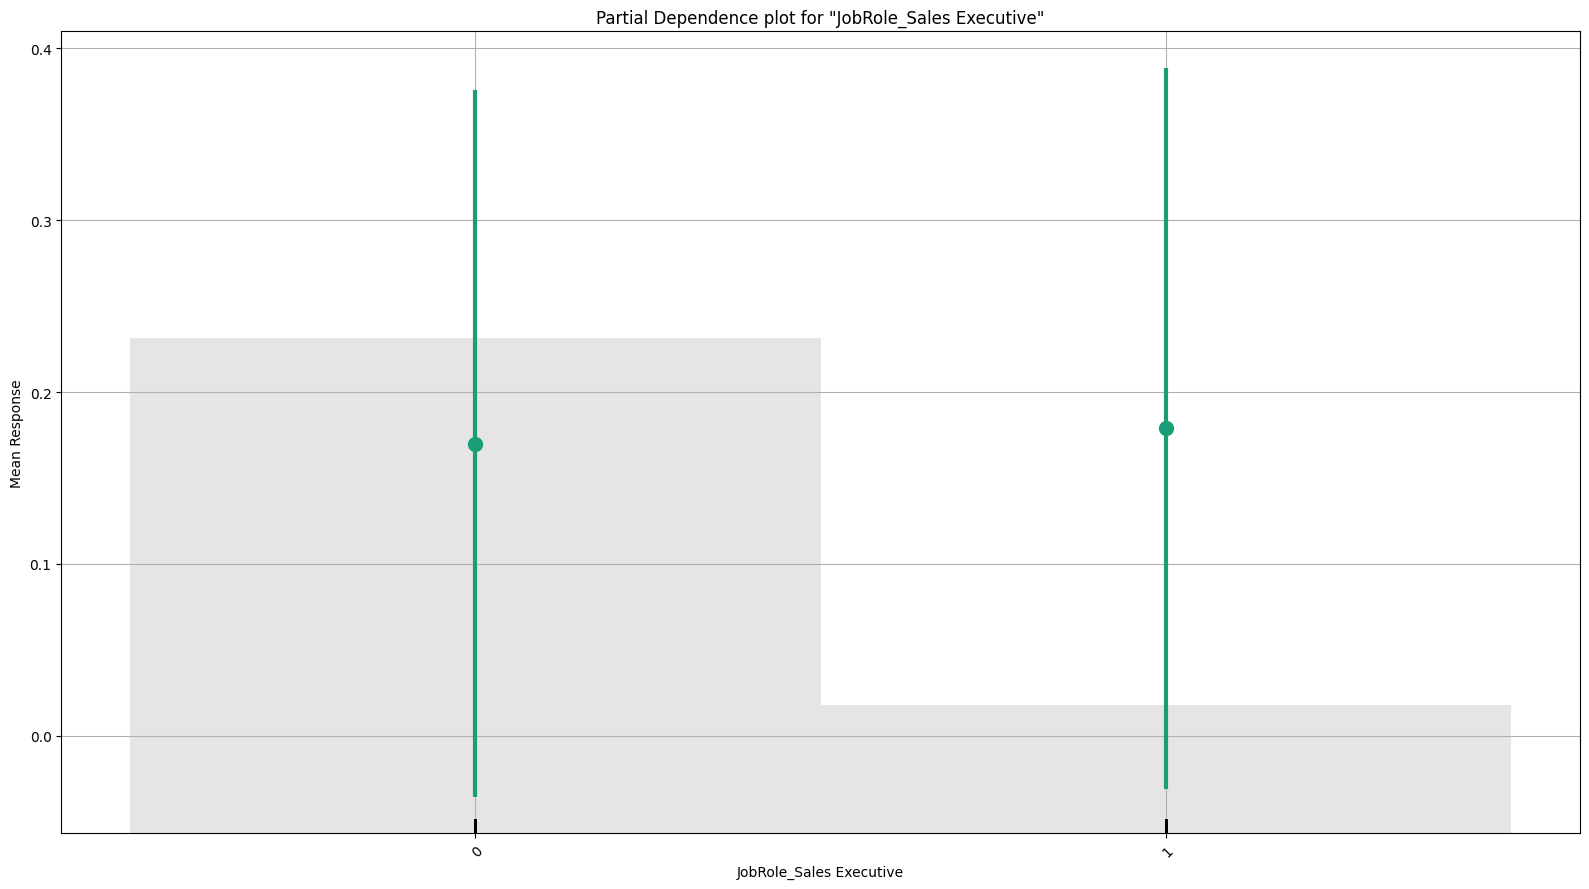

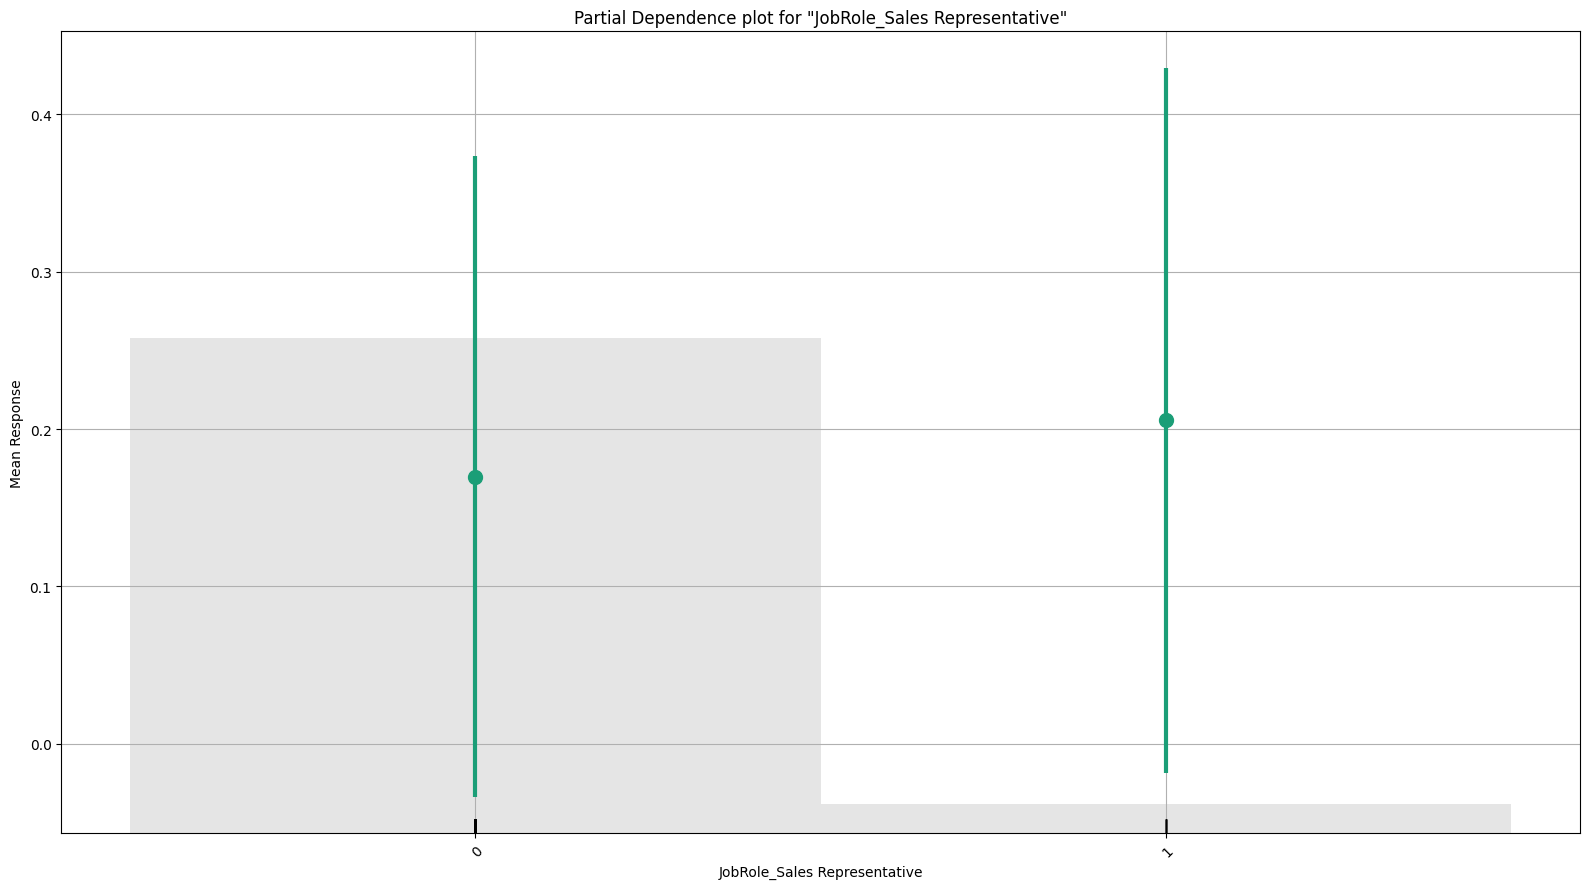

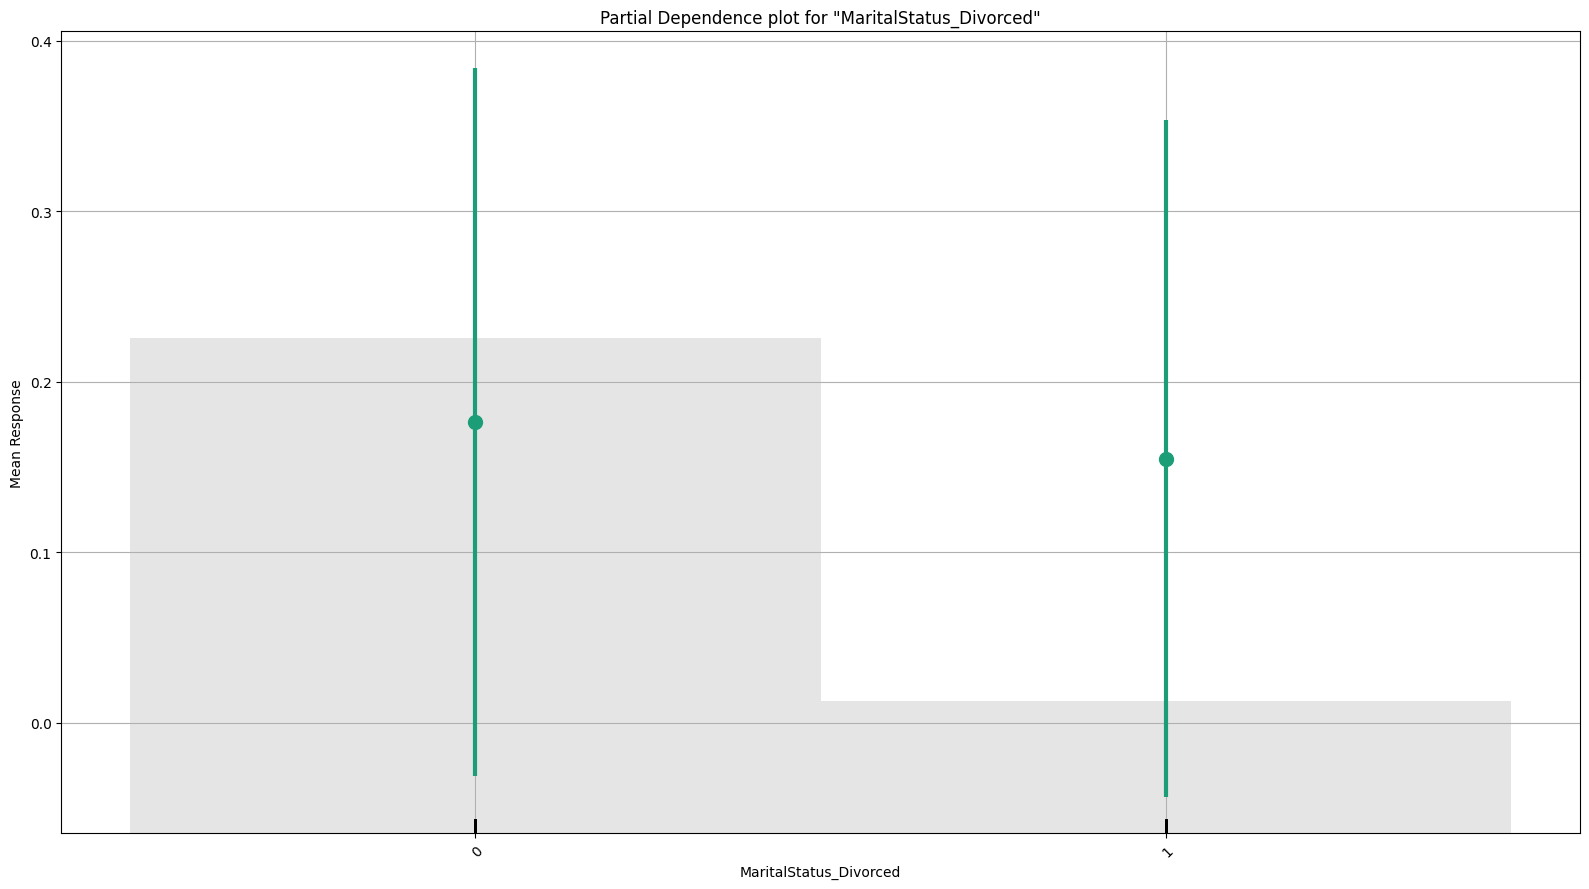

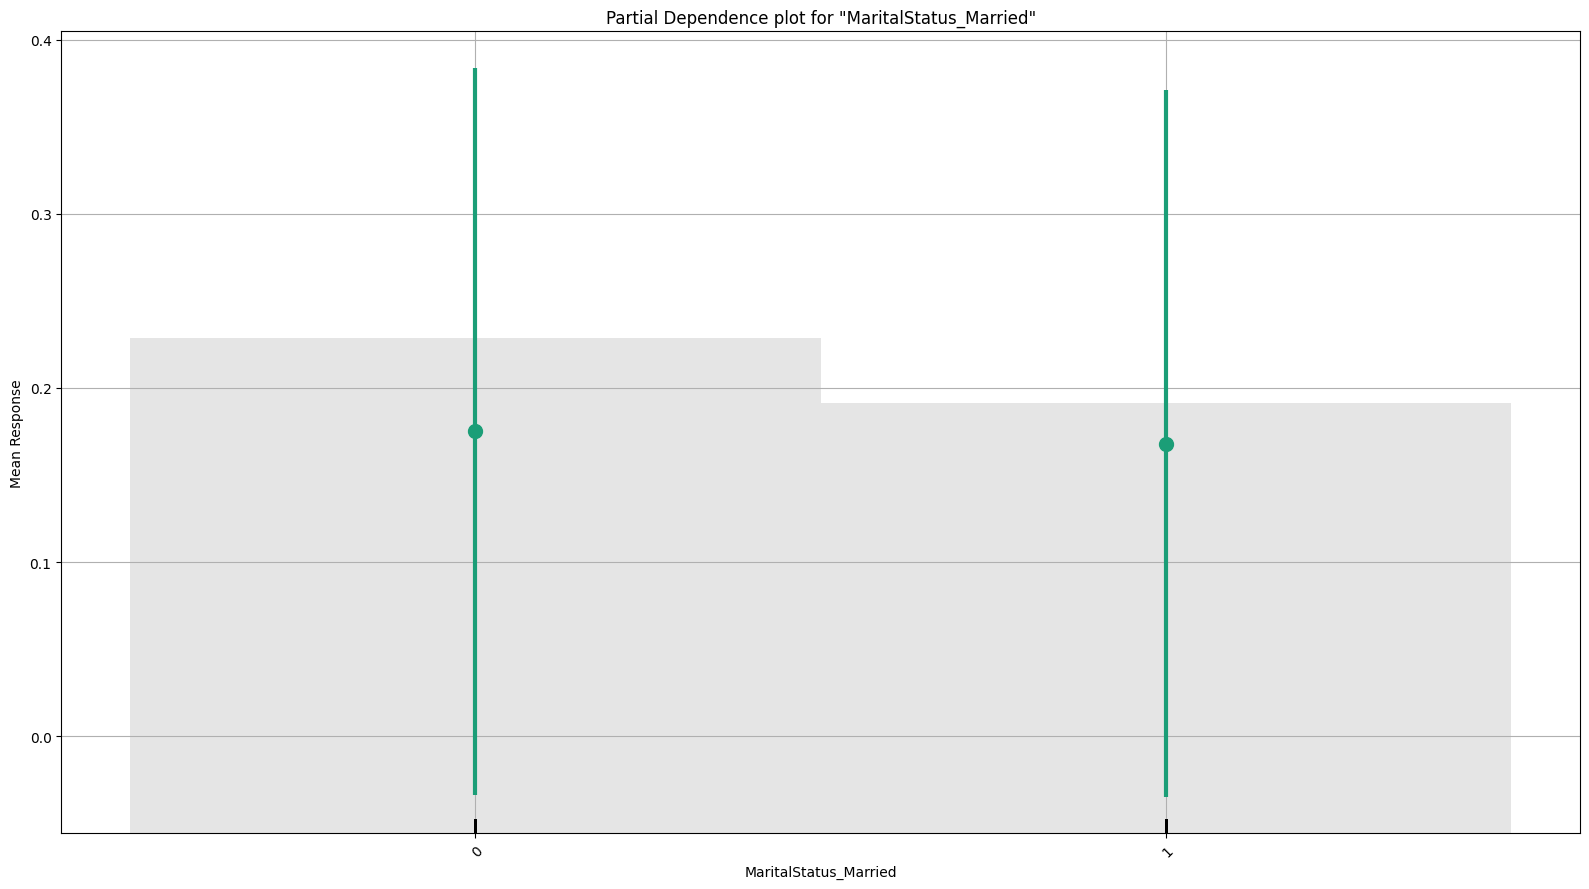

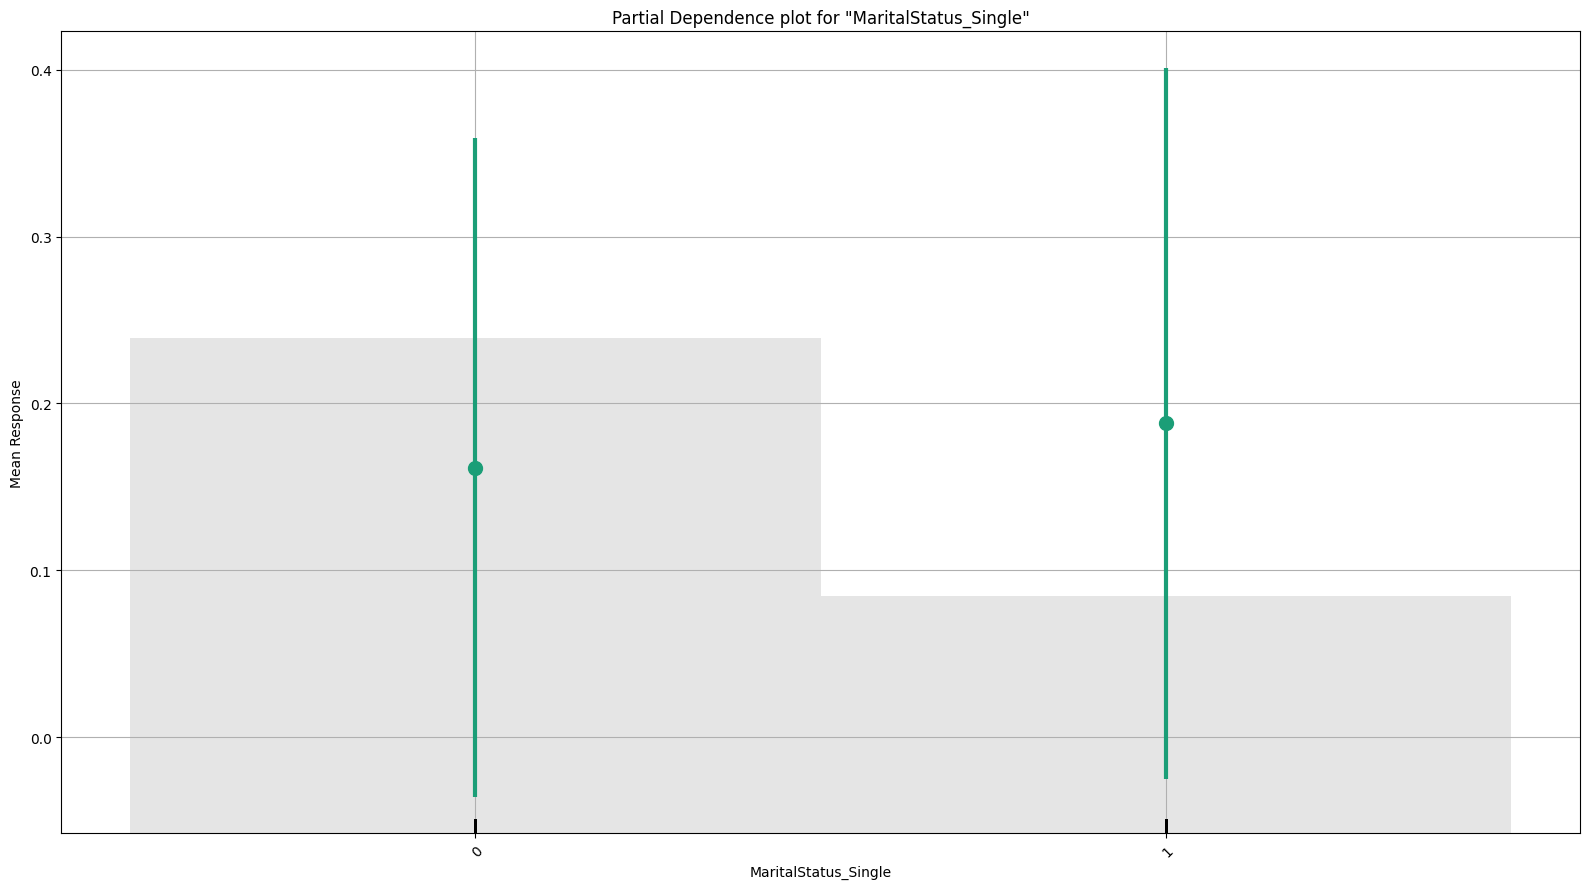

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_1_AutoML_1_20250326_214224

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4769020202393899
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      377  7    0.0182   (7.0/384.0)
1      21   36   0.3684   (21.0/57.0)
Total  398  43   0.0635   (28.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

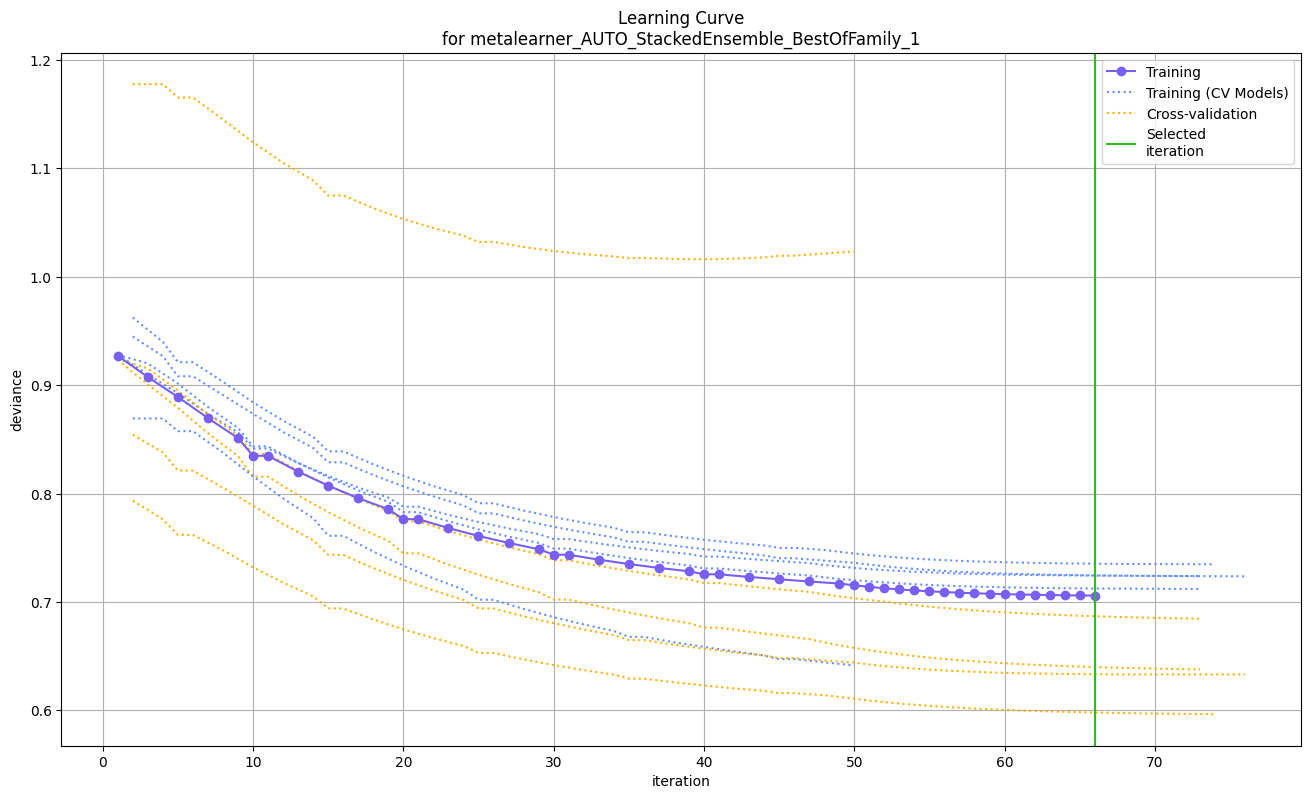

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

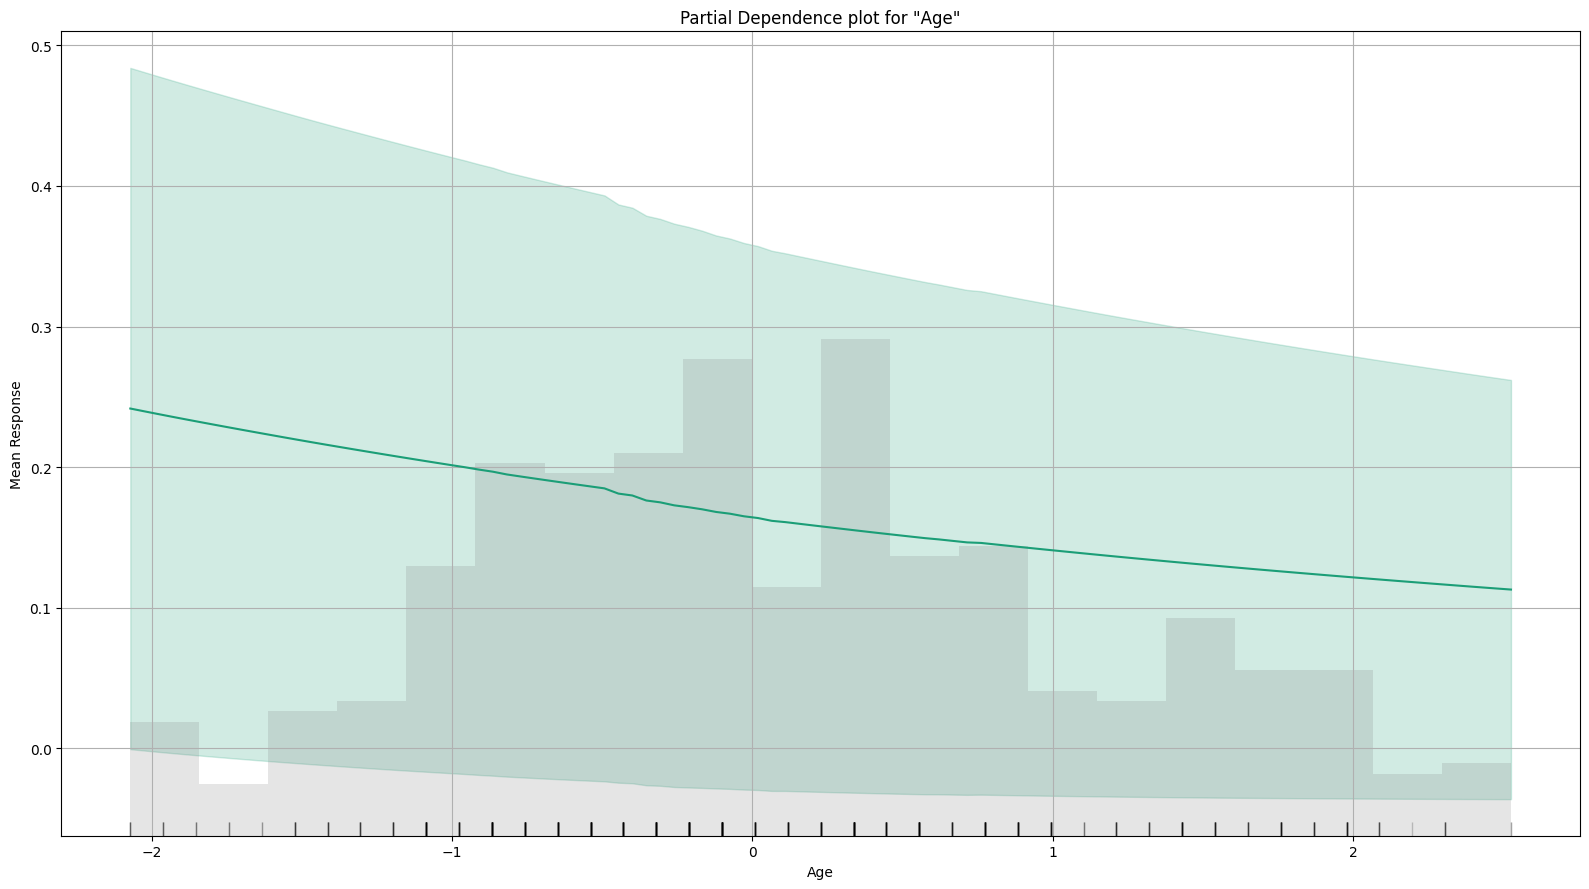

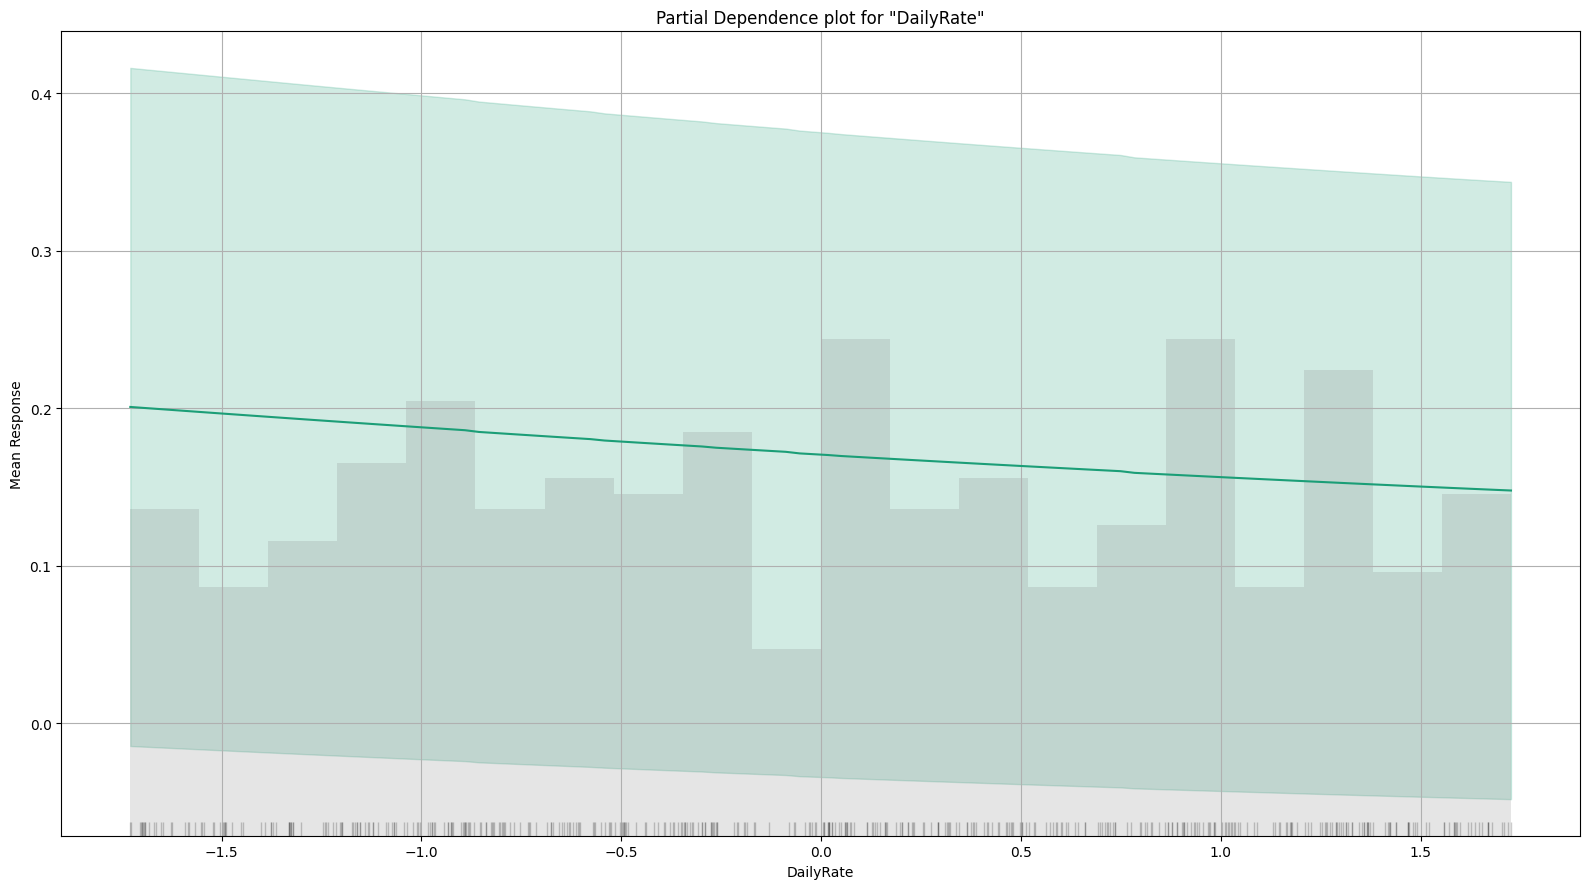

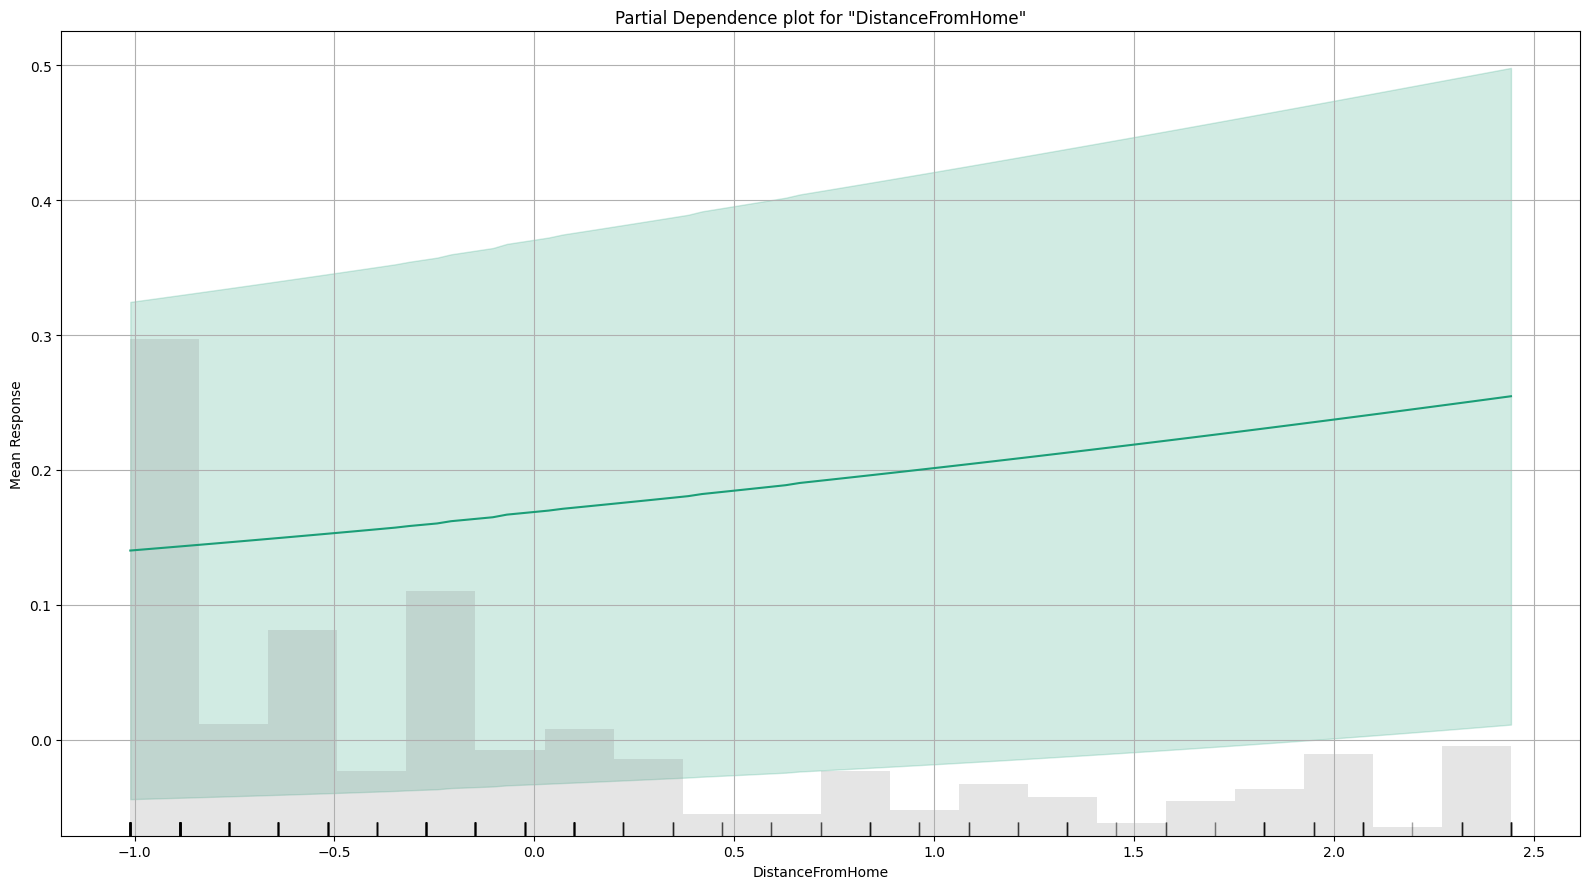

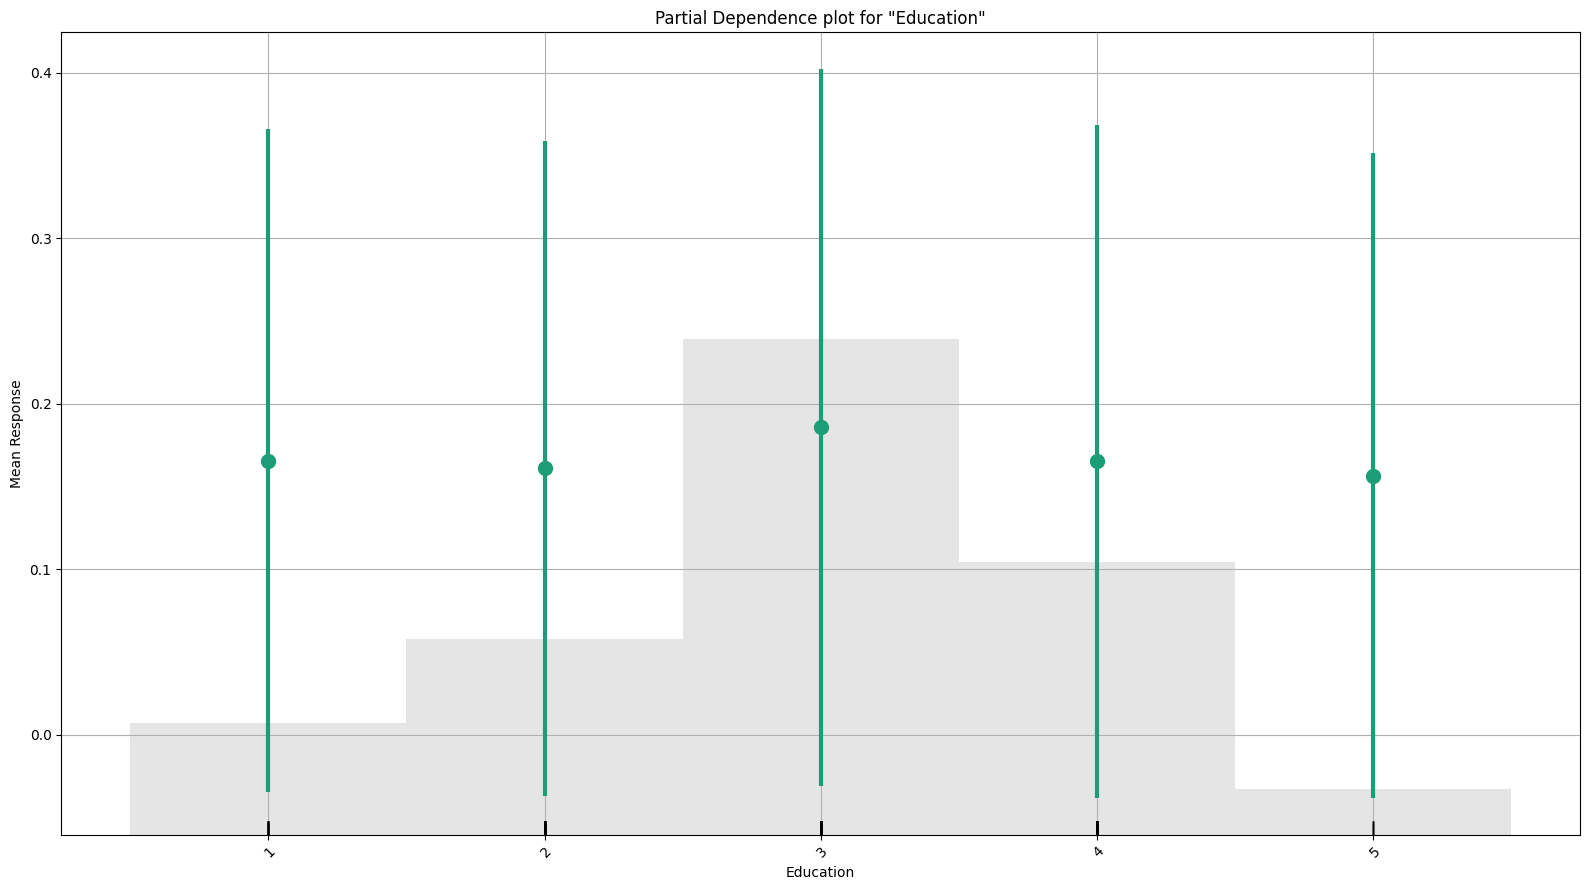

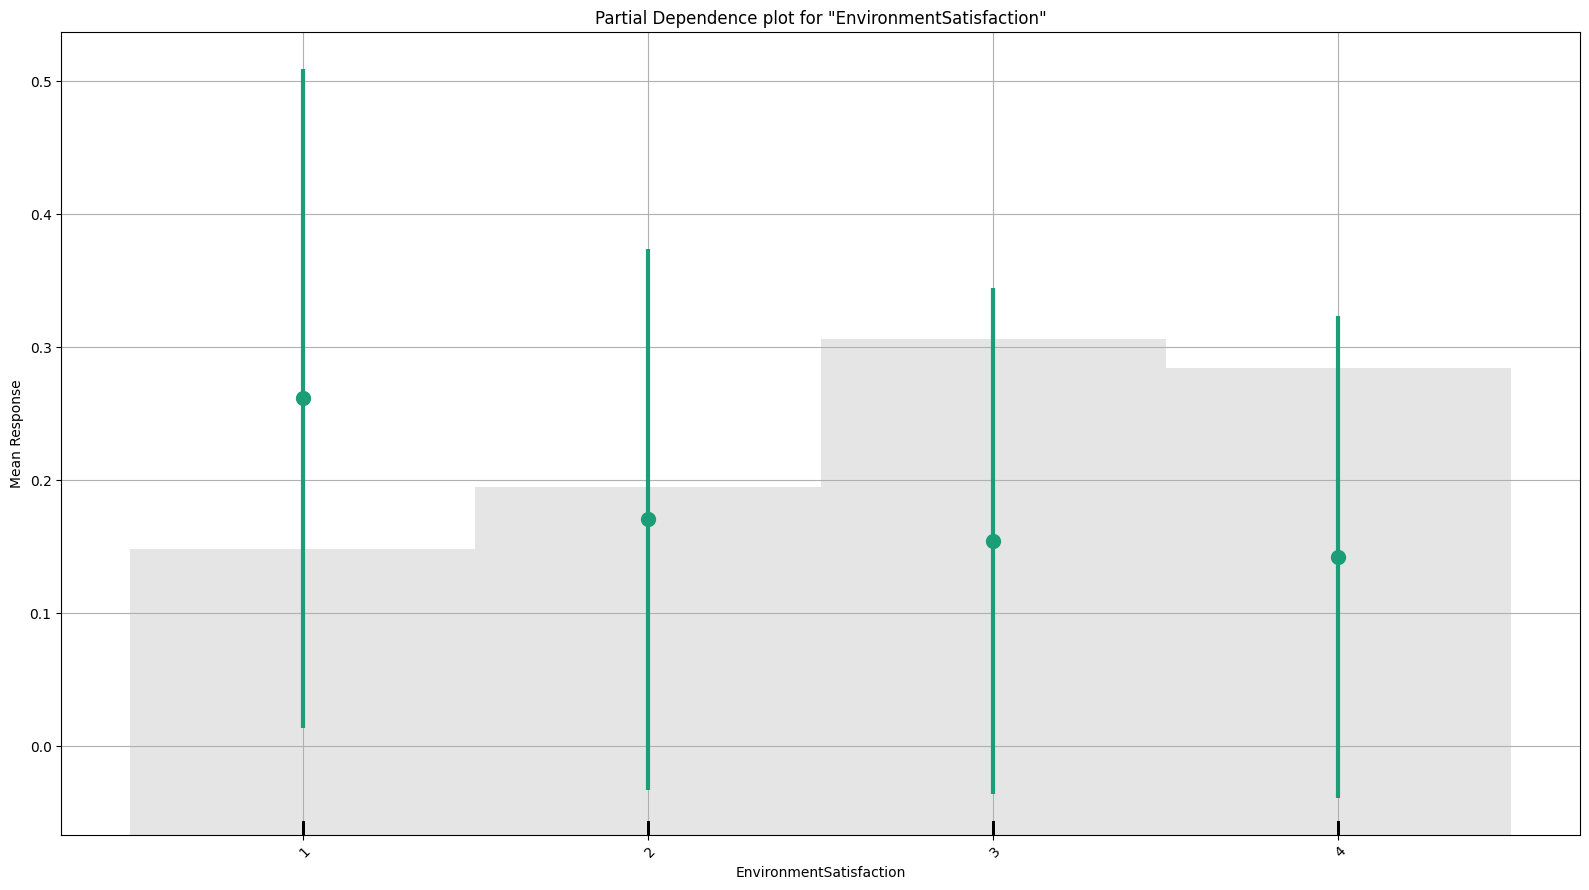

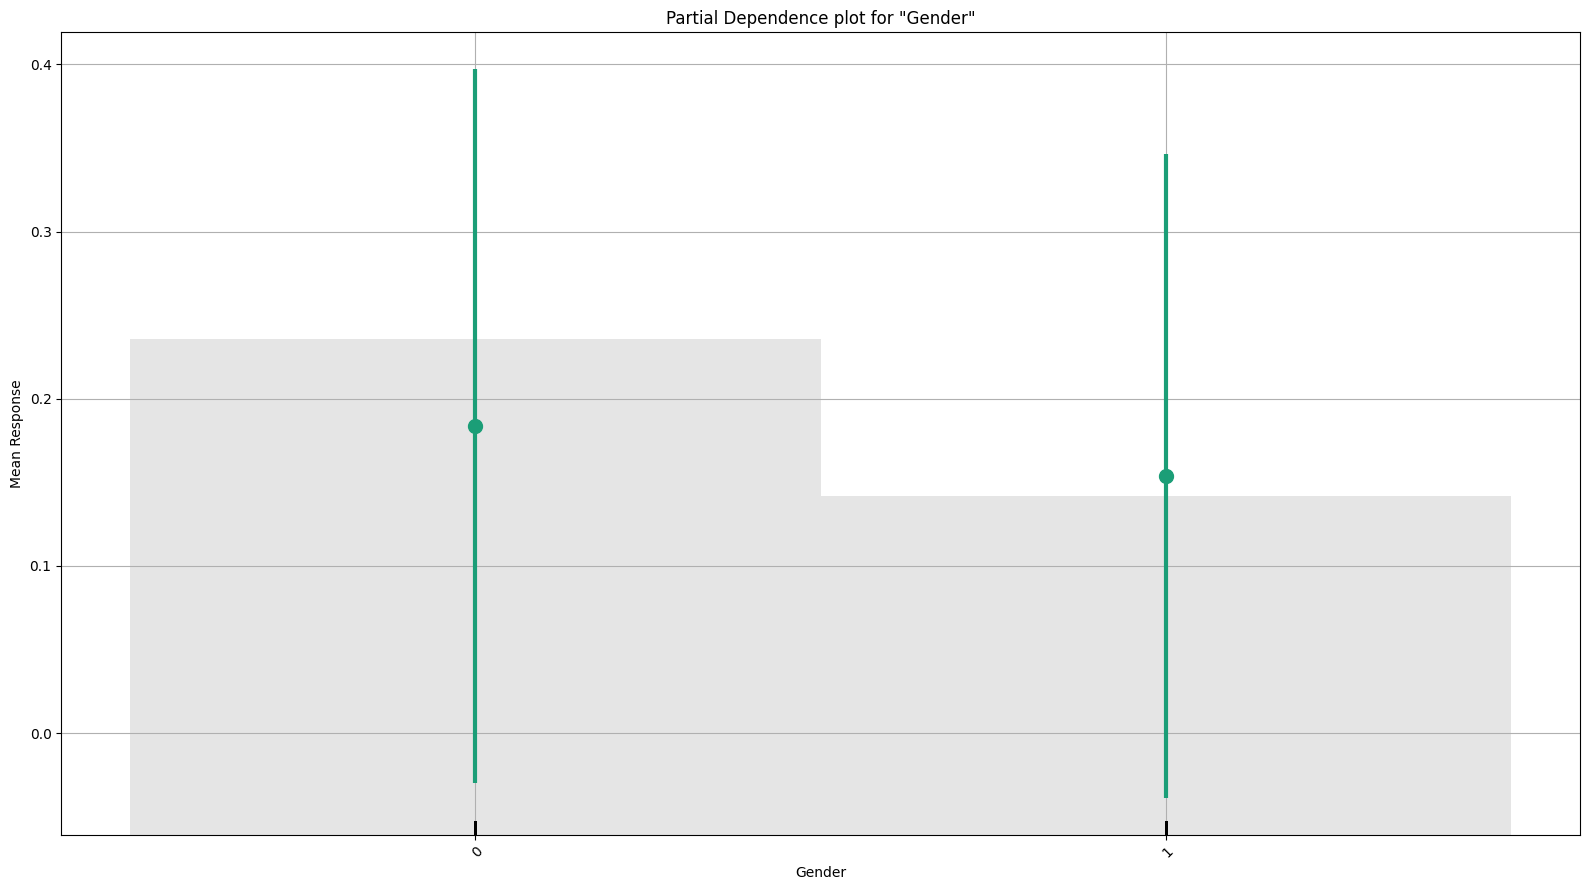

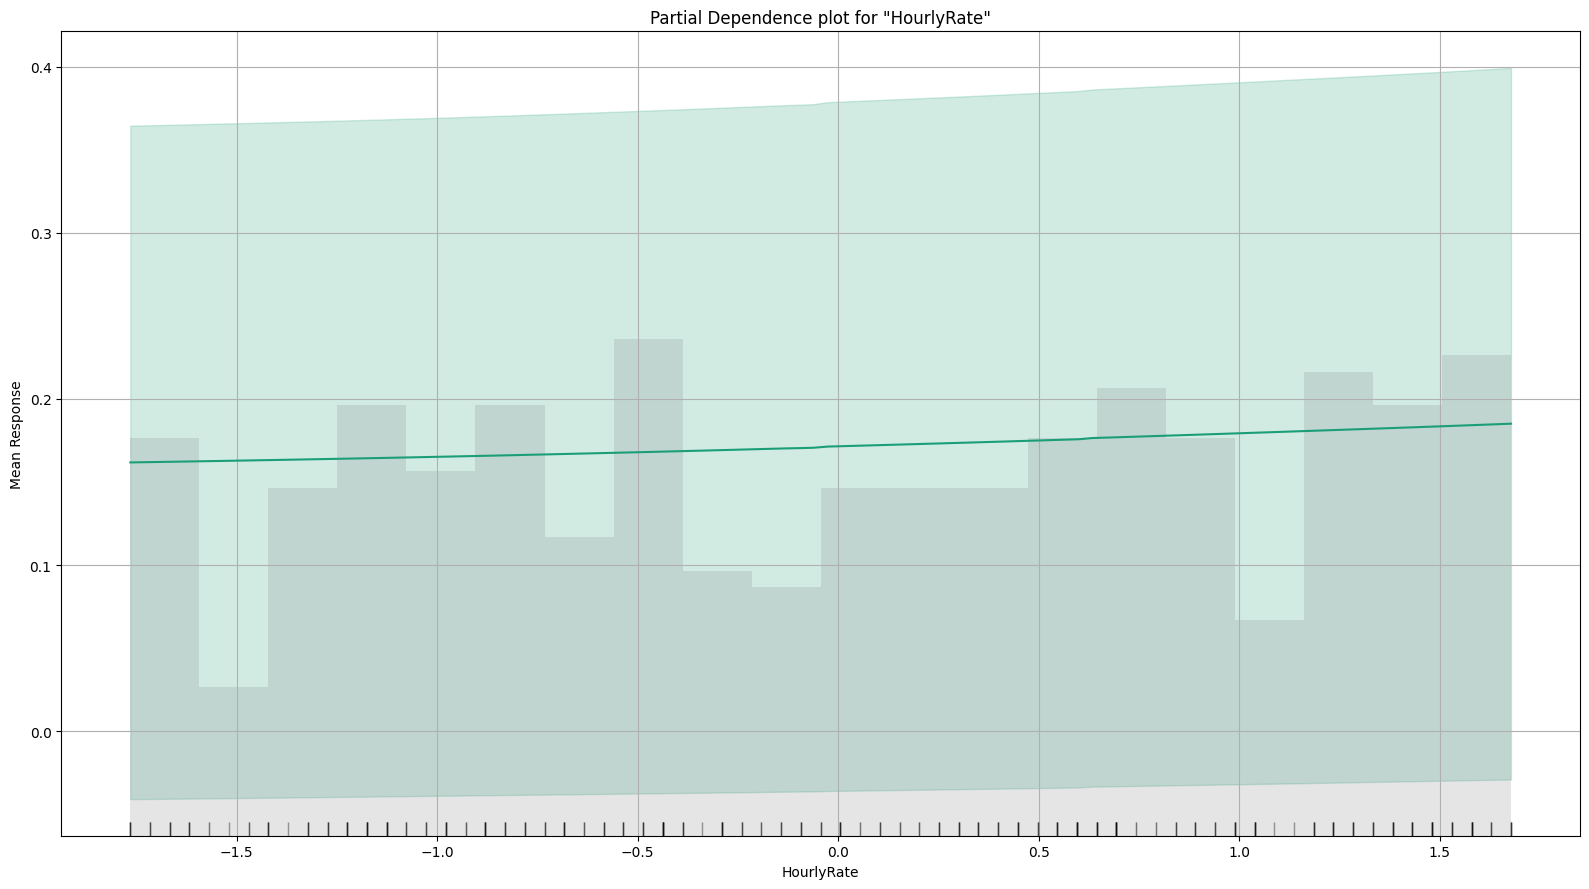

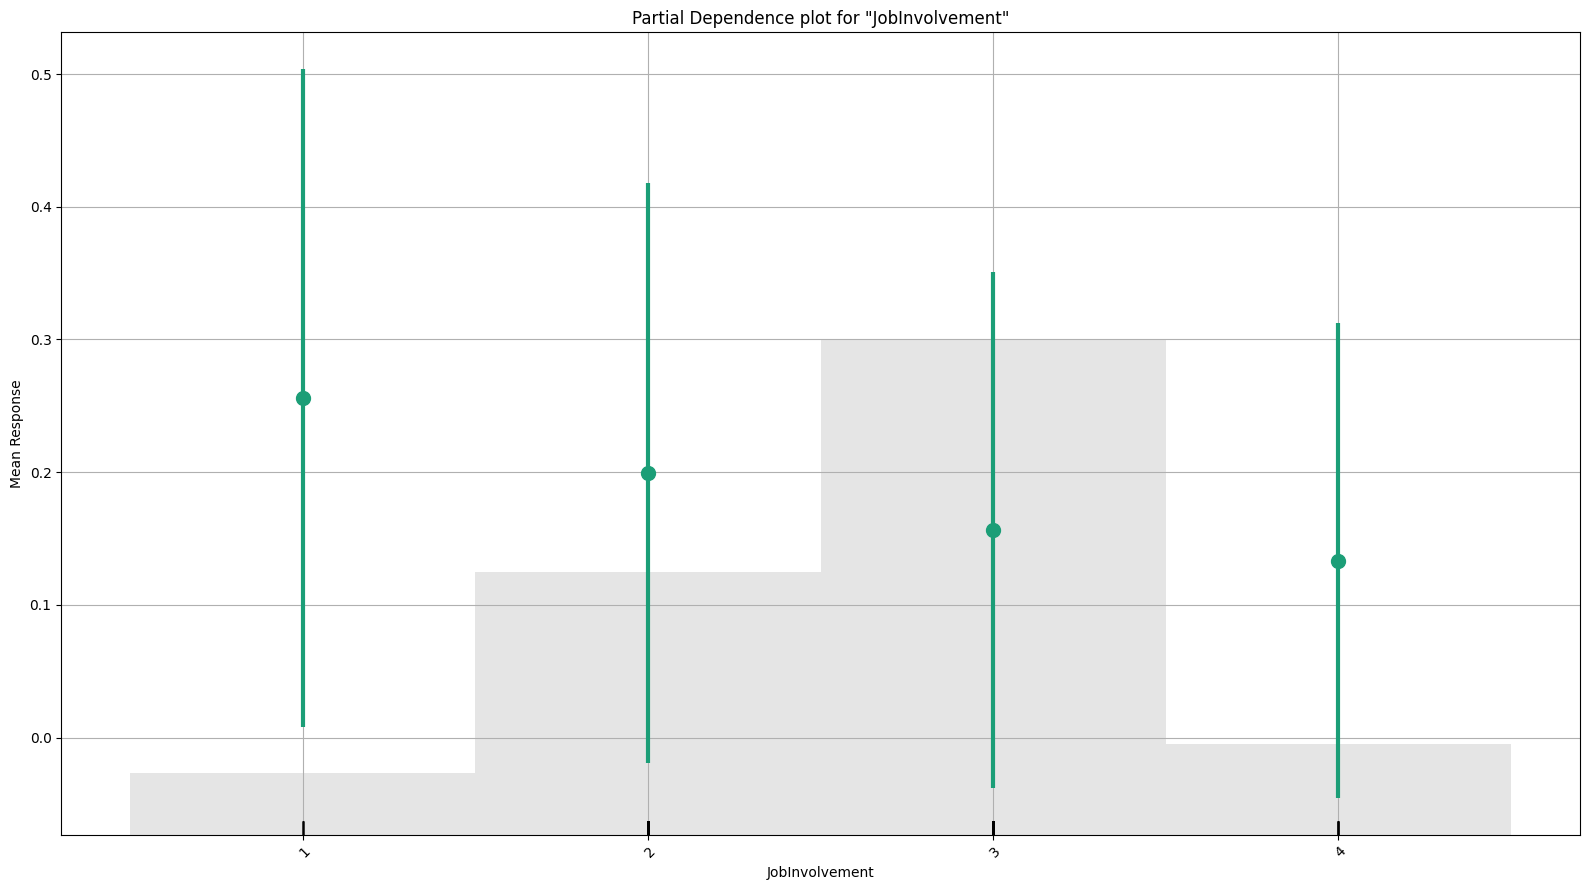

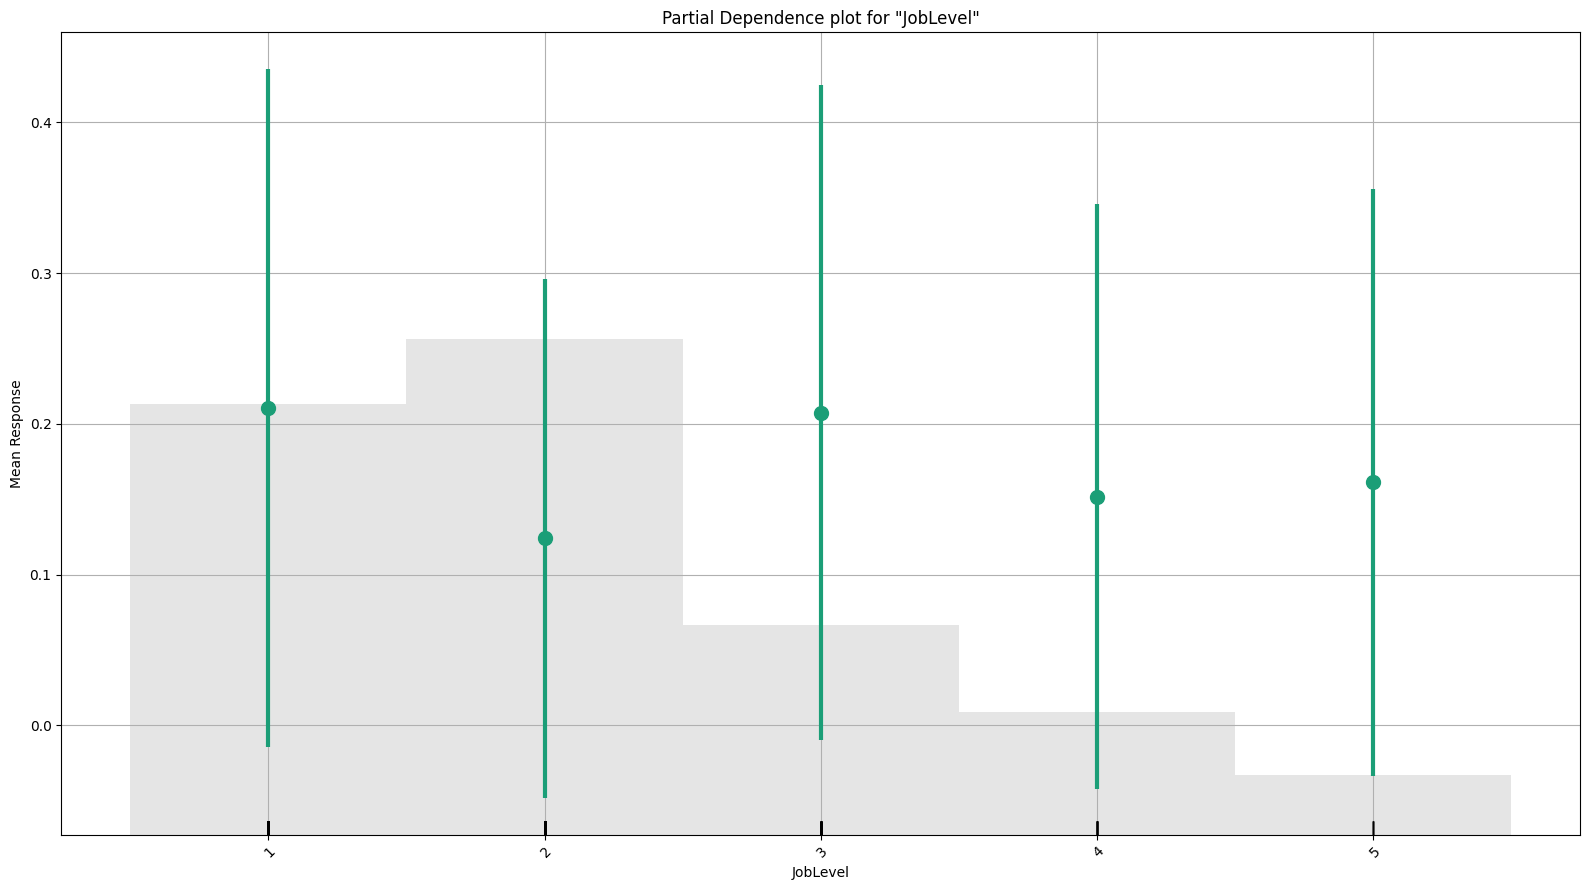

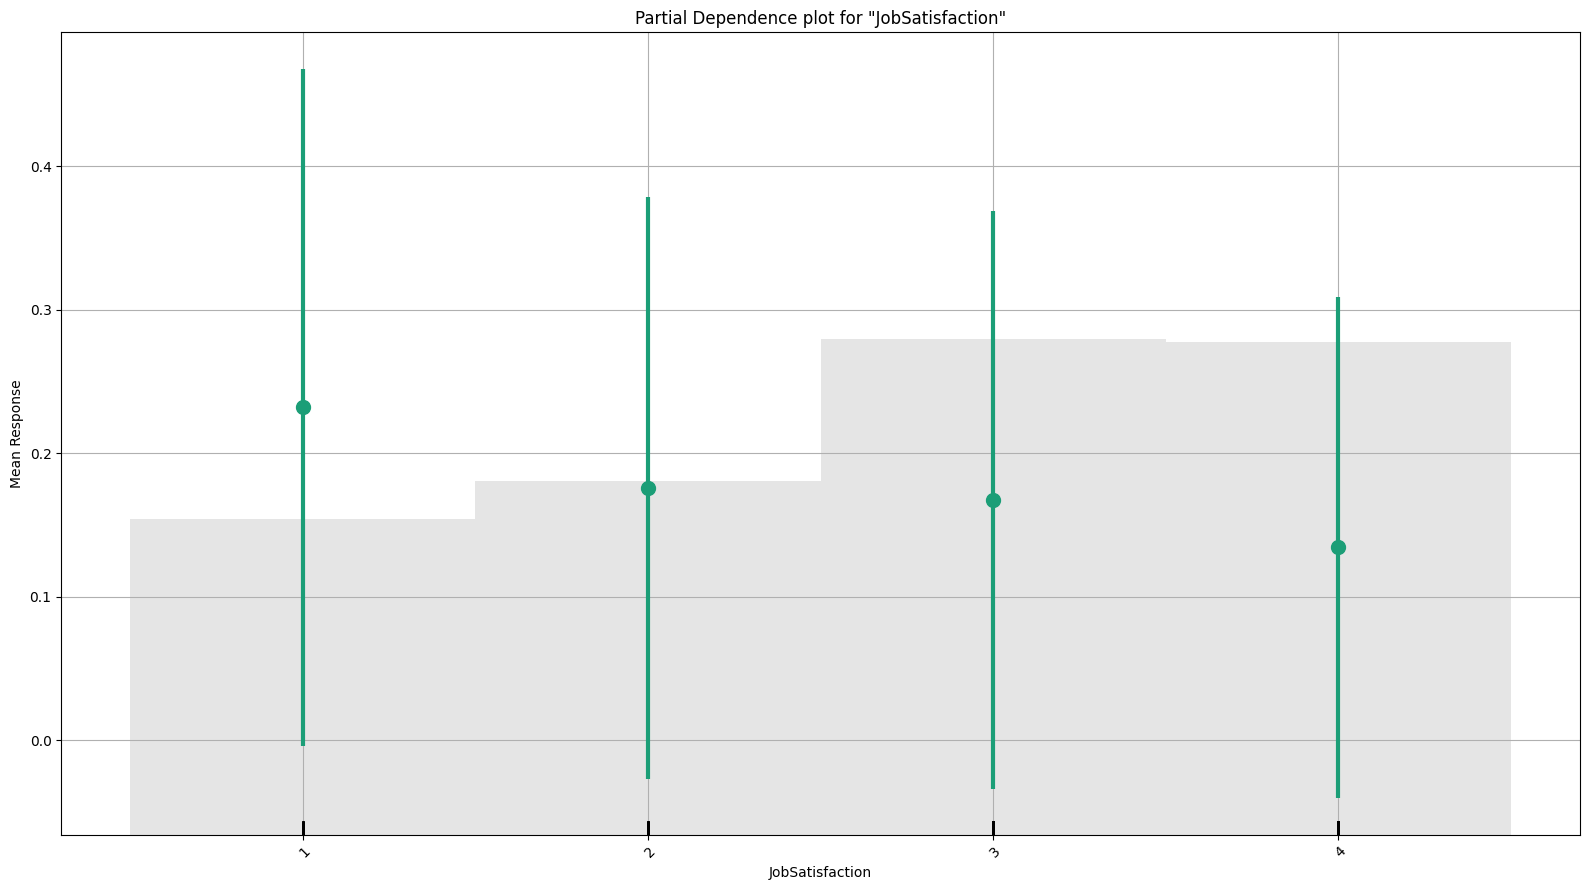

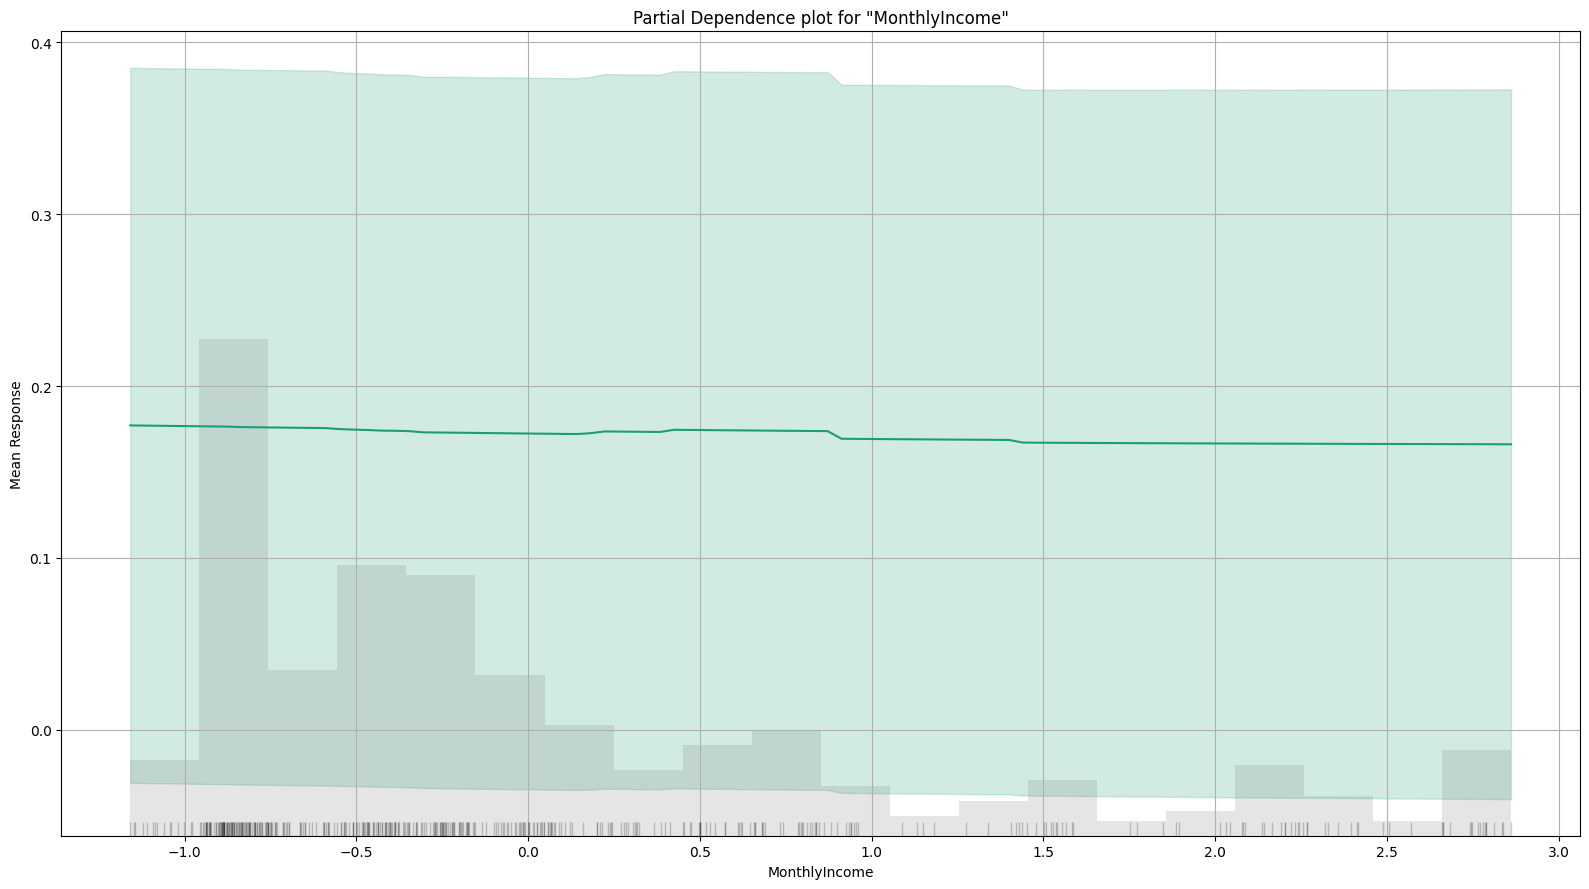

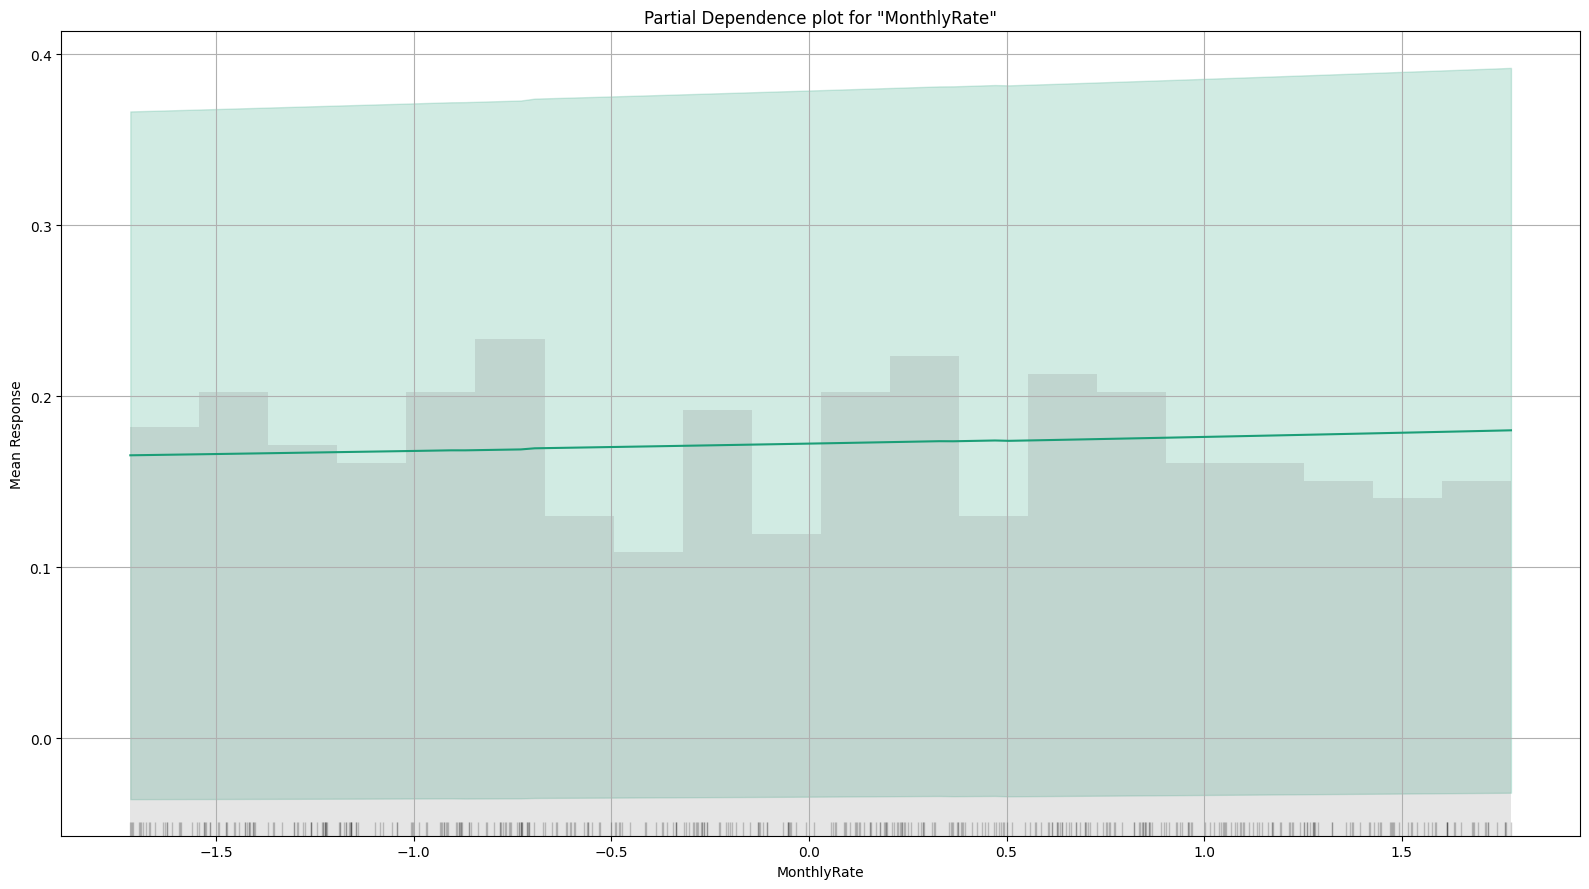

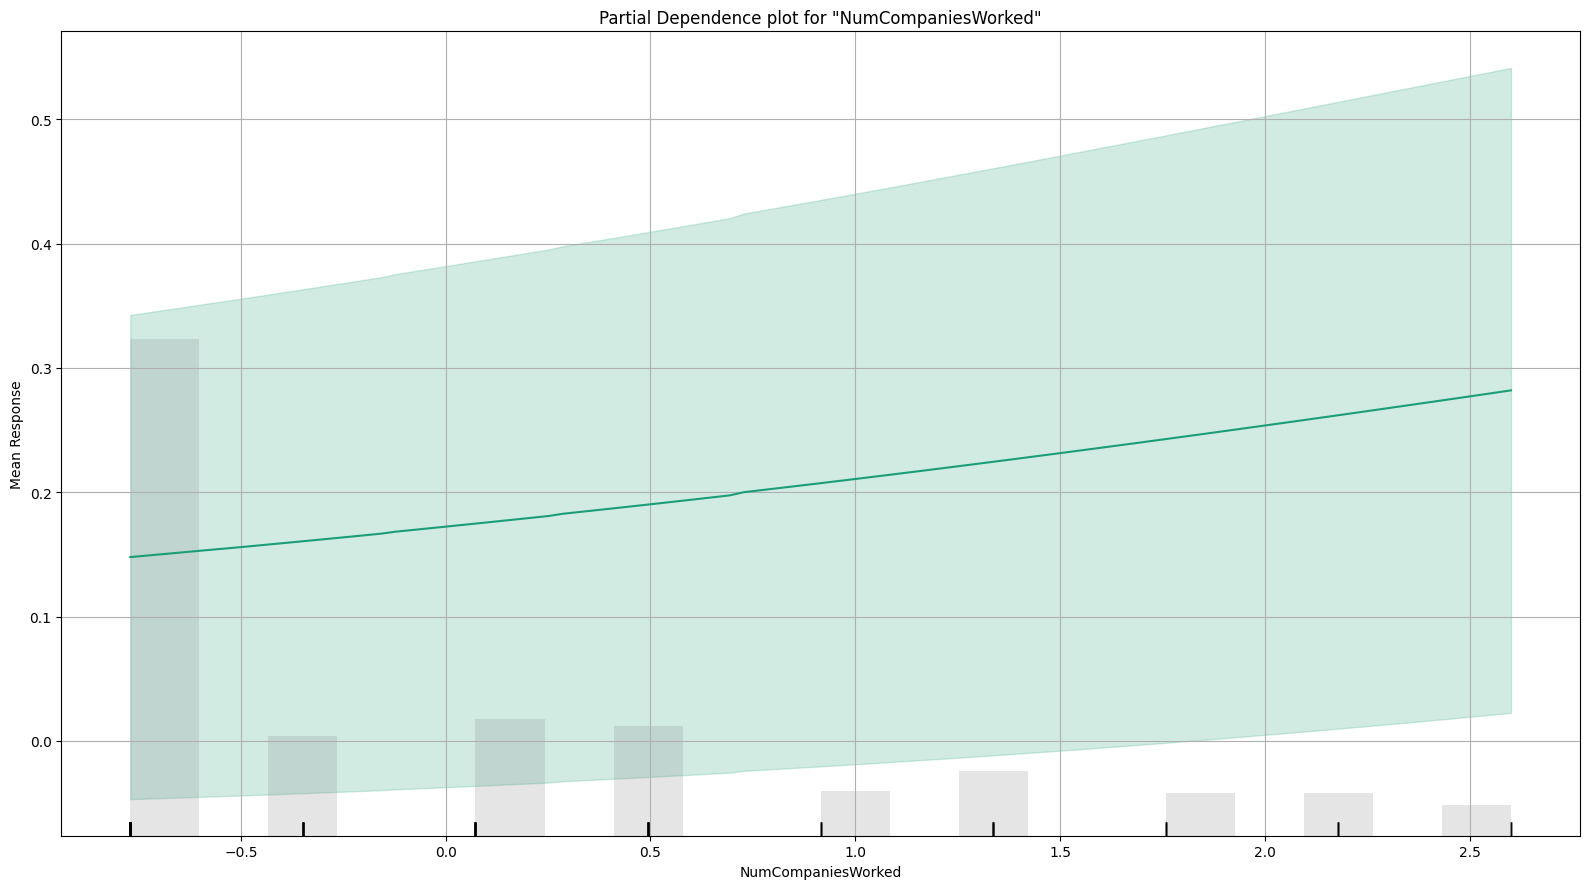

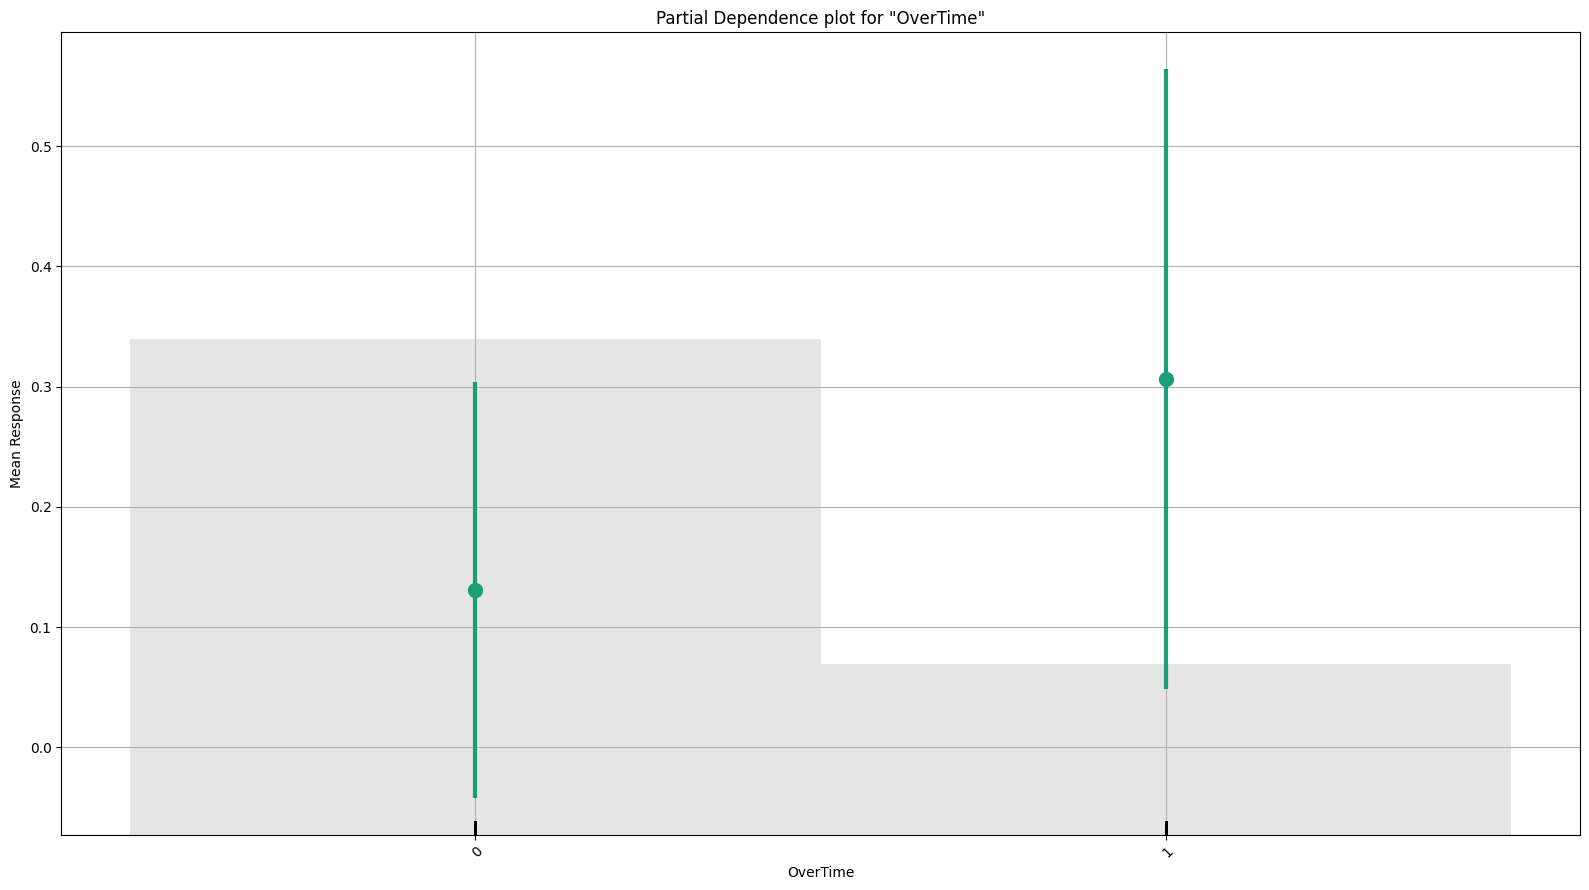

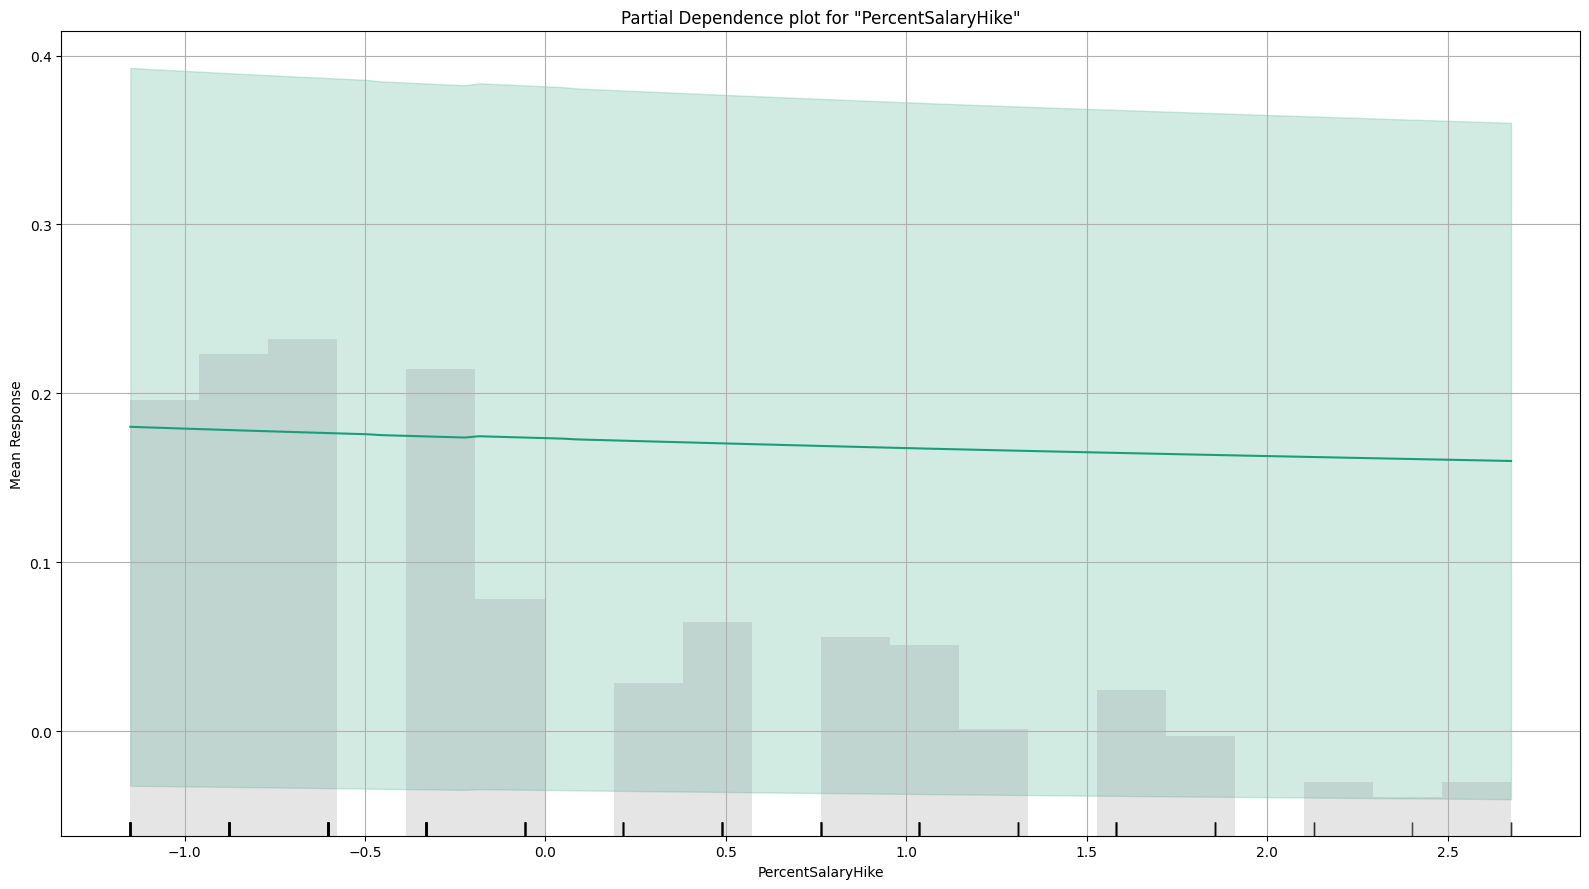

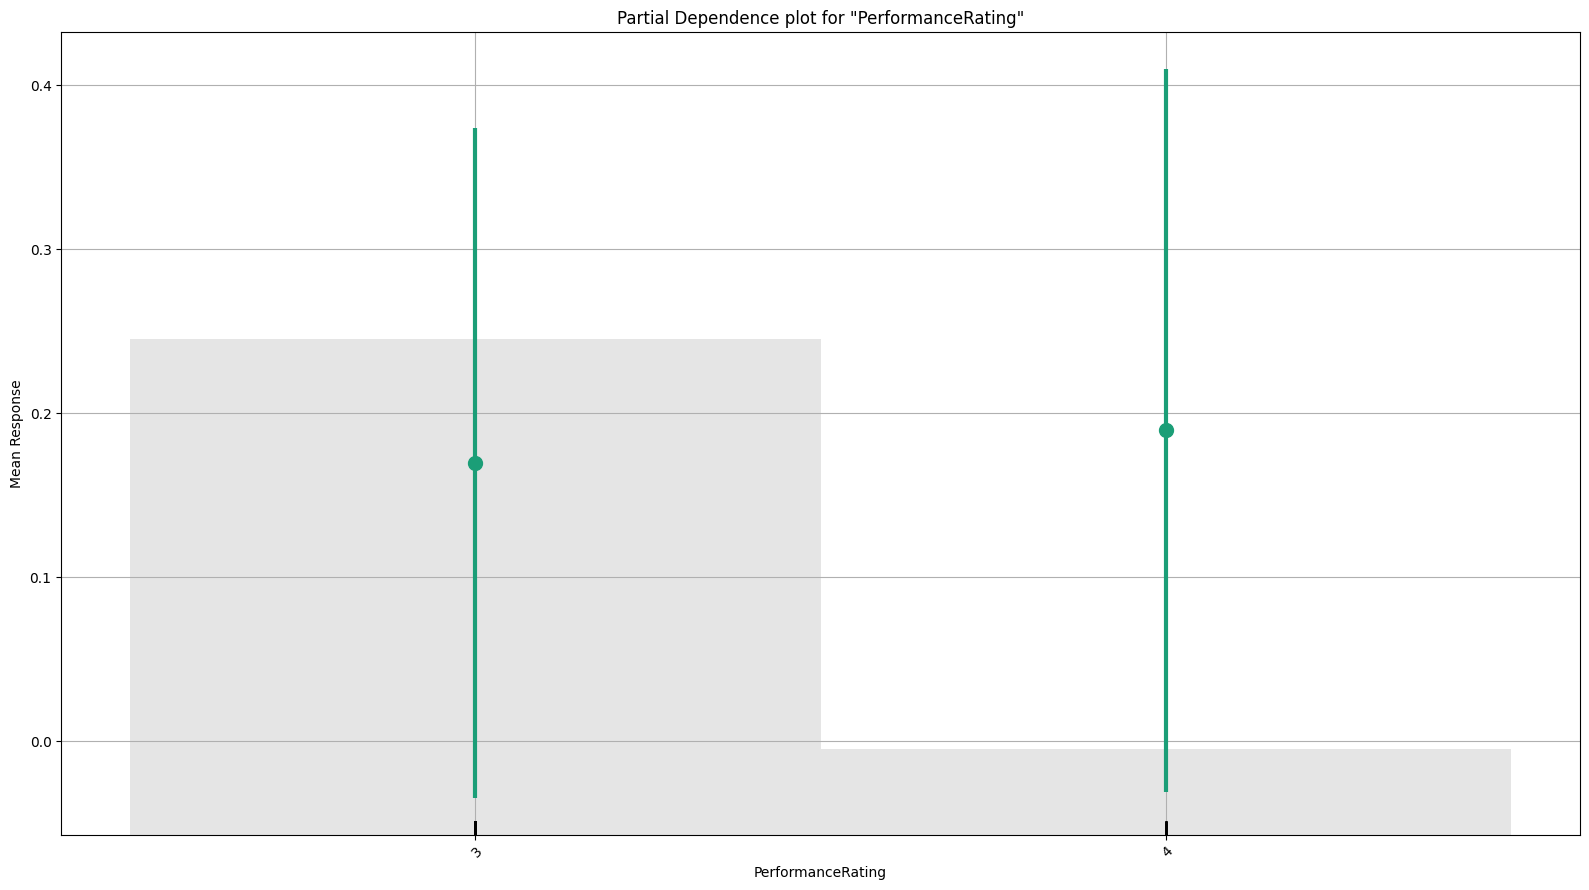

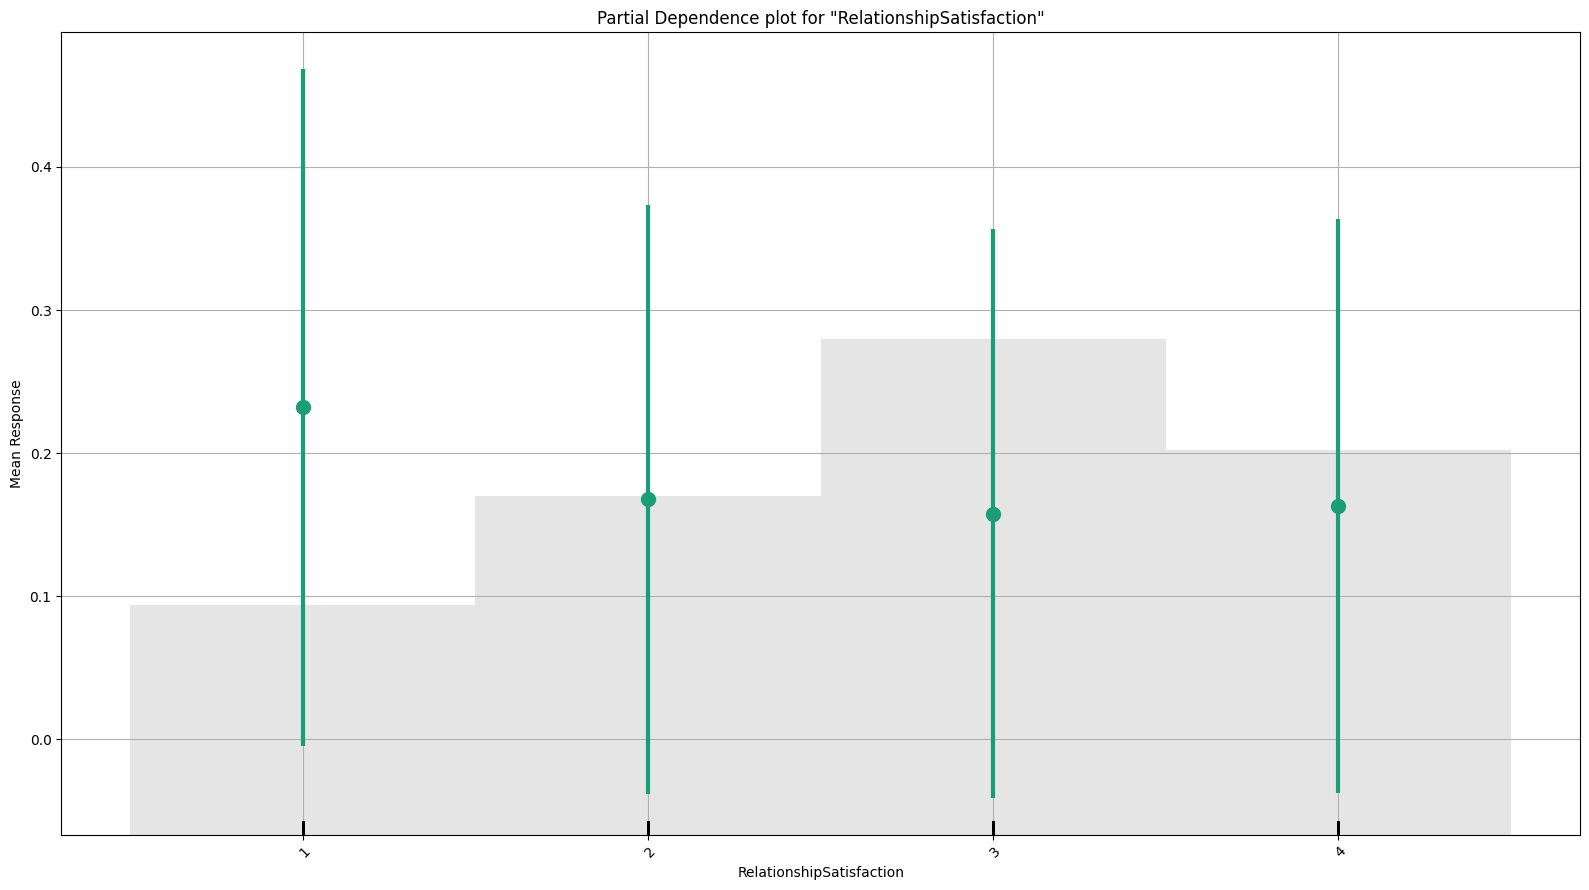

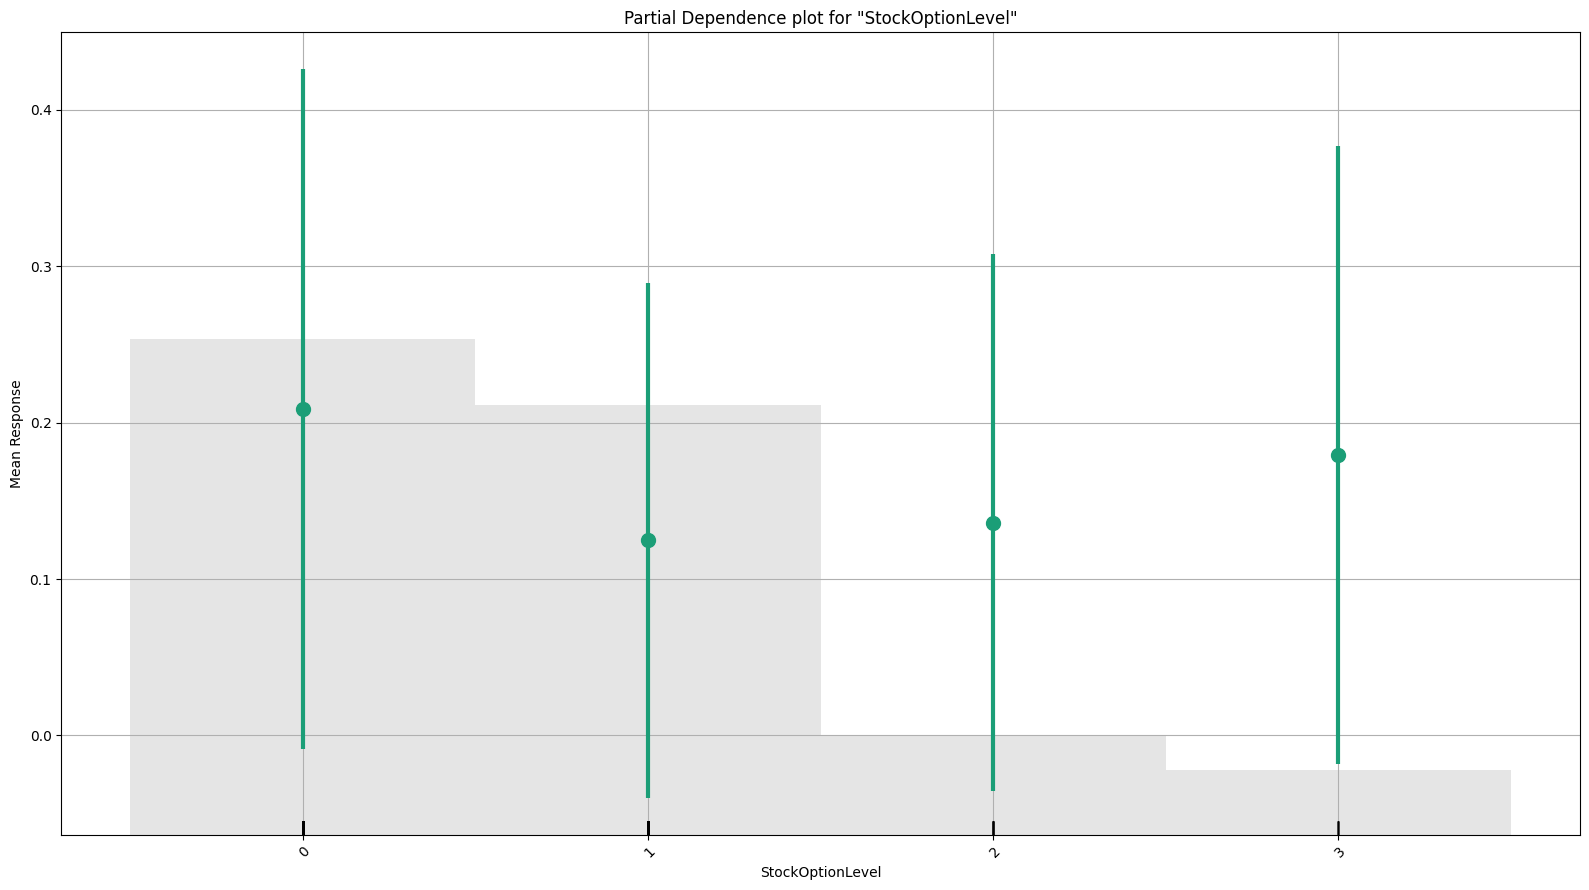

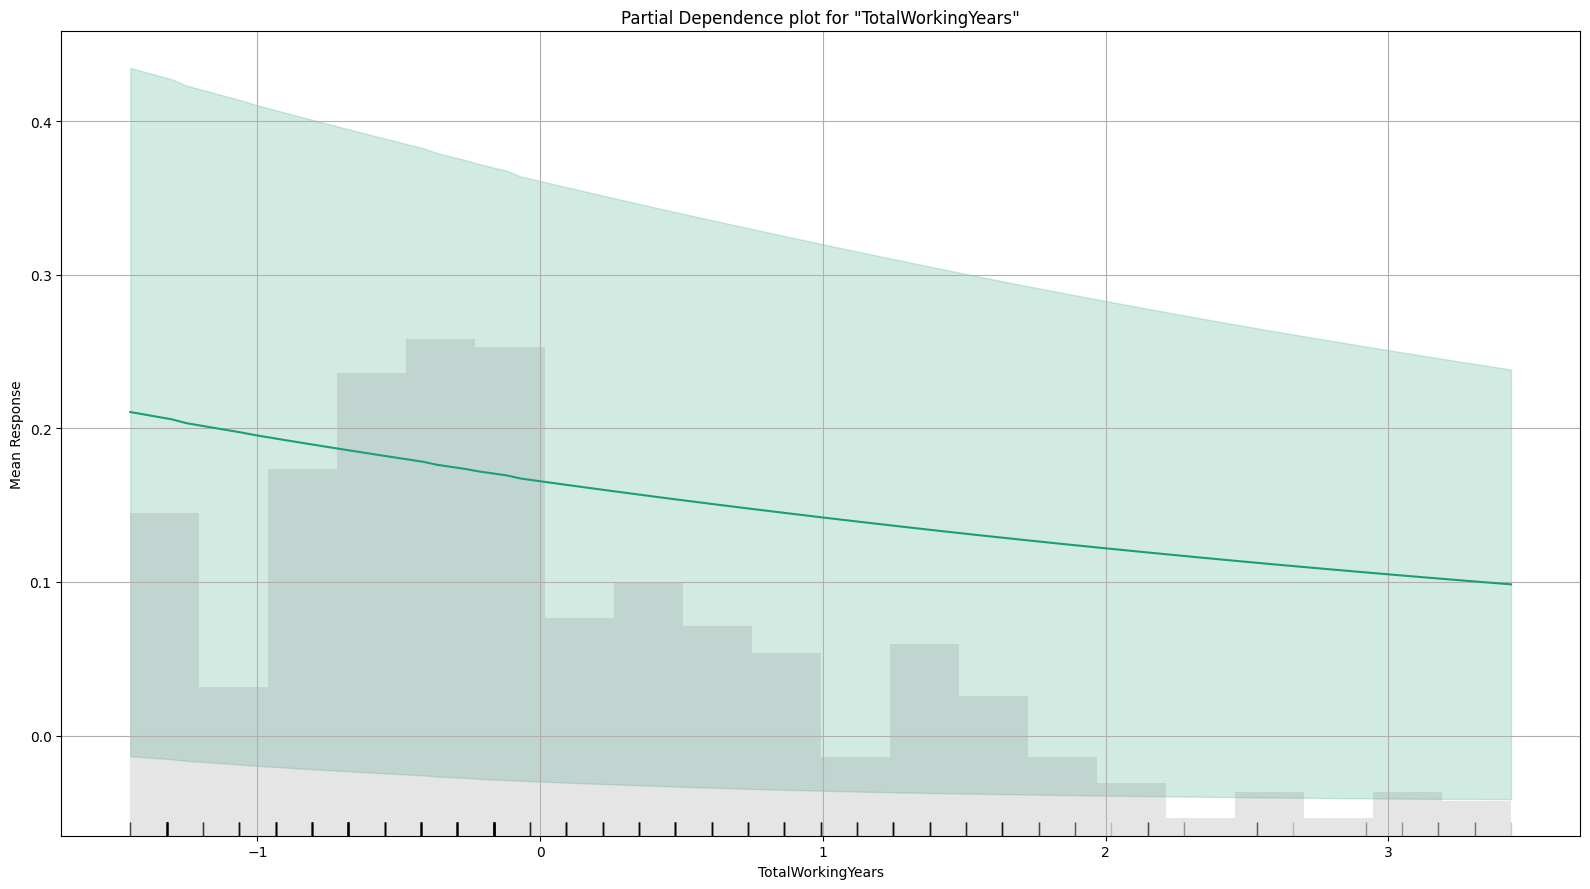

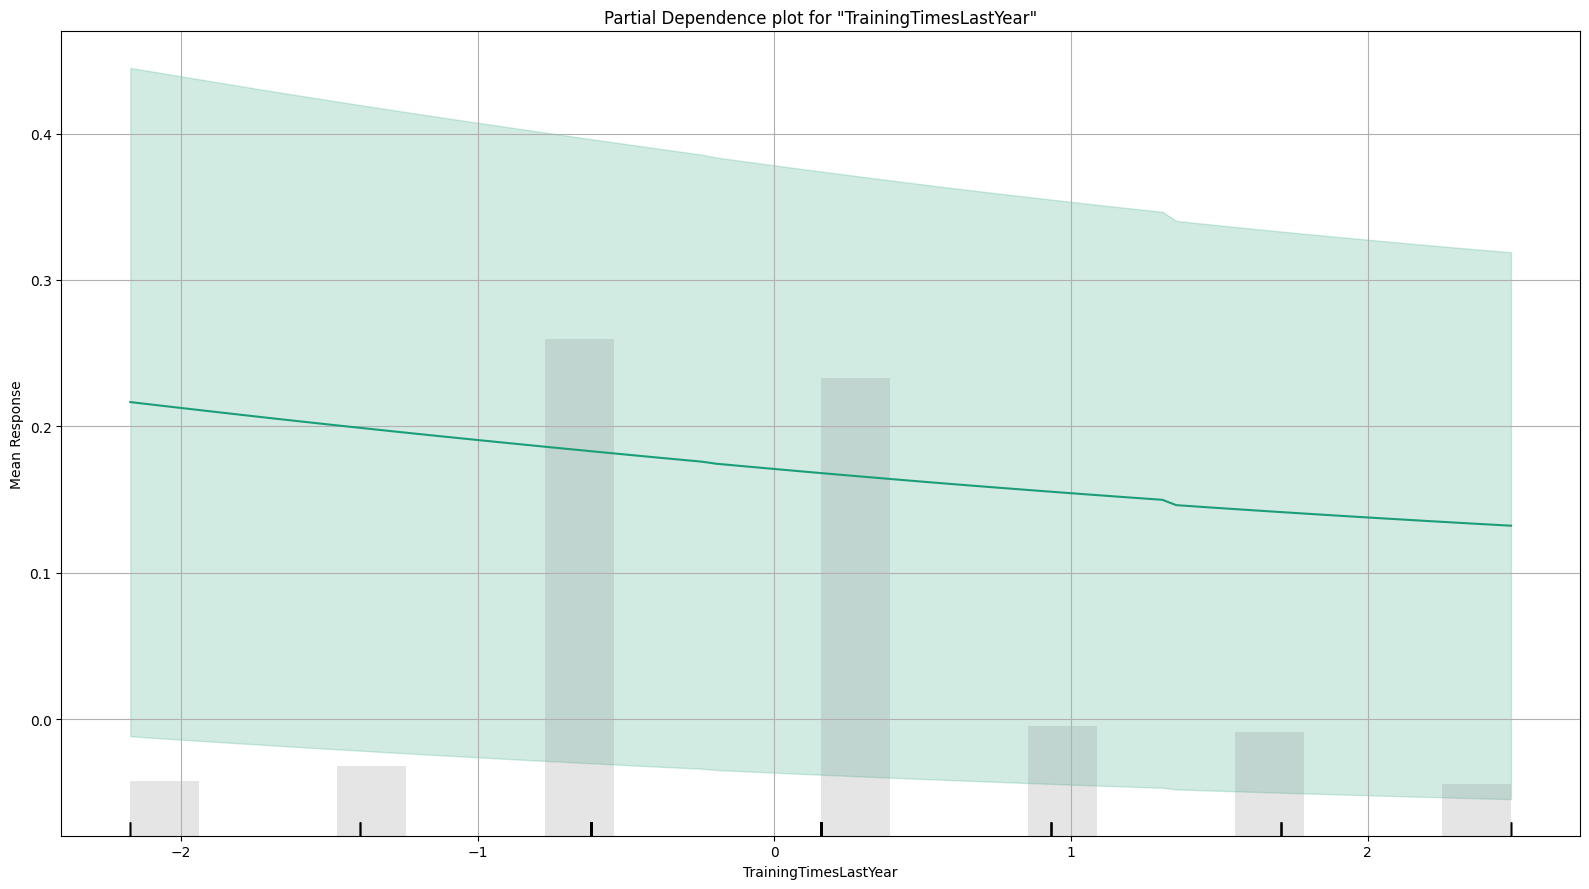

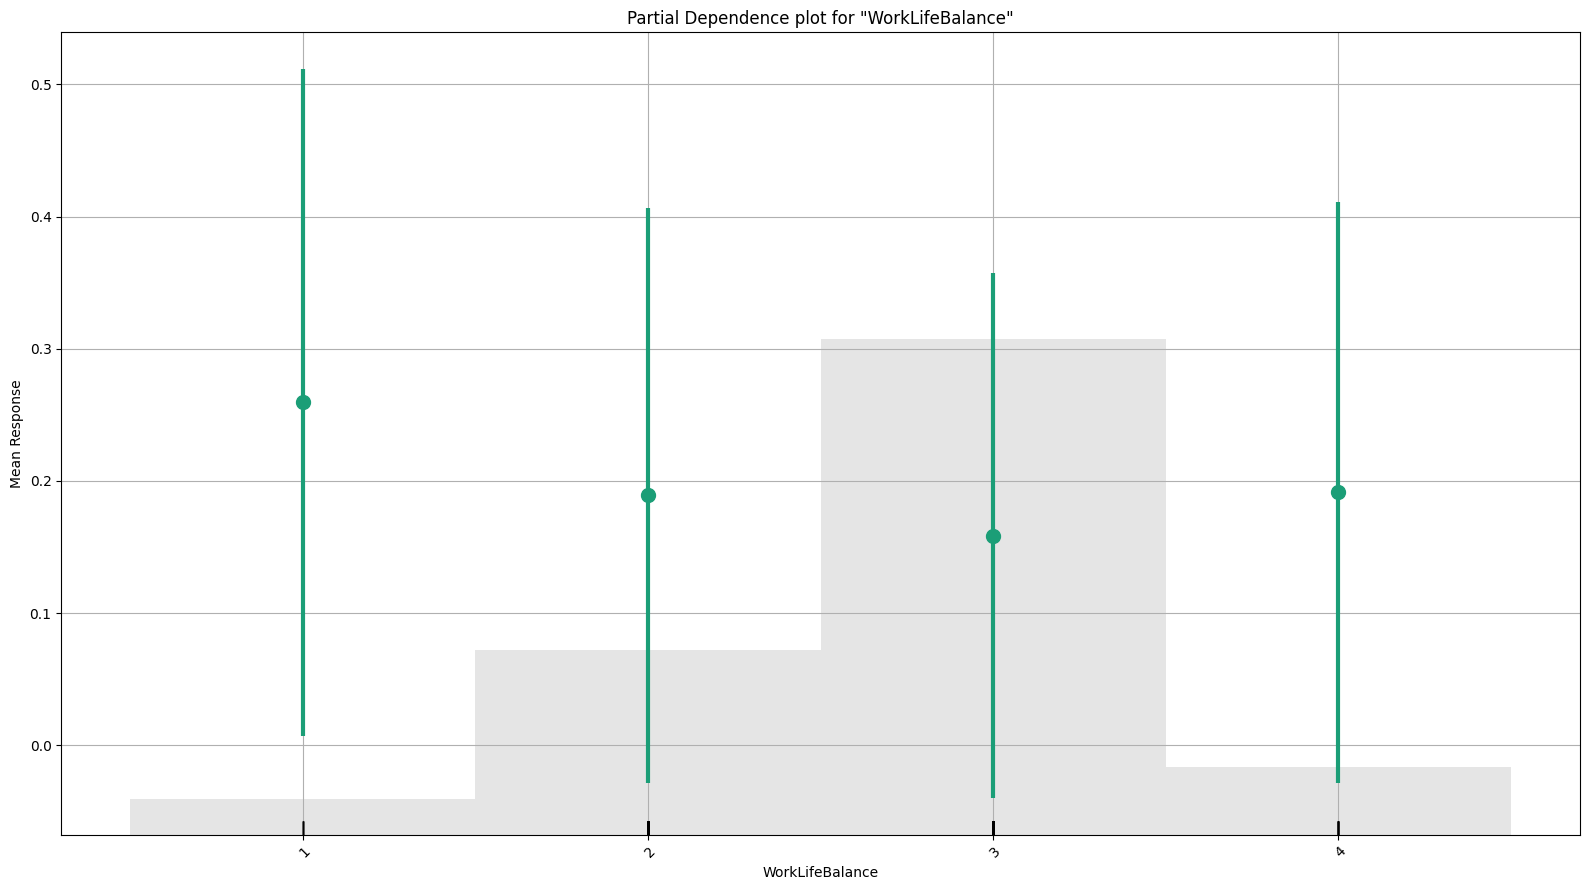

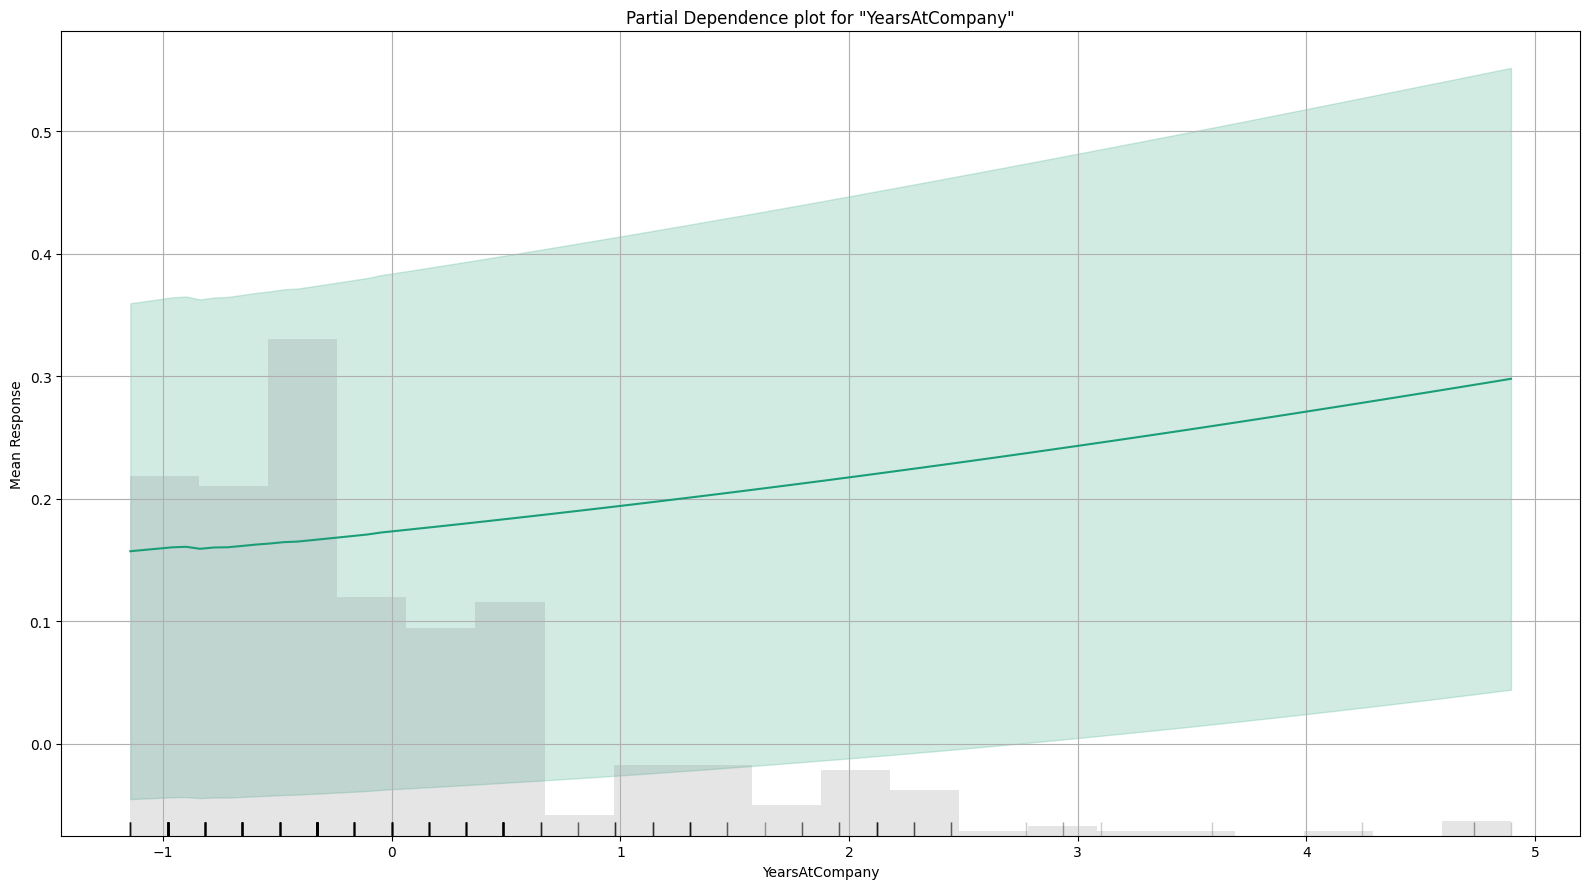

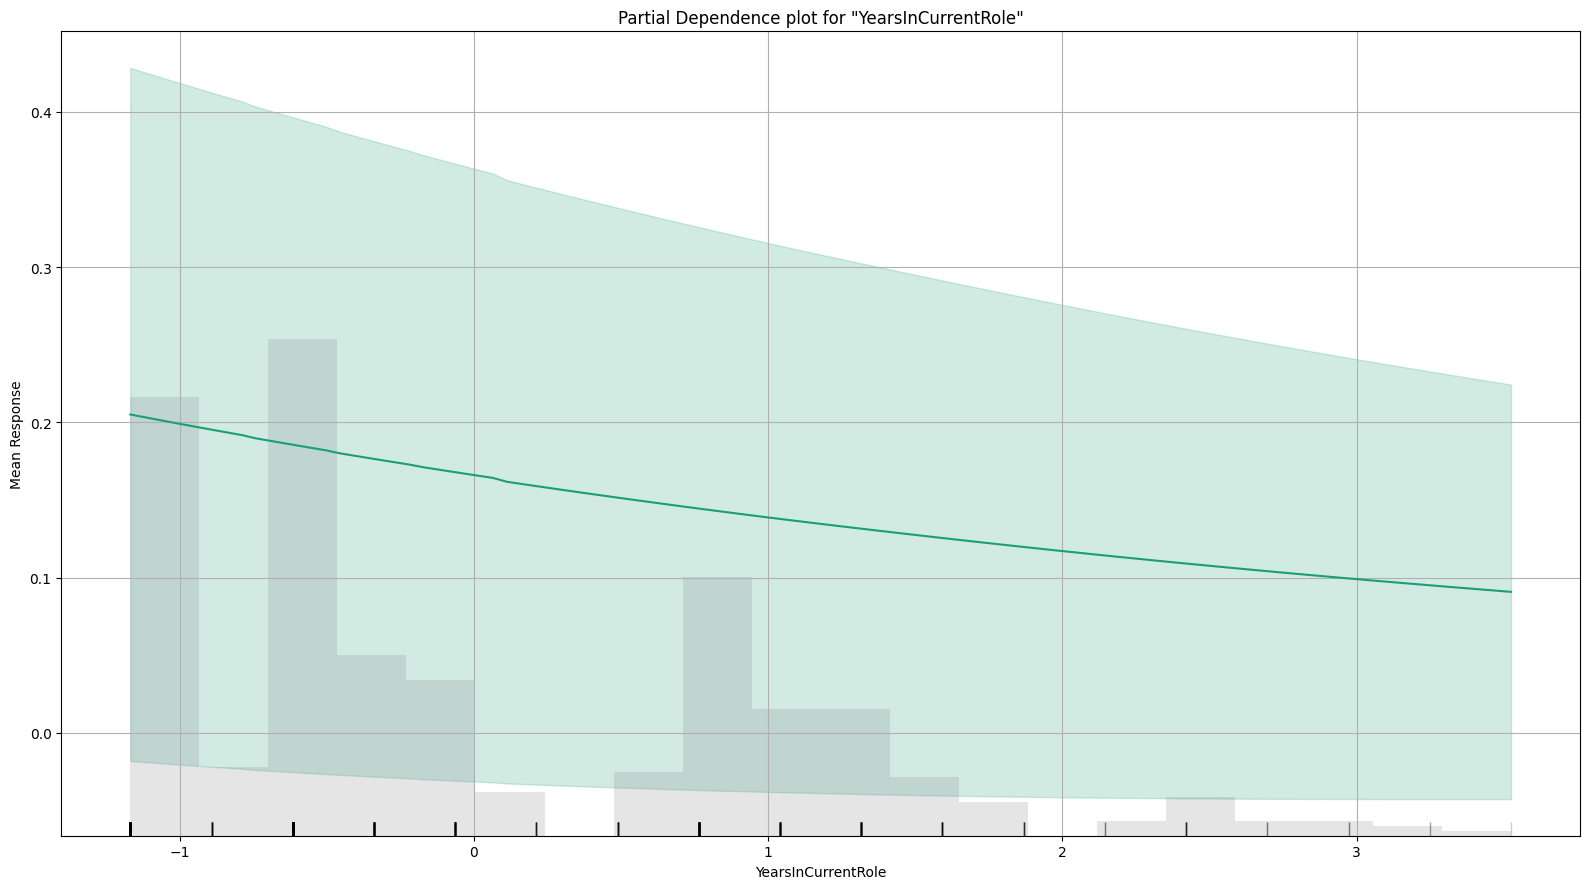

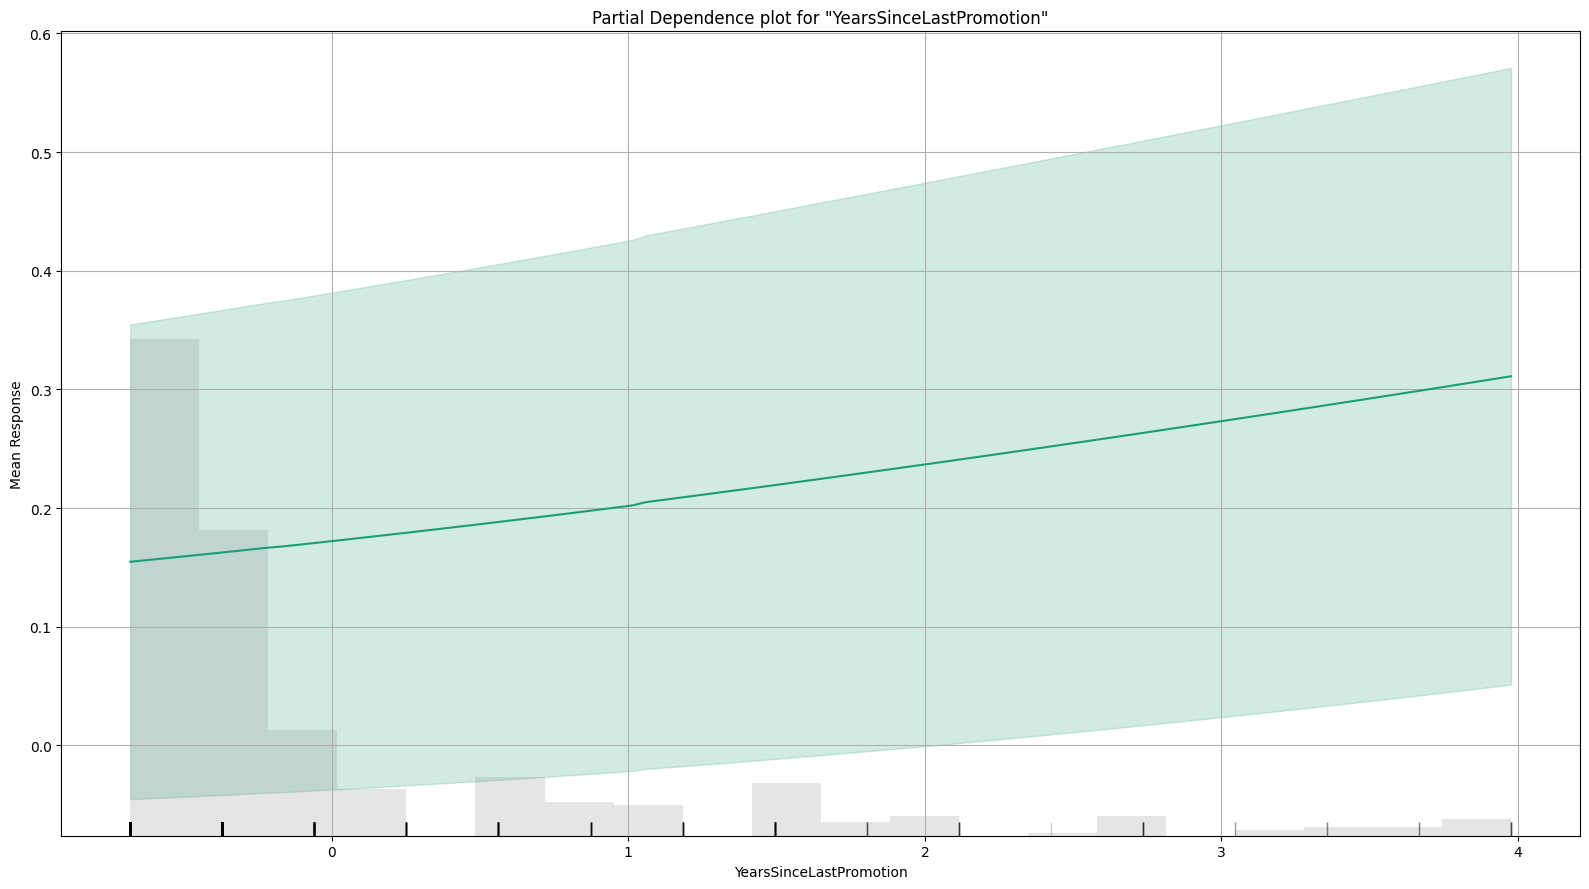

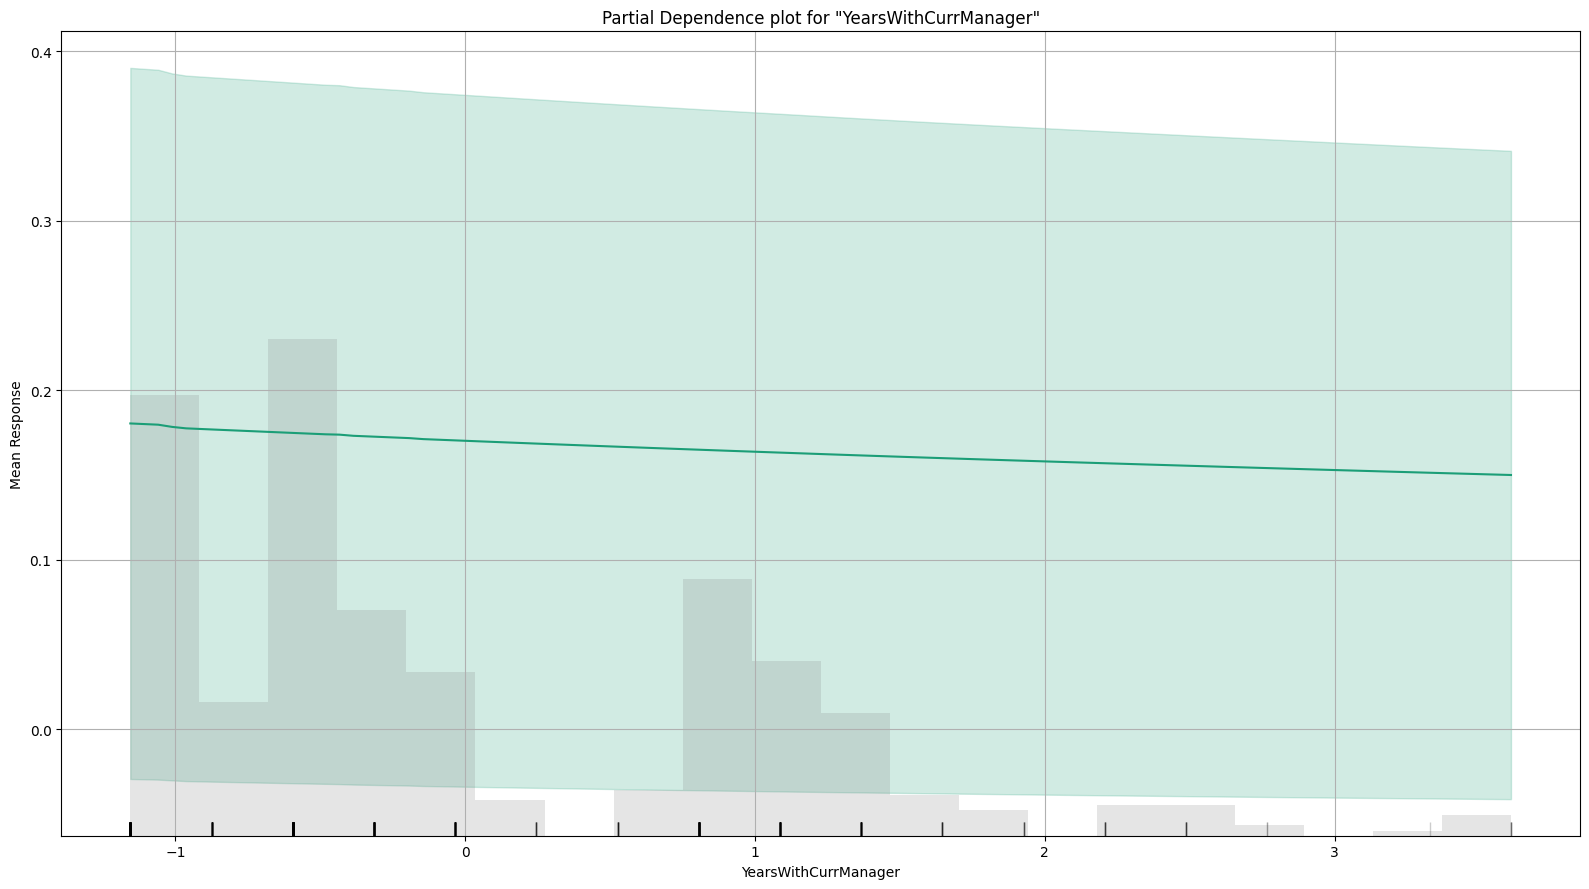

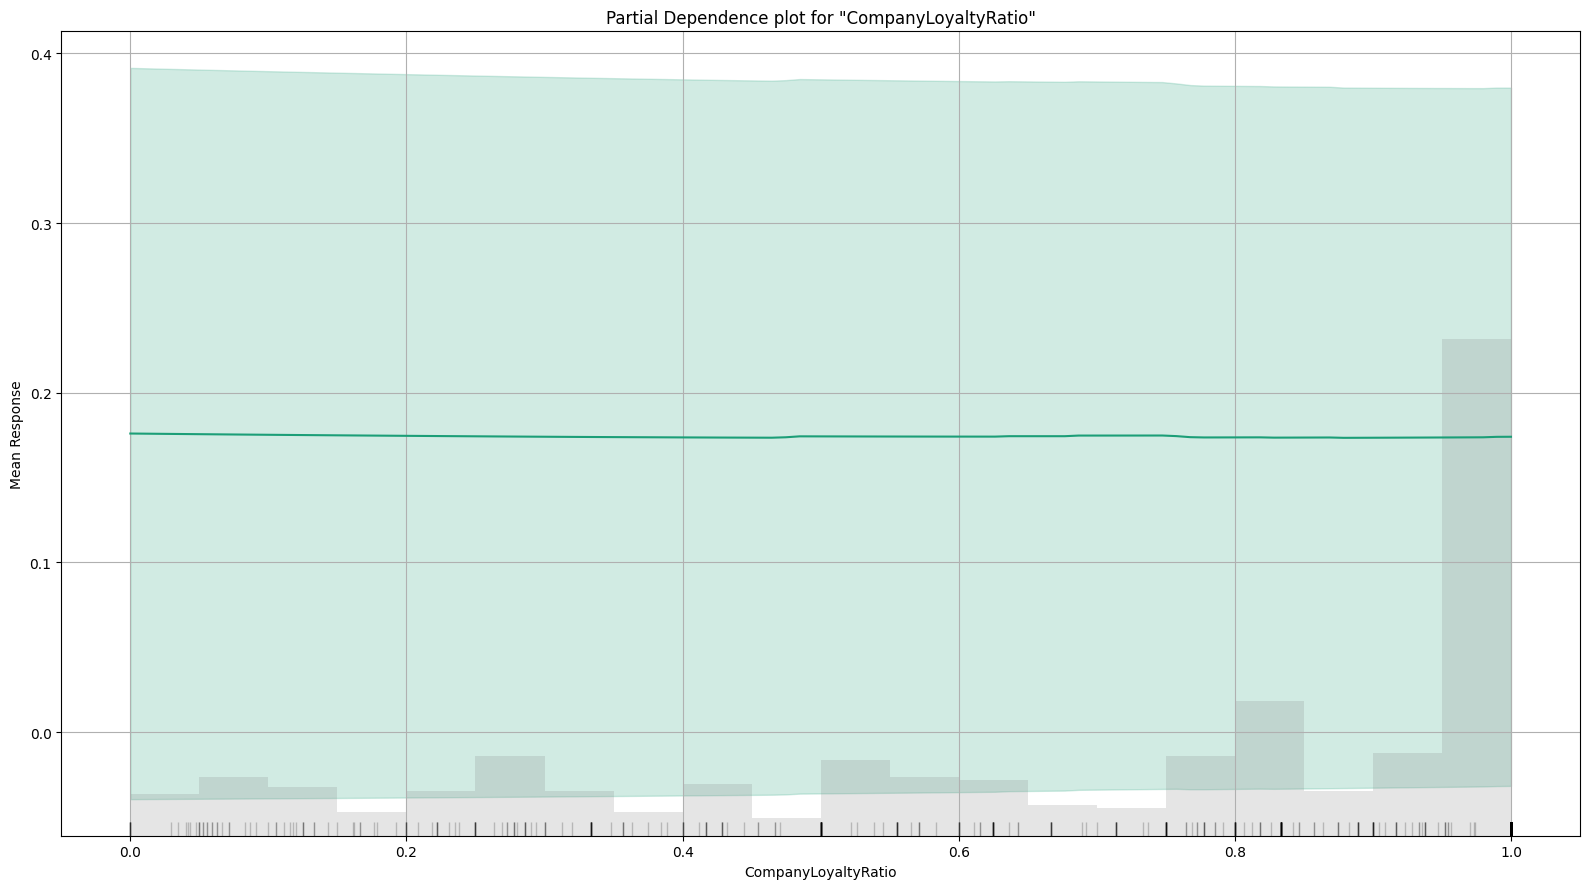

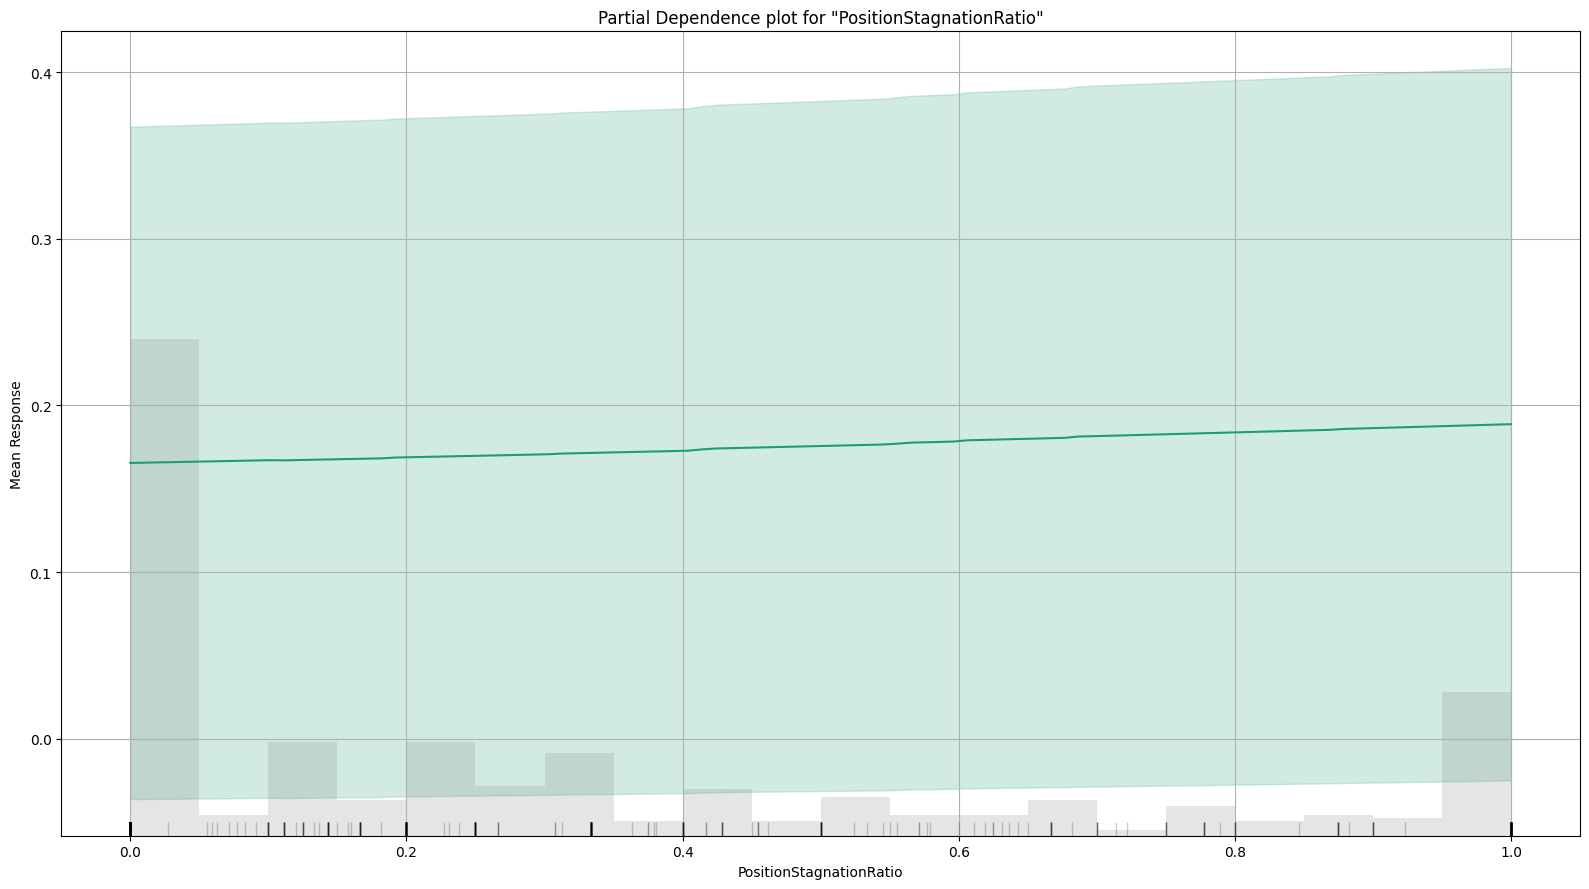

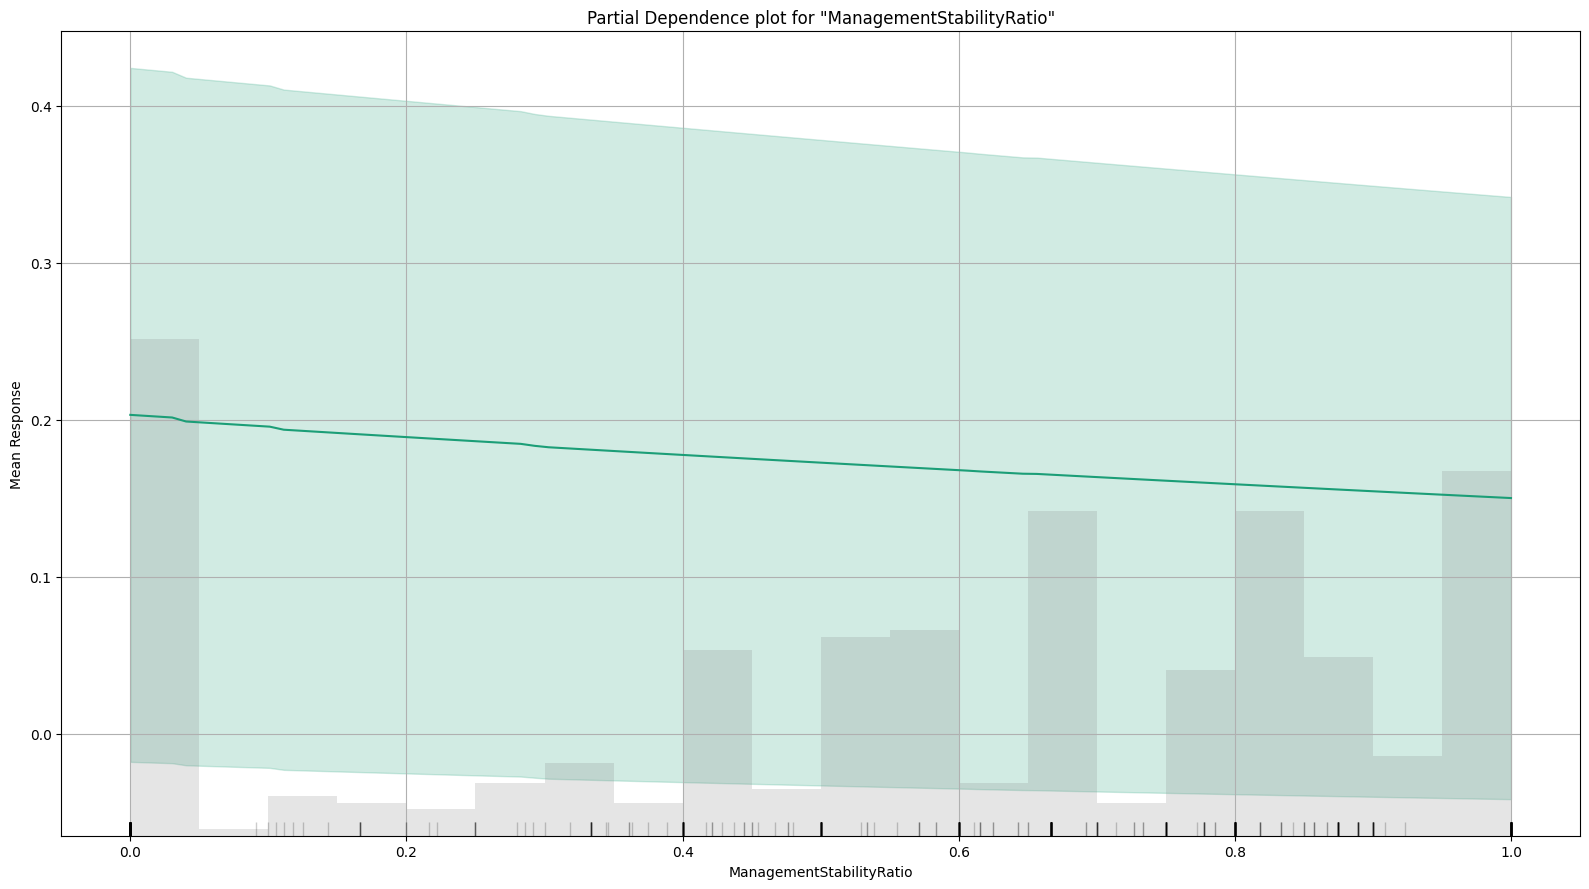

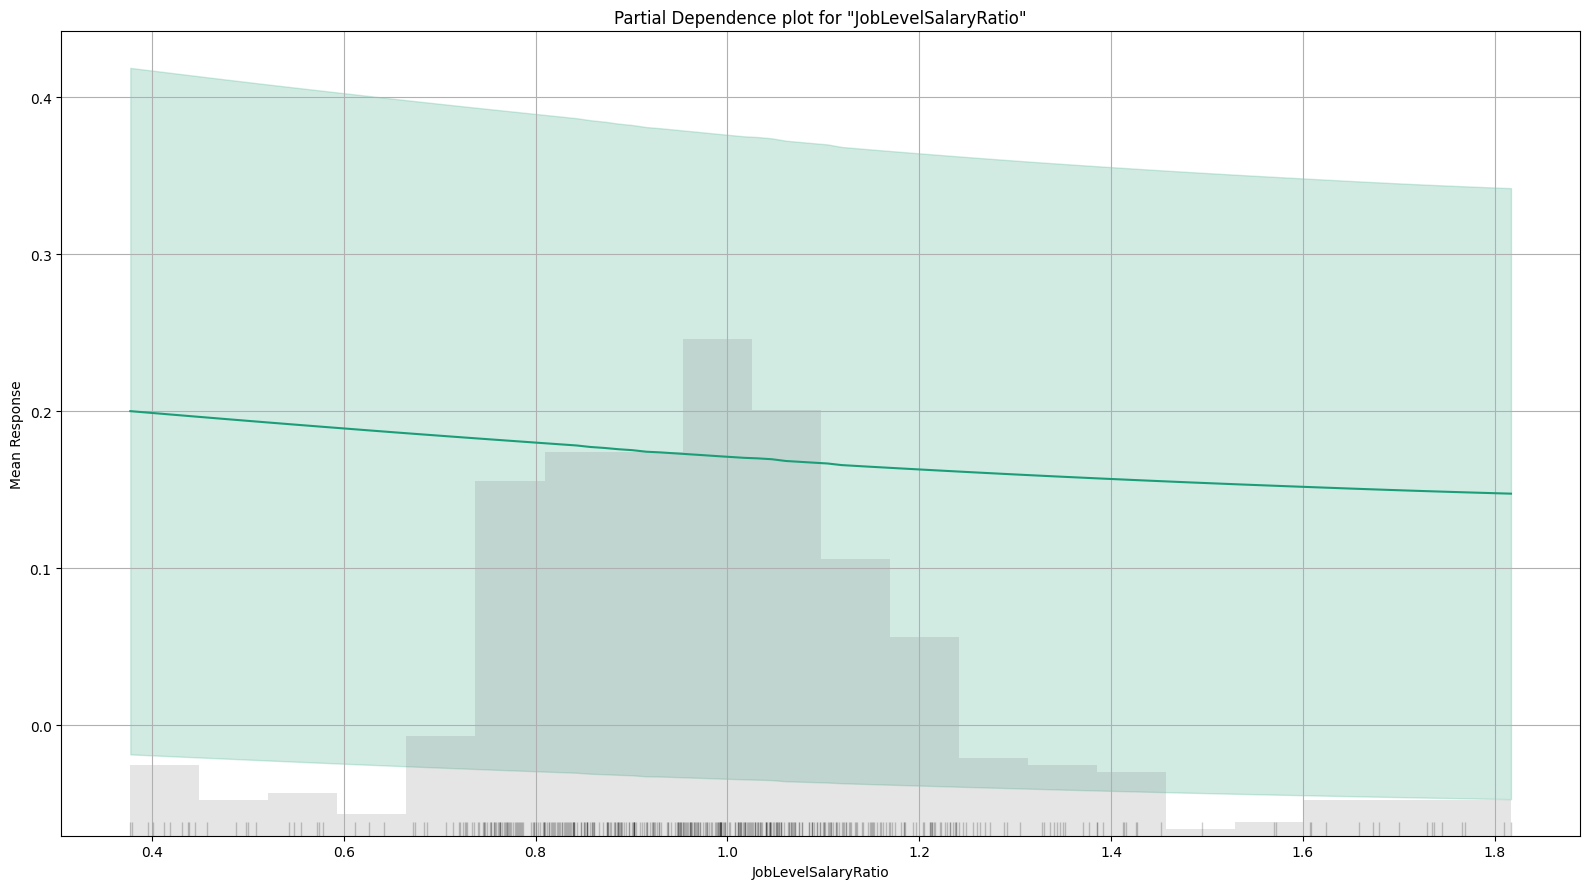

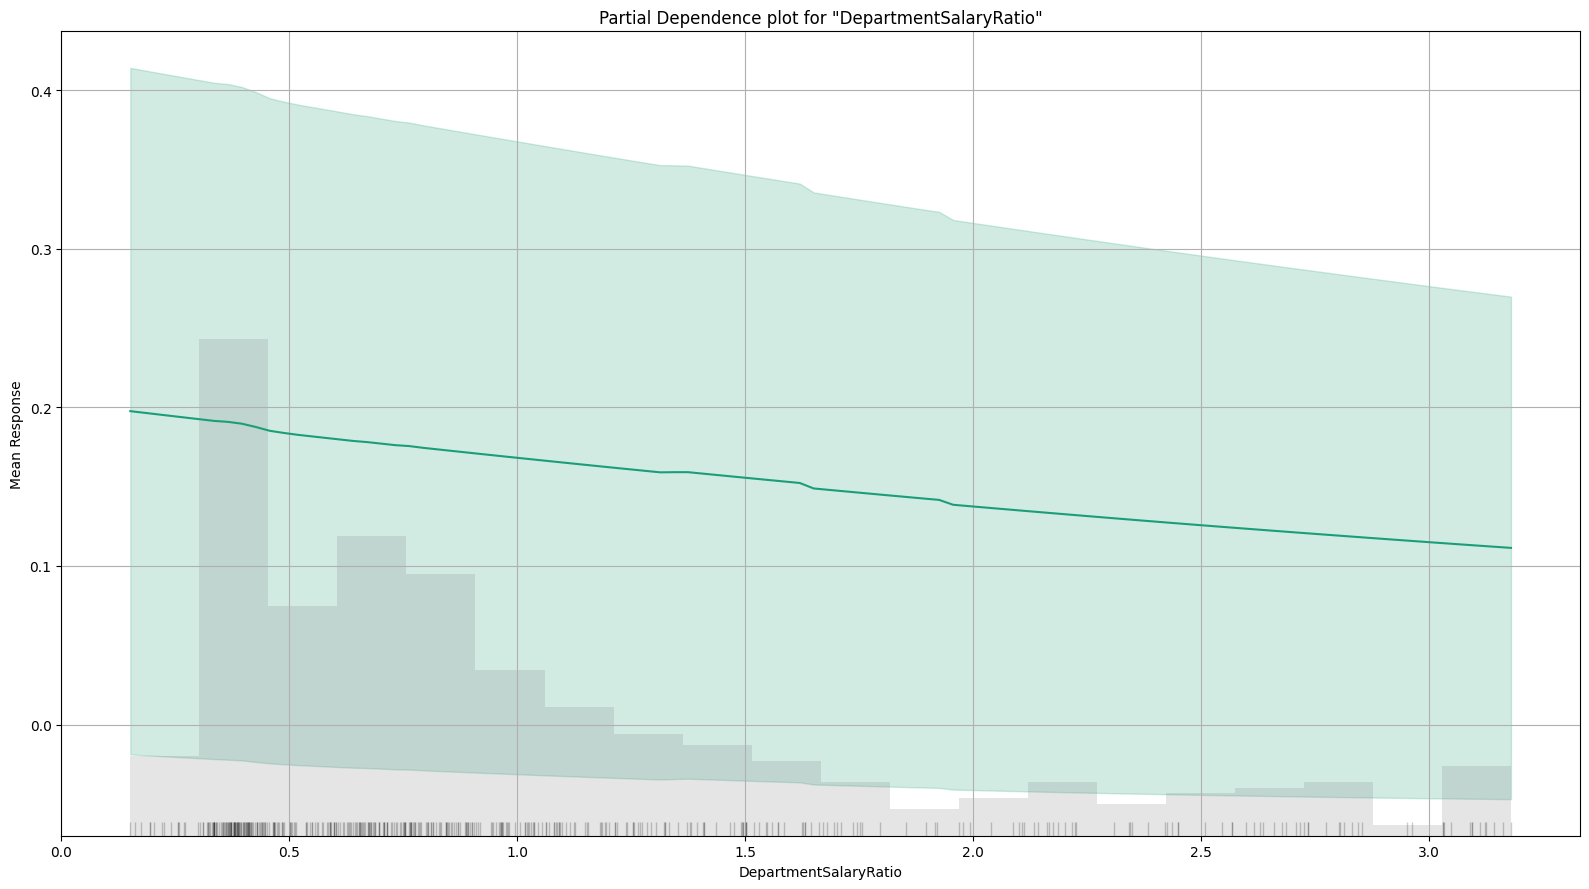

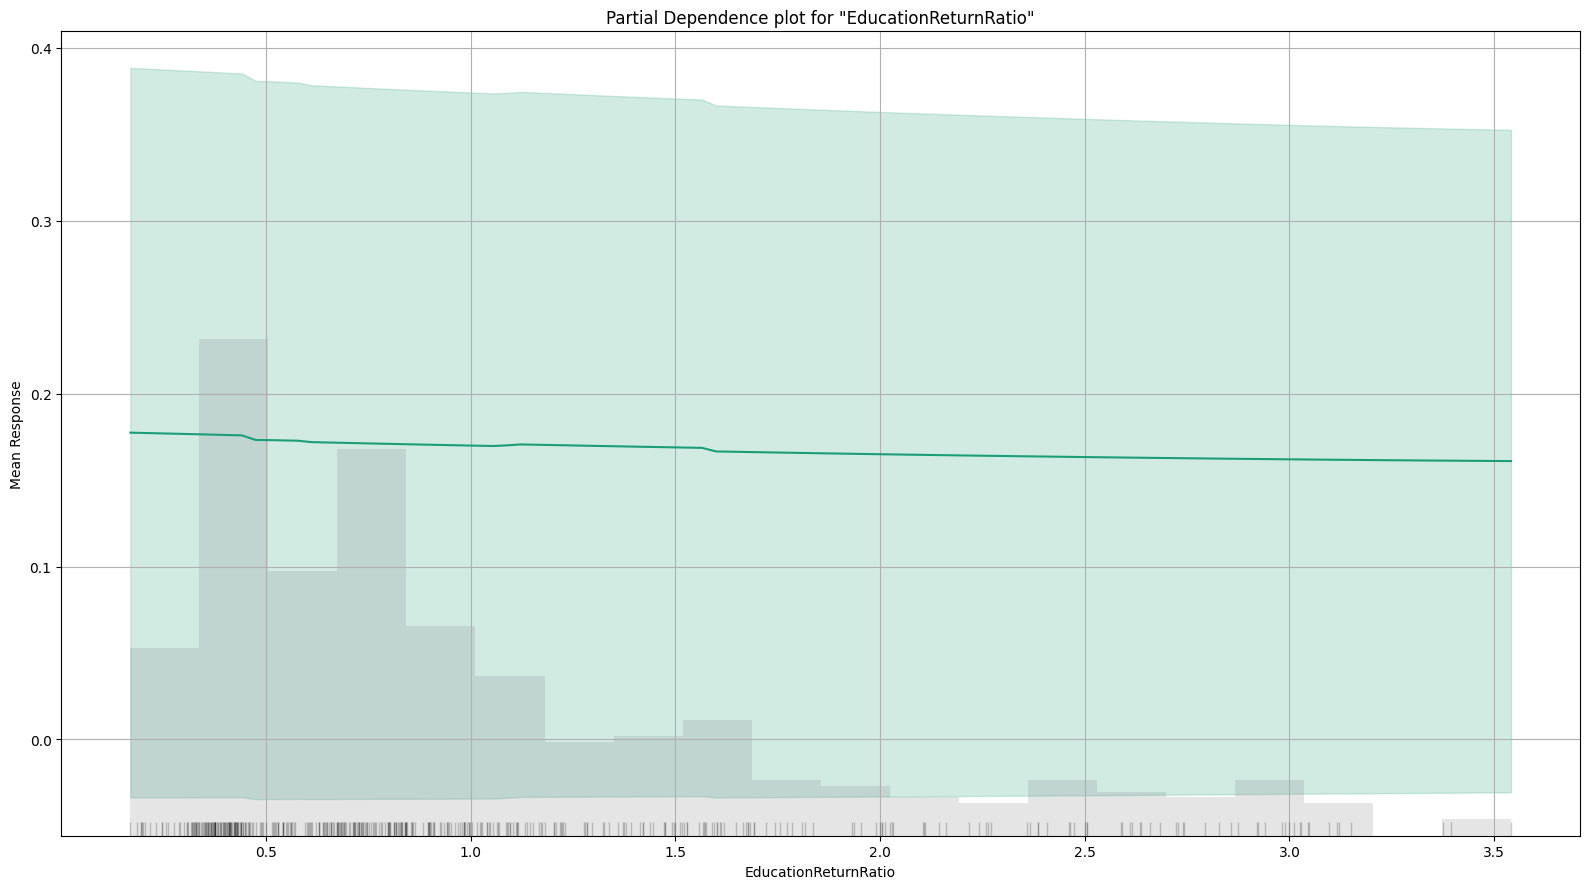

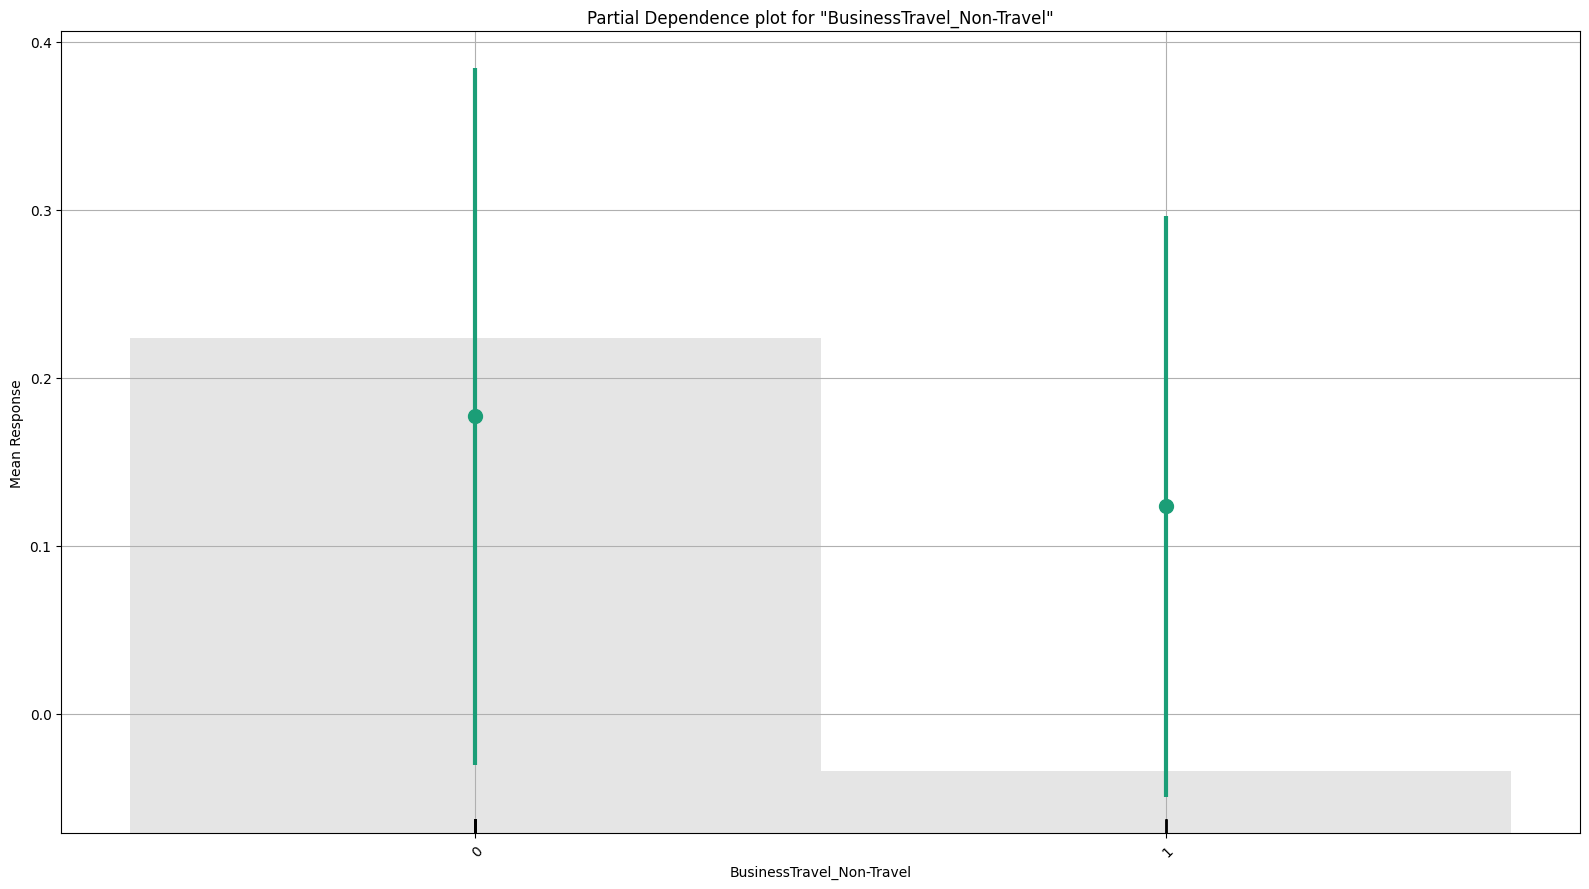

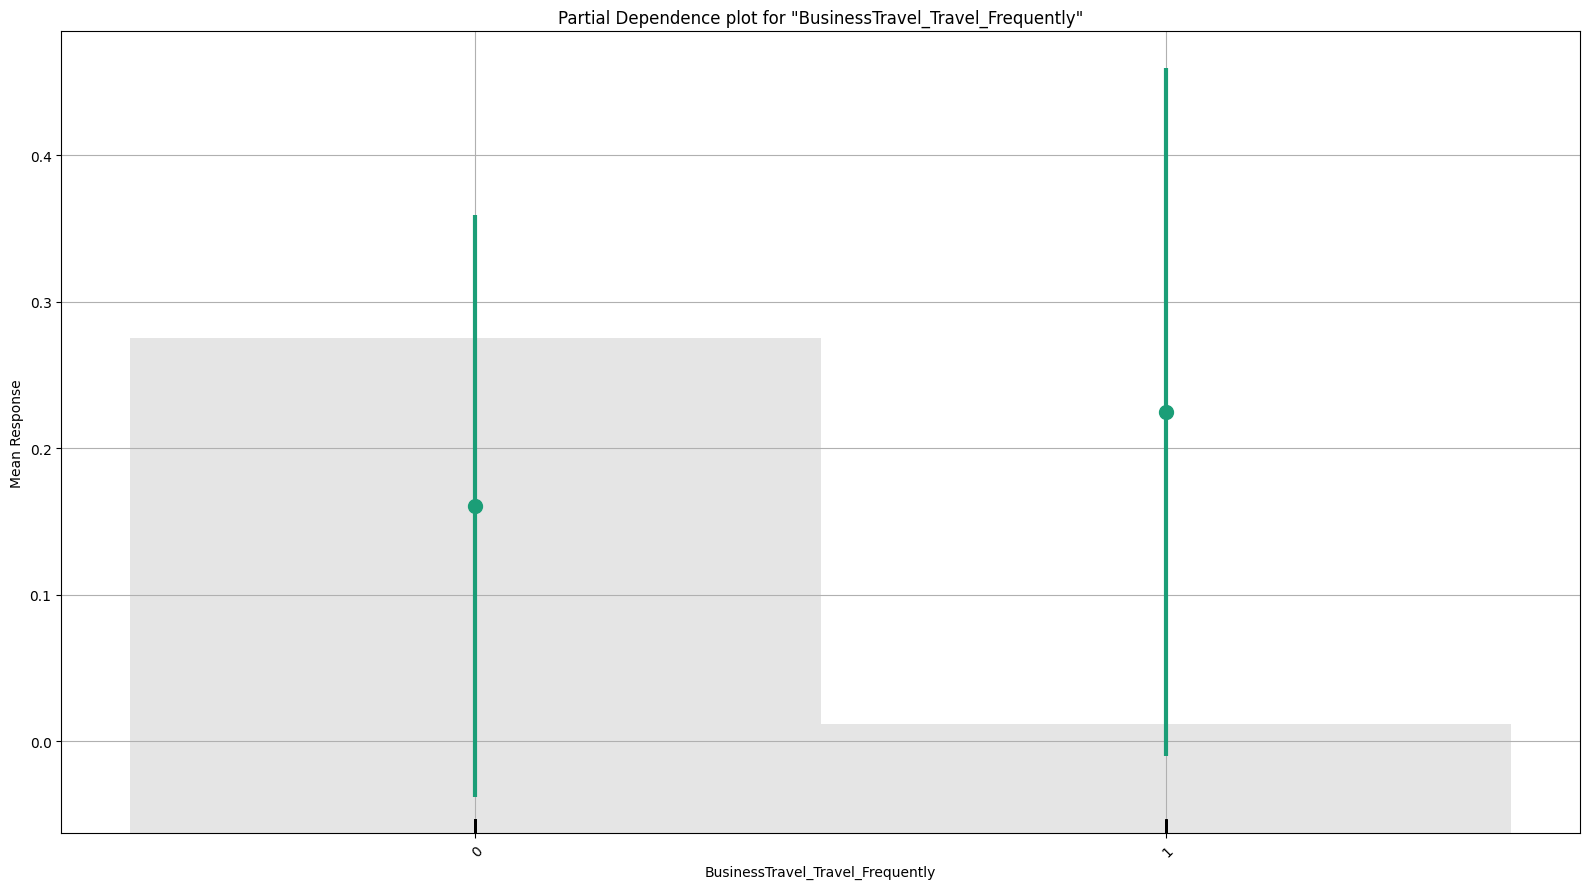

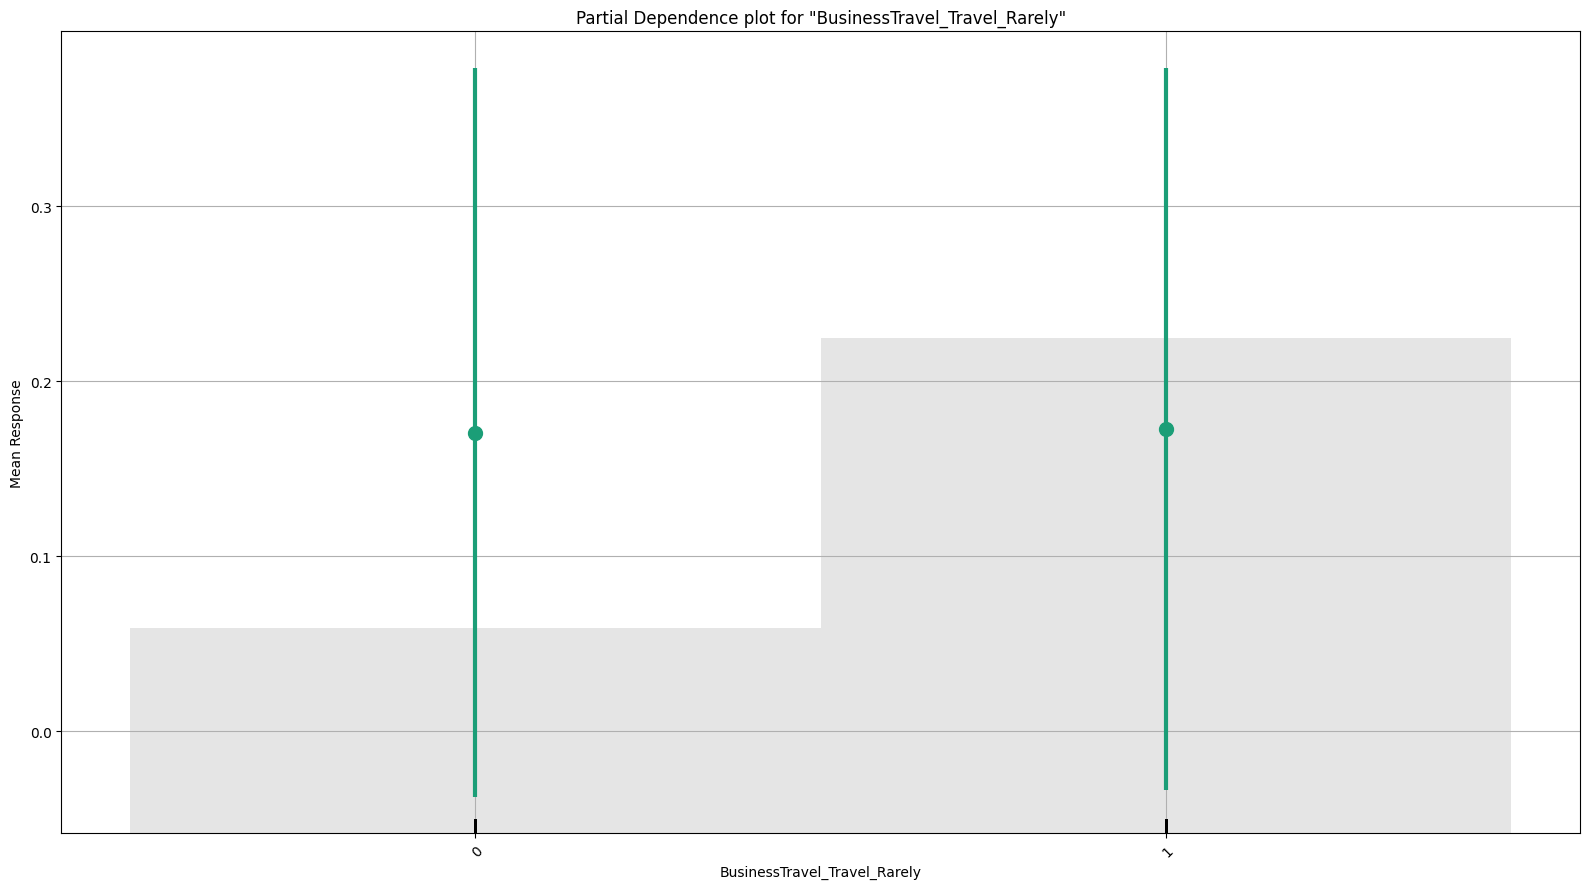

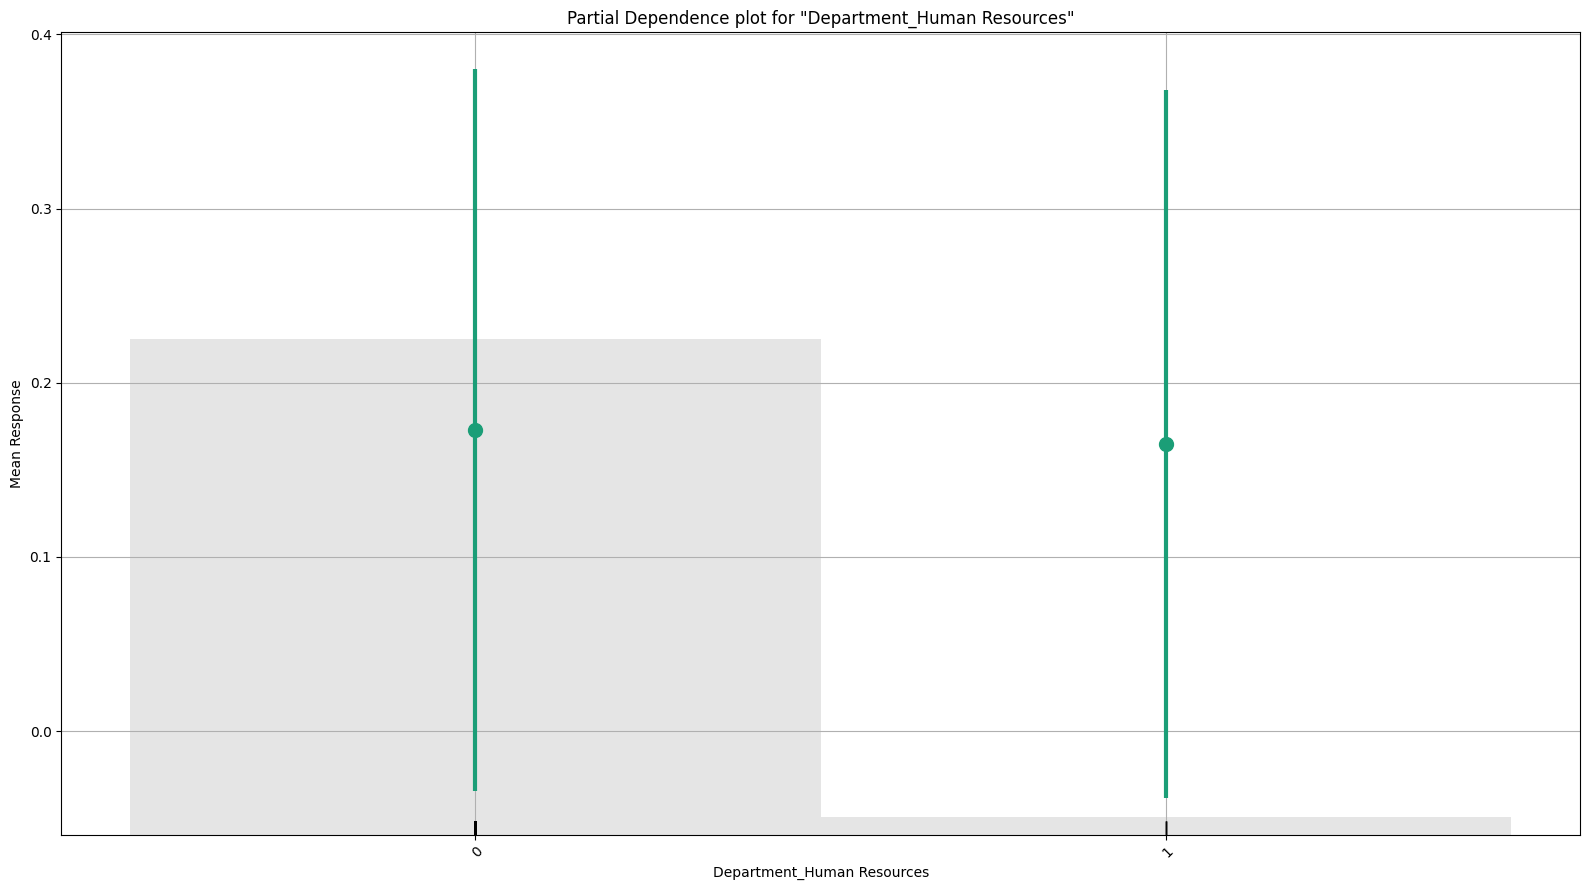

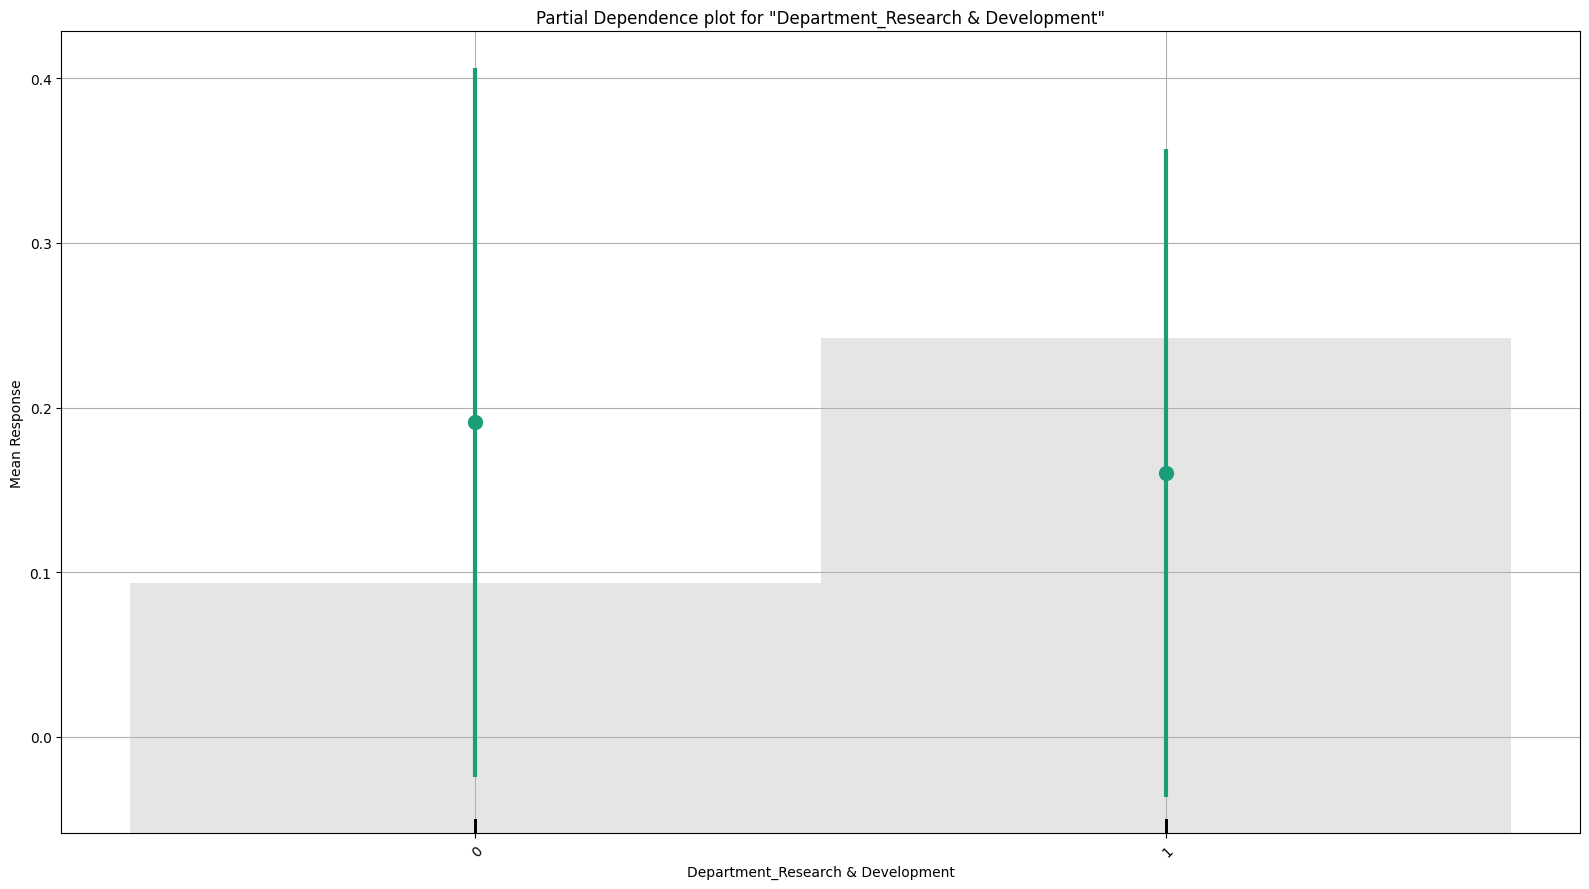

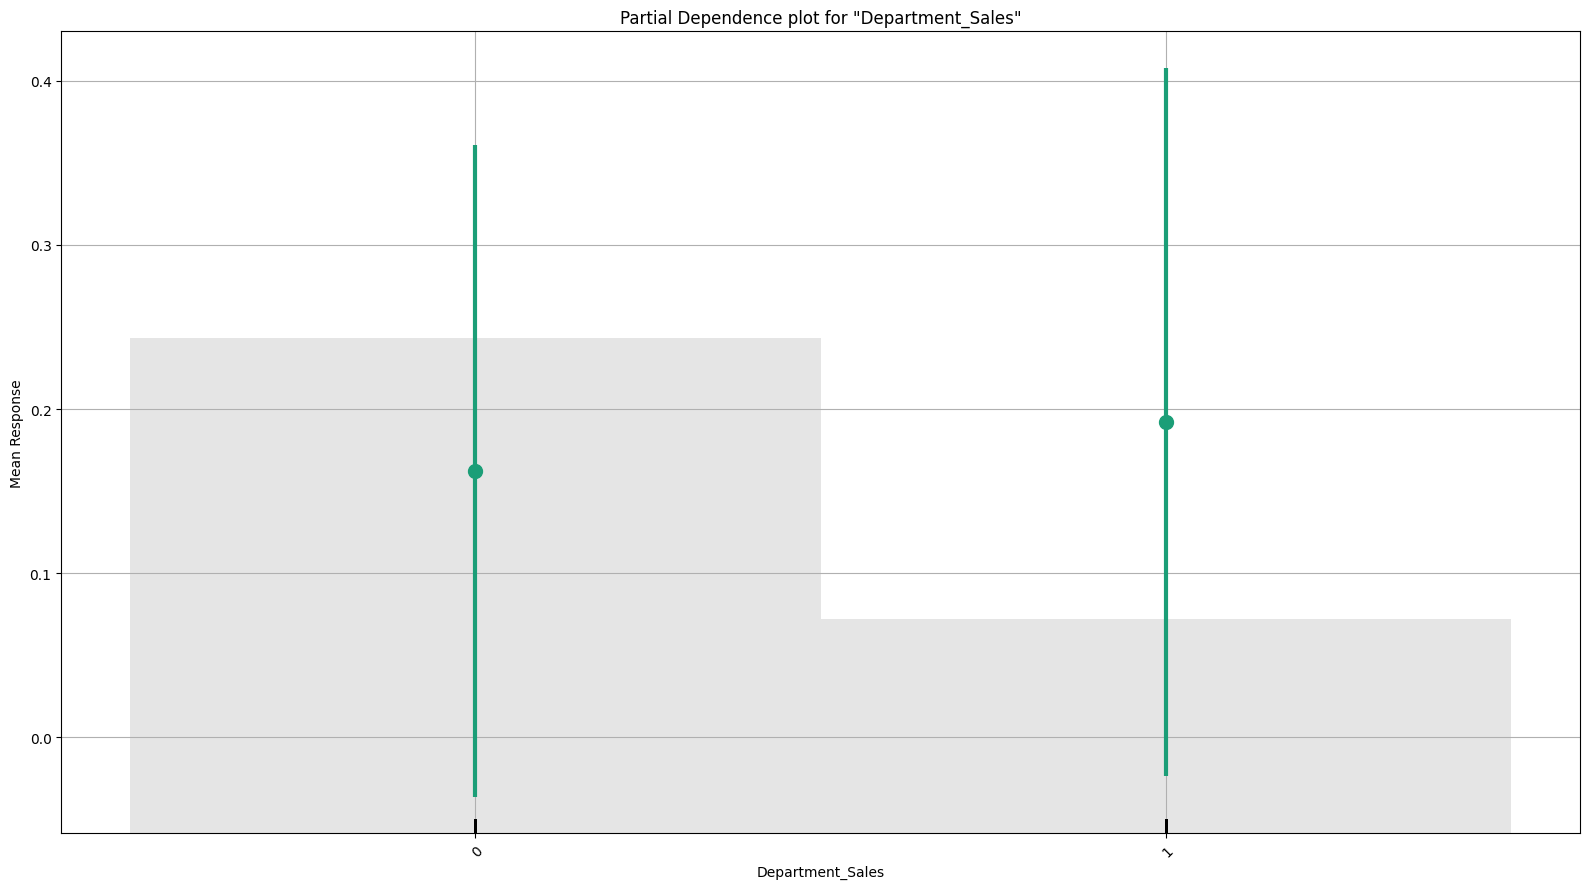

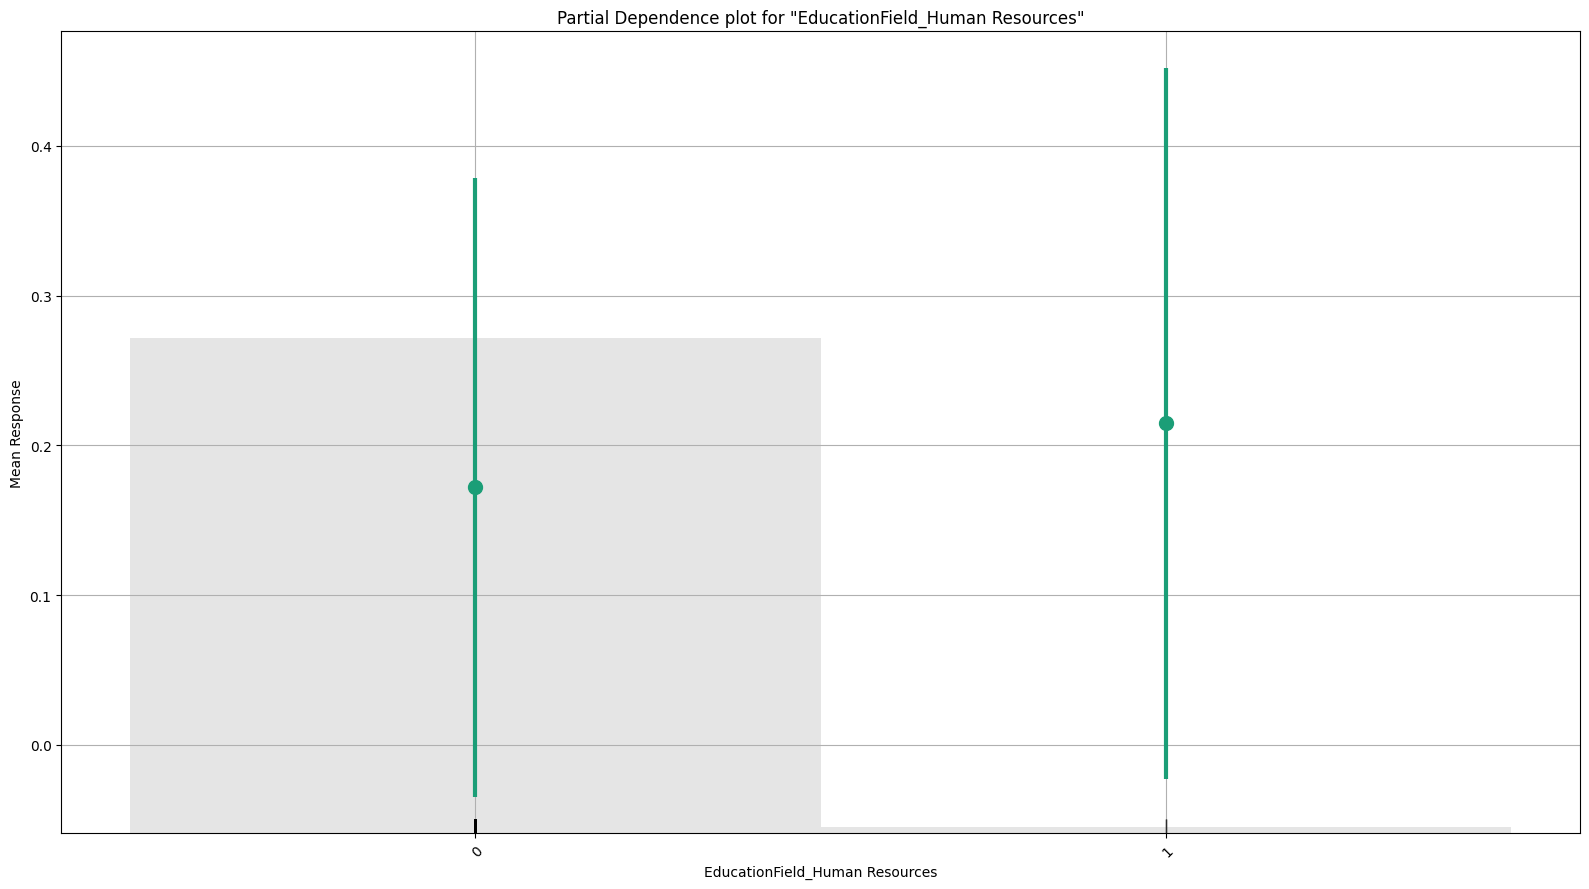

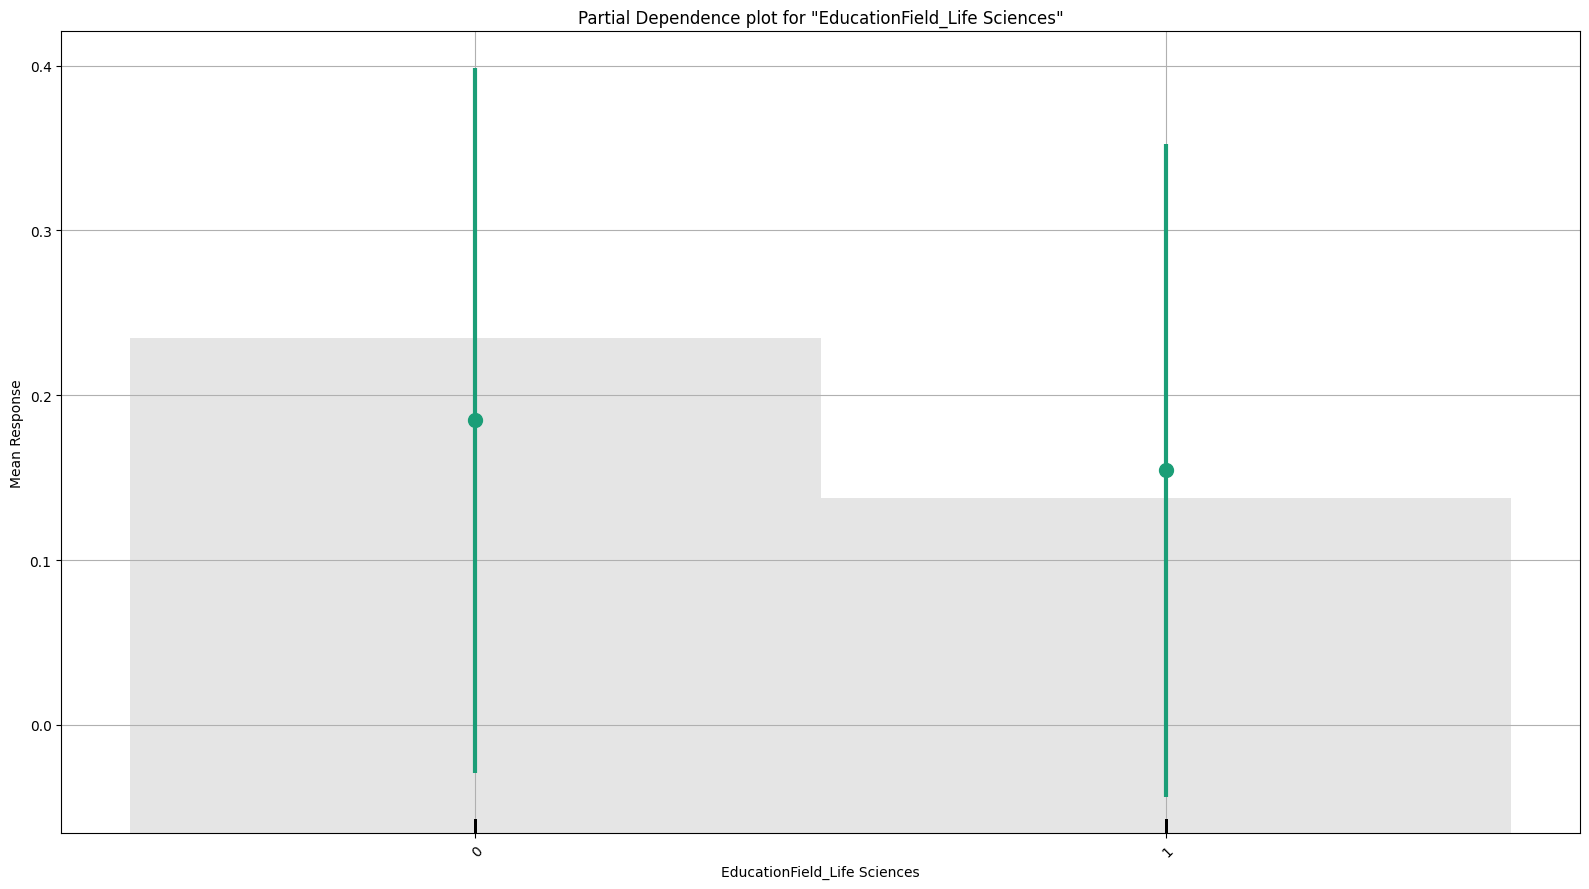

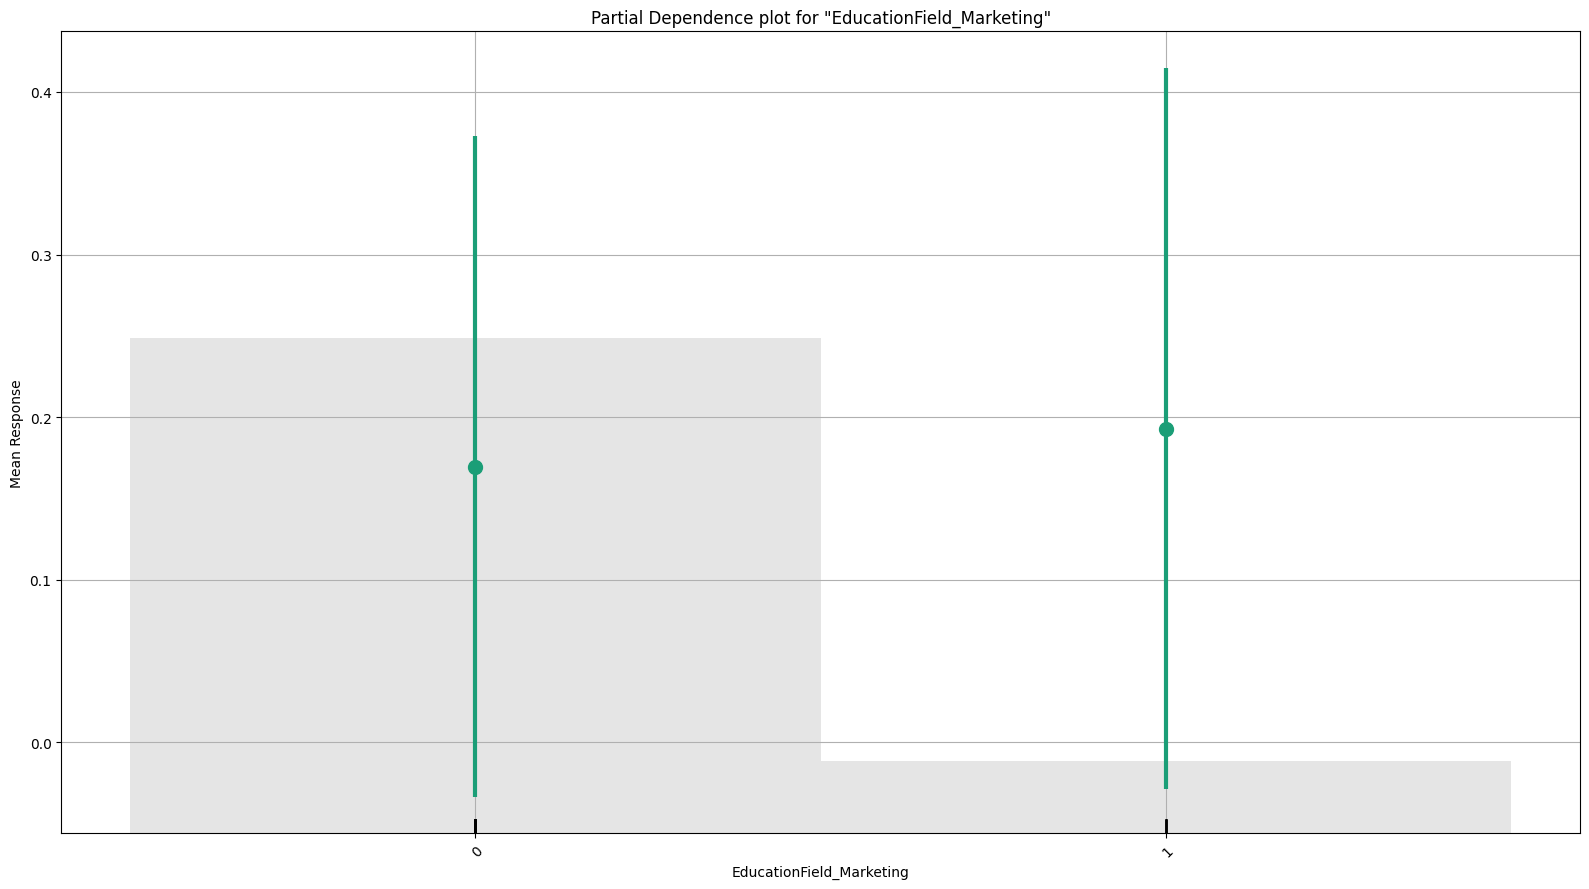

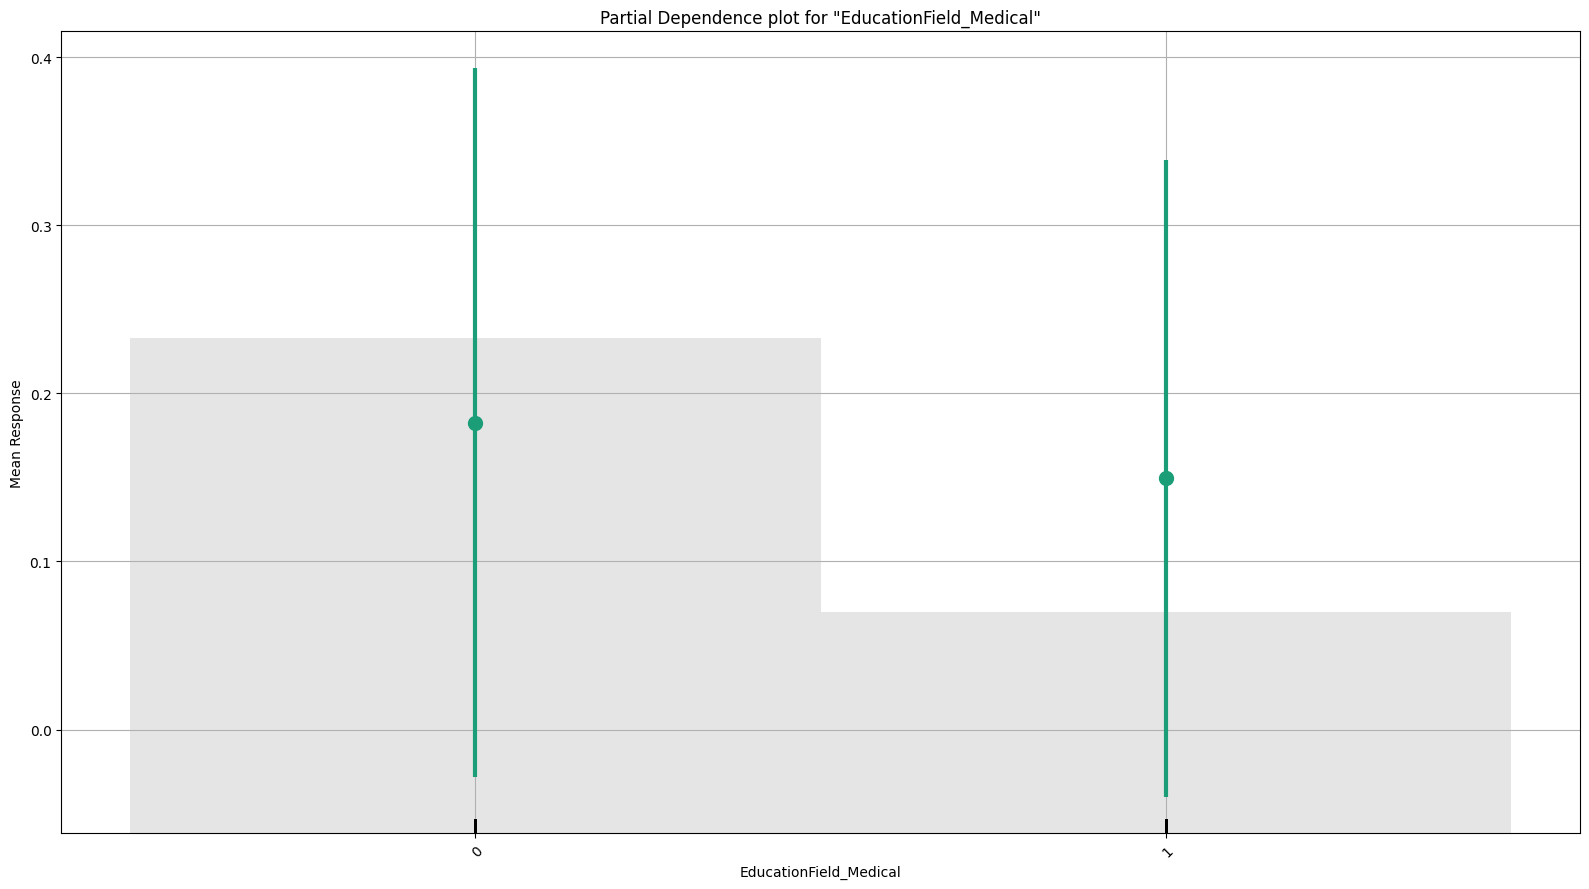

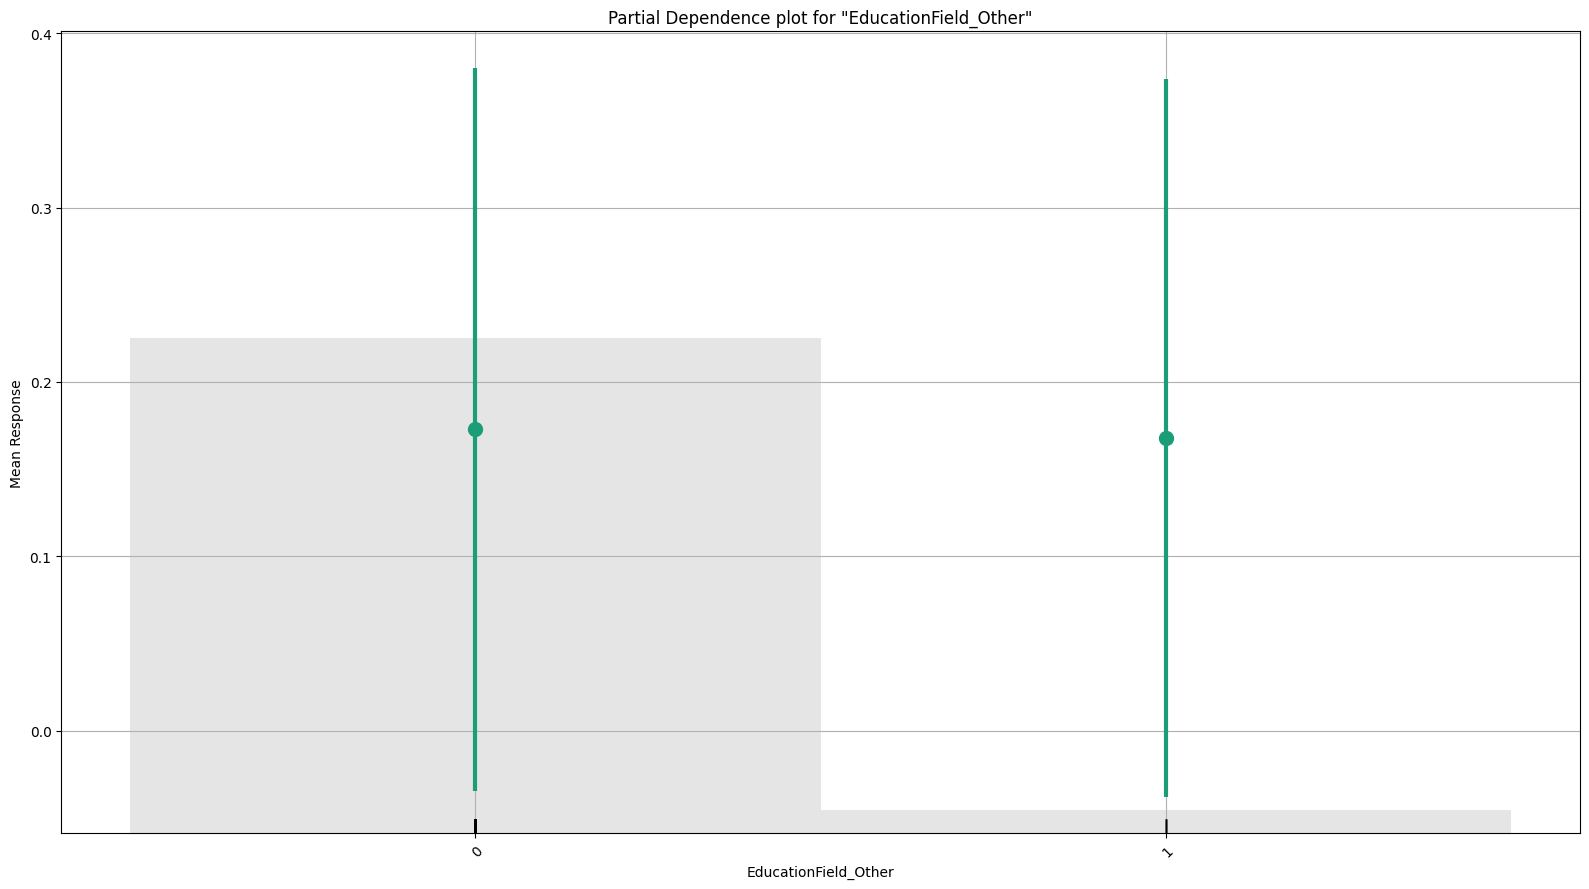

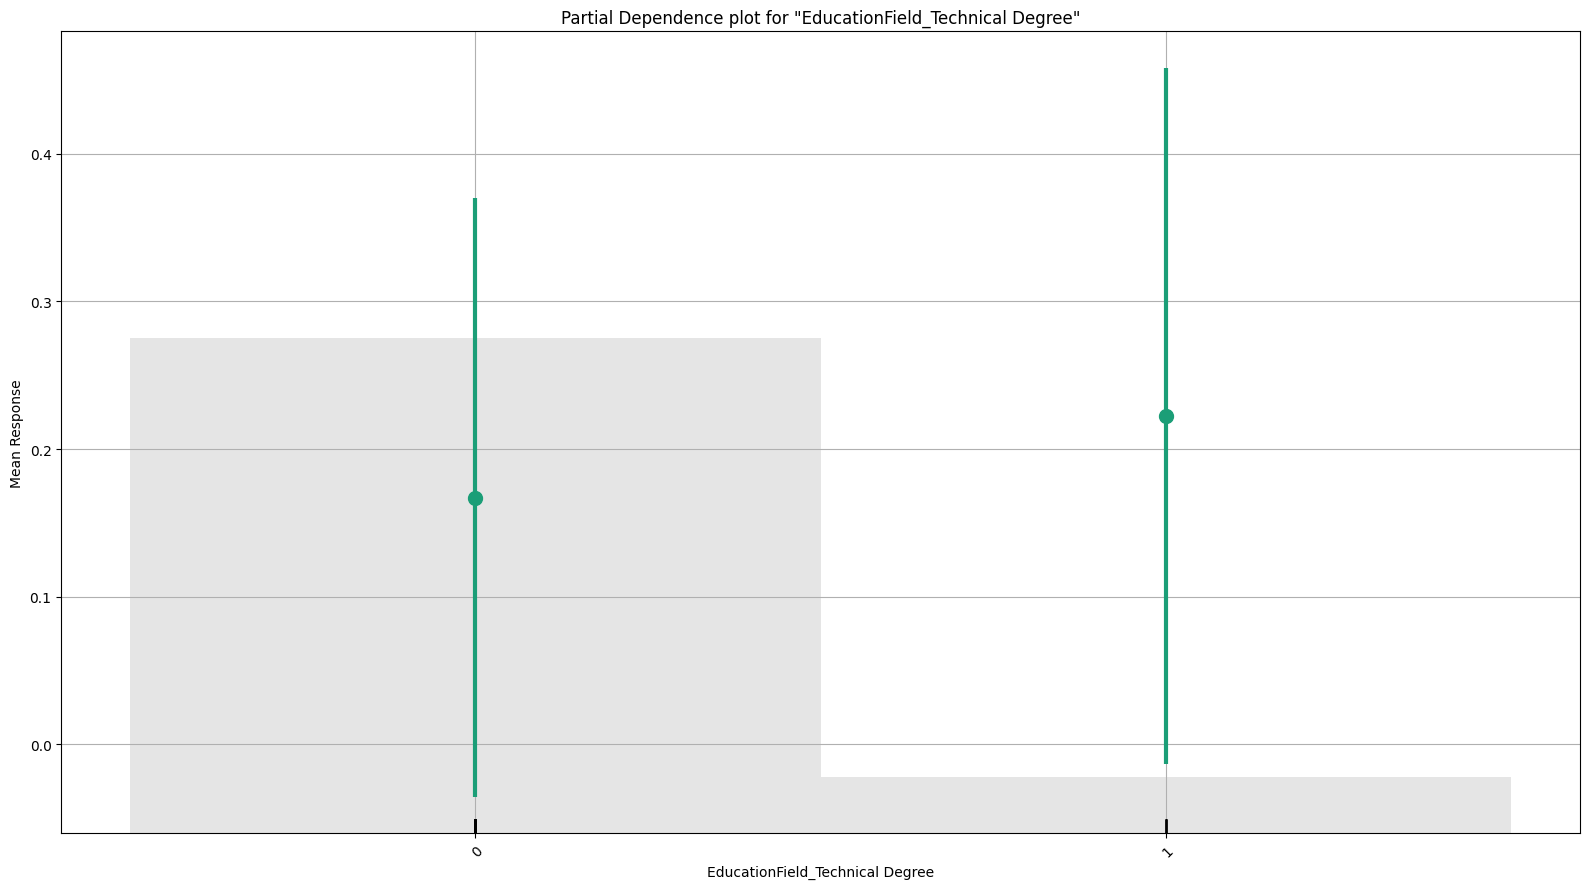

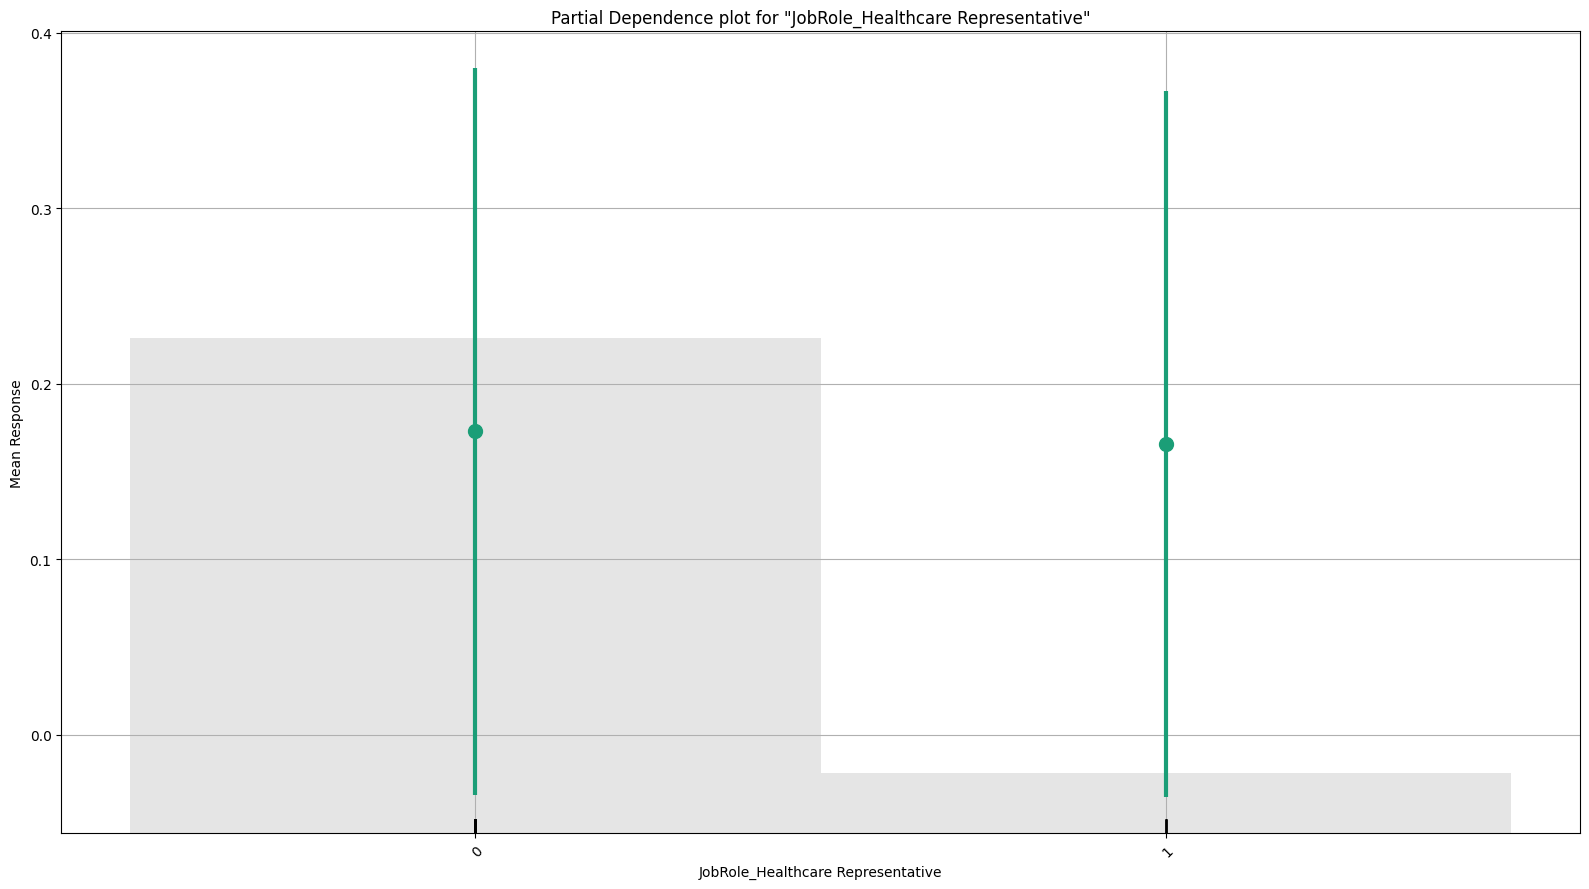

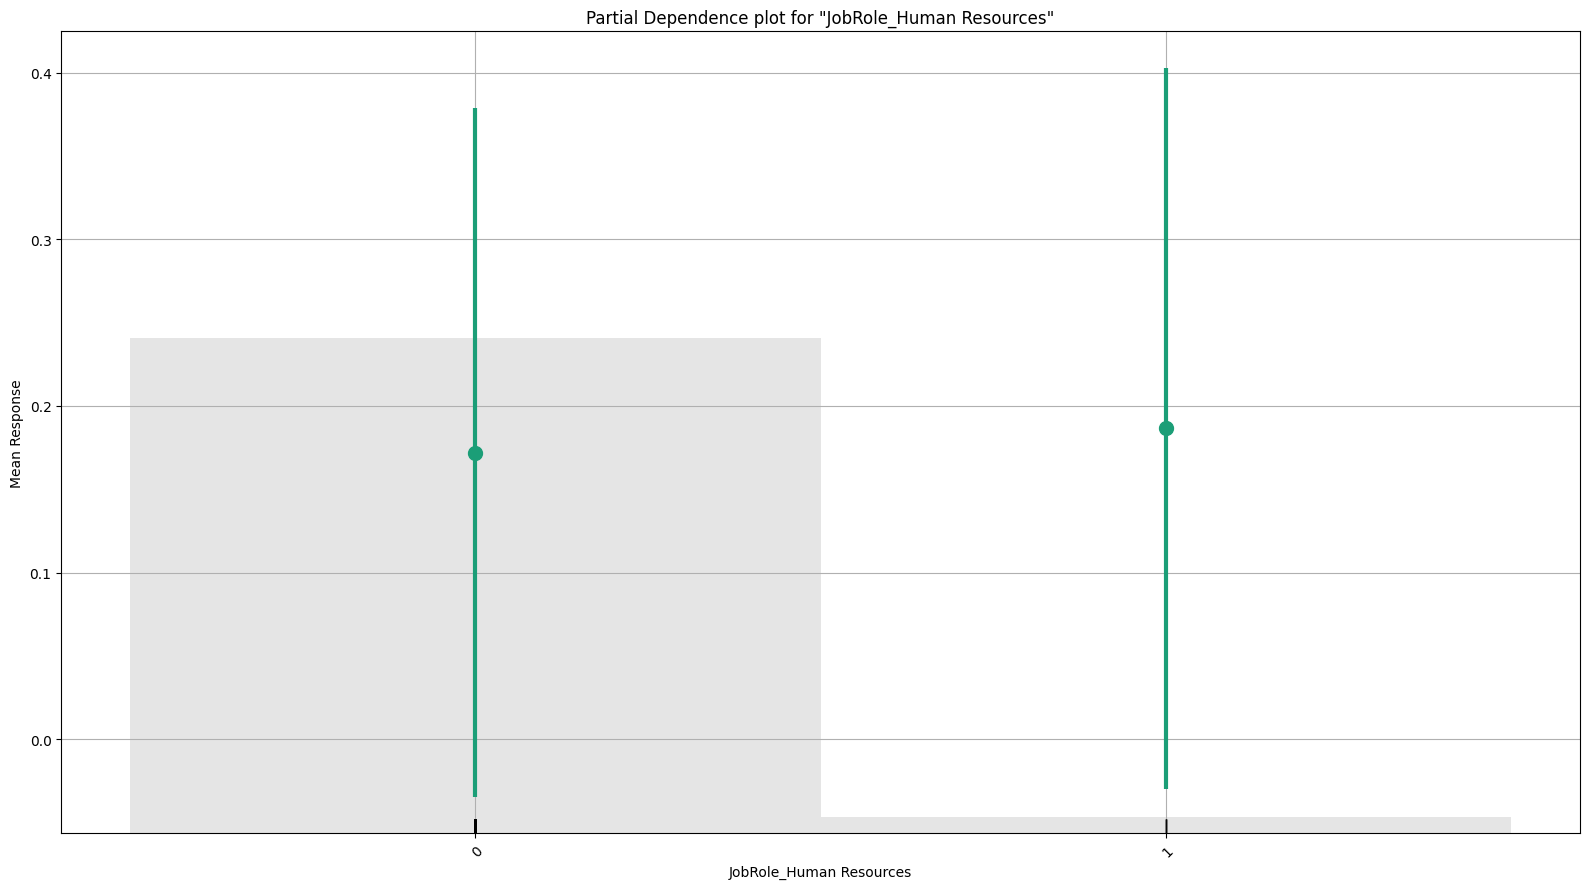

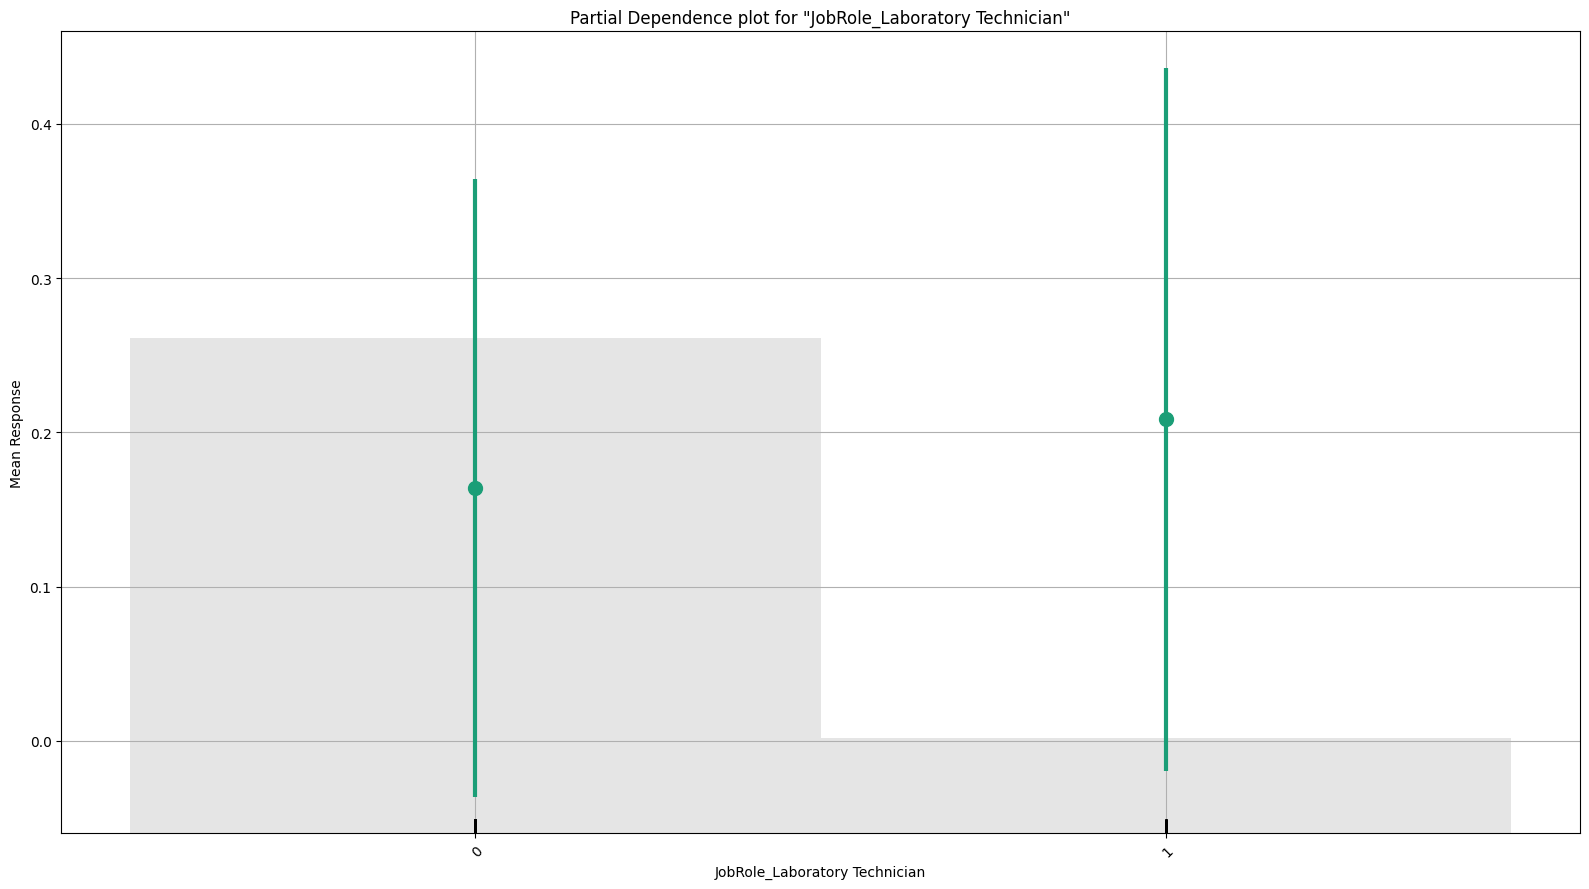

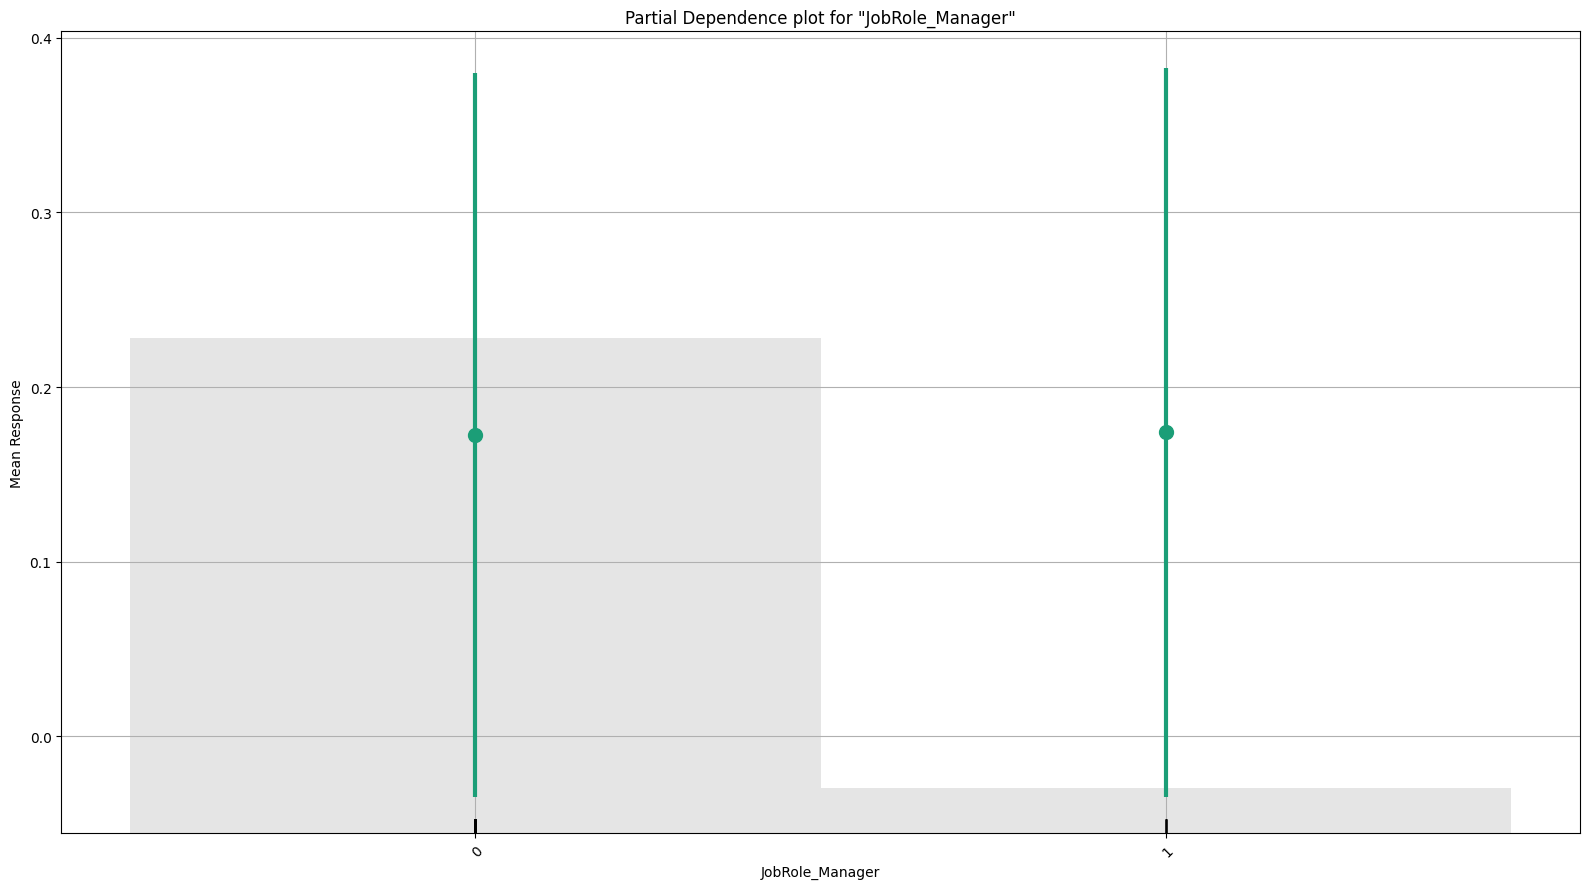

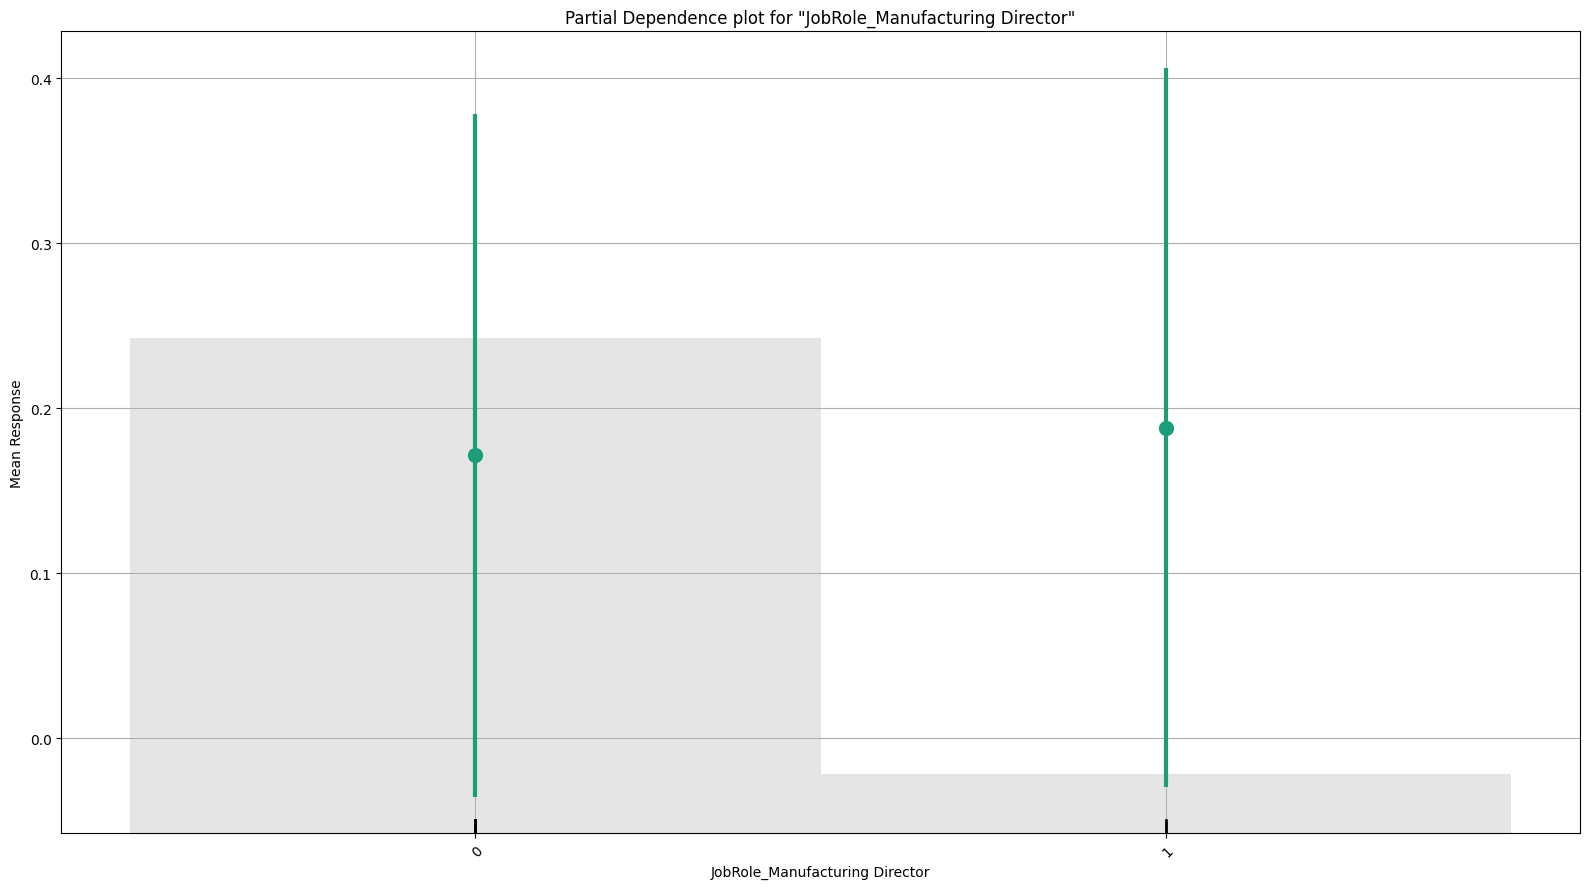

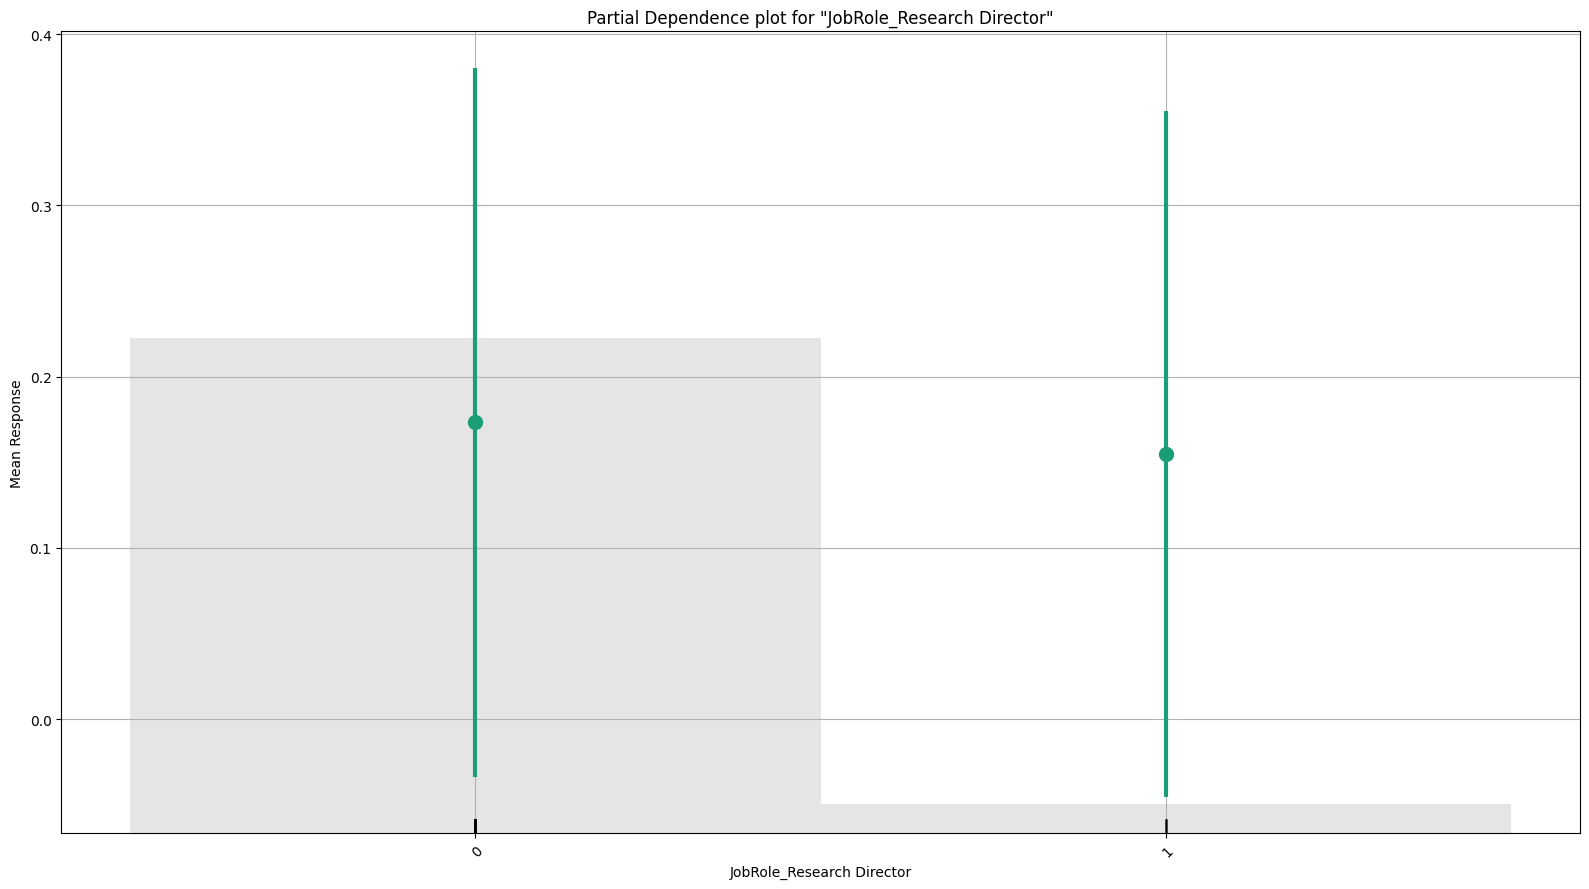

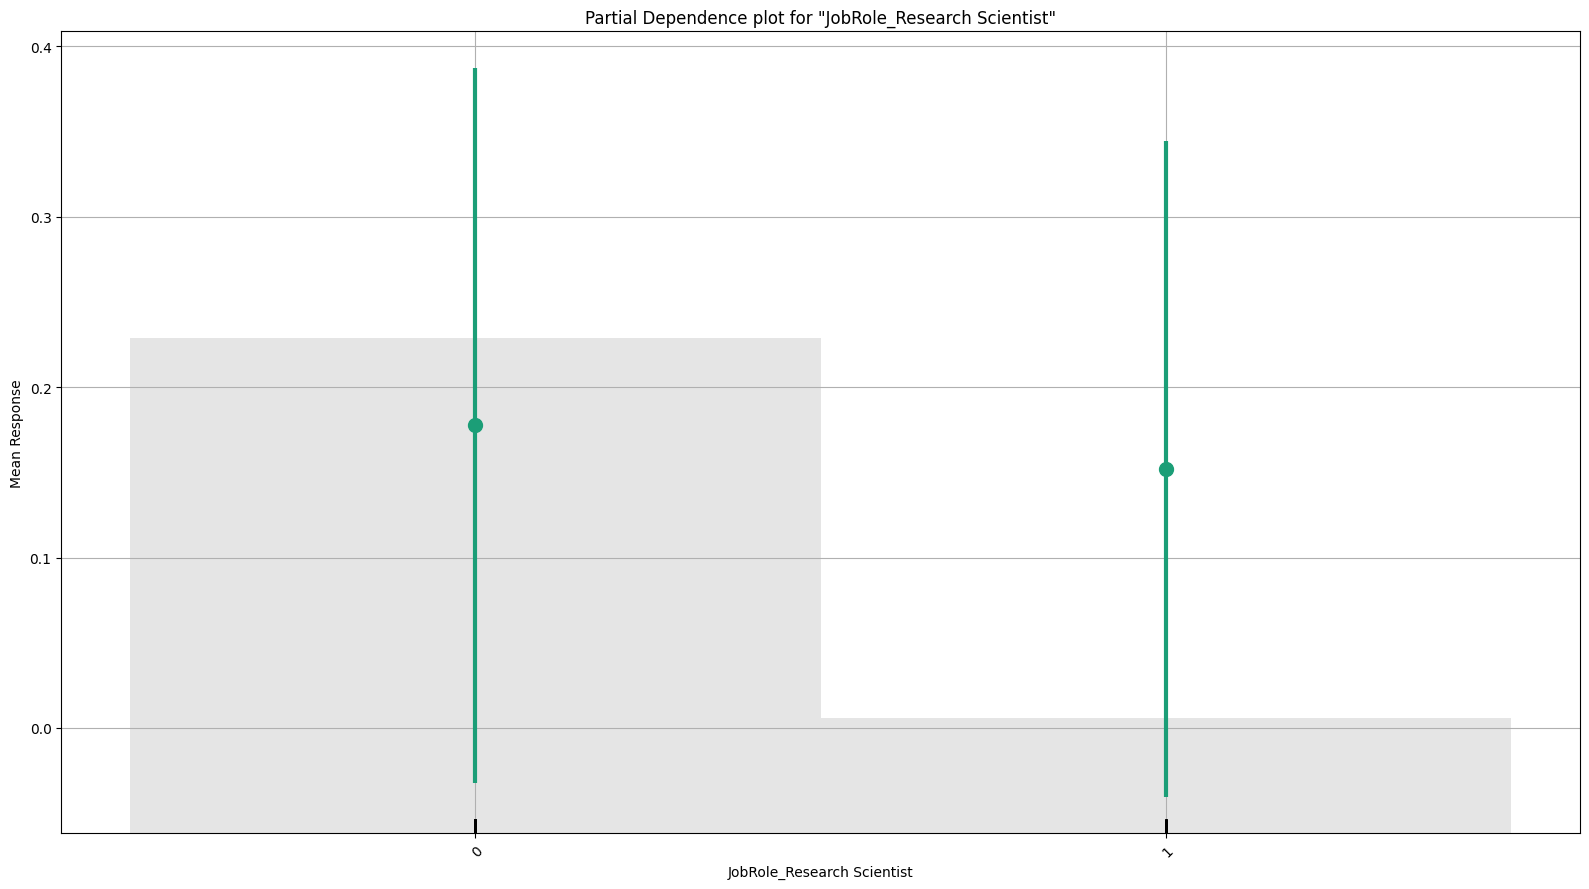

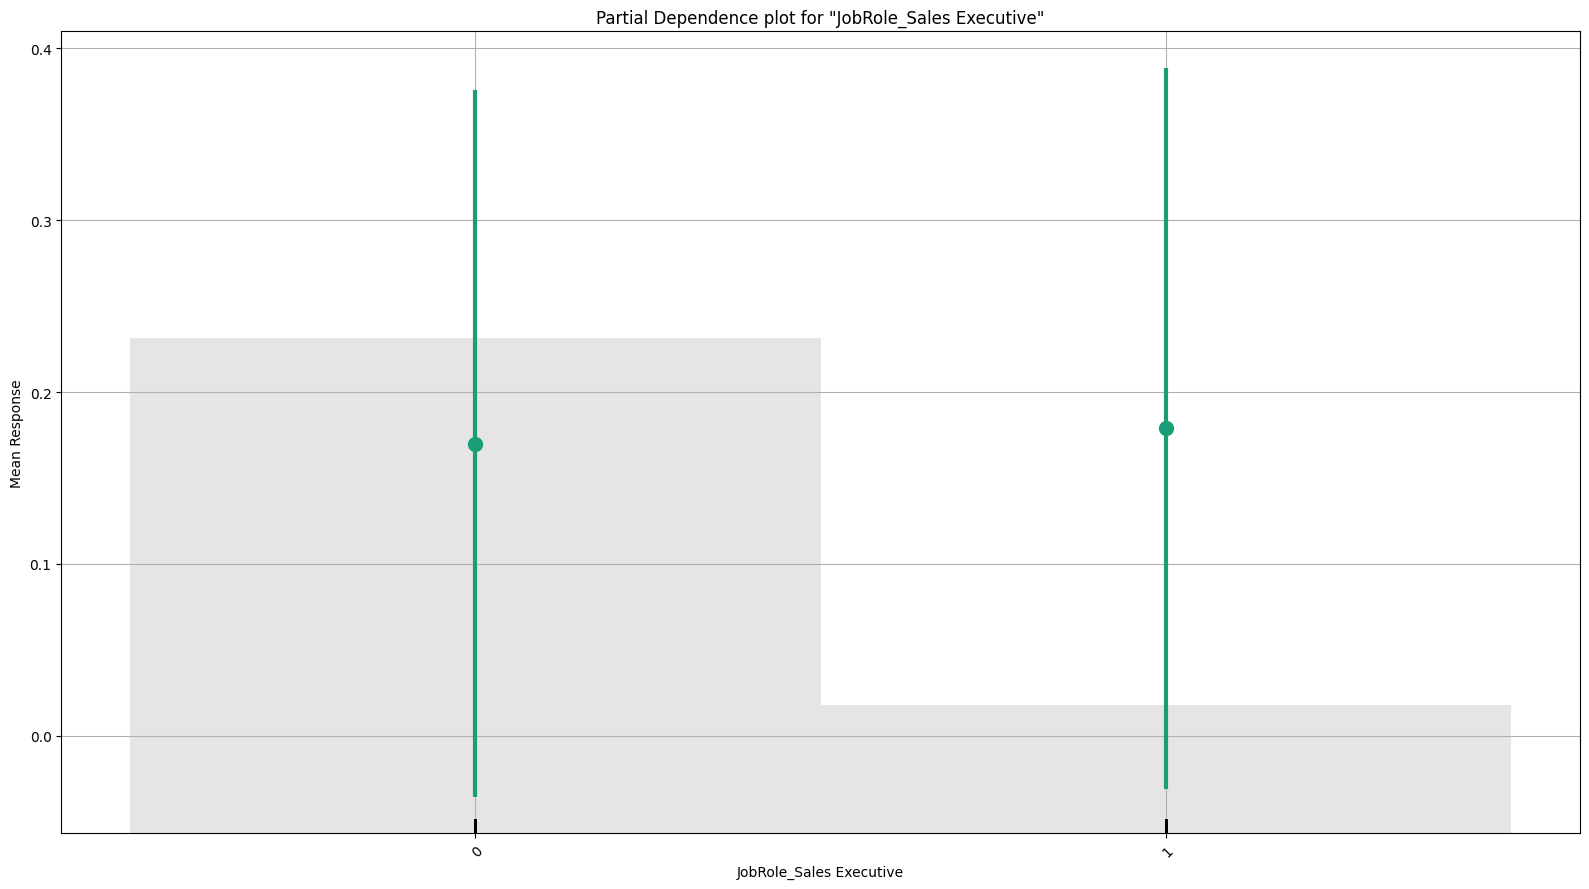

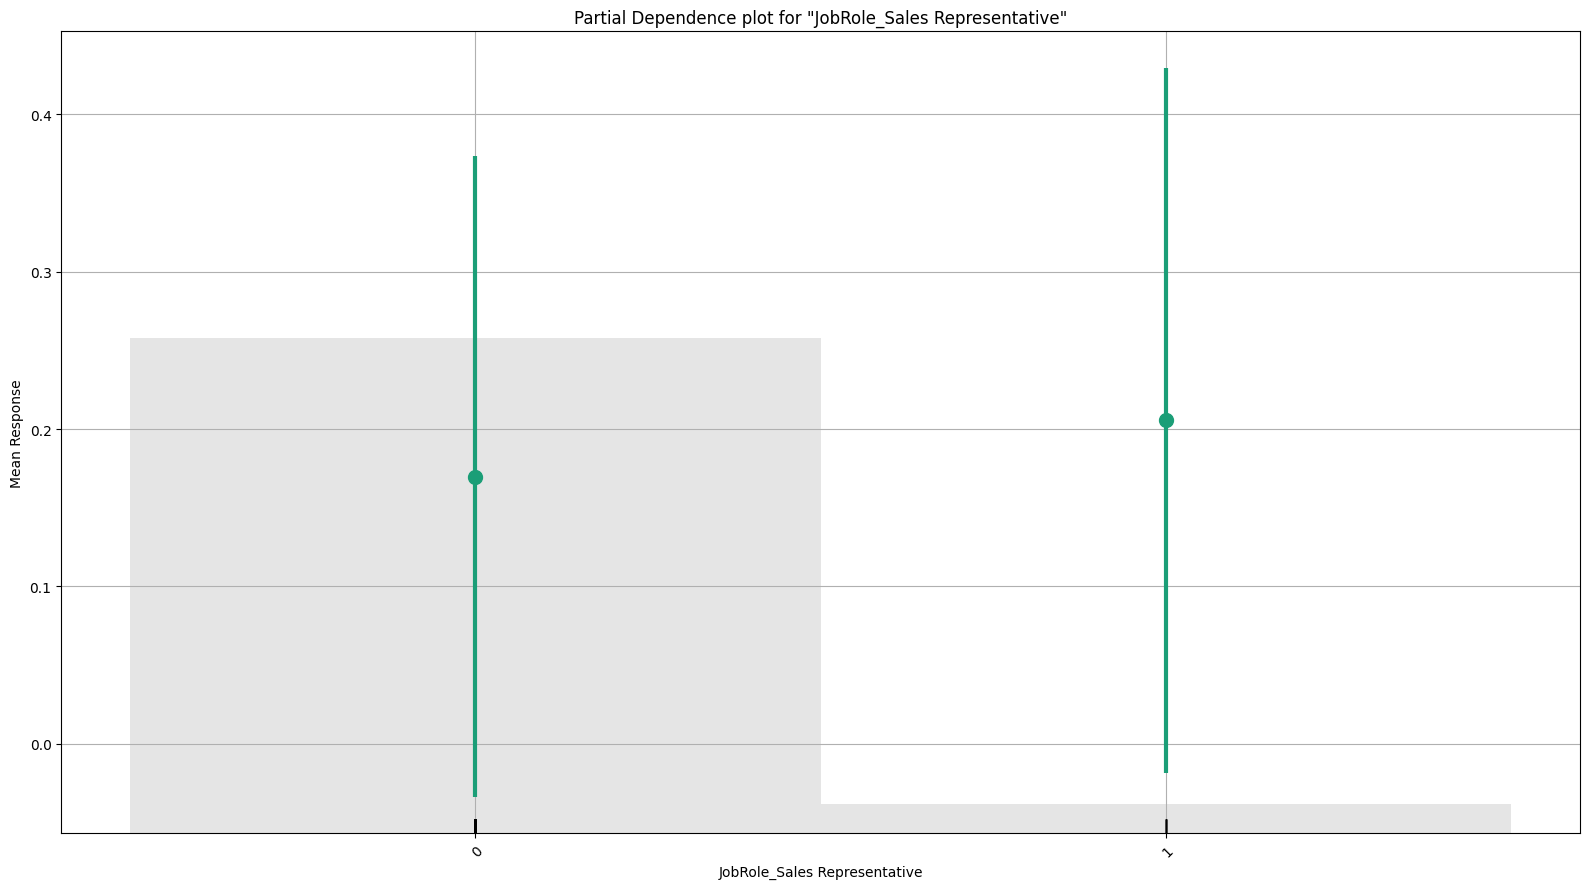

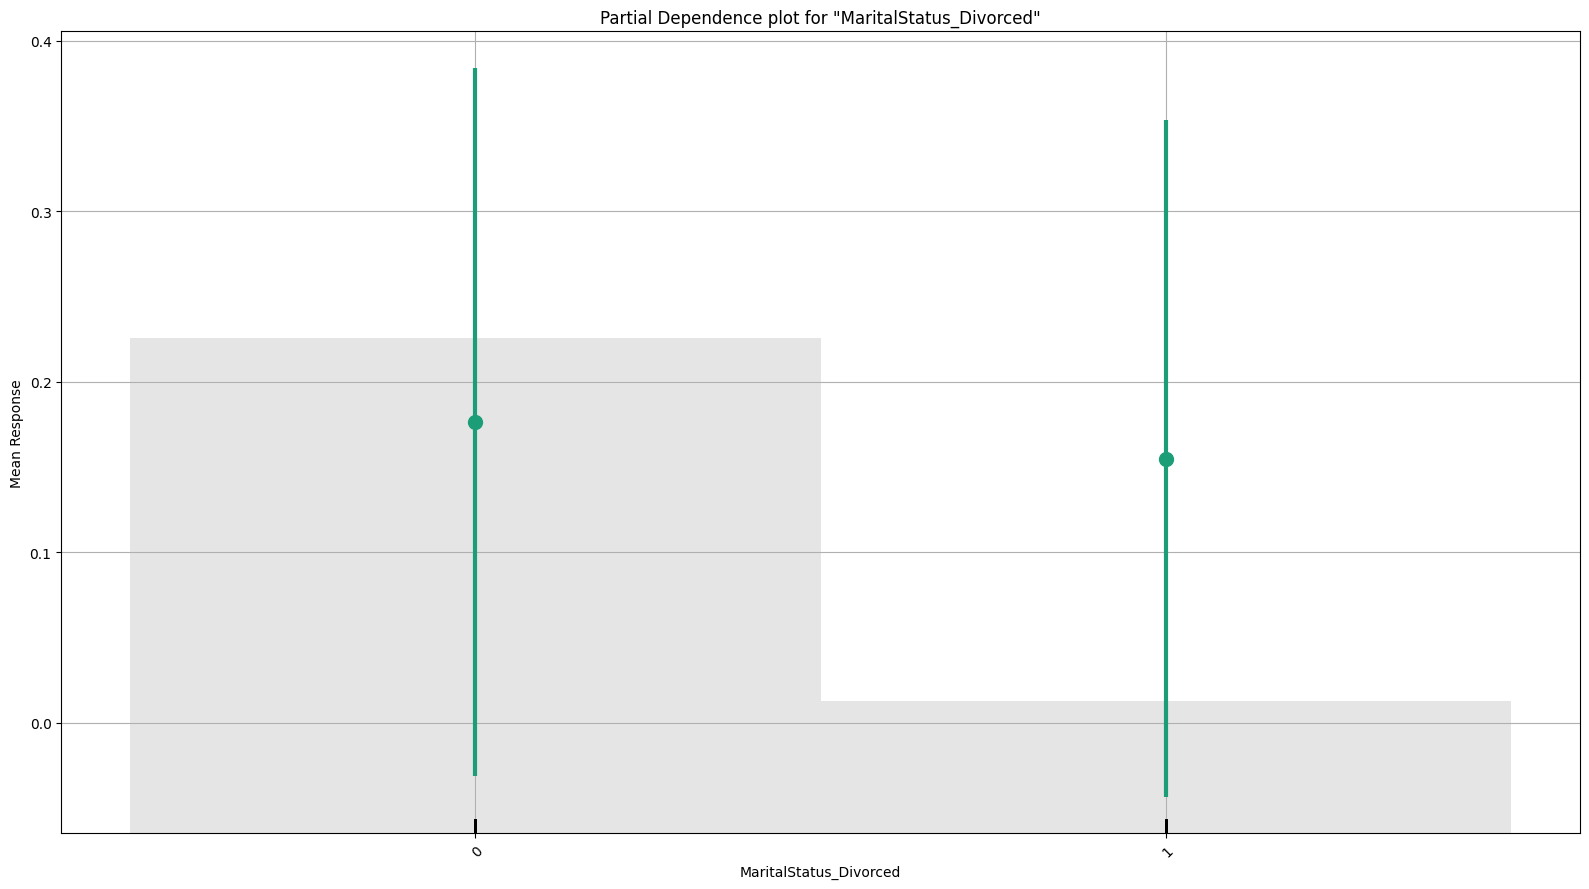

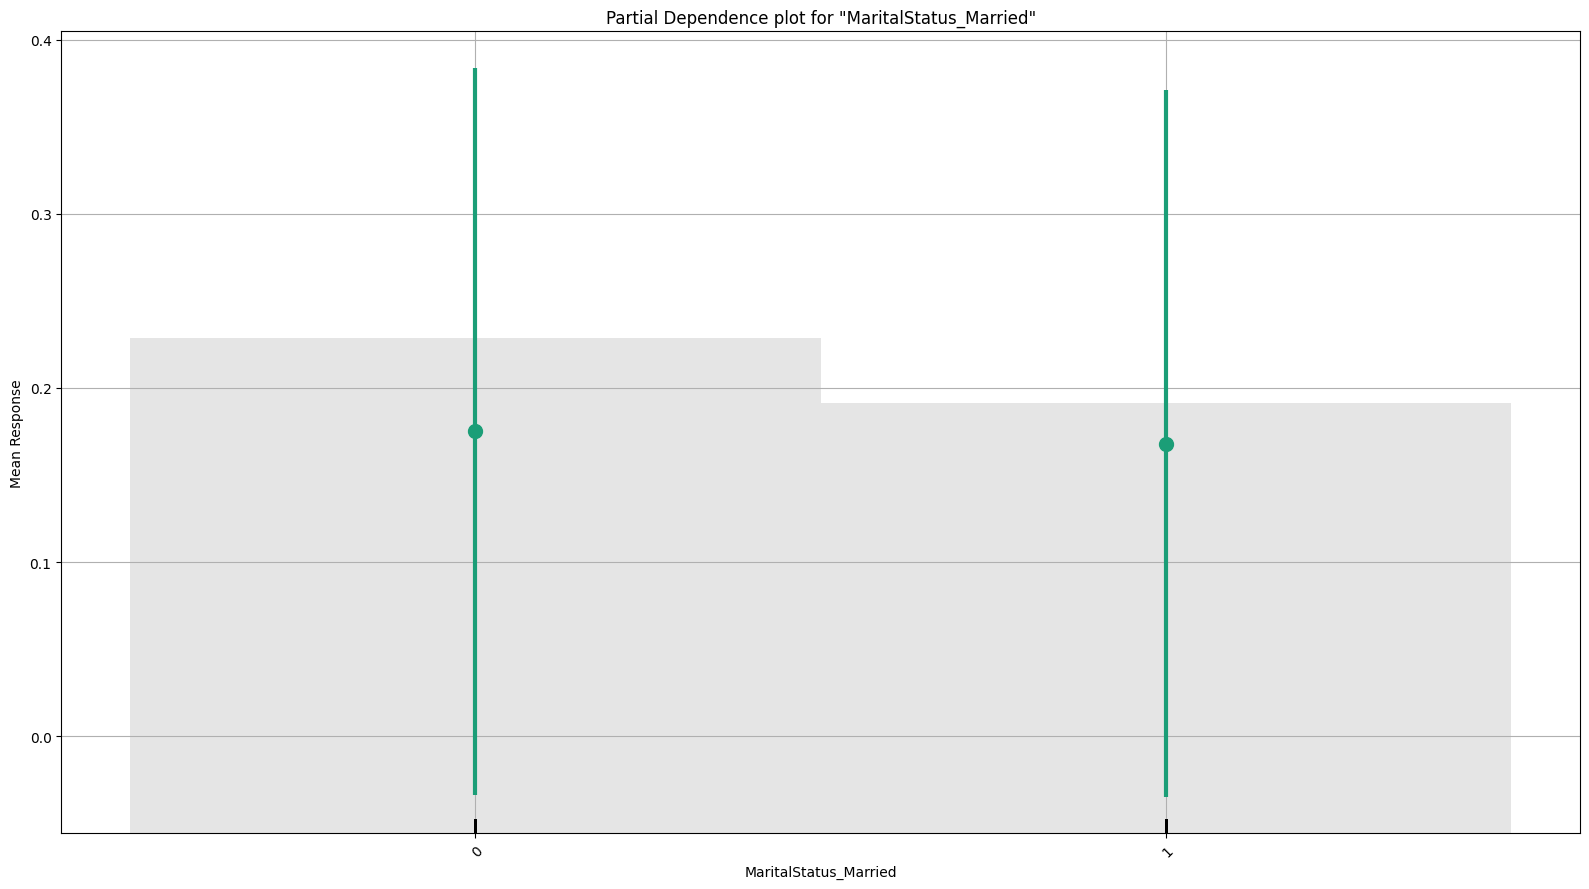

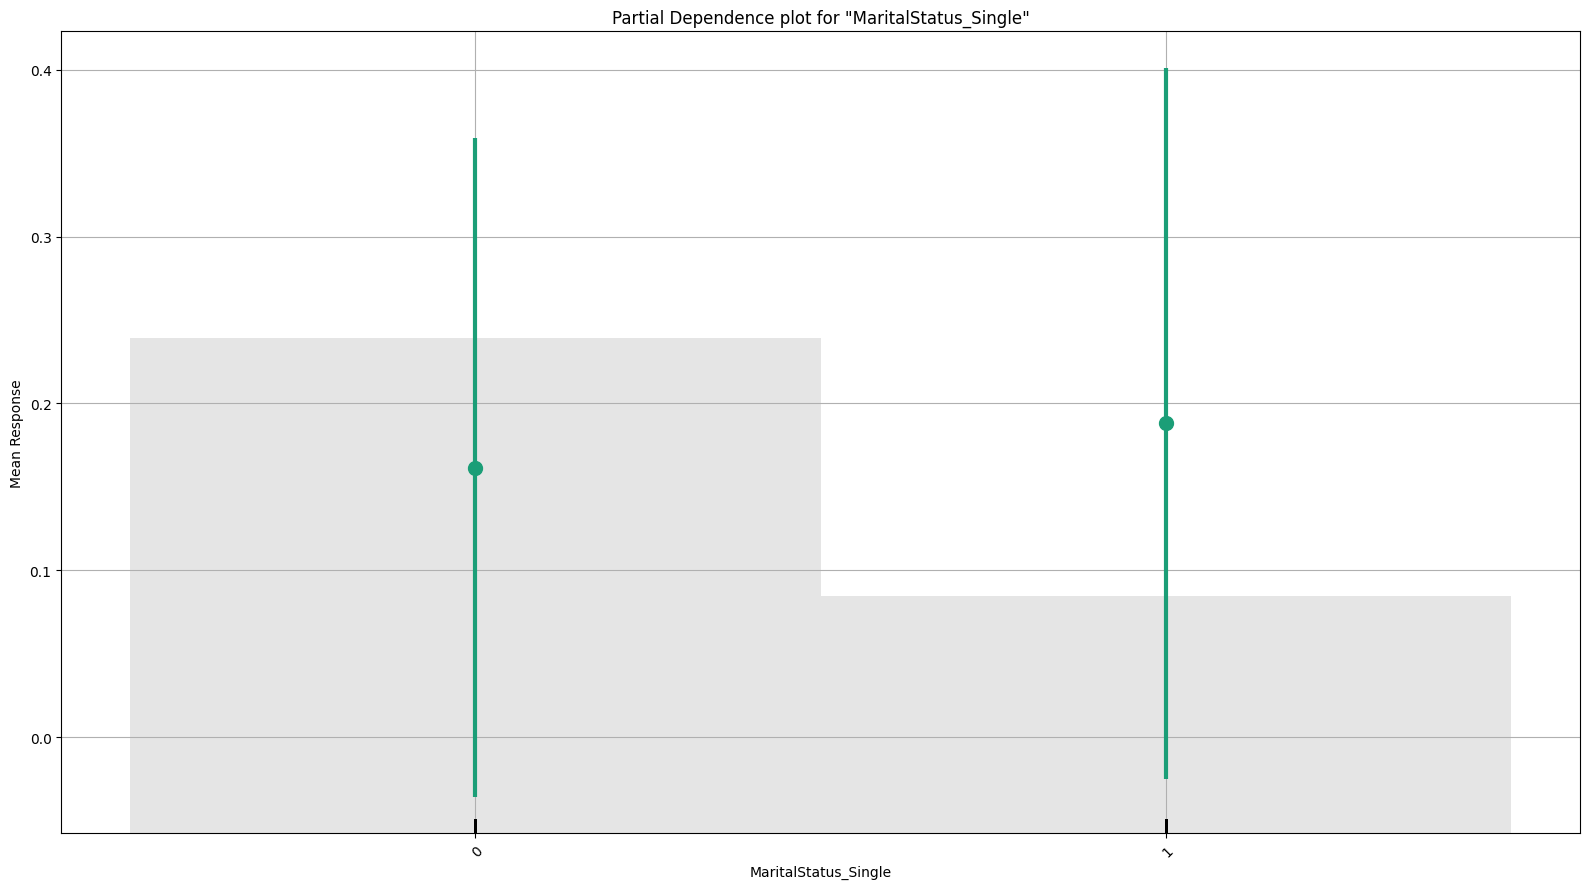

In [18]:
# Display test performance
test_best_model.explain(test)

# Saving Models

In [19]:
# Save models into folder

# Create a folder in the root directory
!mkdir -p "../models/balanceclasses"

# Get current time
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

cv_model_path = "../models/balanceclasses/"+current_time+"/cv"
test_model_path = "../models/balanceclasses/"+current_time+"/test"
cv_lb_path = "../models/balanceclasses/"+current_time+"/cv_lb.csv"
test_lb_path = "../models/balanceclasses/"+current_time+"/test_lb.csv"

cv_leader_model_path = h2o.save_model(model=cv_best_model, path=cv_model_path, force=True)
test_leader_model_path = h2o.save_model(model=test_best_model, path=test_model_path, force=True)
h2o.export_file(lb, path=cv_lb_path, force = True)
h2o.export_file(test_lb, path=test_lb_path, force = True)

print(current_time)
print(cv_leader_model_path)

# Documentation: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/save-and-load-model.html

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
2025-03-26_23-07-06
D:\OneDrive\Repos\employee-attrition-ibm\models\balanceclasses\2025-03-26_23-07-06\cv\GLM_1_AutoML_1_20250326_214224


A subdirectory or file -p already exists.
Error occurred while processing: -p.
